In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [2]:
from matplotlib import rc
rc('font', **{'size':20})
rc('text', usetex=False)
rc('xtick', labelsize=20) #20 
rc('ytick', labelsize=20) #20
rc('axes', titlesize=20)    # fontsize of the axes title
rc('axes', labelsize=20) 

In [3]:
expt = '01deg_jra55v140_iaf_cycle3'
session = cc.database.create_session()

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35875,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:39381,Total threads: 1
Dashboard: /proxy/37223/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:44017,


In [ ]:
chunk = {'yu_ocean':52, 'xu_ocean':1200}
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*')
# Load CSHT field
CSHT_along = xr.open_mfdataset(\
    '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

In [ ]:
# Average U_along into mean, seasonal, monthly and annual fields

u_along_da_mean = u_along.mean('time').u_along_contour_binned
u_along_da_seasonal = u_along.groupby('time.month').mean('time').u_along_contour_binned
u_along_da_annual = u_along.groupby('time.year').mean('time').u_along_contour_binned
## CHECK: Is this the right way? 
u_along_da_monthly = u_along.resample(time='1M').mean().u_along_contour_binned

#u_along_da_mean.load()
#u_along_da_seasonal.load()
#u_along_da_annual.load()
u_along_da_monthly.load()

## Assess u_along and CSHT in regimes

In [ ]:
clustering_mask = xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')

In [ ]:
masked_u_along = u_along_da_monthly.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*clustering_mask
masked_u_along.load()

In [ ]:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

In [ ]:
masked_CSHT = CSHT_months*clustering_mask
masked_CSHT.load()

## plotting here

In [ ]:
classes = ['Surface', 'Reverse', 'Deep']

In [ ]:
## Average over different time scales to get depth-based correlations
'''
CSHT_annual = masked_CSHT.mean('lon').groupby('time.year').mean('time')
U_along_annual = masked_u_along.mean('lon').groupby('time.year').mean('time')

CSHT_clima = masked_CSHT.groupby('time.month').mean('time').mean('lon')
U_along_clima = masked_u_along.groupby('time.month').mean('time').mean('lon')
'''
CSHT_layerwise = masked_CSHT.mean('lon').regimes_mask
U_along_layerwise = masked_u_along.mean('lon').regimes_mask

#CSHT_depthav = masked_CSHT.mean('lon').mean('depth').regimes_mask
U_along_depthav = masked_u_along.mean('lon').mean('depth').regimes_mask
U_along_depthav

In [ ]:
slope_all = np.zeros((masked_u_along.depth.size, 3))
stderr_all = np.zeros((masked_u_along.depth.size, 3))
r_sq_all = np.zeros((masked_u_along.depth.size, 3))
slope_depthav = np.zeros((masked_u_along.depth.size, 3))
stderr_depthav = np.zeros((masked_u_along.depth.size, 3))
r_sq_depthav = np.zeros((masked_u_along.depth.size, 3))
pval_depthav = np.zeros((masked_u_along.depth.size, 3))
pval_all = np.zeros((masked_u_along.depth.size, 3))

'''
slope_deseasoned = np.zeros((masked_u_along.depth.size, 3))
stderr_deseasoned = np.zeros((masked_u_along.depth.size, 3))
r_sq_deseasoned = np.zeros((masked_u_along.depth.size, 3))
slope_clima = np.zeros((masked_u_along.depth.size, 3))
stderr_clima = np.zeros((masked_u_along.depth.size, 3))
r_sq_clima = np.zeros((masked_u_along.depth.size, 3))
'''
for i in range(3):
    for j in range(masked_u_along.depth.size):
        slope_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).slope
        stderr_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).stderr
        r_sq_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).rvalue**2
        slope_depthav[j,i] = stats.linregress(U_along_depthav[:,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).slope
        stderr_depthav[j,i] = stats.linregress(U_along_depthav[:,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).stderr
        r_sq_depthav[j,i] = stats.linregress(U_along_depthav[:,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).rvalue**2
        
        pval_all[j,i] = 1-stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).pvalue
        pval_depthav[j,i] = 1-stats.linregress(U_along_depthav[:,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).pvalue

In [ ]:
plt.plot(r_sq_depthav[:,i],  masked_u_along.depth)

In [ ]:
# Import bathymetry
lat_slice = slice(-80, -59)
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()

In [ ]:
# For polar projection
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Data required for lat/lon mapping
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# Make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

# Fontsize
ft_size = 16

In [ ]:
lon_along_contour = CSHT_along.lon_along_contour
lat_along_contour = CSHT_along.lat_along_contour

Text(0.5, 0, 'Latitude')

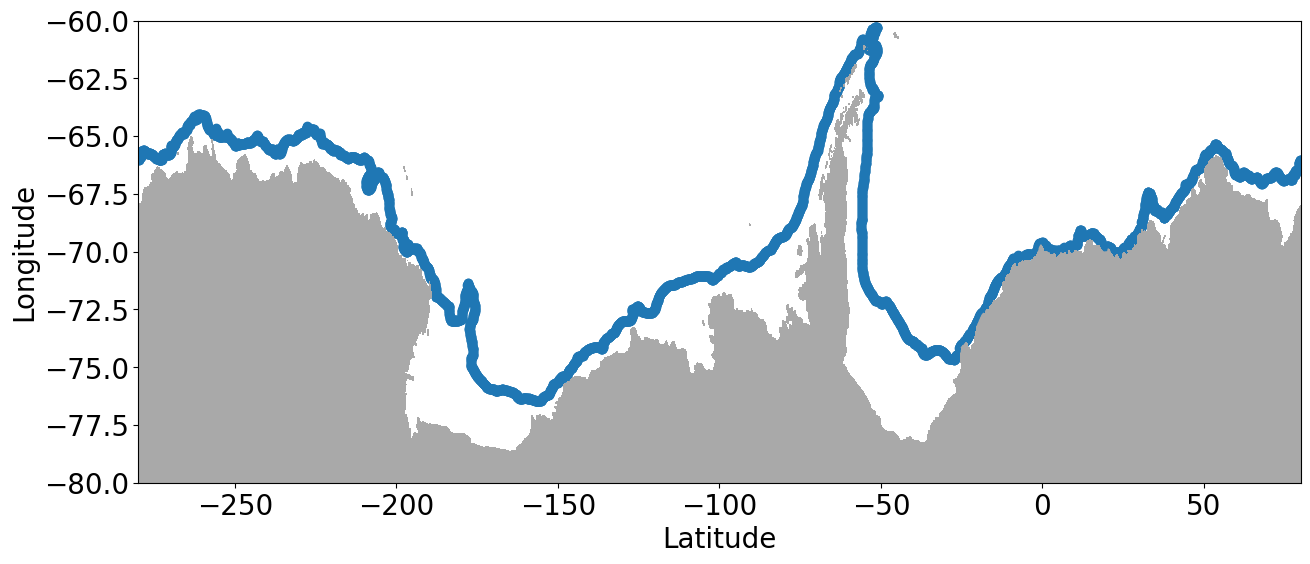

In [17]:
## Plot regions on antarctica ## USING 6002 CONTOUR INDEX
plt.figure(figsize = (15,6))
sc = plt.scatter(CSHT_along.lon_along_contour.isel(time = 0, st_ocean = 0), CSHT_along.lat_along_contour.isel(time = 0, st_ocean = 0))
plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
plt.plot(CSHT_along.lon_along_contour.isel(time = 0, st_ocean = 0), CSHT_along.lat_along_contour.isel(time = 0, st_ocean = -1))
plt.ylim([-80,-60])
plt.ylabel('Longitude')
plt.xlabel('Latitude')

In [ ]:
## importing 5 deg binned circumpolar correlations
binned_corr = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/r_sq_all_5degBins.nc')
binned_corr_av = binned_corr.sel(depth = slice(600,1000)).mean(dim = 'depth')

In [18]:
CSHT_lon_along_contour = CSHT_along.lon_along_contour.isel(time = 0, st_ocean = 0).values
CSHT_lat_along_contour = CSHT_along.lat_along_contour.isel(time = 0, st_ocean = 0).values

In [19]:
binned_corr_lon_bins = binned_corr.lon_bins.values

In [21]:
## Takes a while! 
## improving the plotting by extrapolating 5 deg bins into original contour CSHT_lon_along_contour so plot is nicer
binned_corr_av_ext = np.zeros((len(CSHT_lon_along_contour),3))

n = 5 # no of degrees binning

XX = 0
for check_ll in range(len(CSHT_lon_along_contour)): # new longer lon
    print('ll = ', check_ll)
    for xx in range(XX, len(binned_corr_lon_bins)): # binned lon
        if (CSHT_lon_along_contour[check_ll] > binned_corr_lon_bins[xx] -n/2) & (CSHT_lon_along_contour[check_ll] < binned_corr_lon_bins[xx]+n/2 ):
            print('selecting', CSHT_lon_along_contour[check_ll] , binned_corr_lon_bins[xx])
            binned_corr_av_ext[check_ll,:] = binned_corr_av.isel(lon_bin_mid = xx).r_sq_all.values

2024-04-10 15:08:18,494 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ff3890582c0ce5f0a3c833e5c1bca353', 0): 'waiting'}
2024-04-10 15:08:18,497 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ff3890582c0ce5f0a3c833e5c1bca353', 0),)


ll =  0
ll =  1
ll =  2
ll =  3
ll =  4
ll =  5
ll =  6
ll =  7
ll =  8
ll =  9
ll =  10
ll =  11
ll =  12
ll =  13
ll =  14
ll =  15
ll =  16
ll =  17
ll =  18
ll =  19
ll =  20
ll =  21
ll =  22
ll =  23
ll =  24
ll =  25
selecting -278.49999999999966 -276.0
ll =  26
selecting -278.39999999999964 -276.0
ll =  27
selecting -278.39999999999964 -276.0
ll =  28
selecting -278.2999999999996 -276.0
ll =  29
selecting -278.1999999999996 -276.0
ll =  30
selecting -278.09999999999957 -276.0
ll =  31
selecting -277.99999999999955 -276.0
ll =  32
selecting -278.09999999999957 -276.0
ll =  33
selecting -277.8999999999995 -276.0
ll =  34
selecting -277.7999999999995 -276.0
ll =  35
selecting -277.6999999999995 -276.0
ll =  36
selecting -277.59999999999945 -276.0
ll =  37
selecting -277.6999999999995 -276.0
ll =  38
selecting -277.49999999999943 -276.0
ll =  39
selecting -277.3999999999994 -276.0
ll =  40
selecting -277.2999999999994 -276.0
ll =  41
selecting -277.19999999999936 -276.0
ll =  42
se

2024-04-10 15:08:18,978 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ff3890582c0ce5f0a3c833e5c1bca353', 0): 'forgotten'}
2024-04-10 15:08:18,981 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ff3890582c0ce5f0a3c833e5c1bca353', 0),)


ll =  47
selecting -276.7999999999993 -276.0
ll =  48
selecting -276.69999999999925 -276.0
ll =  49
selecting -276.5999999999992 -276.0
ll =  50
selecting -276.4999999999992 -276.0
ll =  51
selecting -276.4999999999992 -276.0
ll =  52
selecting -276.3999999999992 -276.0
ll =  53
selecting -276.29999999999916 -276.0
ll =  54
selecting -276.19999999999914 -276.0
ll =  55
selecting -276.29999999999916 -276.0
ll =  56
selecting -276.0999999999991 -276.0
ll =  57
selecting -275.9999999999991 -276.0


2024-04-10 15:08:19,271 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ff3890582c0ce5f0a3c833e5c1bca353', 0): 'forgotten'}
2024-04-10 15:08:19,274 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ff3890582c0ce5f0a3c833e5c1bca353', 0),)


ll =  58
selecting -275.89999999999907 -276.0
ll =  59
selecting -275.79999999999905 -276.0
ll =  60
selecting -275.699999999999 -276.0
ll =  61
selecting -275.599999999999 -276.0
ll =  62
selecting -275.699999999999 -276.0
ll =  63
selecting -275.499999999999 -276.0
ll =  64
selecting -275.39999999999895 -276.0
ll =  65
selecting -275.29999999999893 -276.0
ll =  66
selecting -275.1999999999989 -276.0
ll =  67
selecting -275.29999999999893 -276.0
ll =  68
selecting -275.0999999999989 -276.0
ll =  69
selecting -275.1999999999989 -276.0
ll =  70
selecting -274.99999999999886 -276.0
ll =  71
selecting -274.89999999999884 -276.0
ll =  72
selecting -274.7999999999988 -276.0
ll =  73
selecting -274.6999999999988 -276.0
ll =  74
selecting -274.5999999999988 -276.0


2024-04-10 15:08:19,641 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ff3890582c0ce5f0a3c833e5c1bca353', 0): 'forgotten'}
2024-04-10 15:08:19,643 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ff3890582c0ce5f0a3c833e5c1bca353', 0),)


ll =  75
selecting -274.49999999999875 -276.0
ll =  76
selecting -274.5999999999988 -276.0
ll =  77
selecting -274.3999999999987 -276.0
ll =  78
selecting -274.49999999999875 -276.0
ll =  79
selecting -274.2999999999987 -276.0
ll =  80
selecting -274.1999999999987 -276.0
ll =  81
selecting -274.1999999999987 -276.0
ll =  82
selecting -274.09999999999866 -276.0
ll =  83
selecting -273.99999999999864 -276.0
ll =  84
selecting -273.8999999999986 -276.0
ll =  85
selecting -273.7999999999986 -276.0
ll =  86
selecting -273.69999999999857 -276.0
ll =  87
selecting -273.7999999999986 -276.0
ll =  88
selecting -273.59999999999854 -276.0
ll =  89
selecting -273.69999999999857 -276.0
ll =  90
selecting -273.4999999999985 -271.0
ll =  91
selecting -273.3999999999985 -271.0
ll =  92
selecting -273.2999999999985 -271.0
ll =  93
selecting -273.3999999999985 -271.0
ll =  94
selecting -273.19999999999845 -271.0
ll =  95
selecting -273.09999999999843 -271.0
ll =  96
selecting -272.9999999999984 -271.0
l

2024-04-10 15:08:20,164 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-67f49dd393686e93c8b477e6ba9bcb26', 0): 'waiting'}
2024-04-10 15:08:20,166 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-67f49dd393686e93c8b477e6ba9bcb26', 0),)


ll =  102
selecting -272.5999999999983 -271.0
ll =  103
selecting -272.5999999999983 -271.0
ll =  104
selecting -272.4999999999983 -271.0
ll =  105
selecting -272.4999999999983 -271.0
ll =  106
selecting -272.4999999999983 -271.0
ll =  107
selecting -272.4999999999983 -271.0
ll =  108
selecting -272.3999999999983 -271.0
ll =  109
selecting -272.3999999999983 -271.0
ll =  110
selecting -272.29999999999825 -271.0
ll =  111
selecting -272.1999999999982 -271.0
ll =  112
selecting -272.0999999999982 -271.0
ll =  113
selecting -271.9999999999982 -271.0
ll =  114
selecting -271.89999999999816 -271.0
ll =  115
selecting -271.79999999999814 -271.0
ll =  116
selecting -271.6999999999981 -271.0
ll =  117
selecting -271.5999999999981 -271.0
ll =  118
selecting -271.5999999999981 -271.0
ll =  119
selecting -271.49999999999807 -271.0
ll =  120
selecting -271.39999999999804 -271.0
ll =  121
selecting -271.49999999999807 -271.0
ll =  122
selecting -271.299999999998 -271.0
ll =  123
selecting -271.1999

2024-04-10 15:08:20,585 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-67f49dd393686e93c8b477e6ba9bcb26', 0): 'forgotten'}
2024-04-10 15:08:20,587 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-67f49dd393686e93c8b477e6ba9bcb26', 0),)
2024-04-10 15:08:20,665 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-67f49dd393686e93c8b477e6ba9bcb26', 0): 'forgotten'}


ll =  124
selecting -271.099999999998 -271.0
ll =  125
selecting -270.99999999999795 -271.0
ll =  126
selecting -271.099999999998 -271.0
ll =  127
selecting -270.89999999999793 -271.0
ll =  128
selecting -270.7999999999979 -271.0
ll =  129
selecting -270.6999999999979 -271.0
ll =  130
selecting -270.59999999999786 -271.0
ll =  131
selecting -270.49999999999784 -271.0
ll =  132
selecting -270.3999999999978 -271.0
ll =  133
selecting -270.2999999999978 -271.0
ll =  134
selecting -270.2999999999978 -271.0
ll =  135
selecting -270.1999999999978 -271.0


2024-04-10 15:08:20,669 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-67f49dd393686e93c8b477e6ba9bcb26', 0),)
2024-04-10 15:08:20,845 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-67f49dd393686e93c8b477e6ba9bcb26', 0): 'forgotten'}
2024-04-10 15:08:20,848 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-67f49dd393686e93c8b477e6ba9bcb26', 0),)


ll =  136
selecting -270.09999999999775 -271.0
ll =  137
selecting -269.9999999999977 -271.0
ll =  138
selecting -269.9999999999977 -271.0
ll =  139
selecting -269.8999999999977 -271.0
ll =  140
selecting -269.8999999999977 -271.0
ll =  141
selecting -269.7999999999977 -271.0
ll =  142
selecting -269.7999999999977 -271.0
ll =  143
selecting -269.69999999999766 -271.0
ll =  144
selecting -269.69999999999766 -271.0
ll =  145
selecting -269.69999999999766 -271.0


2024-04-10 15:08:21,074 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-67f49dd393686e93c8b477e6ba9bcb26', 0): 'forgotten'}
2024-04-10 15:08:21,078 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-67f49dd393686e93c8b477e6ba9bcb26', 0),)


ll =  146
selecting -269.69999999999766 -271.0
ll =  147
selecting -269.69999999999766 -271.0
ll =  148
selecting -269.69999999999766 -271.0
ll =  149
selecting -269.7999999999977 -271.0
ll =  150
selecting -269.69999999999766 -271.0
ll =  151
selecting -269.69999999999766 -271.0
ll =  152
selecting -269.59999999999764 -271.0
ll =  153
selecting -269.4999999999976 -271.0
ll =  154
selecting -269.59999999999764 -271.0
ll =  155
selecting -269.3999999999976 -271.0
ll =  156
selecting -269.4999999999976 -271.0


2024-04-10 15:08:21,282 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-67f49dd393686e93c8b477e6ba9bcb26', 0): 'forgotten'}
2024-04-10 15:08:21,285 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-67f49dd393686e93c8b477e6ba9bcb26', 0),)
2024-04-10 15:08:21,348 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-67f49dd393686e93c8b477e6ba9bcb26', 0): 'waiting'}


ll =  157
selecting -269.29999999999757 -271.0
ll =  158
selecting -269.19999999999754 -271.0
ll =  159
selecting -269.0999999999975 -271.0
ll =  160
selecting -268.9999999999975 -271.0
ll =  161
selecting -268.9999999999975 -271.0
ll =  162
selecting -268.8999999999975 -271.0
ll =  163
selecting -268.79999999999745 -271.0
ll =  164
selecting -268.69999999999743 -271.0
ll =  165
selecting -268.69999999999743 -271.0
ll =  166
selecting -268.5999999999974 -271.0
ll =  167
selecting -268.5999999999974 -271.0


2024-04-10 15:08:21,351 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-67f49dd393686e93c8b477e6ba9bcb26', 0),)
2024-04-10 15:08:21,537 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-23aa7c327d96c0d6b968d1a0b6341aed', 0): 'forgotten'}
2024-04-10 15:08:21,541 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-23aa7c327d96c0d6b968d1a0b6341aed', 0),)


ll =  168
selecting -268.5999999999974 -271.0
ll =  169
selecting -268.4999999999974 -266.0
ll =  170
selecting -268.39999999999736 -266.0
ll =  171
selecting -268.39999999999736 -266.0
ll =  172
selecting -268.29999999999734 -266.0
ll =  173
selecting -268.29999999999734 -266.0
ll =  174
selecting -268.29999999999734 -266.0
ll =  175
selecting -268.1999999999973 -266.0
ll =  176
selecting -268.0999999999973 -266.0
ll =  177
selecting -267.99999999999727 -266.0


2024-04-10 15:08:21,730 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-23aa7c327d96c0d6b968d1a0b6341aed', 0): 'forgotten'}
2024-04-10 15:08:21,733 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-23aa7c327d96c0d6b968d1a0b6341aed', 0),)


ll =  178
selecting -267.99999999999727 -266.0
ll =  179
selecting -267.89999999999725 -266.0
ll =  180
selecting -267.7999999999972 -266.0
ll =  181
selecting -267.6999999999972 -266.0
ll =  182
selecting -267.6999999999972 -266.0
ll =  183
selecting -267.5999999999972 -266.0
ll =  184
selecting -267.5999999999972 -266.0
ll =  185
selecting -267.49999999999716 -266.0
ll =  186
selecting -267.39999999999714 -266.0
ll =  187
selecting -267.39999999999714 -266.0
ll =  188
selecting -267.2999999999971 -266.0
ll =  189
selecting -267.2999999999971 -266.0
ll =  190
selecting -267.1999999999971 -266.0
ll =  191
selecting -267.09999999999707 -266.0
ll =  192
selecting -266.99999999999704 -266.0
ll =  193
selecting -266.99999999999704 -266.0
ll =  194
selecting -266.899999999997 -266.0
ll =  195
selecting -266.799999999997 -266.0
ll =  196
selecting -266.699999999997 -266.0
ll =  197
selecting -266.59999999999695 -266.0
ll =  198
selecting -266.59999999999695 -266.0
ll =  199
selecting -266.59

2024-04-10 15:08:22,384 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-23aa7c327d96c0d6b968d1a0b6341aed', 0): 'waiting'}
2024-04-10 15:08:22,386 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-23aa7c327d96c0d6b968d1a0b6341aed', 0),)


ll =  205
selecting -266.09999999999684 -266.0
ll =  206
selecting -266.19999999999686 -266.0
ll =  207
selecting -265.9999999999968 -266.0
ll =  208
selecting -265.8999999999968 -266.0
ll =  209
selecting -265.79999999999677 -266.0
ll =  210
selecting -265.79999999999677 -266.0
ll =  211
selecting -265.69999999999675 -266.0
ll =  212
selecting -265.5999999999967 -266.0
ll =  213
selecting -265.5999999999967 -266.0
ll =  214
selecting -265.4999999999967 -266.0
ll =  215
selecting -265.4999999999967 -266.0
ll =  216
selecting -265.3999999999967 -266.0


2024-04-10 15:08:22,652 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-23aa7c327d96c0d6b968d1a0b6341aed', 0): 'forgotten'}
2024-04-10 15:08:22,654 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-23aa7c327d96c0d6b968d1a0b6341aed', 0),)


ll =  217
selecting -265.29999999999666 -266.0
ll =  218
selecting -265.29999999999666 -266.0
ll =  219
selecting -265.19999999999663 -266.0
ll =  220
selecting -265.0999999999966 -266.0
ll =  221
selecting -264.9999999999966 -266.0
ll =  222
selecting -264.89999999999657 -266.0
ll =  223
selecting -264.89999999999657 -266.0
ll =  224
selecting -264.79999999999654 -266.0
ll =  225
selecting -264.79999999999654 -266.0
ll =  226
selecting -264.79999999999654 -266.0
ll =  227
selecting -264.79999999999654 -266.0
ll =  228
selecting -264.6999999999965 -266.0
ll =  229
selecting -264.6999999999965 -266.0
ll =  230
selecting -264.5999999999965 -266.0
ll =  231
selecting -264.5999999999965 -266.0
ll =  232
selecting -264.4999999999965 -266.0
ll =  233
selecting -264.39999999999645 -266.0
ll =  234
selecting -264.4999999999965 -266.0


2024-04-10 15:08:22,997 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-23aa7c327d96c0d6b968d1a0b6341aed', 0): 'forgotten'}
2024-04-10 15:08:23,001 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-23aa7c327d96c0d6b968d1a0b6341aed', 0),)
2024-04-10 15:08:23,111 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-23aa7c327d96c0d6b968d1a0b6341aed', 0): 'waiting'}
2024-04-10 15:08:23,112 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-23aa7c327d96c0d6b968d1a0b6341aed', 0),)


ll =  235
selecting -264.29999999999643 -266.0
ll =  236
selecting -264.1999999999964 -266.0
ll =  237
selecting -264.0999999999964 -266.0
ll =  238
selecting -263.99999999999636 -266.0
ll =  239
selecting -263.99999999999636 -266.0
ll =  240
selecting -263.99999999999636 -266.0
ll =  241
selecting -263.89999999999634 -266.0
ll =  242
selecting -263.89999999999634 -266.0
ll =  243
selecting -263.7999999999963 -266.0
ll =  244
selecting -263.7999999999963 -266.0
ll =  245
selecting -263.6999999999963 -266.0
ll =  246
selecting -263.59999999999627 -266.0
ll =  247
selecting -263.49999999999625 -261.0
ll =  248
selecting -263.3999999999962 -261.0
ll =  249
selecting -263.2999999999962 -261.0
ll =  250
selecting -263.1999999999962 -261.0
ll =  251
selecting -263.1999999999962 -261.0
ll =  252
selecting -263.09999999999616 -261.0
ll =  253
selecting -262.99999999999613 -261.0
ll =  254
selecting -262.99999999999613 -261.0
ll =  255
selecting -262.99999999999613 -261.0
ll =  256
selecting -2

2024-04-10 15:08:23,700 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f37202387863fd3b5b0cd9445abdcfb9', 0): 'forgotten'}
2024-04-10 15:08:23,704 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f37202387863fd3b5b0cd9445abdcfb9', 0),)


ll =  267
selecting -262.299999999996 -261.0
ll =  268
selecting -262.399999999996 -261.0
ll =  269
selecting -262.19999999999595 -261.0
ll =  270
selecting -262.09999999999593 -261.0
ll =  271
selecting -262.09999999999593 -261.0
ll =  272
selecting -261.9999999999959 -261.0
ll =  273
selecting -261.8999999999959 -261.0
ll =  274
selecting -261.79999999999586 -261.0
ll =  275
selecting -261.69999999999584 -261.0
ll =  276
selecting -261.69999999999584 -261.0
ll =  277
selecting -261.5999999999958 -261.0
ll =  278
selecting -261.5999999999958 -261.0
ll =  279
selecting -261.5999999999958 -261.0
ll =  280
selecting -261.5999999999958 -261.0
ll =  281
selecting -261.5999999999958 -261.0
ll =  282
selecting -261.4999999999958 -261.0
ll =  283
selecting -261.39999999999577 -261.0
ll =  284
selecting -261.29999999999575 -261.0
ll =  285
selecting -261.39999999999577 -261.0
ll =  286
selecting -261.1999999999957 -261.0
ll =  287
selecting -261.0999999999957 -261.0
ll =  288
selecting -261.09

2024-04-10 15:08:24,213 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f37202387863fd3b5b0cd9445abdcfb9', 0): 'waiting'}
2024-04-10 15:08:24,215 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f37202387863fd3b5b0cd9445abdcfb9', 0),)


ll =  291
selecting -260.79999999999563 -261.0
ll =  292
selecting -260.6999999999956 -261.0
ll =  293
selecting -260.5999999999956 -261.0
ll =  294
selecting -260.6999999999956 -261.0
ll =  295
selecting -260.49999999999557 -261.0
ll =  296
selecting -260.39999999999554 -261.0
ll =  297
selecting -260.2999999999955 -261.0
ll =  298
selecting -260.1999999999955 -261.0
ll =  299
selecting -260.0999999999955 -261.0
ll =  300
selecting -259.99999999999545 -261.0
ll =  301
selecting -259.89999999999543 -261.0
ll =  302
selecting -259.7999999999954 -261.0
ll =  303
selecting -259.6999999999954 -261.0
ll =  304
selecting -259.59999999999536 -261.0


2024-04-10 15:08:24,354 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f37202387863fd3b5b0cd9445abdcfb9', 0): 'waiting'}
2024-04-10 15:08:24,357 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f37202387863fd3b5b0cd9445abdcfb9', 0),)
2024-04-10 15:08:24,417 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f37202387863fd3b5b0cd9445abdcfb9', 0): 'waiting'}
2024-04-10 15:08:24,420 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f37202387863fd3b5b0cd9445abdcfb9', 0),)


ll =  305
selecting -259.49999999999534 -261.0
ll =  306
selecting -259.59999999999536 -261.0
ll =  307
selecting -259.3999999999953 -261.0
ll =  308
selecting -259.2999999999953 -261.0
ll =  309
selecting -259.19999999999527 -261.0
ll =  310
selecting -259.09999999999525 -261.0
ll =  311
selecting -259.09999999999525 -261.0
ll =  312
selecting -258.9999999999952 -261.0
ll =  313
selecting -259.09999999999525 -261.0
ll =  314
selecting -258.9999999999952 -261.0
ll =  315
selecting -258.8999999999952 -261.0
ll =  316
selecting -258.9999999999952 -261.0
ll =  317
selecting -258.7999999999952 -261.0
ll =  318
selecting -258.8999999999952 -261.0


2024-04-10 15:08:24,562 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f37202387863fd3b5b0cd9445abdcfb9', 0): 'forgotten'}
2024-04-10 15:08:24,563 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f37202387863fd3b5b0cd9445abdcfb9', 0),)


ll =  319
selecting -258.69999999999516 -261.0
ll =  320
selecting -258.7999999999952 -261.0
ll =  321
selecting -258.59999999999513 -261.0
ll =  322
selecting -258.69999999999516 -261.0
ll =  323
selecting -258.59999999999513 -261.0
ll =  324
selecting -258.4999999999951 -256.0
ll =  325
selecting -258.59999999999513 -261.0
ll =  326
selecting -258.3999999999951 -256.0


2024-04-10 15:08:24,792 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-47101e86d4840389c779ac20a6d50a4e', 0): 'forgotten'}
2024-04-10 15:08:24,797 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-47101e86d4840389c779ac20a6d50a4e', 0),)


ll =  327
selecting -258.4999999999951 -256.0
ll =  328
selecting -258.29999999999507 -256.0
ll =  329
selecting -258.3999999999951 -256.0
ll =  330
selecting -258.19999999999504 -256.0
ll =  331
selecting -258.099999999995 -256.0
ll =  332
selecting -258.19999999999504 -256.0
ll =  333
selecting -257.999999999995 -256.0
ll =  334
selecting -257.899999999995 -256.0
ll =  335
selecting -257.999999999995 -256.0
ll =  336
selecting -257.79999999999495 -256.0
ll =  337
selecting -257.899999999995 -256.0
ll =  338
selecting -257.69999999999493 -256.0
ll =  339
selecting -257.5999999999949 -256.0


2024-04-10 15:08:25,153 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-47101e86d4840389c779ac20a6d50a4e', 0): 'forgotten'}


ll =  340
selecting -257.4999999999949 -256.0
ll =  341
selecting -257.39999999999486 -256.0
ll =  342
selecting -257.29999999999484 -256.0
ll =  343
selecting -257.1999999999948 -256.0
ll =  344
selecting -257.0999999999948 -256.0
ll =  345
selecting -257.1999999999948 -256.0
ll =  346
selecting -256.99999999999477 -256.0
ll =  347
selecting -256.89999999999475 -256.0
ll =  348
selecting -256.99999999999477 -256.0
ll =  349
selecting -256.7999999999947 -256.0
ll =  350
selecting -256.89999999999475 -256.0


2024-04-10 15:08:25,157 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-47101e86d4840389c779ac20a6d50a4e', 0),)
2024-04-10 15:08:25,275 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-47101e86d4840389c779ac20a6d50a4e', 0): 'waiting'}
2024-04-10 15:08:25,278 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-47101e86d4840389c779ac20a6d50a4e', 0),)
2024-04-10 15:08:25,331 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-47101e86d4840389c779ac20a6d50a4e', 0): 'forgotten'}
2024-04-10 15:08:25,335 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-47101e86d4840389c779ac20a6d50a4e', 0),)


ll =  351
selecting -256.6999999999947 -256.0
ll =  352
selecting -256.5999999999947 -256.0
ll =  353
selecting -256.6999999999947 -256.0
ll =  354
selecting -256.49999999999466 -256.0
ll =  355
selecting -256.5999999999947 -256.0
ll =  356
selecting -256.39999999999463 -256.0
ll =  357
selecting -256.2999999999946 -256.0
ll =  358
selecting -256.1999999999946 -256.0
ll =  359
selecting -256.1999999999946 -256.0
ll =  360
selecting -256.1999999999946 -256.0


2024-04-10 15:08:25,480 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-47101e86d4840389c779ac20a6d50a4e', 0): 'forgotten'}
2024-04-10 15:08:25,484 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-47101e86d4840389c779ac20a6d50a4e', 0),)


ll =  361
selecting -256.1999999999946 -256.0
ll =  362
selecting -256.09999999999457 -256.0
ll =  363
selecting -256.09999999999457 -256.0
ll =  364
selecting -256.09999999999457 -256.0
ll =  365
selecting -256.09999999999457 -256.0
ll =  366
selecting -255.99999999999457 -256.0
ll =  367
selecting -255.89999999999458 -256.0
ll =  368
selecting -255.89999999999458 -256.0
ll =  369
selecting -255.79999999999458 -256.0
ll =  370
selecting -255.79999999999458 -256.0
ll =  371
selecting -255.6999999999946 -256.0
ll =  372
selecting -255.79999999999458 -256.0
ll =  373
selecting -255.5999999999946 -256.0
ll =  374
selecting -255.6999999999946 -256.0
ll =  375
selecting -255.4999999999946 -256.0


2024-04-10 15:08:25,806 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-47101e86d4840389c779ac20a6d50a4e', 0): 'forgotten'}
2024-04-10 15:08:25,809 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-47101e86d4840389c779ac20a6d50a4e', 0),)


ll =  376
selecting -255.5999999999946 -256.0
ll =  377
selecting -255.3999999999946 -256.0
ll =  378
selecting -255.2999999999946 -256.0
ll =  379
selecting -255.19999999999462 -256.0
ll =  380
selecting -255.19999999999462 -256.0
ll =  381
selecting -255.19999999999462 -256.0
ll =  382
selecting -255.09999999999462 -256.0
ll =  383
selecting -255.19999999999462 -256.0
ll =  384
selecting -254.99999999999463 -256.0
ll =  385
selecting -255.09999999999462 -256.0
ll =  386
selecting -254.89999999999463 -256.0
ll =  387
selecting -254.99999999999463 -256.0
ll =  388
selecting -254.79999999999464 -256.0
ll =  389
selecting -254.69999999999465 -256.0
ll =  390
selecting -254.59999999999465 -256.0
ll =  391
selecting -254.49999999999466 -256.0
ll =  392
selecting -254.39999999999466 -256.0
ll =  393
selecting -254.29999999999467 -256.0
ll =  394
selecting -254.29999999999467 -256.0
ll =  395
selecting -254.19999999999467 -256.0
ll =  396
selecting -254.09999999999468 -256.0
ll =  397
select

2024-04-10 15:08:26,050 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-47101e86d4840389c779ac20a6d50a4e', 0): 'waiting'}
2024-04-10 15:08:26,053 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-47101e86d4840389c779ac20a6d50a4e', 0),)
2024-04-10 15:08:26,275 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1ac0c743e440e594616d20c639b8fe55', 0): 'forgotten'}
2024-04-10 15:08:26,279 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1ac0c743e440e594616d20c639b8fe55', 0),)


ll =  398
selecting -253.99999999999469 -256.0
ll =  399
selecting -253.8999999999947 -256.0
ll =  400
selecting -253.7999999999947 -256.0
ll =  401
selecting -253.7999999999947 -256.0
ll =  402
selecting -253.6999999999947 -256.0
ll =  403
selecting -253.5999999999947 -256.0
ll =  404
selecting -253.4999999999947 -251.0
ll =  405
selecting -253.39999999999472 -251.0
ll =  406
selecting -253.29999999999472 -251.0
ll =  407
selecting -253.19999999999473 -251.0
ll =  408
selecting -253.09999999999474 -251.0
ll =  409
selecting -253.19999999999473 -251.0
ll =  410
selecting -252.99999999999474 -251.0
ll =  411
selecting -252.89999999999475 -251.0
ll =  412
selecting -252.79999999999475 -251.0
ll =  413
selecting -252.79999999999475 -251.0
ll =  414
selecting -252.69999999999476 -251.0
ll =  415
selecting -252.69999999999476 -251.0
ll =  416
selecting -252.69999999999476 -251.0
ll =  417
selecting -252.59999999999476 -251.0
ll =  418
selecting -252.59999999999476 -251.0
ll =  419
selecting

2024-04-10 15:08:26,521 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1ac0c743e440e594616d20c639b8fe55', 0): 'forgotten'}
2024-04-10 15:08:26,524 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1ac0c743e440e594616d20c639b8fe55', 0),)
2024-04-10 15:08:26,706 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1ac0c743e440e594616d20c639b8fe55', 0): 'forgotten'}
2024-04-10 15:08:26,711 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1ac0c743e440e594616d20c639b8fe55', 0),)


ll =  422
selecting -252.39999999999478 -251.0
ll =  423
selecting -252.29999999999478 -251.0
ll =  424
selecting -252.39999999999478 -251.0
ll =  425
selecting -252.1999999999948 -251.0
ll =  426
selecting -252.29999999999478 -251.0
ll =  427
selecting -252.0999999999948 -251.0
ll =  428
selecting -251.9999999999948 -251.0
ll =  429
selecting -251.8999999999948 -251.0
ll =  430
selecting -251.7999999999948 -251.0
ll =  431
selecting -251.8999999999948 -251.0


2024-04-10 15:08:26,944 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1ac0c743e440e594616d20c639b8fe55', 0): 'forgotten'}
2024-04-10 15:08:26,948 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1ac0c743e440e594616d20c639b8fe55', 0),)


ll =  432
selecting -251.69999999999482 -251.0
ll =  433
selecting -251.59999999999482 -251.0
ll =  434
selecting -251.49999999999483 -251.0
ll =  435
selecting -251.39999999999483 -251.0
ll =  436
selecting -251.49999999999483 -251.0
ll =  437
selecting -251.29999999999484 -251.0
ll =  438
selecting -251.19999999999484 -251.0
ll =  439
selecting -251.09999999999485 -251.0
ll =  440
selecting -251.19999999999484 -251.0
ll =  441
selecting -250.99999999999486 -251.0
ll =  442
selecting -250.89999999999486 -251.0


2024-04-10 15:08:27,047 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1ac0c743e440e594616d20c639b8fe55', 0): 'forgotten'}
2024-04-10 15:08:27,051 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1ac0c743e440e594616d20c639b8fe55', 0),)
2024-04-10 15:08:27,117 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1ac0c743e440e594616d20c639b8fe55', 0): 'waiting'}
2024-04-10 15:08:27,118 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1ac0c743e440e594616d20c639b8fe55', 0),)


ll =  443
selecting -250.99999999999486 -251.0
ll =  444
selecting -250.79999999999487 -251.0
ll =  445
selecting -250.89999999999486 -251.0
ll =  446
selecting -250.69999999999487 -251.0
ll =  447
selecting -250.59999999999488 -251.0
ll =  448
selecting -250.49999999999488 -251.0
ll =  449
selecting -250.3999999999949 -251.0
ll =  450
selecting -250.49999999999488 -251.0
ll =  451
selecting -250.2999999999949 -251.0
ll =  452
selecting -250.1999999999949 -251.0
ll =  453
selecting -250.2999999999949 -251.0
ll =  454
selecting -250.0999999999949 -251.0
ll =  455
selecting -250.1999999999949 -251.0
ll =  456
selecting -249.9999999999949 -251.0
ll =  457
selecting -250.0999999999949 -251.0
ll =  458
selecting -249.89999999999492 -251.0
ll =  459
selecting -249.79999999999492 -251.0
ll =  460
selecting -249.69999999999493 -251.0
ll =  461
selecting -249.59999999999494 -251.0
ll =  462
selecting -249.59999999999494 -251.0
ll =  463
selecting -249.49999999999494 -251.0
ll =  464
selecting -

2024-04-10 15:08:27,487 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1ac0c743e440e594616d20c639b8fe55', 0): 'forgotten'}
2024-04-10 15:08:27,490 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1ac0c743e440e594616d20c639b8fe55', 0),)


ll =  467
selecting -249.39999999999495 -251.0
ll =  468
selecting -249.19999999999496 -251.0
ll =  469
selecting -249.09999999999496 -251.0
ll =  470
selecting -249.09999999999496 -251.0
ll =  471
selecting -249.09999999999496 -251.0
ll =  472
selecting -248.99999999999497 -251.0
ll =  473
selecting -248.89999999999498 -251.0
ll =  474
selecting -248.89999999999498 -251.0
ll =  475
selecting -248.79999999999498 -251.0


2024-04-10 15:08:27,855 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-915531dd5d7abda1cf5a52acb8d4b84e', 0): 'waiting'}
2024-04-10 15:08:27,857 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-915531dd5d7abda1cf5a52acb8d4b84e', 0),)


ll =  476
selecting -248.89999999999498 -251.0
ll =  477
selecting -248.699999999995 -251.0
ll =  478
selecting -248.599999999995 -251.0
ll =  479
selecting -248.499999999995 -246.0
ll =  480
selecting -248.499999999995 -246.0
ll =  481
selecting -248.399999999995 -246.0
ll =  482
selecting -248.299999999995 -246.0
ll =  483
selecting -248.19999999999501 -246.0
ll =  484
selecting -248.09999999999502 -246.0
ll =  485
selecting -247.99999999999503 -246.0
ll =  486
selecting -247.89999999999503 -246.0
ll =  487
selecting -247.79999999999504 -246.0
ll =  488
selecting -247.69999999999504 -246.0
ll =  489
selecting -247.59999999999505 -246.0
ll =  490
selecting -247.49999999999505 -246.0
ll =  491
selecting -247.39999999999506 -246.0
ll =  492
selecting -247.29999999999507 -246.0
ll =  493
selecting -247.19999999999507 -246.0
ll =  494
selecting -247.09999999999508 -246.0
ll =  495
selecting -246.99999999999508 -246.0
ll =  496
selecting -246.8999999999951 -246.0
ll =  497
selecting -246.7

2024-04-10 15:08:28,197 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-915531dd5d7abda1cf5a52acb8d4b84e', 0): 'forgotten'}
2024-04-10 15:08:28,206 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-915531dd5d7abda1cf5a52acb8d4b84e', 0),)
2024-04-10 15:08:28,280 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-915531dd5d7abda1cf5a52acb8d4b84e', 0): 'forgotten'}
2024-04-10 15:08:28,283 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-915531dd5d7abda1cf5a52acb8d4b84e', 0),)


ll =  500
selecting -246.5999999999951 -246.0
ll =  501
selecting -246.4999999999951 -246.0
ll =  502
selecting -246.39999999999512 -246.0
ll =  503
selecting -246.29999999999512 -246.0
ll =  504
selecting -246.29999999999512 -246.0
ll =  505
selecting -246.19999999999513 -246.0
ll =  506
selecting -246.09999999999513 -246.0
ll =  507
selecting -245.99999999999514 -246.0
ll =  508
selecting -245.89999999999515 -246.0
ll =  509
selecting -245.99999999999514 -246.0
ll =  510
selecting -245.79999999999515 -246.0


2024-04-10 15:08:28,485 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-915531dd5d7abda1cf5a52acb8d4b84e', 0): 'waiting'}
2024-04-10 15:08:28,487 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-915531dd5d7abda1cf5a52acb8d4b84e', 0),)


ll =  511
selecting -245.69999999999516 -246.0
ll =  512
selecting -245.59999999999516 -246.0
ll =  513
selecting -245.49999999999517 -246.0
ll =  514
selecting -245.39999999999517 -246.0
ll =  515
selecting -245.29999999999518 -246.0
ll =  516
selecting -245.19999999999519 -246.0
ll =  517
selecting -245.0999999999952 -246.0
ll =  518
selecting -244.9999999999952 -246.0
ll =  519
selecting -244.9999999999952 -246.0
ll =  520
selecting -244.8999999999952 -246.0
ll =  521
selecting -244.7999999999952 -246.0
ll =  522
selecting -244.6999999999952 -246.0
ll =  523
selecting -244.6999999999952 -246.0
ll =  524
selecting -244.59999999999522 -246.0


2024-04-10 15:08:28,598 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-915531dd5d7abda1cf5a52acb8d4b84e', 0): 'forgotten'}
2024-04-10 15:08:28,600 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-915531dd5d7abda1cf5a52acb8d4b84e', 0),)
2024-04-10 15:08:28,685 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-915531dd5d7abda1cf5a52acb8d4b84e', 0): 'waiting'}
2024-04-10 15:08:28,687 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-915531dd5d7abda1cf5a52acb8d4b84e', 0),)


ll =  525
selecting -244.49999999999523 -246.0
ll =  526
selecting -244.49999999999523 -246.0
ll =  527
selecting -244.39999999999523 -246.0
ll =  528
selecting -244.29999999999524 -246.0
ll =  529
selecting -244.29999999999524 -246.0
ll =  530
selecting -244.19999999999524 -246.0
ll =  531
selecting -244.09999999999525 -246.0
ll =  532
selecting -243.99999999999525 -246.0
ll =  533
selecting -243.89999999999526 -246.0
ll =  534
selecting -243.99999999999525 -246.0
ll =  535
selecting -243.79999999999526 -246.0
ll =  536
selecting -243.69999999999527 -246.0
ll =  537
selecting -243.59999999999528 -246.0
ll =  538
selecting -243.59999999999528 -246.0


2024-04-10 15:08:28,808 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7728ba81c4da4457e0f8593cce1a059d', 0): 'forgotten'}
2024-04-10 15:08:28,811 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7728ba81c4da4457e0f8593cce1a059d', 0),)


ll =  539
selecting -243.49999999999528 -241.0
ll =  540
selecting -243.49999999999528 -241.0
ll =  541
selecting -243.49999999999528 -241.0
ll =  542
selecting -243.3999999999953 -241.0
ll =  543
selecting -243.3999999999953 -241.0
ll =  544
selecting -243.2999999999953 -241.0
ll =  545
selecting -243.1999999999953 -241.0
ll =  546
selecting -243.1999999999953 -241.0
ll =  547
selecting -243.0999999999953 -241.0
ll =  548
selecting -242.9999999999953 -241.0
ll =  549
selecting -242.89999999999532 -241.0
ll =  550
selecting -242.9999999999953 -241.0
ll =  551
selecting -242.79999999999532 -241.0
ll =  552
selecting -242.89999999999532 -241.0
ll =  553
selecting -242.69999999999533 -241.0
ll =  554
selecting -242.79999999999532 -241.0
ll =  555
selecting -242.59999999999533 -241.0
ll =  556
selecting -242.69999999999533 -241.0
ll =  557
selecting -242.49999999999534 -241.0
ll =  558
selecting -242.59999999999533 -241.0
ll =  559
selecting -242.39999999999534 -241.0
ll =  560
selecting -

2024-04-10 15:08:29,286 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7728ba81c4da4457e0f8593cce1a059d', 0): 'waiting'}
2024-04-10 15:08:29,288 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7728ba81c4da4457e0f8593cce1a059d', 0),)
2024-04-10 15:08:29,345 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7728ba81c4da4457e0f8593cce1a059d', 0): 'forgotten'}
2024-04-10 15:08:29,348 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7728ba81c4da4457e0f8593cce1a059d', 0),)


ll =  561
selecting -242.19999999999536 -241.0
ll =  562
selecting -242.09999999999536 -241.0
ll =  563
selecting -242.19999999999536 -241.0
ll =  564
selecting -241.99999999999537 -241.0
ll =  565
selecting -241.89999999999537 -241.0
ll =  566
selecting -241.99999999999537 -241.0
ll =  567
selecting -241.79999999999538 -241.0
ll =  568
selecting -241.69999999999538 -241.0
ll =  569
selecting -241.5999999999954 -241.0
ll =  570
selecting -241.5999999999954 -241.0
ll =  571
selecting -241.4999999999954 -241.0
ll =  572
selecting -241.3999999999954 -241.0
ll =  573
selecting -241.2999999999954 -241.0
ll =  574
selecting -241.1999999999954 -241.0


2024-04-10 15:08:29,509 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7728ba81c4da4457e0f8593cce1a059d', 0): 'forgotten'}
2024-04-10 15:08:29,513 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7728ba81c4da4457e0f8593cce1a059d', 0),)


ll =  575
selecting -241.2999999999954 -241.0
ll =  576
selecting -241.09999999999542 -241.0
ll =  577
selecting -241.1999999999954 -241.0
ll =  578
selecting -240.99999999999542 -241.0
ll =  579
selecting -240.89999999999543 -241.0
ll =  580
selecting -240.79999999999544 -241.0
ll =  581
selecting -240.89999999999543 -241.0
ll =  582
selecting -240.69999999999544 -241.0
ll =  583
selecting -240.79999999999544 -241.0
ll =  584
selecting -240.59999999999545 -241.0
ll =  585
selecting -240.69999999999544 -241.0


2024-04-10 15:08:29,692 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7728ba81c4da4457e0f8593cce1a059d', 0): 'waiting'}
2024-04-10 15:08:29,694 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7728ba81c4da4457e0f8593cce1a059d', 0),)


ll =  586
selecting -240.49999999999545 -241.0
ll =  587
selecting -240.39999999999546 -241.0
ll =  588
selecting -240.29999999999546 -241.0
ll =  589
selecting -240.19999999999547 -241.0
ll =  590
selecting -240.29999999999546 -241.0
ll =  591
selecting -240.09999999999548 -241.0
ll =  592
selecting -239.99999999999548 -241.0
ll =  593
selecting -239.8999999999955 -241.0
ll =  594
selecting -239.99999999999548 -241.0
ll =  595
selecting -239.7999999999955 -241.0
ll =  596
selecting -239.6999999999955 -241.0
ll =  597
selecting -239.5999999999955 -241.0
ll =  598
selecting -239.6999999999955 -241.0
ll =  599
selecting -239.4999999999955 -241.0
ll =  600
selecting -239.5999999999955 -241.0
ll =  601
selecting -239.39999999999552 -241.0
ll =  602
selecting -239.29999999999552 -241.0
ll =  603
selecting -239.19999999999553 -241.0
ll =  604
selecting -239.09999999999553 -241.0
ll =  605
selecting -238.99999999999554 -241.0


2024-04-10 15:08:30,222 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0): 'forgotten'}
2024-04-10 15:08:30,224 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0),)


ll =  606
selecting -238.89999999999554 -241.0
ll =  607
selecting -238.79999999999555 -241.0
ll =  608
selecting -238.79999999999555 -241.0
ll =  609
selecting -238.69999999999555 -241.0
ll =  610
selecting -238.59999999999556 -241.0
ll =  611
selecting -238.49999999999557 -236.0
ll =  612
selecting -238.39999999999557 -236.0
ll =  613
selecting -238.29999999999558 -236.0
ll =  614
selecting -238.19999999999558 -236.0
ll =  615
selecting -238.29999999999558 -236.0


2024-04-10 15:08:30,328 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0): 'forgotten'}
2024-04-10 15:08:30,332 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0),)
2024-04-10 15:08:30,388 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0): 'forgotten'}
2024-04-10 15:08:30,391 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0),)
2024-04-10 15:08:30,462 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0): 'waiting'}
2024-04-10 15:08:30,463 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0),)


ll =  616
selecting -238.0999999999956 -236.0
ll =  617
selecting -238.0999999999956 -236.0
ll =  618
selecting -237.9999999999956 -236.0
ll =  619
selecting -238.0999999999956 -236.0
ll =  620
selecting -237.8999999999956 -236.0
ll =  621
selecting -237.9999999999956 -236.0
ll =  622
selecting -237.7999999999956 -236.0
ll =  623
selecting -237.6999999999956 -236.0
ll =  624
selecting -237.7999999999956 -236.0
ll =  625
selecting -237.59999999999562 -236.0
ll =  626
selecting -237.49999999999562 -236.0
ll =  627
selecting -237.39999999999563 -236.0
ll =  628
selecting -237.29999999999563 -236.0
ll =  629
selecting -237.29999999999563 -236.0


2024-04-10 15:08:30,566 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0): 'forgotten'}
2024-04-10 15:08:30,569 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0),)
2024-04-10 15:08:30,693 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0): 'waiting'}


ll =  630
selecting -237.19999999999564 -236.0
ll =  631
selecting -237.09999999999565 -236.0
ll =  632
selecting -237.09999999999565 -236.0
ll =  633
selecting -237.09999999999565 -236.0
ll =  634
selecting -237.09999999999565 -236.0
ll =  635
selecting -237.09999999999565 -236.0
ll =  636
selecting -236.99999999999565 -236.0
ll =  637
selecting -236.89999999999566 -236.0
ll =  638
selecting -236.99999999999565 -236.0
ll =  639
selecting -236.89999999999566 -236.0
ll =  640
selecting -236.89999999999566 -236.0
ll =  641
selecting -236.79999999999566 -236.0
ll =  642
selecting -236.89999999999566 -236.0


2024-04-10 15:08:30,695 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0),)
2024-04-10 15:08:30,797 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0): 'forgotten'}
2024-04-10 15:08:30,800 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0),)
2024-04-10 15:08:30,870 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0): 'forgotten'}
2024-04-10 15:08:30,876 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0),)


ll =  643
selecting -236.69999999999567 -236.0
ll =  644
selecting -236.59999999999567 -236.0
ll =  645
selecting -236.49999999999568 -236.0
ll =  646
selecting -236.39999999999569 -236.0
ll =  647
selecting -236.2999999999957 -236.0
ll =  648
selecting -236.39999999999569 -236.0
ll =  649
selecting -236.1999999999957 -236.0
ll =  650
selecting -236.0999999999957 -236.0
ll =  651
selecting -235.9999999999957 -236.0
ll =  652
selecting -235.9999999999957 -236.0
ll =  653
selecting -235.8999999999957 -236.0


2024-04-10 15:08:31,103 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0): 'forgotten'}
2024-04-10 15:08:31,106 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0),)


ll =  654
selecting -235.79999999999572 -236.0
ll =  655
selecting -235.79999999999572 -236.0
ll =  656
selecting -235.79999999999572 -236.0
ll =  657
selecting -235.69999999999573 -236.0
ll =  658
selecting -235.69999999999573 -236.0
ll =  659
selecting -235.59999999999573 -236.0
ll =  660
selecting -235.49999999999574 -236.0
ll =  661
selecting -235.49999999999574 -236.0
ll =  662
selecting -235.49999999999574 -236.0
ll =  663
selecting -235.49999999999574 -236.0
ll =  664
selecting -235.39999999999574 -236.0
ll =  665
selecting -235.39999999999574 -236.0
ll =  666
selecting -235.29999999999575 -236.0


2024-04-10 15:08:31,276 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0): 'forgotten'}
2024-04-10 15:08:31,279 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0),)
2024-04-10 15:08:31,341 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0): 'waiting'}
2024-04-10 15:08:31,342 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7ffbcb57883e38661adea6b7b9e7f37c', 0),)


ll =  667
selecting -235.19999999999575 -236.0
ll =  668
selecting -235.09999999999576 -236.0
ll =  669
selecting -235.09999999999576 -236.0
ll =  670
selecting -234.99999999999577 -236.0
ll =  671
selecting -234.99999999999577 -236.0
ll =  672
selecting -234.89999999999577 -236.0
ll =  673
selecting -234.79999999999578 -236.0
ll =  674
selecting -234.79999999999578 -236.0
ll =  675
selecting -234.69999999999578 -236.0
ll =  676
selecting -234.69999999999578 -236.0
ll =  677
selecting -234.5999999999958 -236.0
ll =  678
selecting -234.4999999999958 -236.0
ll =  679
selecting -234.4999999999958 -236.0
ll =  680
selecting -234.3999999999958 -236.0
ll =  681
selecting -234.2999999999958 -236.0
ll =  682
selecting -234.1999999999958 -236.0
ll =  683
selecting -234.1999999999958 -236.0
ll =  684
selecting -234.09999999999582 -236.0
ll =  685
selecting -233.99999999999582 -236.0
ll =  686
selecting -233.89999999999583 -236.0
ll =  687
selecting -233.89999999999583 -236.0
ll =  688
selecting 

2024-04-10 15:08:31,771 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e781ae527b32c1f279d657bd52220185', 0): 'forgotten'}
2024-04-10 15:08:31,774 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e781ae527b32c1f279d657bd52220185', 0),)


ll =  690
selecting -233.59999999999584 -236.0
ll =  691
selecting -233.49999999999585 -231.0
ll =  692
selecting -233.39999999999586 -231.0
ll =  693
selecting -233.49999999999585 -231.0
ll =  694
selecting -233.29999999999586 -231.0
ll =  695
selecting -233.19999999999587 -231.0
ll =  696
selecting -233.09999999999587 -231.0
ll =  697
selecting -233.09999999999587 -231.0


2024-04-10 15:08:31,920 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e781ae527b32c1f279d657bd52220185', 0): 'forgotten'}
2024-04-10 15:08:31,923 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e781ae527b32c1f279d657bd52220185', 0),)
2024-04-10 15:08:31,983 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e781ae527b32c1f279d657bd52220185', 0): 'waiting'}
2024-04-10 15:08:31,986 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e781ae527b32c1f279d657bd52220185', 0),)


ll =  698
selecting -232.99999999999588 -231.0
ll =  699
selecting -232.89999999999588 -231.0
ll =  700
selecting -232.7999999999959 -231.0
ll =  701
selecting -232.6999999999959 -231.0
ll =  702
selecting -232.7999999999959 -231.0
ll =  703
selecting -232.5999999999959 -231.0
ll =  704
selecting -232.4999999999959 -231.0
ll =  705
selecting -232.3999999999959 -231.0
ll =  706
selecting -232.29999999999592 -231.0
ll =  707
selecting -232.19999999999592 -231.0
ll =  708
selecting -232.29999999999592 -231.0
ll =  709
selecting -232.09999999999593 -231.0
ll =  710
selecting -231.99999999999594 -231.0
ll =  711
selecting -231.89999999999594 -231.0
ll =  712
selecting -231.79999999999595 -231.0
ll =  713
selecting -231.79999999999595 -231.0
ll =  714
selecting -231.69999999999595 -231.0
ll =  715
selecting -231.59999999999596 -231.0
ll =  716
selecting -231.49999999999596 -231.0
ll =  717
selecting -231.39999999999597 -231.0
ll =  718
selecting -231.39999999999597 -231.0
ll =  719
selecting

2024-04-10 15:08:32,469 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e781ae527b32c1f279d657bd52220185', 0): 'waiting'}
2024-04-10 15:08:32,471 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e781ae527b32c1f279d657bd52220185', 0),)
2024-04-10 15:08:32,596 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e781ae527b32c1f279d657bd52220185', 0): 'waiting'}
2024-04-10 15:08:32,598 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e781ae527b32c1f279d657bd52220185', 0),)


ll =  730
selecting -230.49999999999602 -231.0
ll =  731
selecting -230.49999999999602 -231.0
ll =  732
selecting -230.39999999999603 -231.0
ll =  733
selecting -230.29999999999603 -231.0
ll =  734
selecting -230.29999999999603 -231.0
ll =  735
selecting -230.19999999999604 -231.0
ll =  736
selecting -230.09999999999604 -231.0
ll =  737
selecting -229.99999999999605 -231.0
ll =  738
selecting -229.89999999999606 -231.0
ll =  739
selecting -229.99999999999605 -231.0
ll =  740
selecting -229.79999999999606 -231.0
ll =  741
selecting -229.69999999999607 -231.0
ll =  742
selecting -229.59999999999607 -231.0
ll =  743
selecting -229.49999999999608 -231.0
ll =  744
selecting -229.39999999999608 -231.0
ll =  745
selecting -229.2999999999961 -231.0
ll =  746
selecting -229.1999999999961 -231.0
ll =  747
selecting -229.1999999999961 -231.0
ll =  748
selecting -229.0999999999961 -231.0
ll =  749
selecting -229.0999999999961 -231.0


2024-04-10 15:08:33,110 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c61e1efd84b7be5f37c48db4058bfc53', 0): 'waiting'}
2024-04-10 15:08:33,113 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c61e1efd84b7be5f37c48db4058bfc53', 0),)


ll =  750
selecting -229.0999999999961 -231.0
ll =  751
selecting -228.9999999999961 -231.0
ll =  752
selecting -228.8999999999961 -231.0
ll =  753
selecting -228.79999999999612 -231.0
ll =  754
selecting -228.69999999999612 -231.0
ll =  755
selecting -228.79999999999612 -231.0
ll =  756
selecting -228.59999999999613 -231.0
ll =  757
selecting -228.49999999999613 -226.0
ll =  758
selecting -228.39999999999614 -226.0
ll =  759
selecting -228.29999999999615 -226.0
ll =  760
selecting -228.19999999999615 -226.0
ll =  761
selecting -228.09999999999616 -226.0
ll =  762
selecting -227.99999999999616 -226.0


2024-04-10 15:08:33,342 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c61e1efd84b7be5f37c48db4058bfc53', 0): 'forgotten'}
2024-04-10 15:08:33,343 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c61e1efd84b7be5f37c48db4058bfc53', 0),)


ll =  763
selecting -227.99999999999616 -226.0
ll =  764
selecting -227.89999999999617 -226.0
ll =  765
selecting -227.89999999999617 -226.0
ll =  766
selecting -227.89999999999617 -226.0
ll =  767
selecting -227.89999999999617 -226.0
ll =  768
selecting -227.89999999999617 -226.0
ll =  769
selecting -227.79999999999617 -226.0
ll =  770
selecting -227.79999999999617 -226.0
ll =  771
selecting -227.69999999999618 -226.0
ll =  772
selecting -227.69999999999618 -226.0
ll =  773
selecting -227.5999999999962 -226.0
ll =  774
selecting -227.4999999999962 -226.0


2024-04-10 15:08:33,467 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c61e1efd84b7be5f37c48db4058bfc53', 0): 'waiting'}
2024-04-10 15:08:33,469 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c61e1efd84b7be5f37c48db4058bfc53', 0),)


ll =  775
selecting -227.5999999999962 -226.0
ll =  776
selecting -227.3999999999962 -226.0
ll =  777
selecting -227.4999999999962 -226.0
ll =  778
selecting -227.2999999999962 -226.0
ll =  779
selecting -227.3999999999962 -226.0
ll =  780
selecting -227.1999999999962 -226.0
ll =  781
selecting -227.2999999999962 -226.0
ll =  782
selecting -227.09999999999621 -226.0
ll =  783
selecting -226.99999999999622 -226.0
ll =  784
selecting -226.89999999999623 -226.0
ll =  785
selecting -226.89999999999623 -226.0
ll =  786
selecting -226.79999999999623 -226.0
ll =  787
selecting -226.69999999999624 -226.0
ll =  788
selecting -226.79999999999623 -226.0
ll =  789
selecting -226.59999999999624 -226.0
ll =  790
selecting -226.49999999999625 -226.0
ll =  791
selecting -226.39999999999625 -226.0
ll =  792
selecting -226.29999999999626 -226.0
ll =  793
selecting -226.29999999999626 -226.0
ll =  794
selecting -226.19999999999627 -226.0
ll =  795
selecting -226.09999999999627 -226.0
ll =  796
selecting 

2024-04-10 15:08:34,151 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c61e1efd84b7be5f37c48db4058bfc53', 0): 'forgotten'}
2024-04-10 15:08:34,154 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c61e1efd84b7be5f37c48db4058bfc53', 0),)


ll =  808
selecting -225.09999999999633 -226.0
ll =  809
selecting -225.19999999999632 -226.0
ll =  810
selecting -224.99999999999633 -226.0
ll =  811
selecting -224.89999999999634 -226.0
ll =  812
selecting -224.99999999999633 -226.0
ll =  813
selecting -224.79999999999634 -226.0
ll =  814
selecting -224.69999999999635 -226.0
ll =  815
selecting -224.79999999999634 -226.0
ll =  816
selecting -224.59999999999636 -226.0
ll =  817
selecting -224.49999999999636 -226.0
ll =  818
selecting -224.39999999999637 -226.0


2024-04-10 15:08:34,375 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c61e1efd84b7be5f37c48db4058bfc53', 0): 'waiting'}
2024-04-10 15:08:34,378 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c61e1efd84b7be5f37c48db4058bfc53', 0),)


ll =  819
selecting -224.29999999999637 -226.0
ll =  820
selecting -224.19999999999638 -226.0
ll =  821
selecting -224.09999999999638 -226.0
ll =  822
selecting -224.09999999999638 -226.0
ll =  823
selecting -223.9999999999964 -226.0
ll =  824
selecting -223.8999999999964 -226.0
ll =  825
selecting -223.8999999999964 -226.0
ll =  826
selecting -223.7999999999964 -226.0
ll =  827
selecting -223.6999999999964 -226.0
ll =  828
selecting -223.6999999999964 -226.0
ll =  829
selecting -223.6999999999964 -226.0
ll =  830
selecting -223.5999999999964 -226.0
ll =  831
selecting -223.6999999999964 -226.0
ll =  832
selecting -223.49999999999642 -221.0
ll =  833
selecting -223.5999999999964 -226.0
ll =  834
selecting -223.39999999999642 -221.0
ll =  835
selecting -223.49999999999642 -221.0
ll =  836
selecting -223.29999999999643 -221.0
ll =  837
selecting -223.39999999999642 -221.0
ll =  838
selecting -223.19999999999644 -221.0
ll =  839
selecting -223.29999999999643 -221.0


2024-04-10 15:08:34,775 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3f6fd8a2982b9f411daf423767be23e5', 0): 'forgotten'}
2024-04-10 15:08:34,778 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3f6fd8a2982b9f411daf423767be23e5', 0),)
2024-04-10 15:08:34,905 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3f6fd8a2982b9f411daf423767be23e5', 0): 'waiting'}
2024-04-10 15:08:34,907 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3f6fd8a2982b9f411daf423767be23e5', 0),)


ll =  840
selecting -223.19999999999644 -221.0
ll =  841
selecting -223.09999999999644 -221.0
ll =  842
selecting -223.19999999999644 -221.0
ll =  843
selecting -223.09999999999644 -221.0
ll =  844
selecting -222.99999999999645 -221.0
ll =  845
selecting -223.09999999999644 -221.0
ll =  846
selecting -222.89999999999645 -221.0
ll =  847
selecting -222.79999999999646 -221.0
ll =  848
selecting -222.79999999999646 -221.0
ll =  849
selecting -222.69999999999646 -221.0
ll =  850
selecting -222.69999999999646 -221.0
ll =  851
selecting -222.59999999999647 -221.0
ll =  852
selecting -222.49999999999648 -221.0


2024-04-10 15:08:34,972 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3f6fd8a2982b9f411daf423767be23e5', 0): 'forgotten'}
2024-04-10 15:08:34,974 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3f6fd8a2982b9f411daf423767be23e5', 0),)


ll =  853
selecting -222.39999999999648 -221.0
ll =  854
selecting -222.2999999999965 -221.0
ll =  855
selecting -222.39999999999648 -221.0
ll =  856
selecting -222.1999999999965 -221.0
ll =  857
selecting -222.2999999999965 -221.0
ll =  858
selecting -222.0999999999965 -221.0
ll =  859
selecting -221.9999999999965 -221.0
ll =  860
selecting -221.8999999999965 -221.0
ll =  861
selecting -221.9999999999965 -221.0
ll =  862
selecting -221.79999999999652 -221.0
ll =  863
selecting -221.69999999999652 -221.0
ll =  864
selecting -221.69999999999652 -221.0
ll =  865
selecting -221.59999999999653 -221.0
ll =  866
selecting -221.49999999999653 -221.0
ll =  867
selecting -221.39999999999654 -221.0


2024-04-10 15:08:35,284 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3f6fd8a2982b9f411daf423767be23e5', 0): 'waiting'}
2024-04-10 15:08:35,285 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3f6fd8a2982b9f411daf423767be23e5', 0),)
2024-04-10 15:08:35,346 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3f6fd8a2982b9f411daf423767be23e5', 0): 'waiting'}
2024-04-10 15:08:35,348 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3f6fd8a2982b9f411daf423767be23e5', 0),)


ll =  868
selecting -221.29999999999654 -221.0
ll =  869
selecting -221.39999999999654 -221.0
ll =  870
selecting -221.19999999999655 -221.0
ll =  871
selecting -221.09999999999656 -221.0
ll =  872
selecting -220.99999999999656 -221.0
ll =  873
selecting -221.09999999999656 -221.0
ll =  874
selecting -220.89999999999657 -221.0
ll =  875
selecting -220.79999999999657 -221.0
ll =  876
selecting -220.69999999999658 -221.0
ll =  877
selecting -220.79999999999657 -221.0
ll =  878
selecting -220.59999999999658 -221.0
ll =  879
selecting -220.4999999999966 -221.0
ll =  880
selecting -220.59999999999658 -221.0
ll =  881
selecting -220.3999999999966 -221.0
ll =  882
selecting -220.4999999999966 -221.0


2024-04-10 15:08:35,399 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3f6fd8a2982b9f411daf423767be23e5', 0): 'forgotten'}
2024-04-10 15:08:35,401 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3f6fd8a2982b9f411daf423767be23e5', 0),)
2024-04-10 15:08:35,516 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3f6fd8a2982b9f411daf423767be23e5', 0): 'forgotten'}
2024-04-10 15:08:35,518 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3f6fd8a2982b9f411daf423767be23e5', 0),)


ll =  883
selecting -220.2999999999966 -221.0
ll =  884
selecting -220.1999999999966 -221.0
ll =  885
selecting -220.0999999999966 -221.0
ll =  886
selecting -219.99999999999662 -221.0
ll =  887
selecting -219.89999999999662 -221.0
ll =  888
selecting -219.99999999999662 -221.0
ll =  889
selecting -219.79999999999663 -221.0
ll =  890
selecting -219.69999999999663 -221.0
ll =  891
selecting -219.79999999999663 -221.0
ll =  892
selecting -219.59999999999664 -221.0
ll =  893
selecting -219.49999999999665 -221.0
ll =  894
selecting -219.49999999999665 -221.0
ll =  895
selecting -219.49999999999665 -221.0
ll =  896
selecting -219.39999999999665 -221.0


2024-04-10 15:08:35,778 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3f6fd8a2982b9f411daf423767be23e5', 0): 'forgotten'}
2024-04-10 15:08:35,781 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3f6fd8a2982b9f411daf423767be23e5', 0),)


ll =  897
selecting -219.29999999999666 -221.0
ll =  898
selecting -219.39999999999665 -221.0
ll =  899
selecting -219.19999999999666 -221.0
ll =  900
selecting -219.09999999999667 -221.0
ll =  901
selecting -218.99999999999667 -221.0
ll =  902
selecting -219.09999999999667 -221.0
ll =  903
selecting -218.89999999999668 -221.0
ll =  904
selecting -218.7999999999967 -221.0
ll =  905
selecting -218.6999999999967 -221.0
ll =  906
selecting -218.5999999999967 -221.0
ll =  907
selecting -218.4999999999967 -216.0
ll =  908
selecting -218.4999999999967 -216.0
ll =  909
selecting -218.3999999999967 -216.0
ll =  910
selecting -218.29999999999671 -216.0


2024-04-10 15:08:36,178 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d42d6450706719296970d3b193ef6ddd', 0): 'forgotten'}
2024-04-10 15:08:36,181 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d42d6450706719296970d3b193ef6ddd', 0),)
2024-04-10 15:08:36,249 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d42d6450706719296970d3b193ef6ddd', 0): 'forgotten'}
2024-04-10 15:08:36,252 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d42d6450706719296970d3b193ef6ddd', 0),)


ll =  911
selecting -218.3999999999967 -216.0
ll =  912
selecting -218.19999999999672 -216.0
ll =  913
selecting -218.09999999999673 -216.0
ll =  914
selecting -217.99999999999673 -216.0
ll =  915
selecting -217.89999999999674 -216.0
ll =  916
selecting -217.99999999999673 -216.0
ll =  917
selecting -217.79999999999674 -216.0
ll =  918
selecting -217.69999999999675 -216.0
ll =  919
selecting -217.59999999999675 -216.0
ll =  920
selecting -217.49999999999676 -216.0
ll =  921
selecting -217.59999999999675 -216.0
ll =  922
selecting -217.39999999999677 -216.0
ll =  923
selecting -217.39999999999677 -216.0


2024-04-10 15:08:36,329 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d42d6450706719296970d3b193ef6ddd', 0): 'waiting'}
2024-04-10 15:08:36,331 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d42d6450706719296970d3b193ef6ddd', 0),)
2024-04-10 15:08:36,433 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d42d6450706719296970d3b193ef6ddd', 0): 'forgotten'}
2024-04-10 15:08:36,436 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d42d6450706719296970d3b193ef6ddd', 0),)


ll =  924
selecting -217.29999999999677 -216.0
ll =  925
selecting -217.39999999999677 -216.0
ll =  926
selecting -217.19999999999678 -216.0
ll =  927
selecting -217.09999999999678 -216.0
ll =  928
selecting -216.9999999999968 -216.0
ll =  929
selecting -216.8999999999968 -216.0
ll =  930
selecting -216.7999999999968 -216.0
ll =  931
selecting -216.6999999999968 -216.0
ll =  932
selecting -216.5999999999968 -216.0
ll =  933
selecting -216.49999999999682 -216.0


2024-04-10 15:08:36,609 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d42d6450706719296970d3b193ef6ddd', 0): 'waiting'}
2024-04-10 15:08:36,611 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d42d6450706719296970d3b193ef6ddd', 0),)


ll =  934
selecting -216.39999999999682 -216.0
ll =  935
selecting -216.29999999999683 -216.0
ll =  936
selecting -216.19999999999683 -216.0
ll =  937
selecting -216.09999999999684 -216.0
ll =  938
selecting -216.19999999999683 -216.0
ll =  939
selecting -215.99999999999685 -216.0
ll =  940
selecting -215.89999999999685 -216.0
ll =  941
selecting -215.99999999999685 -216.0
ll =  942
selecting -215.79999999999686 -216.0
ll =  943
selecting -215.69999999999686 -216.0
ll =  944
selecting -215.59999999999687 -216.0
ll =  945
selecting -215.49999999999687 -216.0
ll =  946
selecting -215.59999999999687 -216.0
ll =  947
selecting -215.39999999999688 -216.0


2024-04-10 15:08:36,844 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d42d6450706719296970d3b193ef6ddd', 0): 'forgotten'}
2024-04-10 15:08:36,848 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d42d6450706719296970d3b193ef6ddd', 0),)


ll =  948
selecting -215.29999999999688 -216.0
ll =  949
selecting -215.1999999999969 -216.0
ll =  950
selecting -215.0999999999969 -216.0
ll =  951
selecting -215.1999999999969 -216.0
ll =  952
selecting -214.9999999999969 -216.0
ll =  953
selecting -214.8999999999969 -216.0
ll =  954
selecting -214.8999999999969 -216.0
ll =  955
selecting -214.7999999999969 -216.0
ll =  956
selecting -214.69999999999692 -216.0
ll =  957
selecting -214.59999999999692 -216.0
ll =  958
selecting -214.49999999999693 -216.0
ll =  959
selecting -214.39999999999694 -216.0
ll =  960
selecting -214.39999999999694 -216.0
ll =  961
selecting -214.29999999999694 -216.0
ll =  962
selecting -214.19999999999695 -216.0
ll =  963
selecting -214.09999999999695 -216.0
ll =  964
selecting -213.99999999999696 -216.0
ll =  965
selecting -213.89999999999696 -216.0
ll =  966
selecting -213.79999999999697 -216.0
ll =  967
selecting -213.69999999999698 -216.0
ll =  968
selecting -213.59999999999698 -216.0
ll =  969
selecting 

2024-04-10 15:08:37,318 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7bfd82d3b563d382d8cee6820390932a', 0): 'forgotten'}
2024-04-10 15:08:37,322 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7bfd82d3b563d382d8cee6820390932a', 0),)


ll =  971
selecting -213.299999999997 -211.0
ll =  972
selecting -213.199999999997 -211.0
ll =  973
selecting -213.099999999997 -211.0
ll =  974
selecting -212.99999999999702 -211.0
ll =  975
selecting -212.89999999999702 -211.0
ll =  976
selecting -212.79999999999703 -211.0
ll =  977
selecting -212.69999999999703 -211.0
ll =  978
selecting -212.59999999999704 -211.0


2024-04-10 15:08:37,571 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7bfd82d3b563d382d8cee6820390932a', 0): 'waiting'}
2024-04-10 15:08:37,574 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7bfd82d3b563d382d8cee6820390932a', 0),)


ll =  979
selecting -212.69999999999703 -211.0
ll =  980
selecting -212.49999999999704 -211.0
ll =  981
selecting -212.39999999999705 -211.0
ll =  982
selecting -212.29999999999706 -211.0
ll =  983
selecting -212.39999999999705 -211.0
ll =  984
selecting -212.19999999999706 -211.0
ll =  985
selecting -212.09999999999707 -211.0
ll =  986
selecting -211.99999999999707 -211.0
ll =  987
selecting -211.89999999999708 -211.0
ll =  988
selecting -211.79999999999708 -211.0
ll =  989
selecting -211.6999999999971 -211.0
ll =  990
selecting -211.79999999999708 -211.0
ll =  991
selecting -211.5999999999971 -211.0
ll =  992
selecting -211.4999999999971 -211.0
ll =  993
selecting -211.3999999999971 -211.0
ll =  994
selecting -211.2999999999971 -211.0
ll =  995
selecting -211.2999999999971 -211.0
ll =  996
selecting -211.19999999999712 -211.0
ll =  997
selecting -211.09999999999712 -211.0
ll =  998
selecting -210.99999999999713 -211.0
ll =  999
selecting -211.09999999999712 -211.0
ll =  1000
selectin

2024-04-10 15:08:38,062 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7bfd82d3b563d382d8cee6820390932a', 0): 'forgotten'}
2024-04-10 15:08:38,065 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7bfd82d3b563d382d8cee6820390932a', 0),)
2024-04-10 15:08:38,217 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7bfd82d3b563d382d8cee6820390932a', 0): 'waiting'}
2024-04-10 15:08:38,220 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7bfd82d3b563d382d8cee6820390932a', 0),)


ll =  1017
selecting -209.5999999999972 -211.0
ll =  1018
selecting -209.6999999999972 -211.0
ll =  1019
selecting -209.49999999999721 -211.0
ll =  1020
selecting -209.5999999999972 -211.0
ll =  1021
selecting -209.39999999999722 -211.0
ll =  1022
selecting -209.29999999999723 -211.0
ll =  1023
selecting -209.19999999999723 -211.0
ll =  1024
selecting -209.09999999999724 -211.0
ll =  1025
selecting -208.99999999999724 -211.0
ll =  1026
selecting -209.09999999999724 -211.0
ll =  1027
selecting -208.89999999999725 -211.0
ll =  1028
selecting -208.79999999999725 -211.0
ll =  1029
selecting -208.69999999999726 -211.0
ll =  1030
selecting -208.59999999999727 -211.0
ll =  1031
selecting -208.69999999999726 -211.0
ll =  1032
selecting -208.59999999999727 -211.0
ll =  1033
selecting -208.49999999999727 -206.0
ll =  1034
selecting -208.59999999999727 -211.0
ll =  1035
selecting -208.39999999999728 -206.0
ll =  1036
selecting -208.49999999999727 -206.0
ll =  1037
selecting -208.29999999999728 -2

2024-04-10 15:08:38,936 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0): 'waiting'}
2024-04-10 15:08:38,940 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0),)


ll =  1045
selecting -207.9999999999973 -206.0
ll =  1046
selecting -207.8999999999973 -206.0
ll =  1047
selecting -207.8999999999973 -206.0
ll =  1048
selecting -207.8999999999973 -206.0
ll =  1049
selecting -207.8999999999973 -206.0
ll =  1050
selecting -207.8999999999973 -206.0
ll =  1051
selecting -207.9999999999973 -206.0
ll =  1052
selecting -207.9999999999973 -206.0
ll =  1053
selecting -208.0999999999973 -206.0


2024-04-10 15:08:39,035 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0): 'forgotten'}
2024-04-10 15:08:39,038 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0),)


ll =  1054
selecting -208.0999999999973 -206.0
ll =  1055
selecting -208.1999999999973 -206.0
ll =  1056
selecting -208.29999999999728 -206.0
ll =  1057
selecting -208.29999999999728 -206.0
ll =  1058
selecting -208.39999999999728 -206.0
ll =  1059
selecting -208.49999999999727 -206.0
ll =  1060
selecting -208.59999999999727 -211.0
ll =  1061
selecting -208.69999999999726 -211.0
ll =  1062
selecting -208.69999999999726 -211.0
ll =  1063
selecting -208.79999999999725 -211.0
ll =  1064
selecting -208.89999999999725 -211.0
ll =  1065
selecting -208.89999999999725 -211.0
ll =  1066
selecting -208.99999999999724 -211.0


2024-04-10 15:08:39,385 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7bfd82d3b563d382d8cee6820390932a', 0): 'waiting'}
2024-04-10 15:08:39,387 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7bfd82d3b563d382d8cee6820390932a', 0),)


ll =  1067
selecting -208.99999999999724 -211.0
ll =  1068
selecting -209.09999999999724 -211.0
ll =  1069
selecting -209.09999999999724 -211.0
ll =  1070
selecting -209.19999999999723 -211.0
ll =  1071
selecting -209.19999999999723 -211.0
ll =  1072
selecting -209.29999999999723 -211.0
ll =  1073
selecting -209.29999999999723 -211.0
ll =  1074
selecting -209.29999999999723 -211.0
ll =  1075
selecting -209.39999999999722 -211.0


2024-04-10 15:08:39,530 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7bfd82d3b563d382d8cee6820390932a', 0): 'forgotten'}
2024-04-10 15:08:39,532 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7bfd82d3b563d382d8cee6820390932a', 0),)
2024-04-10 15:08:39,591 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7bfd82d3b563d382d8cee6820390932a', 0): 'forgotten'}
2024-04-10 15:08:39,595 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7bfd82d3b563d382d8cee6820390932a', 0),)


ll =  1076
selecting -209.39999999999722 -211.0
ll =  1077
selecting -209.39999999999722 -211.0
ll =  1078
selecting -209.39999999999722 -211.0
ll =  1079
selecting -209.29999999999723 -211.0
ll =  1080
selecting -209.39999999999722 -211.0
ll =  1081
selecting -209.19999999999723 -211.0
ll =  1082
selecting -209.29999999999723 -211.0
ll =  1083
selecting -209.09999999999724 -211.0
ll =  1084
selecting -209.19999999999723 -211.0
ll =  1085
selecting -208.99999999999724 -211.0
ll =  1086
selecting -209.09999999999724 -211.0
ll =  1087
selecting -208.89999999999725 -211.0
ll =  1088
selecting -208.79999999999725 -211.0
ll =  1089
selecting -208.69999999999726 -211.0
ll =  1090
selecting -208.59999999999727 -211.0
ll =  1091
selecting -208.49999999999727 -206.0
ll =  1092
selecting -208.39999999999728 -206.0
ll =  1093
selecting -208.39999999999728 -206.0


2024-04-10 15:08:39,904 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0): 'waiting'}
2024-04-10 15:08:39,907 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0),)
2024-04-10 15:08:39,963 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0): 'forgotten'}
2024-04-10 15:08:39,966 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0),)


ll =  1094
selecting -208.29999999999728 -206.0
ll =  1095
selecting -208.1999999999973 -206.0
ll =  1096
selecting -208.1999999999973 -206.0
ll =  1097
selecting -208.0999999999973 -206.0
ll =  1098
selecting -207.9999999999973 -206.0
ll =  1099
selecting -207.9999999999973 -206.0
ll =  1100
selecting -207.8999999999973 -206.0
ll =  1101
selecting -207.8999999999973 -206.0
ll =  1102
selecting -207.7999999999973 -206.0
ll =  1103
selecting -207.7999999999973 -206.0
ll =  1104
selecting -207.69999999999732 -206.0
ll =  1105
selecting -207.69999999999732 -206.0
ll =  1106
selecting -207.59999999999732 -206.0
ll =  1107
selecting -207.59999999999732 -206.0
ll =  1108
selecting -207.49999999999733 -206.0


2024-04-10 15:08:40,041 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0): 'waiting'}
2024-04-10 15:08:40,043 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0),)


ll =  1109
selecting -207.39999999999733 -206.0
ll =  1110
selecting -207.39999999999733 -206.0
ll =  1111
selecting -207.29999999999734 -206.0
ll =  1112
selecting -207.29999999999734 -206.0
ll =  1113
selecting -207.19999999999735 -206.0
ll =  1114
selecting -207.09999999999735 -206.0
ll =  1115
selecting -207.09999999999735 -206.0
ll =  1116
selecting -206.99999999999736 -206.0
ll =  1117
selecting -206.89999999999736 -206.0
ll =  1118
selecting -206.89999999999736 -206.0
ll =  1119
selecting -206.79999999999737 -206.0
ll =  1120
selecting -206.69999999999737 -206.0


2024-04-10 15:08:40,288 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0): 'waiting'}
2024-04-10 15:08:40,289 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0),)


ll =  1121
selecting -206.69999999999737 -206.0
ll =  1122
selecting -206.59999999999738 -206.0
ll =  1123
selecting -206.49999999999739 -206.0
ll =  1124
selecting -206.49999999999739 -206.0
ll =  1125
selecting -206.3999999999974 -206.0
ll =  1126
selecting -206.3999999999974 -206.0
ll =  1127
selecting -206.2999999999974 -206.0
ll =  1128
selecting -206.2999999999974 -206.0
ll =  1129
selecting -206.1999999999974 -206.0
ll =  1130
selecting -206.1999999999974 -206.0
ll =  1131
selecting -206.0999999999974 -206.0


2024-04-10 15:08:40,576 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0): 'waiting'}
2024-04-10 15:08:40,578 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0),)
2024-04-10 15:08:40,670 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0): 'forgotten'}
2024-04-10 15:08:40,674 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0),)


ll =  1132
selecting -206.0999999999974 -206.0
ll =  1133
selecting -205.9999999999974 -206.0
ll =  1134
selecting -205.9999999999974 -206.0
ll =  1135
selecting -205.89999999999742 -206.0
ll =  1136
selecting -205.79999999999742 -206.0
ll =  1137
selecting -205.69999999999743 -206.0
ll =  1138
selecting -205.59999999999744 -206.0
ll =  1139
selecting -205.49999999999744 -206.0
ll =  1140
selecting -205.39999999999745 -206.0
ll =  1141
selecting -205.49999999999744 -206.0
ll =  1142
selecting -205.29999999999745 -206.0
ll =  1143
selecting -205.39999999999745 -206.0
ll =  1144
selecting -205.19999999999746 -206.0
ll =  1145
selecting -205.29999999999745 -206.0


2024-04-10 15:08:40,874 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0): 'forgotten'}
2024-04-10 15:08:40,878 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0),)


ll =  1146
selecting -205.09999999999746 -206.0
ll =  1147
selecting -205.19999999999746 -206.0
ll =  1148
selecting -204.99999999999747 -206.0
ll =  1149
selecting -204.89999999999748 -206.0
ll =  1150
selecting -204.99999999999747 -206.0
ll =  1151
selecting -204.79999999999748 -206.0
ll =  1152
selecting -204.6999999999975 -206.0
ll =  1153
selecting -204.5999999999975 -206.0
ll =  1154
selecting -204.4999999999975 -206.0
ll =  1155
selecting -204.3999999999975 -206.0


2024-04-10 15:08:41,092 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0): 'forgotten'}
2024-04-10 15:08:41,096 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-bc7760acf8b3ff658d05c0c48371dde6', 0),)


ll =  1156
selecting -204.2999999999975 -206.0
ll =  1157
selecting -204.19999999999752 -206.0
ll =  1158
selecting -204.09999999999752 -206.0
ll =  1159
selecting -203.99999999999753 -206.0
ll =  1160
selecting -204.09999999999752 -206.0
ll =  1161
selecting -203.89999999999753 -206.0
ll =  1162
selecting -203.99999999999753 -206.0
ll =  1163
selecting -203.79999999999754 -206.0
ll =  1164
selecting -203.69999999999754 -206.0
ll =  1165
selecting -203.69999999999754 -206.0
ll =  1166
selecting -203.59999999999755 -206.0
ll =  1167
selecting -203.69999999999754 -206.0
ll =  1168
selecting -203.59999999999755 -206.0
ll =  1169
selecting -203.49999999999756 -201.0
ll =  1170
selecting -203.59999999999755 -206.0
ll =  1171
selecting -203.39999999999756 -201.0
ll =  1172
selecting -203.49999999999756 -201.0
ll =  1173
selecting -203.29999999999757 -201.0


2024-04-10 15:08:41,489 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0c8b1181ced7c941be0718032bdf734f', 0): 'forgotten'}
2024-04-10 15:08:41,493 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0c8b1181ced7c941be0718032bdf734f', 0),)


ll =  1174
selecting -203.19999999999757 -201.0
ll =  1175
selecting -203.29999999999757 -201.0
ll =  1176
selecting -203.09999999999758 -201.0
ll =  1177
selecting -203.19999999999757 -201.0
ll =  1178
selecting -203.09999999999758 -201.0
ll =  1179
selecting -203.09999999999758 -201.0
ll =  1180
selecting -203.09999999999758 -201.0
ll =  1181
selecting -203.09999999999758 -201.0


2024-04-10 15:08:41,792 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0c8b1181ced7c941be0718032bdf734f', 0): 'forgotten'}
2024-04-10 15:08:41,795 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0c8b1181ced7c941be0718032bdf734f', 0),)


ll =  1182
selecting -202.99999999999758 -201.0
ll =  1183
selecting -203.09999999999758 -201.0
ll =  1184
selecting -202.99999999999758 -201.0
ll =  1185
selecting -202.8999999999976 -201.0
ll =  1186
selecting -202.99999999999758 -201.0
ll =  1187
selecting -202.7999999999976 -201.0
ll =  1188
selecting -202.6999999999976 -201.0
ll =  1189
selecting -202.7999999999976 -201.0
ll =  1190
selecting -202.6999999999976 -201.0
ll =  1191
selecting -202.5999999999976 -201.0


2024-04-10 15:08:41,902 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0c8b1181ced7c941be0718032bdf734f', 0): 'forgotten'}
2024-04-10 15:08:41,906 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0c8b1181ced7c941be0718032bdf734f', 0),)
2024-04-10 15:08:41,973 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0c8b1181ced7c941be0718032bdf734f', 0): 'forgotten'}
2024-04-10 15:08:41,976 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0c8b1181ced7c941be0718032bdf734f', 0),)


ll =  1192
selecting -202.6999999999976 -201.0
ll =  1193
selecting -202.5999999999976 -201.0
ll =  1194
selecting -202.4999999999976 -201.0
ll =  1195
selecting -202.5999999999976 -201.0
ll =  1196
selecting -202.39999999999762 -201.0
ll =  1197
selecting -202.4999999999976 -201.0
ll =  1198
selecting -202.39999999999762 -201.0
ll =  1199
selecting -202.39999999999762 -201.0
ll =  1200
selecting -202.39999999999762 -201.0
ll =  1201
selecting -202.39999999999762 -201.0
ll =  1202
selecting -202.29999999999762 -201.0
ll =  1203
selecting -202.39999999999762 -201.0
ll =  1204
selecting -202.29999999999762 -201.0


2024-04-10 15:08:42,109 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0c8b1181ced7c941be0718032bdf734f', 0): 'waiting'}
2024-04-10 15:08:42,111 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0c8b1181ced7c941be0718032bdf734f', 0),)
2024-04-10 15:08:42,222 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0c8b1181ced7c941be0718032bdf734f', 0): 'forgotten'}
2024-04-10 15:08:42,224 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0c8b1181ced7c941be0718032bdf734f', 0),)


ll =  1205
selecting -202.29999999999762 -201.0
ll =  1206
selecting -202.29999999999762 -201.0
ll =  1207
selecting -202.29999999999762 -201.0
ll =  1208
selecting -202.19999999999763 -201.0
ll =  1209
selecting -202.29999999999762 -201.0
ll =  1210
selecting -202.19999999999763 -201.0
ll =  1211
selecting -202.09999999999764 -201.0
ll =  1212
selecting -202.19999999999763 -201.0
ll =  1213
selecting -202.09999999999764 -201.0
ll =  1214
selecting -201.99999999999764 -201.0
ll =  1215
selecting -202.09999999999764 -201.0


2024-04-10 15:08:42,397 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0c8b1181ced7c941be0718032bdf734f', 0): 'forgotten'}
2024-04-10 15:08:42,401 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0c8b1181ced7c941be0718032bdf734f', 0),)


ll =  1216
selecting -201.99999999999764 -201.0
ll =  1217
selecting -201.89999999999765 -201.0
ll =  1218
selecting -201.99999999999764 -201.0
ll =  1219
selecting -201.79999999999765 -201.0
ll =  1220
selecting -201.89999999999765 -201.0
ll =  1221
selecting -201.69999999999766 -201.0
ll =  1222
selecting -201.59999999999766 -201.0
ll =  1223
selecting -201.69999999999766 -201.0
ll =  1224
selecting -201.49999999999767 -201.0
ll =  1225
selecting -201.59999999999766 -201.0
ll =  1226
selecting -201.49999999999767 -201.0
ll =  1227
selecting -201.49999999999767 -201.0
ll =  1228
selecting -201.49999999999767 -201.0
ll =  1229
selecting -201.59999999999766 -201.0


2024-04-10 15:08:42,558 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0c8b1181ced7c941be0718032bdf734f', 0): 'forgotten'}
2024-04-10 15:08:42,560 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0c8b1181ced7c941be0718032bdf734f', 0),)


ll =  1230
selecting -201.59999999999766 -201.0
ll =  1231
selecting -201.59999999999766 -201.0
ll =  1232
selecting -201.69999999999766 -201.0
ll =  1233
selecting -201.69999999999766 -201.0
ll =  1234
selecting -201.69999999999766 -201.0
ll =  1235
selecting -201.79999999999765 -201.0
ll =  1236
selecting -201.89999999999765 -201.0
ll =  1237
selecting -201.99999999999764 -201.0
ll =  1238
selecting -202.09999999999764 -201.0
ll =  1239
selecting -202.09999999999764 -201.0
ll =  1240
selecting -201.99999999999764 -201.0


2024-04-10 15:08:42,681 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0c8b1181ced7c941be0718032bdf734f', 0): 'forgotten'}
2024-04-10 15:08:42,683 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0c8b1181ced7c941be0718032bdf734f', 0),)
2024-04-10 15:08:42,752 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0c8b1181ced7c941be0718032bdf734f', 0): 'forgotten'}
2024-04-10 15:08:42,755 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0c8b1181ced7c941be0718032bdf734f', 0),)
2024-04-10 15:08:42,829 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0c8b1181ced7c941be0718032bdf734f', 0): 'waiting'}
2024-04-10 15:08:42,831 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0c8b1181ced7c941be0718032bdf734f', 0),)


ll =  1241
selecting -202.09999999999764 -201.0
ll =  1242
selecting -201.89999999999765 -201.0
ll =  1243
selecting -201.79999999999765 -201.0
ll =  1244
selecting -201.89999999999765 -201.0
ll =  1245
selecting -201.69999999999766 -201.0
ll =  1246
selecting -201.59999999999766 -201.0
ll =  1247
selecting -201.69999999999766 -201.0
ll =  1248
selecting -201.49999999999767 -201.0
ll =  1249
selecting -201.39999999999768 -201.0
ll =  1250
selecting -201.29999999999768 -201.0
ll =  1251
selecting -201.39999999999768 -201.0
ll =  1252
selecting -201.1999999999977 -201.0


2024-04-10 15:08:43,027 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0c8b1181ced7c941be0718032bdf734f', 0): 'waiting'}
2024-04-10 15:08:43,029 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0c8b1181ced7c941be0718032bdf734f', 0),)


ll =  1253
selecting -201.0999999999977 -201.0
ll =  1254
selecting -200.9999999999977 -201.0
ll =  1255
selecting -200.8999999999977 -201.0
ll =  1256
selecting -200.7999999999977 -201.0
ll =  1257
selecting -200.69999999999771 -201.0
ll =  1258
selecting -200.59999999999772 -201.0
ll =  1259
selecting -200.49999999999773 -201.0
ll =  1260
selecting -200.59999999999772 -201.0
ll =  1261
selecting -200.39999999999773 -201.0
ll =  1262
selecting -200.49999999999773 -201.0
ll =  1263
selecting -200.29999999999774 -201.0
ll =  1264
selecting -200.39999999999773 -201.0
ll =  1265
selecting -200.19999999999774 -201.0
ll =  1266
selecting -200.09999999999775 -201.0
ll =  1267
selecting -200.19999999999774 -201.0
ll =  1268
selecting -199.99999999999775 -201.0
ll =  1269
selecting -199.89999999999776 -201.0
ll =  1270
selecting -199.79999999999777 -201.0
ll =  1271
selecting -199.69999999999777 -201.0
ll =  1272
selecting -199.59999999999778 -201.0


2024-04-10 15:08:43,455 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0c8b1181ced7c941be0718032bdf734f', 0): 'forgotten'}
2024-04-10 15:08:43,457 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0c8b1181ced7c941be0718032bdf734f', 0),)


ll =  1273
selecting -199.69999999999777 -201.0
ll =  1274
selecting -199.49999999999778 -201.0
ll =  1275
selecting -199.3999999999978 -201.0
ll =  1276
selecting -199.2999999999978 -201.0
ll =  1277
selecting -199.1999999999978 -201.0
ll =  1278
selecting -199.0999999999978 -201.0
ll =  1279
selecting -198.9999999999978 -201.0
ll =  1280
selecting -198.89999999999782 -201.0
ll =  1281
selecting -198.9999999999978 -201.0
ll =  1282
selecting -198.79999999999782 -201.0
ll =  1283
selecting -198.69999999999783 -201.0
ll =  1284
selecting -198.69999999999783 -201.0
ll =  1285
selecting -198.59999999999783 -201.0
ll =  1286
selecting -198.49999999999784 -196.0
ll =  1287
selecting -198.49999999999784 -196.0
ll =  1288
selecting -198.49999999999784 -196.0
ll =  1289
selecting -198.39999999999785 -196.0
ll =  1290
selecting -198.29999999999785 -196.0
ll =  1291
selecting -198.19999999999786 -196.0


2024-04-10 15:08:43,971 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0): 'forgotten'}
2024-04-10 15:08:43,974 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0),)
2024-04-10 15:08:44,037 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0): 'waiting'}
2024-04-10 15:08:44,040 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0),)


ll =  1292
selecting -198.09999999999786 -196.0
ll =  1293
selecting -198.19999999999786 -196.0
ll =  1294
selecting -198.09999999999786 -196.0
ll =  1295
selecting -198.09999999999786 -196.0
ll =  1296
selecting -198.19999999999786 -196.0
ll =  1297
selecting -198.19999999999786 -196.0
ll =  1298
selecting -198.19999999999786 -196.0
ll =  1299
selecting -198.29999999999785 -196.0
ll =  1300
selecting -198.19999999999786 -196.0
ll =  1301
selecting -198.29999999999785 -196.0
ll =  1302
selecting -198.19999999999786 -196.0


2024-04-10 15:08:44,269 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0): 'waiting'}
2024-04-10 15:08:44,273 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0),)


ll =  1303
selecting -198.09999999999786 -196.0
ll =  1304
selecting -198.19999999999786 -196.0
ll =  1305
selecting -197.99999999999787 -196.0
ll =  1306
selecting -197.89999999999787 -196.0
ll =  1307
selecting -197.79999999999788 -196.0
ll =  1308
selecting -197.69999999999789 -196.0
ll =  1309
selecting -197.5999999999979 -196.0
ll =  1310
selecting -197.4999999999979 -196.0
ll =  1311
selecting -197.5999999999979 -196.0
ll =  1312
selecting -197.4999999999979 -196.0
ll =  1313
selecting -197.4999999999979 -196.0
ll =  1314
selecting -197.4999999999979 -196.0
ll =  1315
selecting -197.4999999999979 -196.0
ll =  1316
selecting -197.5999999999979 -196.0
ll =  1317
selecting -197.5999999999979 -196.0
ll =  1318
selecting -197.69999999999789 -196.0
ll =  1319
selecting -197.69999999999789 -196.0
ll =  1320
selecting -197.79999999999788 -196.0
ll =  1321
selecting -197.89999999999787 -196.0
ll =  1322
selecting -197.79999999999788 -196.0
ll =  1323
selecting -197.89999999999787 -196.0


2024-04-10 15:08:44,569 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0): 'forgotten'}
2024-04-10 15:08:44,572 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0),)


ll =  1324
selecting -197.69999999999789 -196.0
ll =  1325
selecting -197.79999999999788 -196.0
ll =  1326
selecting -197.5999999999979 -196.0
ll =  1327
selecting -197.69999999999789 -196.0
ll =  1328
selecting -197.4999999999979 -196.0
ll =  1329
selecting -197.3999999999979 -196.0
ll =  1330
selecting -197.4999999999979 -196.0
ll =  1331
selecting -197.2999999999979 -196.0
ll =  1332
selecting -197.1999999999979 -196.0


2024-04-10 15:08:44,878 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0): 'waiting'}
2024-04-10 15:08:44,880 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0),)


ll =  1333
selecting -197.09999999999792 -196.0
ll =  1334
selecting -197.1999999999979 -196.0
ll =  1335
selecting -196.99999999999793 -196.0
ll =  1336
selecting -196.89999999999793 -196.0
ll =  1337
selecting -196.99999999999793 -196.0
ll =  1338
selecting -196.79999999999794 -196.0
ll =  1339
selecting -196.69999999999794 -196.0
ll =  1340
selecting -196.59999999999795 -196.0
ll =  1341
selecting -196.59999999999795 -196.0


2024-04-10 15:08:45,051 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0): 'waiting'}
2024-04-10 15:08:45,053 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0),)
2024-04-10 15:08:45,122 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0): 'forgotten'}
2024-04-10 15:08:45,125 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0),)


ll =  1342
selecting -196.49999999999795 -196.0
ll =  1343
selecting -196.49999999999795 -196.0
ll =  1344
selecting -196.49999999999795 -196.0
ll =  1345
selecting -196.49999999999795 -196.0
ll =  1346
selecting -196.49999999999795 -196.0
ll =  1347
selecting -196.49999999999795 -196.0
ll =  1348
selecting -196.59999999999795 -196.0
ll =  1349
selecting -196.59999999999795 -196.0
ll =  1350
selecting -196.59999999999795 -196.0
ll =  1351
selecting -196.49999999999795 -196.0
ll =  1352
selecting -196.39999999999796 -196.0
ll =  1353
selecting -196.29999999999797 -196.0
ll =  1354
selecting -196.39999999999796 -196.0


2024-04-10 15:08:45,185 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0): 'waiting'}
2024-04-10 15:08:45,188 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0),)
2024-04-10 15:08:45,313 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0): 'waiting'}
2024-04-10 15:08:45,314 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0),)
2024-04-10 15:08:45,370 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0): 'forgotten'}
2024-04-10 15:08:45,374 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0),)


ll =  1355
selecting -196.29999999999797 -196.0
ll =  1356
selecting -196.19999999999797 -196.0
ll =  1357
selecting -196.29999999999797 -196.0
ll =  1358
selecting -196.09999999999798 -196.0
ll =  1359
selecting -195.99999999999798 -196.0
ll =  1360
selecting -195.899999999998 -196.0
ll =  1361
selecting -195.99999999999798 -196.0
ll =  1362
selecting -195.799999999998 -196.0
ll =  1363
selecting -195.899999999998 -196.0
ll =  1364
selecting -195.699999999998 -196.0
ll =  1365
selecting -195.599999999998 -196.0
ll =  1366
selecting -195.499999999998 -196.0
ll =  1367
selecting -195.39999999999802 -196.0
ll =  1368
selecting -195.29999999999802 -196.0
ll =  1369
selecting -195.19999999999803 -196.0
ll =  1370
selecting -195.09999999999803 -196.0
ll =  1371
selecting -194.99999999999804 -196.0
ll =  1372
selecting -194.89999999999804 -196.0
ll =  1373
selecting -194.89999999999804 -196.0
ll =  1374
selecting -194.79999999999805 -196.0
ll =  1375
selecting -194.69999999999806 -196.0
ll =

2024-04-10 15:08:45,841 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0): 'waiting'}
2024-04-10 15:08:45,843 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d3f69168986f32aff4062ef37d2c8fc', 0),)


ll =  1377
selecting -194.49999999999807 -196.0
ll =  1378
selecting -194.39999999999807 -196.0
ll =  1379
selecting -194.29999999999808 -196.0
ll =  1380
selecting -194.19999999999808 -196.0
ll =  1381
selecting -194.29999999999808 -196.0
ll =  1382
selecting -194.0999999999981 -196.0
ll =  1383
selecting -193.9999999999981 -196.0
ll =  1384
selecting -193.9999999999981 -196.0
ll =  1385
selecting -193.8999999999981 -196.0
ll =  1386
selecting -193.7999999999981 -196.0
ll =  1387
selecting -193.6999999999981 -196.0


2024-04-10 15:08:46,072 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e94620f0c07c28a2eb3d77509154a053', 0): 'forgotten'}
2024-04-10 15:08:46,075 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e94620f0c07c28a2eb3d77509154a053', 0),)


ll =  1388
selecting -193.59999999999812 -196.0
ll =  1389
selecting -193.49999999999812 -191.0
ll =  1390
selecting -193.59999999999812 -196.0
ll =  1391
selecting -193.39999999999813 -191.0
ll =  1392
selecting -193.49999999999812 -191.0
ll =  1393
selecting -193.29999999999814 -191.0
ll =  1394
selecting -193.19999999999814 -191.0
ll =  1395
selecting -193.29999999999814 -191.0
ll =  1396
selecting -193.09999999999815 -191.0


2024-04-10 15:08:46,187 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e94620f0c07c28a2eb3d77509154a053', 0): 'forgotten'}
2024-04-10 15:08:46,189 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e94620f0c07c28a2eb3d77509154a053', 0),)


ll =  1397
selecting -193.19999999999814 -191.0
ll =  1398
selecting -192.99999999999815 -191.0
ll =  1399
selecting -192.89999999999816 -191.0
ll =  1400
selecting -192.79999999999816 -191.0
ll =  1401
selecting -192.69999999999817 -191.0
ll =  1402
selecting -192.79999999999816 -191.0
ll =  1403
selecting -192.59999999999818 -191.0


2024-04-10 15:08:46,422 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e94620f0c07c28a2eb3d77509154a053', 0): 'waiting'}
2024-04-10 15:08:46,425 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e94620f0c07c28a2eb3d77509154a053', 0),)


ll =  1404
selecting -192.49999999999818 -191.0
ll =  1405
selecting -192.59999999999818 -191.0
ll =  1406
selecting -192.49999999999818 -191.0
ll =  1407
selecting -192.3999999999982 -191.0
ll =  1408
selecting -192.49999999999818 -191.0
ll =  1409
selecting -192.2999999999982 -191.0
ll =  1410
selecting -192.3999999999982 -191.0
ll =  1411
selecting -192.1999999999982 -191.0
ll =  1412
selecting -192.2999999999982 -191.0
ll =  1413
selecting -192.0999999999982 -191.0
ll =  1414
selecting -192.1999999999982 -191.0
ll =  1415
selecting -191.9999999999982 -191.0
ll =  1416
selecting -191.89999999999822 -191.0
ll =  1417
selecting -191.79999999999822 -191.0


2024-04-10 15:08:46,598 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e94620f0c07c28a2eb3d77509154a053', 0): 'waiting'}
2024-04-10 15:08:46,601 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e94620f0c07c28a2eb3d77509154a053', 0),)
2024-04-10 15:08:46,663 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e94620f0c07c28a2eb3d77509154a053', 0): 'waiting'}
2024-04-10 15:08:46,665 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e94620f0c07c28a2eb3d77509154a053', 0),)


ll =  1418
selecting -191.69999999999823 -191.0
ll =  1419
selecting -191.79999999999822 -191.0
ll =  1420
selecting -191.69999999999823 -191.0
ll =  1421
selecting -191.59999999999823 -191.0
ll =  1422
selecting -191.69999999999823 -191.0
ll =  1423
selecting -191.49999999999824 -191.0
ll =  1424
selecting -191.49999999999824 -191.0
ll =  1425
selecting -191.39999999999824 -191.0
ll =  1426
selecting -191.49999999999824 -191.0
ll =  1427
selecting -191.29999999999825 -191.0
ll =  1428
selecting -191.19999999999825 -191.0
ll =  1429
selecting -191.29999999999825 -191.0
ll =  1430
selecting -191.09999999999826 -191.0
ll =  1431
selecting -190.99999999999827 -191.0


2024-04-10 15:08:46,732 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e94620f0c07c28a2eb3d77509154a053', 0): 'forgotten'}
2024-04-10 15:08:46,735 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e94620f0c07c28a2eb3d77509154a053', 0),)
2024-04-10 15:08:46,895 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e94620f0c07c28a2eb3d77509154a053', 0): 'waiting'}
2024-04-10 15:08:46,897 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e94620f0c07c28a2eb3d77509154a053', 0),)
2024-04-10 15:08:46,954 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e94620f0c07c28a2eb3d77509154a053', 0): 'forgotten'}
2024-04-10 15:08:46,956 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e94620f0c07c28a2eb3d77509154a053', 0),)


ll =  1432
selecting -191.09999999999826 -191.0
ll =  1433
selecting -190.89999999999827 -191.0
ll =  1434
selecting -190.79999999999828 -191.0
ll =  1435
selecting -190.69999999999828 -191.0
ll =  1436
selecting -190.79999999999828 -191.0
ll =  1437
selecting -190.5999999999983 -191.0
ll =  1438
selecting -190.4999999999983 -191.0
ll =  1439
selecting -190.3999999999983 -191.0
ll =  1440
selecting -190.2999999999983 -191.0
ll =  1441
selecting -190.3999999999983 -191.0
ll =  1442
selecting -190.1999999999983 -191.0


2024-04-10 15:08:47,135 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e94620f0c07c28a2eb3d77509154a053', 0): 'forgotten'}
2024-04-10 15:08:47,139 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e94620f0c07c28a2eb3d77509154a053', 0),)


ll =  1443
selecting -190.09999999999832 -191.0
ll =  1444
selecting -190.09999999999832 -191.0
ll =  1445
selecting -189.99999999999832 -191.0
ll =  1446
selecting -190.09999999999832 -191.0
ll =  1447
selecting -189.99999999999832 -191.0
ll =  1448
selecting -189.89999999999833 -191.0
ll =  1449
selecting -189.99999999999832 -191.0
ll =  1450
selecting -189.89999999999833 -191.0
ll =  1451
selecting -189.79999999999833 -191.0
ll =  1452
selecting -189.89999999999833 -191.0
ll =  1453
selecting -189.69999999999834 -191.0
ll =  1454
selecting -189.59999999999835 -191.0


2024-04-10 15:08:47,205 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e94620f0c07c28a2eb3d77509154a053', 0): 'waiting'}
2024-04-10 15:08:47,208 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e94620f0c07c28a2eb3d77509154a053', 0),)
2024-04-10 15:08:47,411 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e94620f0c07c28a2eb3d77509154a053', 0): 'waiting'}
2024-04-10 15:08:47,413 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e94620f0c07c28a2eb3d77509154a053', 0),)


ll =  1455
selecting -189.59999999999835 -191.0
ll =  1456
selecting -189.49999999999835 -191.0
ll =  1457
selecting -189.59999999999835 -191.0
ll =  1458
selecting -189.49999999999835 -191.0
ll =  1459
selecting -189.49999999999835 -191.0
ll =  1460
selecting -189.39999999999836 -191.0
ll =  1461
selecting -189.49999999999835 -191.0
ll =  1462
selecting -189.29999999999836 -191.0
ll =  1463
selecting -189.19999999999837 -191.0
ll =  1464
selecting -189.19999999999837 -191.0
ll =  1465
selecting -189.09999999999837 -191.0
ll =  1466
selecting -188.99999999999838 -191.0
ll =  1467
selecting -189.09999999999837 -191.0


2024-04-10 15:08:47,617 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-467f5984ba2483a6647bb60b024e4e58', 0): 'waiting'}
2024-04-10 15:08:47,619 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-467f5984ba2483a6647bb60b024e4e58', 0),)


ll =  1468
selecting -188.89999999999839 -191.0
ll =  1469
selecting -188.7999999999984 -191.0
ll =  1470
selecting -188.6999999999984 -191.0
ll =  1471
selecting -188.7999999999984 -191.0
ll =  1472
selecting -188.5999999999984 -191.0
ll =  1473
selecting -188.6999999999984 -191.0
ll =  1474
selecting -188.4999999999984 -186.0
ll =  1475
selecting -188.3999999999984 -186.0
ll =  1476
selecting -188.4999999999984 -186.0
ll =  1477
selecting -188.29999999999842 -186.0
ll =  1478
selecting -188.3999999999984 -186.0
ll =  1479
selecting -188.19999999999843 -186.0
ll =  1480
selecting -188.29999999999842 -186.0
ll =  1481
selecting -188.09999999999843 -186.0
ll =  1482
selecting -187.99999999999844 -186.0


2024-04-10 15:08:47,743 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-467f5984ba2483a6647bb60b024e4e58', 0): 'waiting'}
2024-04-10 15:08:47,745 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-467f5984ba2483a6647bb60b024e4e58', 0),)


ll =  1483
selecting -188.09999999999843 -186.0
ll =  1484
selecting -187.99999999999844 -186.0
ll =  1485
selecting -187.89999999999844 -186.0
ll =  1486
selecting -187.99999999999844 -186.0
ll =  1487
selecting -187.89999999999844 -186.0
ll =  1488
selecting -187.79999999999845 -186.0
ll =  1489
selecting -187.89999999999844 -186.0
ll =  1490
selecting -187.79999999999845 -186.0
ll =  1491
selecting -187.79999999999845 -186.0
ll =  1492
selecting -187.79999999999845 -186.0
ll =  1493
selecting -187.79999999999845 -186.0
ll =  1494
selecting -187.79999999999845 -186.0
ll =  1495
selecting -187.79999999999845 -186.0
ll =  1496
selecting -187.79999999999845 -186.0
ll =  1497
selecting -187.79999999999845 -186.0
ll =  1498
selecting -187.69999999999845 -186.0
ll =  1499
selecting -187.79999999999845 -186.0
ll =  1500
selecting -187.59999999999846 -186.0


2024-04-10 15:08:47,978 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-467f5984ba2483a6647bb60b024e4e58', 0): 'forgotten'}
2024-04-10 15:08:47,981 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-467f5984ba2483a6647bb60b024e4e58', 0),)


ll =  1501
selecting -187.49999999999847 -186.0
ll =  1502
selecting -187.39999999999847 -186.0
ll =  1503
selecting -187.29999999999848 -186.0
ll =  1504
selecting -187.19999999999848 -186.0
ll =  1505
selecting -187.0999999999985 -186.0
ll =  1506
selecting -186.9999999999985 -186.0
ll =  1507
selecting -186.8999999999985 -186.0
ll =  1508
selecting -186.7999999999985 -186.0
ll =  1509
selecting -186.8999999999985 -186.0


2024-04-10 15:08:48,086 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-467f5984ba2483a6647bb60b024e4e58', 0): 'waiting'}
2024-04-10 15:08:48,088 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-467f5984ba2483a6647bb60b024e4e58', 0),)


ll =  1510
selecting -186.6999999999985 -186.0
ll =  1511
selecting -186.59999999999852 -186.0
ll =  1512
selecting -186.49999999999852 -186.0
ll =  1513
selecting -186.59999999999852 -186.0
ll =  1514
selecting -186.39999999999853 -186.0
ll =  1515
selecting -186.29999999999853 -186.0
ll =  1516
selecting -186.19999999999854 -186.0
ll =  1517
selecting -186.29999999999853 -186.0
ll =  1518
selecting -186.09999999999854 -186.0
ll =  1519
selecting -185.99999999999855 -186.0
ll =  1520
selecting -185.89999999999856 -186.0
ll =  1521
selecting -185.99999999999855 -186.0
ll =  1522
selecting -185.79999999999856 -186.0
ll =  1523
selecting -185.69999999999857 -186.0
ll =  1524
selecting -185.59999999999857 -186.0
ll =  1525
selecting -185.69999999999857 -186.0
ll =  1526
selecting -185.49999999999858 -186.0
ll =  1527
selecting -185.39999999999858 -186.0
ll =  1528
selecting -185.2999999999986 -186.0
ll =  1529
selecting -185.1999999999986 -186.0
ll =  1530
selecting -185.2999999999986 -18

2024-04-10 15:08:48,488 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-467f5984ba2483a6647bb60b024e4e58', 0): 'waiting'}
2024-04-10 15:08:48,489 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-467f5984ba2483a6647bb60b024e4e58', 0),)
2024-04-10 15:08:48,586 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-467f5984ba2483a6647bb60b024e4e58', 0): 'waiting'}
2024-04-10 15:08:48,588 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-467f5984ba2483a6647bb60b024e4e58', 0),)


ll =  1537
selecting -184.59999999999863 -186.0
ll =  1538
selecting -184.49999999999864 -186.0
ll =  1539
selecting -184.59999999999863 -186.0
ll =  1540
selecting -184.39999999999864 -186.0
ll =  1541
selecting -184.29999999999865 -186.0
ll =  1542
selecting -184.39999999999864 -186.0
ll =  1543
selecting -184.19999999999865 -186.0
ll =  1544
selecting -184.09999999999866 -186.0
ll =  1545
selecting -183.99999999999866 -186.0
ll =  1546
selecting -183.89999999999867 -186.0
ll =  1547
selecting -183.79999999999868 -186.0
ll =  1548
selecting -183.69999999999868 -186.0
ll =  1549
selecting -183.79999999999868 -186.0


2024-04-10 15:08:48,863 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-467f5984ba2483a6647bb60b024e4e58', 0): 'forgotten'}
2024-04-10 15:08:48,865 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-467f5984ba2483a6647bb60b024e4e58', 0),)


ll =  1550
selecting -183.69999999999868 -186.0
ll =  1551
selecting -183.69999999999868 -186.0
ll =  1552
selecting -183.69999999999868 -186.0
ll =  1553
selecting -183.5999999999987 -186.0
ll =  1554
selecting -183.69999999999868 -186.0
ll =  1555
selecting -183.5999999999987 -186.0
ll =  1556
selecting -183.5999999999987 -186.0
ll =  1557
selecting -183.5999999999987 -186.0
ll =  1558
selecting -183.5999999999987 -186.0
ll =  1559
selecting -183.4999999999987 -181.0
ll =  1560
selecting -183.5999999999987 -186.0


2024-04-10 15:08:49,066 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-340da609f98466bc42eb6c547fff6ddf', 0): 'waiting'}
2024-04-10 15:08:49,068 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-340da609f98466bc42eb6c547fff6ddf', 0),)
2024-04-10 15:08:49,118 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-340da609f98466bc42eb6c547fff6ddf', 0): 'forgotten'}
2024-04-10 15:08:49,119 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-340da609f98466bc42eb6c547fff6ddf', 0),)


ll =  1561
selecting -183.3999999999987 -181.0
ll =  1562
selecting -183.4999999999987 -181.0
ll =  1563
selecting -183.3999999999987 -181.0
ll =  1564
selecting -183.2999999999987 -181.0
ll =  1565
selecting -183.3999999999987 -181.0
ll =  1566
selecting -183.1999999999987 -181.0
ll =  1567
selecting -183.2999999999987 -181.0
ll =  1568
selecting -183.09999999999872 -181.0
ll =  1569
selecting -183.1999999999987 -181.0
ll =  1570
selecting -182.99999999999872 -181.0
ll =  1571
selecting -182.89999999999873 -181.0
ll =  1572
selecting -182.79999999999873 -181.0


2024-04-10 15:08:49,185 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-340da609f98466bc42eb6c547fff6ddf', 0): 'forgotten'}
2024-04-10 15:08:49,188 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-340da609f98466bc42eb6c547fff6ddf', 0),)


ll =  1573
selecting -182.69999999999874 -181.0
ll =  1574
selecting -182.79999999999873 -181.0
ll =  1575
selecting -182.59999999999874 -181.0
ll =  1576
selecting -182.49999999999875 -181.0
ll =  1577
selecting -182.39999999999876 -181.0
ll =  1578
selecting -182.29999999999876 -181.0
ll =  1579
selecting -182.19999999999877 -181.0
ll =  1580
selecting -182.09999999999877 -181.0
ll =  1581
selecting -181.99999999999878 -181.0
ll =  1582
selecting -181.89999999999878 -181.0
ll =  1583
selecting -181.7999999999988 -181.0
ll =  1584
selecting -181.7999999999988 -181.0
ll =  1585
selecting -181.7999999999988 -181.0
ll =  1586
selecting -181.6999999999988 -181.0
ll =  1587
selecting -181.5999999999988 -181.0
ll =  1588
selecting -181.4999999999988 -181.0


2024-04-10 15:08:49,744 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-340da609f98466bc42eb6c547fff6ddf', 0): 'forgotten'}
2024-04-10 15:08:49,747 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-340da609f98466bc42eb6c547fff6ddf', 0),)


ll =  1589
selecting -181.5999999999988 -181.0
ll =  1590
selecting -181.3999999999988 -181.0
ll =  1591
selecting -181.29999999999882 -181.0
ll =  1592
selecting -181.19999999999882 -181.0
ll =  1593
selecting -181.09999999999883 -181.0
ll =  1594
selecting -180.99999999999883 -181.0
ll =  1595
selecting -180.89999999999884 -181.0
ll =  1596
selecting -180.79999999999885 -181.0
ll =  1597
selecting -180.79999999999885 -181.0
ll =  1598
selecting -180.69999999999885 -181.0
ll =  1599
selecting -180.59999999999886 -181.0
ll =  1600
selecting -180.49999999999886 -181.0


2024-04-10 15:08:49,830 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-340da609f98466bc42eb6c547fff6ddf', 0): 'forgotten'}
2024-04-10 15:08:49,831 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-340da609f98466bc42eb6c547fff6ddf', 0),)
2024-04-10 15:08:49,933 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-340da609f98466bc42eb6c547fff6ddf', 0): 'waiting'}
2024-04-10 15:08:49,935 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-340da609f98466bc42eb6c547fff6ddf', 0),)
2024-04-10 15:08:49,991 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-340da609f98466bc42eb6c547fff6ddf', 0): 'waiting'}
2024-04-10 15:08:49,993 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-340da609f98466bc42eb6c547fff6ddf', 0),)


ll =  1601
selecting -180.39999999999887 -181.0
ll =  1602
selecting -180.29999999999887 -181.0
ll =  1603
selecting -180.19999999999888 -181.0
ll =  1604
selecting -180.0999999999989 -181.0
ll =  1605
selecting -180.0999999999989 -181.0
ll =  1606
selecting -179.9999999999989 -181.0
ll =  1607
selecting -179.8999999999989 -181.0
ll =  1608
selecting -179.7999999999989 -181.0
ll =  1609
selecting -179.6999999999989 -181.0
ll =  1610
selecting -179.6999999999989 -181.0
ll =  1611
selecting -179.59999999999891 -181.0
ll =  1612
selecting -179.59999999999891 -181.0
ll =  1613
selecting -179.59999999999891 -181.0
ll =  1614
selecting -179.59999999999891 -181.0
ll =  1615
selecting -179.59999999999891 -181.0
ll =  1616
selecting -179.59999999999891 -181.0
ll =  1617
selecting -179.6999999999989 -181.0
ll =  1618
selecting -179.6999999999989 -181.0
ll =  1619
selecting -179.6999999999989 -181.0
ll =  1620
selecting -179.59999999999891 -181.0
ll =  1621
selecting -179.59999999999891 -181.0
ll

2024-04-10 15:08:50,499 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-340da609f98466bc42eb6c547fff6ddf', 0): 'waiting'}
2024-04-10 15:08:50,501 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-340da609f98466bc42eb6c547fff6ddf', 0),)
2024-04-10 15:08:50,663 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'forgotten'}
2024-04-10 15:08:50,668 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1643
selecting -178.79999999999896 -181.0
ll =  1644
selecting -178.79999999999896 -181.0
ll =  1645
selecting -178.69999999999897 -181.0
ll =  1646
selecting -178.69999999999897 -181.0
ll =  1647
selecting -178.59999999999897 -181.0
ll =  1648
selecting -178.49999999999898 -176.0
ll =  1649
selecting -178.49999999999898 -176.0
ll =  1650
selecting -178.49999999999898 -176.0
ll =  1651
selecting -178.39999999999898 -176.0
ll =  1652
selecting -178.39999999999898 -176.0
ll =  1653
selecting -178.299999999999 -176.0
ll =  1654
selecting -178.199999999999 -176.0
ll =  1655
selecting -178.099999999999 -176.0
ll =  1656
selecting -177.999999999999 -176.0


2024-04-10 15:08:50,746 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'forgotten'}
2024-04-10 15:08:50,749 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)
2024-04-10 15:08:50,861 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'forgotten'}
2024-04-10 15:08:50,864 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1657
selecting -177.999999999999 -176.0
ll =  1658
selecting -177.999999999999 -176.0
ll =  1659
selecting -177.999999999999 -176.0
ll =  1660
selecting -177.899999999999 -176.0
ll =  1661
selecting -177.899999999999 -176.0
ll =  1662
selecting -177.899999999999 -176.0
ll =  1663
selecting -177.899999999999 -176.0
ll =  1664
selecting -177.899999999999 -176.0
ll =  1665
selecting -177.999999999999 -176.0
ll =  1666
selecting -177.899999999999 -176.0
ll =  1667
selecting -177.899999999999 -176.0
ll =  1668
selecting -177.79999999999902 -176.0


2024-04-10 15:08:50,944 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'waiting'}
2024-04-10 15:08:50,946 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1669
selecting -177.69999999999902 -176.0
ll =  1670
selecting -177.69999999999902 -176.0
ll =  1671
selecting -177.69999999999902 -176.0
ll =  1672
selecting -177.59999999999903 -176.0
ll =  1673
selecting -177.69999999999902 -176.0
ll =  1674
selecting -177.49999999999903 -176.0


2024-04-10 15:08:51,281 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'forgotten'}
2024-04-10 15:08:51,287 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1675
selecting -177.39999999999904 -176.0
ll =  1676
selecting -177.49999999999903 -176.0
ll =  1677
selecting -177.29999999999905 -176.0
ll =  1678
selecting -177.39999999999904 -176.0
ll =  1679
selecting -177.29999999999905 -176.0
ll =  1680
selecting -177.19999999999905 -176.0
ll =  1681
selecting -177.29999999999905 -176.0
ll =  1682
selecting -177.09999999999906 -176.0
ll =  1683
selecting -176.99999999999906 -176.0


2024-04-10 15:08:51,551 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'forgotten'}
2024-04-10 15:08:51,554 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1684
selecting -177.09999999999906 -176.0
ll =  1685
selecting -176.89999999999907 -176.0
ll =  1686
selecting -176.79999999999907 -176.0
ll =  1687
selecting -176.69999999999908 -176.0
ll =  1688
selecting -176.59999999999908 -176.0
ll =  1689
selecting -176.69999999999908 -176.0
ll =  1690
selecting -176.4999999999991 -176.0
ll =  1691
selecting -176.59999999999908 -176.0
ll =  1692
selecting -176.3999999999991 -176.0
ll =  1693
selecting -176.2999999999991 -176.0
ll =  1694
selecting -176.3999999999991 -176.0
ll =  1695
selecting -176.1999999999991 -176.0
ll =  1696
selecting -176.2999999999991 -176.0
ll =  1697
selecting -176.1999999999991 -176.0
ll =  1698
selecting -176.1999999999991 -176.0
ll =  1699
selecting -176.1999999999991 -176.0
ll =  1700
selecting -176.2999999999991 -176.0
ll =  1701
selecting -176.2999999999991 -176.0
ll =  1702
selecting -176.2999999999991 -176.0
ll =  1703
selecting -176.1999999999991 -176.0
ll =  1704
selecting -176.2999999999991 -176.0
ll =  

2024-04-10 15:08:52,290 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'waiting'}
2024-04-10 15:08:52,291 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)
2024-04-10 15:08:52,342 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'forgotten'}
2024-04-10 15:08:52,345 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1731
selecting -176.1999999999991 -176.0
ll =  1732
selecting -176.2999999999991 -176.0
ll =  1733
selecting -176.2999999999991 -176.0
ll =  1734
selecting -176.2999999999991 -176.0
ll =  1735
selecting -176.3999999999991 -176.0
ll =  1736
selecting -176.3999999999991 -176.0
ll =  1737
selecting -176.4999999999991 -176.0
ll =  1738
selecting -176.4999999999991 -176.0
ll =  1739
selecting -176.59999999999908 -176.0
ll =  1740
selecting -176.59999999999908 -176.0
ll =  1741
selecting -176.69999999999908 -176.0
ll =  1742
selecting -176.79999999999907 -176.0
ll =  1743
selecting -176.79999999999907 -176.0
ll =  1744
selecting -176.89999999999907 -176.0


2024-04-10 15:08:52,566 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'forgotten'}
2024-04-10 15:08:52,569 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1745
selecting -176.99999999999906 -176.0
ll =  1746
selecting -176.99999999999906 -176.0
ll =  1747
selecting -177.09999999999906 -176.0
ll =  1748
selecting -177.09999999999906 -176.0
ll =  1749
selecting -177.19999999999905 -176.0
ll =  1750
selecting -177.19999999999905 -176.0
ll =  1751
selecting -177.29999999999905 -176.0
ll =  1752
selecting -177.29999999999905 -176.0
ll =  1753
selecting -177.29999999999905 -176.0
ll =  1754
selecting -177.39999999999904 -176.0
ll =  1755
selecting -177.39999999999904 -176.0
ll =  1756
selecting -177.29999999999905 -176.0
ll =  1757
selecting -177.39999999999904 -176.0


2024-04-10 15:08:52,733 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'waiting'}
2024-04-10 15:08:52,734 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)
2024-04-10 15:08:52,827 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'forgotten'}
2024-04-10 15:08:52,829 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1758
selecting -177.29999999999905 -176.0
ll =  1759
selecting -177.19999999999905 -176.0
ll =  1760
selecting -177.29999999999905 -176.0
ll =  1761
selecting -177.19999999999905 -176.0
ll =  1762
selecting -177.09999999999906 -176.0
ll =  1763
selecting -177.19999999999905 -176.0
ll =  1764
selecting -177.09999999999906 -176.0
ll =  1765
selecting -176.99999999999906 -176.0
ll =  1766
selecting -177.09999999999906 -176.0
ll =  1767
selecting -176.89999999999907 -176.0
ll =  1768
selecting -176.99999999999906 -176.0
ll =  1769
selecting -176.89999999999907 -176.0
ll =  1770
selecting -176.89999999999907 -176.0
ll =  1771
selecting -176.79999999999907 -176.0


2024-04-10 15:08:53,019 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'waiting'}
2024-04-10 15:08:53,020 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1772
selecting -176.89999999999907 -176.0
ll =  1773
selecting -176.69999999999908 -176.0
ll =  1774
selecting -176.79999999999907 -176.0
ll =  1775
selecting -176.69999999999908 -176.0
ll =  1776
selecting -176.59999999999908 -176.0
ll =  1777
selecting -176.69999999999908 -176.0
ll =  1778
selecting -176.59999999999908 -176.0
ll =  1779
selecting -176.4999999999991 -176.0
ll =  1780
selecting -176.59999999999908 -176.0
ll =  1781
selecting -176.4999999999991 -176.0
ll =  1782
selecting -176.4999999999991 -176.0
ll =  1783
selecting -176.3999999999991 -176.0
ll =  1784
selecting -176.4999999999991 -176.0
ll =  1785
selecting -176.2999999999991 -176.0
ll =  1786
selecting -176.3999999999991 -176.0
ll =  1787
selecting -176.2999999999991 -176.0
ll =  1788
selecting -176.2999999999991 -176.0


2024-04-10 15:08:53,236 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'waiting'}
2024-04-10 15:08:53,241 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1789
selecting -176.2999999999991 -176.0
ll =  1790
selecting -176.2999999999991 -176.0
ll =  1791
selecting -176.2999999999991 -176.0
ll =  1792
selecting -176.2999999999991 -176.0
ll =  1793
selecting -176.2999999999991 -176.0
ll =  1794
selecting -176.3999999999991 -176.0
ll =  1795
selecting -176.3999999999991 -176.0
ll =  1796
selecting -176.4999999999991 -176.0


2024-04-10 15:08:53,399 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'waiting'}
2024-04-10 15:08:53,401 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1797
selecting -176.4999999999991 -176.0
ll =  1798
selecting -176.59999999999908 -176.0
ll =  1799
selecting -176.69999999999908 -176.0
ll =  1800
selecting -176.79999999999907 -176.0
ll =  1801
selecting -176.79999999999907 -176.0
ll =  1802
selecting -176.89999999999907 -176.0
ll =  1803
selecting -176.89999999999907 -176.0
ll =  1804
selecting -176.89999999999907 -176.0
ll =  1805
selecting -176.99999999999906 -176.0
ll =  1806
selecting -176.99999999999906 -176.0


2024-04-10 15:08:53,544 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'forgotten'}
2024-04-10 15:08:53,547 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1807
selecting -176.99999999999906 -176.0
ll =  1808
selecting -176.99999999999906 -176.0
ll =  1809
selecting -176.99999999999906 -176.0
ll =  1810
selecting -176.89999999999907 -176.0
ll =  1811
selecting -176.99999999999906 -176.0
ll =  1812
selecting -176.79999999999907 -176.0
ll =  1813
selecting -176.89999999999907 -176.0
ll =  1814
selecting -176.69999999999908 -176.0
ll =  1815
selecting -176.79999999999907 -176.0


2024-04-10 15:08:53,896 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'waiting'}
2024-04-10 15:08:53,898 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1816
selecting -176.59999999999908 -176.0
ll =  1817
selecting -176.4999999999991 -176.0
ll =  1818
selecting -176.59999999999908 -176.0
ll =  1819
selecting -176.3999999999991 -176.0
ll =  1820
selecting -176.2999999999991 -176.0
ll =  1821
selecting -176.3999999999991 -176.0
ll =  1822
selecting -176.1999999999991 -176.0
ll =  1823
selecting -176.2999999999991 -176.0
ll =  1824
selecting -176.0999999999991 -176.0
ll =  1825
selecting -175.99999999999912 -176.0
ll =  1826
selecting -176.0999999999991 -176.0
ll =  1827
selecting -175.89999999999912 -176.0
ll =  1828
selecting -175.79999999999913 -176.0
ll =  1829
selecting -175.89999999999912 -176.0
ll =  1830
selecting -175.69999999999914 -176.0
ll =  1831
selecting -175.59999999999914 -176.0
ll =  1832
selecting -175.69999999999914 -176.0
ll =  1833
selecting -175.49999999999915 -176.0
ll =  1834
selecting -175.39999999999915 -176.0


2024-04-10 15:08:54,287 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'waiting'}
2024-04-10 15:08:54,289 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1835
selecting -175.49999999999915 -176.0
ll =  1836
selecting -175.29999999999916 -176.0
ll =  1837
selecting -175.19999999999916 -176.0
ll =  1838
selecting -175.29999999999916 -176.0
ll =  1839
selecting -175.09999999999917 -176.0
ll =  1840
selecting -174.99999999999918 -176.0
ll =  1841
selecting -175.09999999999917 -176.0
ll =  1842
selecting -174.89999999999918 -176.0
ll =  1843
selecting -174.7999999999992 -176.0
ll =  1844
selecting -174.89999999999918 -176.0
ll =  1845
selecting -174.6999999999992 -176.0
ll =  1846
selecting -174.5999999999992 -176.0
ll =  1847
selecting -174.4999999999992 -176.0
ll =  1848
selecting -174.5999999999992 -176.0
ll =  1849
selecting -174.3999999999992 -176.0
ll =  1850
selecting -174.29999999999922 -176.0
ll =  1851
selecting -174.3999999999992 -176.0
ll =  1852
selecting -174.19999999999922 -176.0
ll =  1853
selecting -174.09999999999923 -176.0
ll =  1854
selecting -174.19999999999922 -176.0
ll =  1855
selecting -173.99999999999923 -176.0

2024-04-10 15:08:54,571 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e3f680021a23a265faf3bfc29123311d', 0): 'waiting'}
2024-04-10 15:08:54,573 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e3f680021a23a265faf3bfc29123311d', 0),)


ll =  1860
selecting -173.59999999999926 -176.0
ll =  1861
selecting -173.49999999999926 -171.0
ll =  1862
selecting -173.59999999999926 -176.0
ll =  1863
selecting -173.39999999999927 -171.0
ll =  1864
selecting -173.29999999999927 -171.0
ll =  1865
selecting -173.39999999999927 -171.0
ll =  1866
selecting -173.19999999999928 -171.0
ll =  1867
selecting -173.09999999999928 -171.0
ll =  1868
selecting -172.9999999999993 -171.0


2024-04-10 15:08:54,947 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-b6bbdcb267866e93f7829d218569d08b', 0): 'waiting'}
2024-04-10 15:08:54,948 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-b6bbdcb267866e93f7829d218569d08b', 0),)


ll =  1869
selecting -173.09999999999928 -171.0
ll =  1870
selecting -172.8999999999993 -171.0
ll =  1871
selecting -172.7999999999993 -171.0
ll =  1872
selecting -172.6999999999993 -171.0
ll =  1873
selecting -172.7999999999993 -171.0
ll =  1874
selecting -172.5999999999993 -171.0
ll =  1875
selecting -172.49999999999932 -171.0
ll =  1876
selecting -172.39999999999932 -171.0
ll =  1877
selecting -172.49999999999932 -171.0
ll =  1878
selecting -172.29999999999933 -171.0
ll =  1879
selecting -172.19999999999933 -171.0
ll =  1880
selecting -172.09999999999934 -171.0
ll =  1881
selecting -172.19999999999933 -171.0
ll =  1882
selecting -171.99999999999935 -171.0
ll =  1883
selecting -171.89999999999935 -171.0
ll =  1884
selecting -171.99999999999935 -171.0
ll =  1885
selecting -171.79999999999936 -171.0
ll =  1886
selecting -171.69999999999936 -171.0
ll =  1887
selecting -171.59999999999937 -171.0
ll =  1888
selecting -171.49999999999937 -171.0
ll =  1889
selecting -171.39999999999938 -171

2024-04-10 15:08:55,349 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-b6bbdcb267866e93f7829d218569d08b', 0): 'waiting'}
2024-04-10 15:08:55,351 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-b6bbdcb267866e93f7829d218569d08b', 0),)


ll =  1893
selecting -171.0999999999994 -171.0
ll =  1894
selecting -170.9999999999994 -171.0
ll =  1895
selecting -170.8999999999994 -171.0
ll =  1896
selecting -170.79999999999941 -171.0
ll =  1897
selecting -170.69999999999942 -171.0
ll =  1898
selecting -170.59999999999943 -171.0
ll =  1899
selecting -170.49999999999943 -171.0
ll =  1900
selecting -170.39999999999944 -171.0
ll =  1901
selecting -170.29999999999944 -171.0
ll =  1902
selecting -170.19999999999945 -171.0
ll =  1903
selecting -170.09999999999945 -171.0
ll =  1904
selecting -169.99999999999946 -171.0
ll =  1905
selecting -169.89999999999947 -171.0
ll =  1906
selecting -169.79999999999947 -171.0


2024-04-10 15:08:55,639 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-b6bbdcb267866e93f7829d218569d08b', 0): 'forgotten'}
2024-04-10 15:08:55,643 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-b6bbdcb267866e93f7829d218569d08b', 0),)


ll =  1907
selecting -169.69999999999948 -171.0
ll =  1908
selecting -169.79999999999947 -171.0
ll =  1909
selecting -169.59999999999948 -171.0
ll =  1910
selecting -169.4999999999995 -171.0
ll =  1911
selecting -169.3999999999995 -171.0
ll =  1912
selecting -169.4999999999995 -171.0
ll =  1913
selecting -169.2999999999995 -171.0
ll =  1914
selecting -169.1999999999995 -171.0
ll =  1915
selecting -169.0999999999995 -171.0
ll =  1916
selecting -168.99999999999952 -171.0
ll =  1917
selecting -168.89999999999952 -171.0
ll =  1918
selecting -168.79999999999953 -171.0


2024-04-10 15:08:55,708 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-b6bbdcb267866e93f7829d218569d08b', 0): 'waiting'}
2024-04-10 15:08:55,709 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-b6bbdcb267866e93f7829d218569d08b', 0),)


ll =  1919
selecting -168.69999999999953 -171.0
ll =  1920
selecting -168.59999999999954 -171.0
ll =  1921
selecting -168.49999999999955 -166.0
ll =  1922
selecting -168.49999999999955 -166.0
ll =  1923
selecting -168.39999999999955 -166.0
ll =  1924
selecting -168.29999999999956 -166.0
ll =  1925
selecting -168.19999999999956 -166.0


2024-04-10 15:08:56,068 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-692d07aef5a84f6e073f81d852119fc5', 0): 'forgotten'}
2024-04-10 15:08:56,071 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-692d07aef5a84f6e073f81d852119fc5', 0),)
2024-04-10 15:08:56,131 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-692d07aef5a84f6e073f81d852119fc5', 0): 'forgotten'}


ll =  1926
selecting -168.09999999999957 -166.0
ll =  1927
selecting -167.99999999999957 -166.0
ll =  1928
selecting -167.89999999999958 -166.0
ll =  1929
selecting -167.79999999999959 -166.0
ll =  1930
selecting -167.6999999999996 -166.0
ll =  1931
selecting -167.5999999999996 -166.0
ll =  1932
selecting -167.4999999999996 -166.0
ll =  1933
selecting -167.3999999999996 -166.0
ll =  1934
selecting -167.3999999999996 -166.0
ll =  1935
selecting -167.2999999999996 -166.0
ll =  1936
selecting -167.19999999999962 -166.0


2024-04-10 15:08:56,136 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-692d07aef5a84f6e073f81d852119fc5', 0),)
2024-04-10 15:08:56,259 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-692d07aef5a84f6e073f81d852119fc5', 0): 'waiting'}
2024-04-10 15:08:56,262 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-692d07aef5a84f6e073f81d852119fc5', 0),)
2024-04-10 15:08:56,346 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-692d07aef5a84f6e073f81d852119fc5', 0): 'waiting'}
2024-04-10 15:08:56,348 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-692d07aef5a84f6e073f81d852119fc5', 0),)


ll =  1937
selecting -167.09999999999962 -166.0
ll =  1938
selecting -166.99999999999963 -166.0
ll =  1939
selecting -167.09999999999962 -166.0
ll =  1940
selecting -166.89999999999964 -166.0
ll =  1941
selecting -166.79999999999964 -166.0
ll =  1942
selecting -166.69999999999965 -166.0
ll =  1943
selecting -166.59999999999965 -166.0
ll =  1944
selecting -166.49999999999966 -166.0
ll =  1945
selecting -166.39999999999966 -166.0
ll =  1946
selecting -166.29999999999967 -166.0
ll =  1947
selecting -166.19999999999968 -166.0
ll =  1948
selecting -166.09999999999968 -166.0
ll =  1949
selecting -165.9999999999997 -166.0


2024-04-10 15:08:56,496 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-692d07aef5a84f6e073f81d852119fc5', 0): 'waiting'}
2024-04-10 15:08:56,498 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-692d07aef5a84f6e073f81d852119fc5', 0),)
2024-04-10 15:08:56,567 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-692d07aef5a84f6e073f81d852119fc5', 0): 'forgotten'}
2024-04-10 15:08:56,570 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-692d07aef5a84f6e073f81d852119fc5', 0),)


ll =  1950
selecting -165.8999999999997 -166.0
ll =  1951
selecting -165.7999999999997 -166.0
ll =  1952
selecting -165.8999999999997 -166.0
ll =  1953
selecting -165.6999999999997 -166.0
ll =  1954
selecting -165.5999999999997 -166.0
ll =  1955
selecting -165.49999999999972 -166.0
ll =  1956
selecting -165.39999999999972 -166.0
ll =  1957
selecting -165.29999999999973 -166.0
ll =  1958
selecting -165.19999999999973 -166.0
ll =  1959
selecting -165.09999999999974 -166.0
ll =  1960
selecting -164.99999999999974 -166.0
ll =  1961
selecting -164.89999999999975 -166.0


2024-04-10 15:08:56,731 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-692d07aef5a84f6e073f81d852119fc5', 0): 'forgotten'}
2024-04-10 15:08:56,734 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-692d07aef5a84f6e073f81d852119fc5', 0),)
2024-04-10 15:08:56,800 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-692d07aef5a84f6e073f81d852119fc5', 0): 'waiting'}


ll =  1962
selecting -164.79999999999976 -166.0
ll =  1963
selecting -164.89999999999975 -166.0
ll =  1964
selecting -164.69999999999976 -166.0
ll =  1965
selecting -164.59999999999977 -166.0
ll =  1966
selecting -164.49999999999977 -166.0
ll =  1967
selecting -164.39999999999978 -166.0
ll =  1968
selecting -164.29999999999978 -166.0
ll =  1969
selecting -164.1999999999998 -166.0
ll =  1970
selecting -164.0999999999998 -166.0
ll =  1971
selecting -163.9999999999998 -166.0
ll =  1972
selecting -163.8999999999998 -166.0


2024-04-10 15:08:56,802 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-692d07aef5a84f6e073f81d852119fc5', 0),)


ll =  1973
selecting -163.7999999999998 -166.0
ll =  1974
selecting -163.8999999999998 -166.0
ll =  1975
selecting -163.69999999999982 -166.0
ll =  1976
selecting -163.59999999999982 -166.0
ll =  1977
selecting -163.49999999999983 -161.0
ll =  1978
selecting -163.59999999999982 -166.0
ll =  1979
selecting -163.39999999999984 -161.0
ll =  1980
selecting -163.29999999999984 -161.0
ll =  1981
selecting -163.19999999999985 -161.0
ll =  1982
selecting -163.09999999999985 -161.0


2024-04-10 15:08:57,053 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-21f24e018e4433664571bf985335eb2b', 0): 'waiting'}
2024-04-10 15:08:57,055 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-21f24e018e4433664571bf985335eb2b', 0),)
2024-04-10 15:08:57,224 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-21f24e018e4433664571bf985335eb2b', 0): 'forgotten'}
2024-04-10 15:08:57,227 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-21f24e018e4433664571bf985335eb2b', 0),)


ll =  1983
selecting -162.99999999999986 -161.0
ll =  1984
selecting -163.09999999999985 -161.0
ll =  1985
selecting -162.89999999999986 -161.0
ll =  1986
selecting -162.79999999999987 -161.0
ll =  1987
selecting -162.69999999999987 -161.0
ll =  1988
selecting -162.79999999999987 -161.0
ll =  1989
selecting -162.59999999999988 -161.0
ll =  1990
selecting -162.69999999999987 -161.0
ll =  1991
selecting -162.4999999999999 -161.0
ll =  1992
selecting -162.3999999999999 -161.0
ll =  1993
selecting -162.2999999999999 -161.0
ll =  1994
selecting -162.1999999999999 -161.0
ll =  1995
selecting -162.2999999999999 -161.0
ll =  1996
selecting -162.0999999999999 -161.0


2024-04-10 15:08:57,374 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-21f24e018e4433664571bf985335eb2b', 0): 'forgotten'}
2024-04-10 15:08:57,378 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-21f24e018e4433664571bf985335eb2b', 0),)
2024-04-10 15:08:57,449 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-21f24e018e4433664571bf985335eb2b', 0): 'forgotten'}
2024-04-10 15:08:57,452 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-21f24e018e4433664571bf985335eb2b', 0),)


ll =  1997
selecting -161.99999999999991 -161.0
ll =  1998
selecting -161.89999999999992 -161.0
ll =  1999
selecting -161.99999999999991 -161.0
ll =  2000
selecting -161.79999999999993 -161.0
ll =  2001
selecting -161.69999999999993 -161.0
ll =  2002
selecting -161.59999999999994 -161.0
ll =  2003
selecting -161.49999999999994 -161.0
ll =  2004
selecting -161.39999999999995 -161.0
ll =  2005
selecting -161.29999999999995 -161.0
ll =  2006
selecting -161.19999999999996 -161.0
ll =  2007
selecting -161.09999999999997 -161.0
ll =  2008
selecting -160.99999999999997 -161.0
ll =  2009
selecting -160.89999999999998 -161.0
ll =  2010
selecting -160.89999999999998 -161.0


2024-04-10 15:08:57,573 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-21f24e018e4433664571bf985335eb2b', 0): 'waiting'}
2024-04-10 15:08:57,574 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-21f24e018e4433664571bf985335eb2b', 0),)
2024-04-10 15:08:57,629 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-21f24e018e4433664571bf985335eb2b', 0): 'forgotten'}
2024-04-10 15:08:57,632 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-21f24e018e4433664571bf985335eb2b', 0),)


ll =  2011
selecting -160.79999999999998 -161.0
ll =  2012
selecting -160.7 -161.0
ll =  2013
selecting -160.6 -161.0
ll =  2014
selecting -160.5 -161.0
ll =  2015
selecting -160.4 -161.0
ll =  2016
selecting -160.3 -161.0
ll =  2017
selecting -160.20000000000002 -161.0
ll =  2018
selecting -160.10000000000002 -161.0
ll =  2019
selecting -160.00000000000003 -161.0
ll =  2020
selecting -159.90000000000003 -161.0
ll =  2021
selecting -159.80000000000004 -161.0
ll =  2022
selecting -159.70000000000005 -161.0
ll =  2023
selecting -159.60000000000005 -161.0
ll =  2024
selecting -159.50000000000006 -161.0
ll =  2025
selecting -159.60000000000005 -161.0
ll =  2026
selecting -159.40000000000006 -161.0
ll =  2027
selecting -159.30000000000007 -161.0
ll =  2028
selecting -159.20000000000007 -161.0
ll =  2029
selecting -159.10000000000008 -161.0
ll =  2030
selecting -159.00000000000009 -161.0
ll =  2031
selecting -158.9000000000001 -161.0
ll =  2032
selecting -158.9000000000001 -161.0
ll =  2033


2024-04-10 15:08:58,332 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a777312ffff33990742e16e99d54768c', 0): 'forgotten'}


ll =  2046
selecting -157.70000000000016 -156.0
ll =  2047
selecting -157.60000000000016 -156.0
ll =  2048
selecting -157.50000000000017 -156.0
ll =  2049
selecting -157.40000000000018 -156.0
ll =  2050
selecting -157.30000000000018 -156.0
ll =  2051
selecting -157.2000000000002 -156.0
ll =  2052
selecting -157.1000000000002 -156.0
ll =  2053
selecting -157.2000000000002 -156.0
ll =  2054
selecting -157.0000000000002 -156.0
ll =  2055
selecting -156.9000000000002 -156.0
ll =  2056
selecting -156.8000000000002 -156.0


2024-04-10 15:08:58,337 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a777312ffff33990742e16e99d54768c', 0),)


ll =  2057
selecting -156.9000000000002 -156.0
ll =  2058
selecting -156.70000000000022 -156.0
ll =  2059
selecting -156.60000000000022 -156.0
ll =  2060
selecting -156.50000000000023 -156.0
ll =  2061
selecting -156.50000000000023 -156.0
ll =  2062
selecting -156.40000000000023 -156.0
ll =  2063
selecting -156.30000000000024 -156.0
ll =  2064
selecting -156.20000000000024 -156.0
ll =  2065
selecting -156.30000000000024 -156.0
ll =  2066
selecting -156.10000000000025 -156.0
ll =  2067
selecting -156.00000000000026 -156.0
ll =  2068
selecting -155.90000000000026 -156.0
ll =  2069
selecting -155.80000000000027 -156.0
ll =  2070
selecting -155.70000000000027 -156.0
ll =  2071
selecting -155.60000000000028 -156.0
ll =  2072
selecting -155.50000000000028 -156.0
ll =  2073
selecting -155.4000000000003 -156.0
ll =  2074
selecting -155.3000000000003 -156.0
ll =  2075
selecting -155.3000000000003 -156.0
ll =  2076
selecting -155.2000000000003 -156.0
ll =  2077
selecting -155.2000000000003 -156.

2024-04-10 15:08:58,853 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a777312ffff33990742e16e99d54768c', 0): 'forgotten'}
2024-04-10 15:08:58,856 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a777312ffff33990742e16e99d54768c', 0),)
2024-04-10 15:08:58,929 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a777312ffff33990742e16e99d54768c', 0): 'waiting'}
2024-04-10 15:08:58,932 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a777312ffff33990742e16e99d54768c', 0),)


ll =  2087
selecting -154.50000000000034 -156.0
ll =  2088
selecting -154.40000000000035 -156.0
ll =  2089
selecting -154.30000000000035 -156.0
ll =  2090
selecting -154.20000000000036 -156.0
ll =  2091
selecting -154.20000000000036 -156.0
ll =  2092
selecting -154.10000000000036 -156.0
ll =  2093
selecting -154.00000000000037 -156.0
ll =  2094
selecting -153.90000000000038 -156.0
ll =  2095
selecting -153.80000000000038 -156.0
ll =  2096
selecting -153.7000000000004 -156.0
ll =  2097
selecting -153.6000000000004 -156.0
ll =  2098
selecting -153.6000000000004 -156.0


2024-04-10 15:08:59,160 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c3b4ea3c2bb8a9341c06272d5f287695', 0): 'forgotten'}
2024-04-10 15:08:59,163 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c3b4ea3c2bb8a9341c06272d5f287695', 0),)


ll =  2099
selecting -153.5000000000004 -156.0
ll =  2100
selecting -153.4000000000004 -151.0
ll =  2101
selecting -153.3000000000004 -151.0
ll =  2102
selecting -153.20000000000041 -151.0
ll =  2103
selecting -153.10000000000042 -151.0
ll =  2104
selecting -153.00000000000043 -151.0
ll =  2105
selecting -152.90000000000043 -151.0
ll =  2106
selecting -152.80000000000044 -151.0
ll =  2107
selecting -152.80000000000044 -151.0
ll =  2108
selecting -152.70000000000044 -151.0
ll =  2109
selecting -152.60000000000045 -151.0
ll =  2110
selecting -152.60000000000045 -151.0
ll =  2111
selecting -152.50000000000045 -151.0
ll =  2112
selecting -152.50000000000045 -151.0
ll =  2113
selecting -152.40000000000046 -151.0
ll =  2114
selecting -152.40000000000046 -151.0
ll =  2115
selecting -152.30000000000047 -151.0
ll =  2116
selecting -152.30000000000047 -151.0
ll =  2117
selecting -152.20000000000047 -151.0


2024-04-10 15:08:59,594 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c3b4ea3c2bb8a9341c06272d5f287695', 0): 'waiting'}
2024-04-10 15:08:59,596 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c3b4ea3c2bb8a9341c06272d5f287695', 0),)


ll =  2118
selecting -152.10000000000048 -151.0
ll =  2119
selecting -152.10000000000048 -151.0
ll =  2120
selecting -152.00000000000048 -151.0
ll =  2121
selecting -151.9000000000005 -151.0
ll =  2122
selecting -151.9000000000005 -151.0
ll =  2123
selecting -151.8000000000005 -151.0
ll =  2124
selecting -151.8000000000005 -151.0
ll =  2125
selecting -151.7000000000005 -151.0
ll =  2126
selecting -151.6000000000005 -151.0
ll =  2127
selecting -151.6000000000005 -151.0
ll =  2128
selecting -151.5000000000005 -151.0
ll =  2129
selecting -151.5000000000005 -151.0
ll =  2130
selecting -151.40000000000052 -151.0


2024-04-10 15:08:59,885 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c3b4ea3c2bb8a9341c06272d5f287695', 0): 'forgotten'}
2024-04-10 15:08:59,887 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c3b4ea3c2bb8a9341c06272d5f287695', 0),)


ll =  2131
selecting -151.40000000000052 -151.0
ll =  2132
selecting -151.30000000000052 -151.0
ll =  2133
selecting -151.20000000000053 -151.0
ll =  2134
selecting -151.10000000000053 -151.0
ll =  2135
selecting -151.00000000000054 -151.0
ll =  2136
selecting -151.00000000000054 -151.0
ll =  2137
selecting -150.90000000000055 -151.0
ll =  2138
selecting -150.80000000000055 -151.0
ll =  2139
selecting -150.70000000000056 -151.0


2024-04-10 15:09:00,034 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c3b4ea3c2bb8a9341c06272d5f287695', 0): 'waiting'}
2024-04-10 15:09:00,036 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c3b4ea3c2bb8a9341c06272d5f287695', 0),)


ll =  2140
selecting -150.60000000000056 -151.0
ll =  2141
selecting -150.50000000000057 -151.0
ll =  2142
selecting -150.40000000000057 -151.0
ll =  2143
selecting -150.30000000000058 -151.0
ll =  2144
selecting -150.20000000000059 -151.0
ll =  2145
selecting -150.1000000000006 -151.0
ll =  2146
selecting -150.1000000000006 -151.0
ll =  2147
selecting -150.0000000000006 -151.0
ll =  2148
selecting -149.9000000000006 -151.0
ll =  2149
selecting -149.9000000000006 -151.0
ll =  2150
selecting -149.8000000000006 -151.0
ll =  2151
selecting -149.7000000000006 -151.0
ll =  2152
selecting -149.7000000000006 -151.0
ll =  2153
selecting -149.60000000000062 -151.0
ll =  2154
selecting -149.60000000000062 -151.0
ll =  2155
selecting -149.50000000000063 -151.0
ll =  2156
selecting -149.40000000000063 -151.0
ll =  2157
selecting -149.30000000000064 -151.0
ll =  2158
selecting -149.30000000000064 -151.0
ll =  2159
selecting -149.20000000000064 -151.0
ll =  2160
selecting -149.10000000000065 -151.0


2024-04-10 15:09:00,452 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c3b4ea3c2bb8a9341c06272d5f287695', 0): 'waiting'}
2024-04-10 15:09:00,454 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c3b4ea3c2bb8a9341c06272d5f287695', 0),)


ll =  2161
selecting -149.10000000000065 -151.0
ll =  2162
selecting -149.00000000000065 -151.0
ll =  2163
selecting -148.90000000000066 -151.0
ll =  2164
selecting -148.80000000000067 -151.0
ll =  2165
selecting -148.80000000000067 -151.0
ll =  2166
selecting -148.70000000000067 -151.0
ll =  2167
selecting -148.60000000000068 -151.0
ll =  2168
selecting -148.50000000000068 -151.0
ll =  2169
selecting -148.4000000000007 -146.0
ll =  2170
selecting -148.3000000000007 -146.0
ll =  2171
selecting -148.2000000000007 -146.0
ll =  2172
selecting -148.1000000000007 -146.0
ll =  2173
selecting -148.2000000000007 -146.0
ll =  2174
selecting -148.0000000000007 -146.0
ll =  2175
selecting -147.90000000000072 -146.0
ll =  2176
selecting -147.80000000000072 -146.0
ll =  2177
selecting -147.80000000000072 -146.0
ll =  2178
selecting -147.70000000000073 -146.0


2024-04-10 15:09:00,899 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1ab064b72f04553bc306602aac84e027', 0): 'forgotten'}
2024-04-10 15:09:00,902 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1ab064b72f04553bc306602aac84e027', 0),)


ll =  2179
selecting -147.60000000000073 -146.0
ll =  2180
selecting -147.60000000000073 -146.0
ll =  2181
selecting -147.50000000000074 -146.0
ll =  2182
selecting -147.40000000000074 -146.0
ll =  2183
selecting -147.30000000000075 -146.0
ll =  2184
selecting -147.30000000000075 -146.0
ll =  2185
selecting -147.20000000000076 -146.0
ll =  2186
selecting -147.10000000000076 -146.0
ll =  2187
selecting -147.10000000000076 -146.0
ll =  2188
selecting -147.00000000000077 -146.0
ll =  2189
selecting -147.00000000000077 -146.0
ll =  2190
selecting -146.90000000000077 -146.0


2024-04-10 15:09:01,093 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1ab064b72f04553bc306602aac84e027', 0): 'forgotten'}
2024-04-10 15:09:01,096 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1ab064b72f04553bc306602aac84e027', 0),)


ll =  2191
selecting -146.80000000000078 -146.0
ll =  2192
selecting -146.80000000000078 -146.0
ll =  2193
selecting -146.70000000000078 -146.0
ll =  2194
selecting -146.6000000000008 -146.0
ll =  2195
selecting -146.6000000000008 -146.0
ll =  2196
selecting -146.5000000000008 -146.0
ll =  2197
selecting -146.4000000000008 -146.0
ll =  2198
selecting -146.4000000000008 -146.0
ll =  2199
selecting -146.3000000000008 -146.0
ll =  2200
selecting -146.2000000000008 -146.0


2024-04-10 15:09:01,368 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1ab064b72f04553bc306602aac84e027', 0): 'waiting'}
2024-04-10 15:09:01,372 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1ab064b72f04553bc306602aac84e027', 0),)
2024-04-10 15:09:01,426 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1ab064b72f04553bc306602aac84e027', 0): 'forgotten'}
2024-04-10 15:09:01,428 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1ab064b72f04553bc306602aac84e027', 0),)


ll =  2201
selecting -146.10000000000082 -146.0
ll =  2202
selecting -146.00000000000082 -146.0
ll =  2203
selecting -146.00000000000082 -146.0
ll =  2204
selecting -145.90000000000083 -146.0
ll =  2205
selecting -145.80000000000084 -146.0
ll =  2206
selecting -145.70000000000084 -146.0
ll =  2207
selecting -145.60000000000085 -146.0
ll =  2208
selecting -145.60000000000085 -146.0
ll =  2209
selecting -145.50000000000085 -146.0
ll =  2210
selecting -145.50000000000085 -146.0
ll =  2211
selecting -145.40000000000086 -146.0
ll =  2212
selecting -145.40000000000086 -146.0
ll =  2213
selecting -145.30000000000086 -146.0
ll =  2214
selecting -145.20000000000087 -146.0
ll =  2215
selecting -145.20000000000087 -146.0
ll =  2216
selecting -145.10000000000088 -146.0


2024-04-10 15:09:01,542 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1ab064b72f04553bc306602aac84e027', 0): 'forgotten'}
2024-04-10 15:09:01,546 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1ab064b72f04553bc306602aac84e027', 0),)
2024-04-10 15:09:01,656 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1ab064b72f04553bc306602aac84e027', 0): 'forgotten'}
2024-04-10 15:09:01,660 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1ab064b72f04553bc306602aac84e027', 0),)


ll =  2217
selecting -145.00000000000088 -146.0
ll =  2218
selecting -145.00000000000088 -146.0
ll =  2219
selecting -144.9000000000009 -146.0
ll =  2220
selecting -144.8000000000009 -146.0
ll =  2221
selecting -144.8000000000009 -146.0
ll =  2222
selecting -144.7000000000009 -146.0
ll =  2223
selecting -144.6000000000009 -146.0
ll =  2224
selecting -144.5000000000009 -146.0
ll =  2225
selecting -144.40000000000092 -146.0
ll =  2226
selecting -144.40000000000092 -146.0
ll =  2227
selecting -144.30000000000092 -146.0
ll =  2228
selecting -144.20000000000093 -146.0
ll =  2229
selecting -144.10000000000093 -146.0
ll =  2230
selecting -144.10000000000093 -146.0
ll =  2231
selecting -144.10000000000093 -146.0
ll =  2232
selecting -144.10000000000093 -146.0
ll =  2233
selecting -144.20000000000093 -146.0
ll =  2234
selecting -144.20000000000093 -146.0
ll =  2235
selecting -144.10000000000093 -146.0
ll =  2236
selecting -144.00000000000094 -146.0


2024-04-10 15:09:01,989 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1ab064b72f04553bc306602aac84e027', 0): 'forgotten'}
2024-04-10 15:09:01,992 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1ab064b72f04553bc306602aac84e027', 0),)


ll =  2237
selecting -144.00000000000094 -146.0
ll =  2238
selecting -143.90000000000094 -146.0
ll =  2239
selecting -143.80000000000095 -146.0
ll =  2240
selecting -143.70000000000095 -146.0
ll =  2241
selecting -143.70000000000095 -146.0
ll =  2242
selecting -143.60000000000096 -146.0
ll =  2243
selecting -143.50000000000097 -146.0
ll =  2244
selecting -143.40000000000097 -141.0
ll =  2245
selecting -143.30000000000098 -141.0
ll =  2246
selecting -143.20000000000098 -141.0


2024-04-10 15:09:02,323 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3cd90358dd53895666508fc7a7ba88f1', 0): 'waiting'}
2024-04-10 15:09:02,326 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3cd90358dd53895666508fc7a7ba88f1', 0),)


ll =  2247
selecting -143.100000000001 -141.0
ll =  2248
selecting -143.000000000001 -141.0
ll =  2249
selecting -142.900000000001 -141.0
ll =  2250
selecting -142.800000000001 -141.0
ll =  2251
selecting -142.700000000001 -141.0
ll =  2252
selecting -142.60000000000102 -141.0
ll =  2253
selecting -142.50000000000102 -141.0
ll =  2254
selecting -142.40000000000103 -141.0
ll =  2255
selecting -142.30000000000103 -141.0
ll =  2256
selecting -142.20000000000104 -141.0
ll =  2257
selecting -142.20000000000104 -141.0
ll =  2258
selecting -142.10000000000105 -141.0
ll =  2259
selecting -142.10000000000105 -141.0
ll =  2260
selecting -142.00000000000105 -141.0
ll =  2261
selecting -142.00000000000105 -141.0
ll =  2262
selecting -141.90000000000106 -141.0
ll =  2263
selecting -141.80000000000106 -141.0
ll =  2264
selecting -141.80000000000106 -141.0


2024-04-10 15:09:02,640 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3cd90358dd53895666508fc7a7ba88f1', 0): 'forgotten'}
2024-04-10 15:09:02,643 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3cd90358dd53895666508fc7a7ba88f1', 0),)


ll =  2265
selecting -141.70000000000107 -141.0
ll =  2266
selecting -141.60000000000107 -141.0
ll =  2267
selecting -141.50000000000108 -141.0
ll =  2268
selecting -141.50000000000108 -141.0
ll =  2269
selecting -141.40000000000109 -141.0
ll =  2270
selecting -141.3000000000011 -141.0
ll =  2271
selecting -141.2000000000011 -141.0
ll =  2272
selecting -141.1000000000011 -141.0
ll =  2273
selecting -141.0000000000011 -141.0
ll =  2274
selecting -141.0000000000011 -141.0
ll =  2275
selecting -140.9000000000011 -141.0
ll =  2276
selecting -140.80000000000112 -141.0


2024-04-10 15:09:02,782 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3cd90358dd53895666508fc7a7ba88f1', 0): 'waiting'}
2024-04-10 15:09:02,784 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3cd90358dd53895666508fc7a7ba88f1', 0),)
2024-04-10 15:09:02,962 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3cd90358dd53895666508fc7a7ba88f1', 0): 'waiting'}
2024-04-10 15:09:02,966 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3cd90358dd53895666508fc7a7ba88f1', 0),)


ll =  2277
selecting -140.80000000000112 -141.0
ll =  2278
selecting -140.70000000000113 -141.0
ll =  2279
selecting -140.60000000000113 -141.0
ll =  2280
selecting -140.50000000000114 -141.0
ll =  2281
selecting -140.40000000000114 -141.0
ll =  2282
selecting -140.30000000000115 -141.0
ll =  2283
selecting -140.20000000000115 -141.0
ll =  2284
selecting -140.10000000000116 -141.0
ll =  2285
selecting -140.10000000000116 -141.0
ll =  2286
selecting -140.00000000000117 -141.0
ll =  2287
selecting -139.90000000000117 -141.0
ll =  2288
selecting -139.80000000000118 -141.0
ll =  2289
selecting -139.70000000000118 -141.0


2024-04-10 15:09:03,060 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3cd90358dd53895666508fc7a7ba88f1', 0): 'forgotten'}
2024-04-10 15:09:03,062 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3cd90358dd53895666508fc7a7ba88f1', 0),)


ll =  2290
selecting -139.6000000000012 -141.0
ll =  2291
selecting -139.5000000000012 -141.0
ll =  2292
selecting -139.4000000000012 -141.0
ll =  2293
selecting -139.3000000000012 -141.0
ll =  2294
selecting -139.2000000000012 -141.0
ll =  2295
selecting -139.10000000000122 -141.0
ll =  2296
selecting -139.10000000000122 -141.0
ll =  2297
selecting -139.00000000000122 -141.0
ll =  2298
selecting -138.90000000000123 -141.0
ll =  2299
selecting -138.80000000000123 -141.0
ll =  2300
selecting -138.70000000000124 -141.0
ll =  2301
selecting -138.60000000000124 -141.0


2024-04-10 15:09:03,323 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7fd9d641a4cf9fefa7af6c2b505b68b6', 0): 'forgotten'}
2024-04-10 15:09:03,326 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7fd9d641a4cf9fefa7af6c2b505b68b6', 0),)


ll =  2302
selecting -138.50000000000125 -141.0
ll =  2303
selecting -138.40000000000126 -136.0
ll =  2304
selecting -138.30000000000126 -136.0
ll =  2305
selecting -138.20000000000127 -136.0
ll =  2306
selecting -138.10000000000127 -136.0
ll =  2307
selecting -138.00000000000128 -136.0
ll =  2308
selecting -137.90000000000128 -136.0
ll =  2309
selecting -137.8000000000013 -136.0
ll =  2310
selecting -137.7000000000013 -136.0
ll =  2311
selecting -137.6000000000013 -136.0
ll =  2312
selecting -137.5000000000013 -136.0
ll =  2313
selecting -137.4000000000013 -136.0
ll =  2314
selecting -137.30000000000132 -136.0


2024-04-10 15:09:03,479 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7fd9d641a4cf9fefa7af6c2b505b68b6', 0): 'forgotten'}
2024-04-10 15:09:03,482 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7fd9d641a4cf9fefa7af6c2b505b68b6', 0),)


ll =  2315
selecting -137.20000000000132 -136.0
ll =  2316
selecting -137.10000000000133 -136.0
ll =  2317
selecting -137.00000000000134 -136.0
ll =  2318
selecting -136.90000000000134 -136.0
ll =  2319
selecting -136.80000000000135 -136.0
ll =  2320
selecting -136.70000000000135 -136.0
ll =  2321
selecting -136.80000000000135 -136.0
ll =  2322
selecting -136.60000000000136 -136.0
ll =  2323
selecting -136.70000000000135 -136.0
ll =  2324
selecting -136.50000000000136 -136.0
ll =  2325
selecting -136.40000000000137 -136.0
ll =  2326
selecting -136.30000000000138 -136.0
ll =  2327
selecting -136.20000000000138 -136.0
ll =  2328
selecting -136.20000000000138 -136.0
ll =  2329
selecting -136.1000000000014 -136.0
ll =  2330
selecting -136.1000000000014 -136.0
ll =  2331
selecting -136.0000000000014 -136.0
ll =  2332
selecting -136.0000000000014 -136.0
ll =  2333
selecting -136.0000000000014 -136.0
ll =  2334
selecting -136.0000000000014 -136.0
ll =  2335
selecting -135.9000000000014 -136.0

2024-04-10 15:09:04,048 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7fd9d641a4cf9fefa7af6c2b505b68b6', 0): 'forgotten'}
2024-04-10 15:09:04,051 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7fd9d641a4cf9fefa7af6c2b505b68b6', 0),)


ll =  2342
selecting -135.50000000000142 -136.0
ll =  2343
selecting -135.40000000000143 -136.0
ll =  2344
selecting -135.40000000000143 -136.0
ll =  2345
selecting -135.30000000000143 -136.0
ll =  2346
selecting -135.30000000000143 -136.0
ll =  2347
selecting -135.20000000000144 -136.0
ll =  2348
selecting -135.10000000000144 -136.0
ll =  2349
selecting -135.10000000000144 -136.0
ll =  2350
selecting -135.00000000000145 -136.0
ll =  2351
selecting -134.90000000000146 -136.0
ll =  2352
selecting -134.80000000000146 -136.0


2024-04-10 15:09:04,245 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7fd9d641a4cf9fefa7af6c2b505b68b6', 0): 'forgotten'}
2024-04-10 15:09:04,248 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7fd9d641a4cf9fefa7af6c2b505b68b6', 0),)


ll =  2353
selecting -134.70000000000147 -136.0
ll =  2354
selecting -134.60000000000147 -136.0
ll =  2355
selecting -134.60000000000147 -136.0
ll =  2356
selecting -134.50000000000148 -136.0
ll =  2357
selecting -134.40000000000148 -136.0
ll =  2358
selecting -134.3000000000015 -136.0
ll =  2359
selecting -134.2000000000015 -136.0
ll =  2360
selecting -134.2000000000015 -136.0
ll =  2361
selecting -134.1000000000015 -136.0
ll =  2362
selecting -134.0000000000015 -136.0
ll =  2363
selecting -133.9000000000015 -136.0
ll =  2364
selecting -133.80000000000152 -136.0
ll =  2365
selecting -133.80000000000152 -136.0
ll =  2366
selecting -133.70000000000152 -136.0
ll =  2367
selecting -133.60000000000153 -136.0
ll =  2368
selecting -133.50000000000153 -136.0
ll =  2369
selecting -133.50000000000153 -136.0
ll =  2370
selecting -133.40000000000154 -131.0
ll =  2371
selecting -133.40000000000154 -131.0
ll =  2372
selecting -133.30000000000155 -131.0
ll =  2373
selecting -133.20000000000155 -131.

2024-04-10 15:09:04,829 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2461145ec20f4a7aef834f183b7da874', 0): 'forgotten'}
2024-04-10 15:09:04,833 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2461145ec20f4a7aef834f183b7da874', 0),)


ll =  2383
selecting -132.4000000000016 -131.0
ll =  2384
selecting -132.3000000000016 -131.0
ll =  2385
selecting -132.2000000000016 -131.0
ll =  2386
selecting -132.2000000000016 -131.0
ll =  2387
selecting -132.10000000000161 -131.0
ll =  2388
selecting -132.10000000000161 -131.0
ll =  2389
selecting -132.00000000000162 -131.0
ll =  2390
selecting -132.00000000000162 -131.0
ll =  2391
selecting -131.90000000000163 -131.0


2024-04-10 15:09:05,032 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2461145ec20f4a7aef834f183b7da874', 0): 'forgotten'}
2024-04-10 15:09:05,034 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2461145ec20f4a7aef834f183b7da874', 0),)
2024-04-10 15:09:05,097 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2461145ec20f4a7aef834f183b7da874', 0): 'waiting'}
2024-04-10 15:09:05,100 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2461145ec20f4a7aef834f183b7da874', 0),)


ll =  2392
selecting -131.80000000000163 -131.0
ll =  2393
selecting -131.80000000000163 -131.0
ll =  2394
selecting -131.70000000000164 -131.0
ll =  2395
selecting -131.70000000000164 -131.0
ll =  2396
selecting -131.60000000000164 -131.0
ll =  2397
selecting -131.50000000000165 -131.0
ll =  2398
selecting -131.50000000000165 -131.0
ll =  2399
selecting -131.40000000000165 -131.0
ll =  2400
selecting -131.30000000000166 -131.0
ll =  2401
selecting -131.30000000000166 -131.0
ll =  2402
selecting -131.20000000000167 -131.0
ll =  2403
selecting -131.10000000000167 -131.0
ll =  2404
selecting -131.00000000000168 -131.0
ll =  2405
selecting -130.90000000000168 -131.0


2024-04-10 15:09:05,205 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2461145ec20f4a7aef834f183b7da874', 0): 'forgotten'}
2024-04-10 15:09:05,209 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2461145ec20f4a7aef834f183b7da874', 0),)


ll =  2406
selecting -130.90000000000168 -131.0
ll =  2407
selecting -130.8000000000017 -131.0
ll =  2408
selecting -130.7000000000017 -131.0
ll =  2409
selecting -130.7000000000017 -131.0
ll =  2410
selecting -130.6000000000017 -131.0
ll =  2411
selecting -130.5000000000017 -131.0
ll =  2412
selecting -130.4000000000017 -131.0
ll =  2413
selecting -130.30000000000172 -131.0
ll =  2414
selecting -130.20000000000172 -131.0
ll =  2415
selecting -130.20000000000172 -131.0
ll =  2416
selecting -130.10000000000173 -131.0
ll =  2417
selecting -130.00000000000173 -131.0
ll =  2418
selecting -129.90000000000174 -131.0
ll =  2419
selecting -129.80000000000175 -131.0
ll =  2420
selecting -129.80000000000175 -131.0
ll =  2421
selecting -129.70000000000175 -131.0
ll =  2422
selecting -129.60000000000176 -131.0
ll =  2423
selecting -129.50000000000176 -131.0
ll =  2424
selecting -129.40000000000177 -131.0
ll =  2425
selecting -129.30000000000177 -131.0
ll =  2426
selecting -129.20000000000178 -131.

2024-04-10 15:09:05,998 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-266f4f42fefe2fd2b182c7194fb26589', 0): 'forgotten'}
2024-04-10 15:09:06,002 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-266f4f42fefe2fd2b182c7194fb26589', 0),)


ll =  2437
selecting -128.20000000000184 -126.0
ll =  2438
selecting -128.10000000000184 -126.0
ll =  2439
selecting -128.00000000000185 -126.0
ll =  2440
selecting -127.90000000000185 -126.0
ll =  2441
selecting -127.90000000000185 -126.0
ll =  2442
selecting -127.80000000000186 -126.0
ll =  2443
selecting -127.80000000000186 -126.0
ll =  2444
selecting -127.70000000000186 -126.0


2024-04-10 15:09:06,160 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-266f4f42fefe2fd2b182c7194fb26589', 0): 'forgotten'}
2024-04-10 15:09:06,163 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-266f4f42fefe2fd2b182c7194fb26589', 0),)


ll =  2445
selecting -127.60000000000187 -126.0
ll =  2446
selecting -127.50000000000188 -126.0
ll =  2447
selecting -127.40000000000188 -126.0
ll =  2448
selecting -127.40000000000188 -126.0
ll =  2449
selecting -127.30000000000189 -126.0
ll =  2450
selecting -127.30000000000189 -126.0
ll =  2451
selecting -127.20000000000189 -126.0
ll =  2452
selecting -127.20000000000189 -126.0
ll =  2453
selecting -127.1000000000019 -126.0
ll =  2454
selecting -127.0000000000019 -126.0


2024-04-10 15:09:06,426 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-266f4f42fefe2fd2b182c7194fb26589', 0): 'waiting'}
2024-04-10 15:09:06,427 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-266f4f42fefe2fd2b182c7194fb26589', 0),)


ll =  2455
selecting -127.0000000000019 -126.0
ll =  2456
selecting -126.90000000000191 -126.0
ll =  2457
selecting -126.90000000000191 -126.0
ll =  2458
selecting -126.80000000000192 -126.0
ll =  2459
selecting -126.80000000000192 -126.0
ll =  2460
selecting -126.80000000000192 -126.0
ll =  2461
selecting -126.80000000000192 -126.0
ll =  2462
selecting -126.90000000000191 -126.0
ll =  2463
selecting -126.90000000000191 -126.0
ll =  2464
selecting -126.90000000000191 -126.0
ll =  2465
selecting -127.0000000000019 -126.0
ll =  2466
selecting -127.0000000000019 -126.0
ll =  2467
selecting -126.90000000000191 -126.0
ll =  2468
selecting -126.80000000000192 -126.0
ll =  2469
selecting -126.70000000000192 -126.0
ll =  2470
selecting -126.60000000000193 -126.0
ll =  2471
selecting -126.70000000000192 -126.0
ll =  2472
selecting -126.50000000000193 -126.0
ll =  2473
selecting -126.60000000000193 -126.0
ll =  2474
selecting -126.40000000000194 -126.0
ll =  2475
selecting -126.50000000000193 -1

2024-04-10 15:09:07,236 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-266f4f42fefe2fd2b182c7194fb26589', 0): 'waiting'}
2024-04-10 15:09:07,239 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-266f4f42fefe2fd2b182c7194fb26589', 0),)


ll =  2498
selecting -124.80000000000203 -126.0
ll =  2499
selecting -124.70000000000203 -126.0
ll =  2500
selecting -124.80000000000203 -126.0
ll =  2501
selecting -124.60000000000204 -126.0
ll =  2502
selecting -124.70000000000203 -126.0
ll =  2503
selecting -124.50000000000205 -126.0
ll =  2504
selecting -124.40000000000205 -126.0
ll =  2505
selecting -124.50000000000205 -126.0
ll =  2506
selecting -124.30000000000206 -126.0
ll =  2507
selecting -124.20000000000206 -126.0
ll =  2508
selecting -124.30000000000206 -126.0
ll =  2509
selecting -124.10000000000207 -126.0
ll =  2510
selecting -124.00000000000207 -126.0


2024-04-10 15:09:07,342 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-266f4f42fefe2fd2b182c7194fb26589', 0): 'forgotten'}
2024-04-10 15:09:07,345 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-266f4f42fefe2fd2b182c7194fb26589', 0),)
2024-04-10 15:09:07,457 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-266f4f42fefe2fd2b182c7194fb26589', 0): 'waiting'}
2024-04-10 15:09:07,460 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-266f4f42fefe2fd2b182c7194fb26589', 0),)


ll =  2511
selecting -124.10000000000207 -126.0
ll =  2512
selecting -123.90000000000208 -126.0
ll =  2513
selecting -123.80000000000209 -126.0
ll =  2514
selecting -123.70000000000209 -126.0
ll =  2515
selecting -123.6000000000021 -126.0
ll =  2516
selecting -123.5000000000021 -126.0
ll =  2517
selecting -123.40000000000211 -121.0
ll =  2518
selecting -123.30000000000211 -121.0
ll =  2519
selecting -123.20000000000212 -121.0


2024-04-10 15:09:07,660 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-041072b1c4cfafbacf3136fb32a3e38a', 0): 'forgotten'}
2024-04-10 15:09:07,663 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-041072b1c4cfafbacf3136fb32a3e38a', 0),)


ll =  2520
selecting -123.10000000000213 -121.0
ll =  2521
selecting -123.00000000000213 -121.0
ll =  2522
selecting -122.90000000000214 -121.0
ll =  2523
selecting -123.00000000000213 -121.0
ll =  2524
selecting -122.80000000000214 -121.0
ll =  2525
selecting -122.70000000000215 -121.0
ll =  2526
selecting -122.60000000000215 -121.0
ll =  2527
selecting -122.50000000000216 -121.0
ll =  2528
selecting -122.40000000000217 -121.0
ll =  2529
selecting -122.30000000000217 -121.0
ll =  2530
selecting -122.20000000000218 -121.0
ll =  2531
selecting -122.10000000000218 -121.0
ll =  2532
selecting -122.00000000000219 -121.0
ll =  2533
selecting -121.9000000000022 -121.0


2024-04-10 15:09:08,114 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-041072b1c4cfafbacf3136fb32a3e38a', 0): 'waiting'}
2024-04-10 15:09:08,116 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-041072b1c4cfafbacf3136fb32a3e38a', 0),)
2024-04-10 15:09:08,178 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-041072b1c4cfafbacf3136fb32a3e38a', 0): 'waiting'}
2024-04-10 15:09:08,180 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-041072b1c4cfafbacf3136fb32a3e38a', 0),)


ll =  2534
selecting -121.8000000000022 -121.0
ll =  2535
selecting -121.7000000000022 -121.0
ll =  2536
selecting -121.60000000000221 -121.0
ll =  2537
selecting -121.50000000000222 -121.0
ll =  2538
selecting -121.40000000000222 -121.0
ll =  2539
selecting -121.30000000000223 -121.0
ll =  2540
selecting -121.20000000000223 -121.0
ll =  2541
selecting -121.10000000000224 -121.0
ll =  2542
selecting -121.00000000000225 -121.0
ll =  2543
selecting -120.90000000000225 -121.0


2024-04-10 15:09:08,295 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-041072b1c4cfafbacf3136fb32a3e38a', 0): 'waiting'}
2024-04-10 15:09:08,297 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-041072b1c4cfafbacf3136fb32a3e38a', 0),)
2024-04-10 15:09:08,374 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-041072b1c4cfafbacf3136fb32a3e38a', 0): 'waiting'}
2024-04-10 15:09:08,376 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-041072b1c4cfafbacf3136fb32a3e38a', 0),)


ll =  2544
selecting -120.80000000000226 -121.0
ll =  2545
selecting -120.80000000000226 -121.0
ll =  2546
selecting -120.70000000000226 -121.0
ll =  2547
selecting -120.60000000000227 -121.0
ll =  2548
selecting -120.60000000000227 -121.0
ll =  2549
selecting -120.50000000000227 -121.0
ll =  2550
selecting -120.40000000000228 -121.0
ll =  2551
selecting -120.30000000000229 -121.0
ll =  2552
selecting -120.30000000000229 -121.0
ll =  2553
selecting -120.20000000000229 -121.0
ll =  2554
selecting -120.1000000000023 -121.0
ll =  2555
selecting -120.0000000000023 -121.0
ll =  2556
selecting -120.0000000000023 -121.0
ll =  2557
selecting -119.90000000000231 -121.0
ll =  2558
selecting -119.90000000000231 -121.0
ll =  2559
selecting -119.80000000000231 -121.0
ll =  2560
selecting -119.80000000000231 -121.0
ll =  2561
selecting -119.70000000000232 -121.0
ll =  2562
selecting -119.70000000000232 -121.0
ll =  2563
selecting -119.70000000000232 -121.0
ll =  2564
selecting -119.60000000000232 -1

2024-04-10 15:09:09,087 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-041072b1c4cfafbacf3136fb32a3e38a', 0): 'waiting'}
2024-04-10 15:09:09,090 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-041072b1c4cfafbacf3136fb32a3e38a', 0),)


ll =  2569
selecting -119.30000000000234 -121.0
ll =  2570
selecting -119.30000000000234 -121.0
ll =  2571
selecting -119.20000000000235 -121.0
ll =  2572
selecting -119.20000000000235 -121.0
ll =  2573
selecting -119.10000000000235 -121.0
ll =  2574
selecting -119.10000000000235 -121.0
ll =  2575
selecting -119.00000000000236 -121.0
ll =  2576
selecting -119.00000000000236 -121.0
ll =  2577
selecting -118.90000000000236 -121.0
ll =  2578
selecting -118.90000000000236 -121.0
ll =  2579
selecting -118.90000000000236 -121.0
ll =  2580
selecting -118.80000000000237 -121.0
ll =  2581
selecting -118.80000000000237 -121.0
ll =  2582
selecting -118.70000000000238 -121.0


2024-04-10 15:09:09,426 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f055a9df2a42200895f131d39e9be890', 0): 'forgotten'}


ll =  2583
selecting -118.60000000000238 -121.0
ll =  2584
selecting -118.60000000000238 -121.0
ll =  2585
selecting -118.50000000000239 -121.0
ll =  2586
selecting -118.50000000000239 -121.0
ll =  2587
selecting -118.4000000000024 -116.0
ll =  2588
selecting -118.3000000000024 -116.0
ll =  2589
selecting -118.3000000000024 -116.0
ll =  2590
selecting -118.2000000000024 -116.0
ll =  2591
selecting -118.10000000000241 -116.0
ll =  2592
selecting -118.10000000000241 -116.0
ll =  2593
selecting -118.00000000000242 -116.0
ll =  2594
selecting -117.90000000000242 -116.0


2024-04-10 15:09:09,430 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f055a9df2a42200895f131d39e9be890', 0),)
2024-04-10 15:09:09,538 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f055a9df2a42200895f131d39e9be890', 0): 'forgotten'}
2024-04-10 15:09:09,541 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f055a9df2a42200895f131d39e9be890', 0),)
2024-04-10 15:09:09,612 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f055a9df2a42200895f131d39e9be890', 0): 'forgotten'}
2024-04-10 15:09:09,614 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f055a9df2a42200895f131d39e9be890', 0),)


ll =  2595
selecting -117.80000000000243 -116.0
ll =  2596
selecting -117.80000000000243 -116.0
ll =  2597
selecting -117.70000000000243 -116.0
ll =  2598
selecting -117.60000000000244 -116.0
ll =  2599
selecting -117.50000000000244 -116.0
ll =  2600
selecting -117.50000000000244 -116.0
ll =  2601
selecting -117.40000000000245 -116.0
ll =  2602
selecting -117.30000000000246 -116.0
ll =  2603
selecting -117.20000000000246 -116.0
ll =  2604
selecting -117.20000000000246 -116.0
ll =  2605
selecting -117.10000000000247 -116.0
ll =  2606
selecting -117.00000000000247 -116.0


2024-04-10 15:09:09,806 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f055a9df2a42200895f131d39e9be890', 0): 'forgotten'}
2024-04-10 15:09:09,810 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f055a9df2a42200895f131d39e9be890', 0),)


ll =  2607
selecting -116.90000000000248 -116.0
ll =  2608
selecting -116.90000000000248 -116.0
ll =  2609
selecting -116.80000000000248 -116.0
ll =  2610
selecting -116.70000000000249 -116.0
ll =  2611
selecting -116.6000000000025 -116.0
ll =  2612
selecting -116.6000000000025 -116.0
ll =  2613
selecting -116.5000000000025 -116.0
ll =  2614
selecting -116.4000000000025 -116.0
ll =  2615
selecting -116.30000000000251 -116.0
ll =  2616
selecting -116.30000000000251 -116.0


2024-04-10 15:09:10,002 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f055a9df2a42200895f131d39e9be890', 0): 'waiting'}
2024-04-10 15:09:10,004 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f055a9df2a42200895f131d39e9be890', 0),)


ll =  2617
selecting -116.20000000000252 -116.0
ll =  2618
selecting -116.10000000000252 -116.0
ll =  2619
selecting -116.00000000000253 -116.0
ll =  2620
selecting -115.90000000000254 -116.0
ll =  2621
selecting -115.80000000000254 -116.0
ll =  2622
selecting -115.70000000000255 -116.0
ll =  2623
selecting -115.70000000000255 -116.0
ll =  2624
selecting -115.60000000000255 -116.0
ll =  2625
selecting -115.50000000000256 -116.0
ll =  2626
selecting -115.40000000000256 -116.0
ll =  2627
selecting -115.30000000000257 -116.0
ll =  2628
selecting -115.20000000000258 -116.0
ll =  2629
selecting -115.10000000000258 -116.0
ll =  2630
selecting -115.00000000000259 -116.0


2024-04-10 15:09:10,190 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f055a9df2a42200895f131d39e9be890', 0): 'waiting'}
2024-04-10 15:09:10,193 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f055a9df2a42200895f131d39e9be890', 0),)


ll =  2631
selecting -114.90000000000259 -116.0
ll =  2632
selecting -114.8000000000026 -116.0
ll =  2633
selecting -114.7000000000026 -116.0
ll =  2634
selecting -114.60000000000261 -116.0
ll =  2635
selecting -114.50000000000261 -116.0
ll =  2636
selecting -114.40000000000262 -116.0
ll =  2637
selecting -114.30000000000263 -116.0
ll =  2638
selecting -114.20000000000263 -116.0
ll =  2639
selecting -114.10000000000264 -116.0
ll =  2640
selecting -114.00000000000264 -116.0
ll =  2641
selecting -113.90000000000265 -116.0
ll =  2642
selecting -113.80000000000265 -116.0
ll =  2643
selecting -113.80000000000265 -116.0
ll =  2644
selecting -113.70000000000266 -116.0
ll =  2645
selecting -113.60000000000267 -116.0
ll =  2646
selecting -113.50000000000267 -116.0
ll =  2647
selecting -113.40000000000268 -111.0
ll =  2648
selecting -113.40000000000268 -111.0
ll =  2649
selecting -113.30000000000268 -111.0
ll =  2650
selecting -113.20000000000269 -111.0
ll =  2651
selecting -113.1000000000027 -1

2024-04-10 15:09:10,671 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-db5210b21edfdbf6e45a01fc661a9ac5', 0): 'forgotten'}
2024-04-10 15:09:10,674 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-db5210b21edfdbf6e45a01fc661a9ac5', 0),)


ll =  2656
selecting -112.70000000000272 -111.0
ll =  2657
selecting -112.60000000000272 -111.0
ll =  2658
selecting -112.50000000000273 -111.0
ll =  2659
selecting -112.40000000000273 -111.0
ll =  2660
selecting -112.30000000000274 -111.0
ll =  2661
selecting -112.20000000000275 -111.0
ll =  2662
selecting -112.10000000000275 -111.0
ll =  2663
selecting -112.00000000000276 -111.0
ll =  2664
selecting -111.90000000000276 -111.0
ll =  2665
selecting -111.80000000000277 -111.0
ll =  2666
selecting -111.70000000000277 -111.0
ll =  2667
selecting -111.60000000000278 -111.0


2024-04-10 15:09:11,538 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-db5210b21edfdbf6e45a01fc661a9ac5', 0): 'forgotten'}
2024-04-10 15:09:11,541 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-db5210b21edfdbf6e45a01fc661a9ac5', 0),)
2024-04-10 15:09:11,599 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-db5210b21edfdbf6e45a01fc661a9ac5', 0): 'forgotten'}
2024-04-10 15:09:11,601 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-db5210b21edfdbf6e45a01fc661a9ac5', 0),)


ll =  2668
selecting -111.60000000000278 -111.0
ll =  2669
selecting -111.50000000000279 -111.0
ll =  2670
selecting -111.40000000000279 -111.0
ll =  2671
selecting -111.3000000000028 -111.0
ll =  2672
selecting -111.2000000000028 -111.0
ll =  2673
selecting -111.10000000000281 -111.0
ll =  2674
selecting -111.00000000000281 -111.0
ll =  2675
selecting -110.90000000000282 -111.0
ll =  2676
selecting -110.90000000000282 -111.0
ll =  2677
selecting -110.80000000000283 -111.0
ll =  2678
selecting -110.70000000000283 -111.0
ll =  2679
selecting -110.60000000000284 -111.0
ll =  2680
selecting -110.50000000000284 -111.0
ll =  2681
selecting -110.40000000000285 -111.0
ll =  2682
selecting -110.40000000000285 -111.0
ll =  2683
selecting -110.30000000000285 -111.0
ll =  2684
selecting -110.20000000000286 -111.0
ll =  2685
selecting -110.10000000000286 -111.0
ll =  2686
selecting -110.00000000000287 -111.0


2024-04-10 15:09:11,716 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-db5210b21edfdbf6e45a01fc661a9ac5', 0): 'forgotten'}
2024-04-10 15:09:11,718 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-db5210b21edfdbf6e45a01fc661a9ac5', 0),)
2024-04-10 15:09:11,795 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-db5210b21edfdbf6e45a01fc661a9ac5', 0): 'waiting'}
2024-04-10 15:09:11,796 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-db5210b21edfdbf6e45a01fc661a9ac5', 0),)
2024-04-10 15:09:11,860 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-db5210b21edfdbf6e45a01fc661a9ac5', 0): 'waiting'}
2024-04-10 15:09:11,861 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-db5210b21edfdbf6e45a01fc661a9ac5', 0),)


ll =  2687
selecting -109.90000000000288 -111.0
ll =  2688
selecting -109.90000000000288 -111.0
ll =  2689
selecting -109.80000000000288 -111.0
ll =  2690
selecting -109.70000000000289 -111.0
ll =  2691
selecting -109.6000000000029 -111.0
ll =  2692
selecting -109.5000000000029 -111.0
ll =  2693
selecting -109.4000000000029 -111.0
ll =  2694
selecting -109.30000000000291 -111.0
ll =  2695
selecting -109.20000000000292 -111.0
ll =  2696
selecting -109.10000000000292 -111.0
ll =  2697
selecting -109.00000000000293 -111.0
ll =  2698
selecting -108.90000000000293 -111.0
ll =  2699
selecting -108.80000000000294 -111.0
ll =  2700
selecting -108.70000000000294 -111.0
ll =  2701
selecting -108.60000000000295 -111.0
ll =  2702
selecting -108.60000000000295 -111.0
ll =  2703
selecting -108.50000000000296 -111.0
ll =  2704
selecting -108.40000000000296 -106.0
ll =  2705
selecting -108.30000000000297 -106.0
ll =  2706
selecting -108.20000000000297 -106.0
ll =  2707
selecting -108.10000000000298 -1

2024-04-10 15:09:12,242 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5bba68cd34417b2e52d3a40b72f0504a', 0): 'forgotten'}
2024-04-10 15:09:12,245 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5bba68cd34417b2e52d3a40b72f0504a', 0),)


ll =  2709
selecting -107.90000000000299 -106.0
ll =  2710
selecting -107.800000000003 -106.0
ll =  2711
selecting -107.800000000003 -106.0
ll =  2712
selecting -107.700000000003 -106.0
ll =  2713
selecting -107.600000000003 -106.0
ll =  2714
selecting -107.50000000000301 -106.0
ll =  2715
selecting -107.40000000000302 -106.0
ll =  2716
selecting -107.30000000000302 -106.0
ll =  2717
selecting -107.30000000000302 -106.0
ll =  2718
selecting -107.20000000000303 -106.0


2024-04-10 15:09:12,457 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5bba68cd34417b2e52d3a40b72f0504a', 0): 'forgotten'}
2024-04-10 15:09:12,461 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5bba68cd34417b2e52d3a40b72f0504a', 0),)


ll =  2719
selecting -107.10000000000304 -106.0
ll =  2720
selecting -107.00000000000304 -106.0
ll =  2721
selecting -106.90000000000305 -106.0
ll =  2722
selecting -106.80000000000305 -106.0
ll =  2723
selecting -106.70000000000306 -106.0
ll =  2724
selecting -106.60000000000306 -106.0
ll =  2725
selecting -106.50000000000307 -106.0
ll =  2726
selecting -106.40000000000308 -106.0
ll =  2727
selecting -106.30000000000308 -106.0
ll =  2728
selecting -106.20000000000309 -106.0
ll =  2729
selecting -106.10000000000309 -106.0
ll =  2730
selecting -106.0000000000031 -106.0
ll =  2731
selecting -105.9000000000031 -106.0
ll =  2732
selecting -105.80000000000311 -106.0
ll =  2733
selecting -105.70000000000312 -106.0
ll =  2734
selecting -105.60000000000312 -106.0
ll =  2735
selecting -105.50000000000313 -106.0
ll =  2736
selecting -105.40000000000313 -106.0
ll =  2737
selecting -105.30000000000314 -106.0
ll =  2738
selecting -105.20000000000314 -106.0


2024-04-10 15:09:12,946 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5bba68cd34417b2e52d3a40b72f0504a', 0): 'waiting'}
2024-04-10 15:09:12,948 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5bba68cd34417b2e52d3a40b72f0504a', 0),)


ll =  2739
selecting -105.10000000000315 -106.0
ll =  2740
selecting -105.00000000000315 -106.0
ll =  2741
selecting -104.90000000000316 -106.0
ll =  2742
selecting -104.80000000000317 -106.0
ll =  2743
selecting -104.70000000000317 -106.0
ll =  2744
selecting -104.60000000000318 -106.0
ll =  2745
selecting -104.50000000000318 -106.0
ll =  2746
selecting -104.40000000000319 -106.0
ll =  2747
selecting -104.3000000000032 -106.0
ll =  2748
selecting -104.2000000000032 -106.0
ll =  2749
selecting -104.1000000000032 -106.0
ll =  2750
selecting -104.00000000000321 -106.0
ll =  2751
selecting -103.90000000000322 -106.0
ll =  2752
selecting -103.80000000000322 -106.0
ll =  2753
selecting -103.70000000000323 -106.0
ll =  2754
selecting -103.60000000000323 -106.0
ll =  2755
selecting -103.50000000000324 -106.0


2024-04-10 15:09:13,440 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0): 'waiting'}
2024-04-10 15:09:13,442 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0),)


ll =  2756
selecting -103.40000000000325 -101.0
ll =  2757
selecting -103.30000000000325 -101.0
ll =  2758
selecting -103.20000000000326 -101.0
ll =  2759
selecting -103.30000000000325 -101.0
ll =  2760
selecting -103.10000000000326 -101.0
ll =  2761
selecting -103.00000000000327 -101.0
ll =  2762
selecting -102.90000000000327 -101.0
ll =  2763
selecting -102.80000000000328 -101.0
ll =  2764
selecting -102.70000000000329 -101.0


2024-04-10 15:09:13,547 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0): 'forgotten'}
2024-04-10 15:09:13,549 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0),)
2024-04-10 15:09:13,608 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0): 'forgotten'}
2024-04-10 15:09:13,611 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0),)
2024-04-10 15:09:13,672 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0): 'forgotten'}
2024-04-10 15:09:13,675 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0),)


ll =  2765
selecting -102.80000000000328 -101.0
ll =  2766
selecting -102.60000000000329 -101.0
ll =  2767
selecting -102.70000000000329 -101.0
ll =  2768
selecting -102.5000000000033 -101.0
ll =  2769
selecting -102.4000000000033 -101.0
ll =  2770
selecting -102.5000000000033 -101.0
ll =  2771
selecting -102.30000000000331 -101.0
ll =  2772
selecting -102.20000000000331 -101.0
ll =  2773
selecting -102.10000000000332 -101.0
ll =  2774
selecting -102.00000000000333 -101.0
ll =  2775
selecting -101.90000000000333 -101.0
ll =  2776
selecting -101.90000000000333 -101.0
ll =  2777
selecting -101.80000000000334 -101.0


2024-04-10 15:09:13,778 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0): 'forgotten'}
2024-04-10 15:09:13,780 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0),)


ll =  2778
selecting -101.70000000000334 -101.0
ll =  2779
selecting -101.70000000000334 -101.0
ll =  2780
selecting -101.60000000000335 -101.0
ll =  2781
selecting -101.50000000000335 -101.0
ll =  2782
selecting -101.40000000000336 -101.0
ll =  2783
selecting -101.40000000000336 -101.0
ll =  2784
selecting -101.30000000000337 -101.0
ll =  2785
selecting -101.20000000000337 -101.0


2024-04-10 15:09:14,029 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0): 'waiting'}
2024-04-10 15:09:14,031 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0),)


ll =  2786
selecting -101.10000000000338 -101.0
ll =  2787
selecting -101.00000000000338 -101.0
ll =  2788
selecting -100.90000000000339 -101.0
ll =  2789
selecting -100.90000000000339 -101.0
ll =  2790
selecting -100.8000000000034 -101.0
ll =  2791
selecting -100.7000000000034 -101.0
ll =  2792
selecting -100.6000000000034 -101.0
ll =  2793
selecting -100.50000000000341 -101.0
ll =  2794
selecting -100.40000000000342 -101.0


2024-04-10 15:09:14,196 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0): 'forgotten'}
2024-04-10 15:09:14,200 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0),)


ll =  2795
selecting -100.40000000000342 -101.0
ll =  2796
selecting -100.30000000000342 -101.0
ll =  2797
selecting -100.30000000000342 -101.0
ll =  2798
selecting -100.20000000000343 -101.0
ll =  2799
selecting -100.10000000000343 -101.0
ll =  2800
selecting -100.10000000000343 -101.0
ll =  2801
selecting -100.00000000000344 -101.0
ll =  2802
selecting -99.90000000000344 -101.0
ll =  2803
selecting -99.80000000000345 -101.0
ll =  2804
selecting -99.70000000000346 -101.0
ll =  2805
selecting -99.60000000000346 -101.0
ll =  2806
selecting -99.50000000000347 -101.0
ll =  2807
selecting -99.50000000000347 -101.0


2024-04-10 15:09:14,414 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0): 'waiting'}
2024-04-10 15:09:14,415 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0),)
2024-04-10 15:09:14,475 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0): 'waiting'}
2024-04-10 15:09:14,477 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-4aa435a946b1a49c54f805a8bc3d3d51', 0),)


ll =  2808
selecting -99.40000000000347 -101.0
ll =  2809
selecting -99.30000000000348 -101.0
ll =  2810
selecting -99.30000000000348 -101.0
ll =  2811
selecting -99.20000000000348 -101.0
ll =  2812
selecting -99.10000000000349 -101.0
ll =  2813
selecting -99.10000000000349 -101.0
ll =  2814
selecting -99.0000000000035 -101.0
ll =  2815
selecting -98.9000000000035 -101.0
ll =  2816
selecting -98.9000000000035 -101.0
ll =  2817
selecting -98.80000000000351 -101.0
ll =  2818
selecting -98.70000000000351 -101.0
ll =  2819
selecting -98.60000000000352 -101.0
ll =  2820
selecting -98.50000000000352 -101.0
ll =  2821
selecting -98.40000000000353 -96.0


2024-04-10 15:09:14,651 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1e7499c0532929f12bffef693e1d0f87', 0): 'waiting'}
2024-04-10 15:09:14,652 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1e7499c0532929f12bffef693e1d0f87', 0),)
2024-04-10 15:09:14,749 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1e7499c0532929f12bffef693e1d0f87', 0): 'forgotten'}
2024-04-10 15:09:14,751 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1e7499c0532929f12bffef693e1d0f87', 0),)


ll =  2822
selecting -98.30000000000354 -96.0
ll =  2823
selecting -98.20000000000354 -96.0
ll =  2824
selecting -98.10000000000355 -96.0
ll =  2825
selecting -98.00000000000355 -96.0
ll =  2826
selecting -97.90000000000356 -96.0
ll =  2827
selecting -97.90000000000356 -96.0
ll =  2828
selecting -97.80000000000356 -96.0
ll =  2829
selecting -97.80000000000356 -96.0
ll =  2830
selecting -97.70000000000357 -96.0
ll =  2831
selecting -97.60000000000358 -96.0


2024-04-10 15:09:14,874 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1e7499c0532929f12bffef693e1d0f87', 0): 'forgotten'}
2024-04-10 15:09:14,876 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1e7499c0532929f12bffef693e1d0f87', 0),)


ll =  2832
selecting -97.50000000000358 -96.0
ll =  2833
selecting -97.40000000000359 -96.0
ll =  2834
selecting -97.30000000000359 -96.0
ll =  2835
selecting -97.2000000000036 -96.0
ll =  2836
selecting -97.1000000000036 -96.0
ll =  2837
selecting -97.00000000000361 -96.0
ll =  2838
selecting -97.00000000000361 -96.0
ll =  2839
selecting -96.90000000000362 -96.0
ll =  2840
selecting -96.80000000000362 -96.0
ll =  2841
selecting -96.70000000000363 -96.0
ll =  2842
selecting -96.60000000000363 -96.0
ll =  2843
selecting -96.50000000000364 -96.0
ll =  2844
selecting -96.50000000000364 -96.0


2024-04-10 15:09:14,986 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1e7499c0532929f12bffef693e1d0f87', 0): 'forgotten'}
2024-04-10 15:09:14,990 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1e7499c0532929f12bffef693e1d0f87', 0),)


ll =  2845
selecting -96.40000000000364 -96.0
ll =  2846
selecting -96.30000000000365 -96.0
ll =  2847
selecting -96.20000000000366 -96.0
ll =  2848
selecting -96.20000000000366 -96.0
ll =  2849
selecting -96.10000000000366 -96.0
ll =  2850
selecting -96.00000000000367 -96.0
ll =  2851
selecting -95.90000000000367 -96.0
ll =  2852
selecting -95.80000000000368 -96.0
ll =  2853
selecting -95.80000000000368 -96.0
ll =  2854
selecting -95.70000000000368 -96.0
ll =  2855
selecting -95.60000000000369 -96.0


2024-04-10 15:09:15,339 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1e7499c0532929f12bffef693e1d0f87', 0): 'waiting'}
2024-04-10 15:09:15,342 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1e7499c0532929f12bffef693e1d0f87', 0),)
2024-04-10 15:09:15,411 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1e7499c0532929f12bffef693e1d0f87', 0): 'waiting'}
2024-04-10 15:09:15,413 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1e7499c0532929f12bffef693e1d0f87', 0),)


ll =  2856
selecting -95.5000000000037 -96.0
ll =  2857
selecting -95.4000000000037 -96.0
ll =  2858
selecting -95.3000000000037 -96.0
ll =  2859
selecting -95.3000000000037 -96.0
ll =  2860
selecting -95.20000000000371 -96.0
ll =  2861
selecting -95.10000000000372 -96.0
ll =  2862
selecting -95.00000000000372 -96.0
ll =  2863
selecting -94.90000000000373 -96.0
ll =  2864
selecting -94.80000000000373 -96.0
ll =  2865
selecting -94.90000000000373 -96.0
ll =  2866
selecting -94.70000000000374 -96.0
ll =  2867
selecting -94.80000000000373 -96.0
ll =  2868
selecting -94.60000000000375 -96.0
ll =  2869
selecting -94.70000000000374 -96.0
ll =  2870
selecting -94.50000000000375 -96.0
ll =  2871
selecting -94.40000000000376 -96.0
ll =  2872
selecting -94.30000000000376 -96.0
ll =  2873
selecting -94.40000000000376 -96.0
ll =  2874
selecting -94.20000000000377 -96.0
ll =  2875
selecting -94.10000000000377 -96.0
ll =  2876
selecting -94.00000000000378 -96.0
ll =  2877
selecting -93.9000000000037

2024-04-10 15:09:15,832 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f4aec23b6f206481ea1fba319d9145d1', 0): 'waiting'}
2024-04-10 15:09:15,834 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f4aec23b6f206481ea1fba319d9145d1', 0),)


ll =  2884
selecting -93.30000000000382 -91.0
ll =  2885
selecting -93.20000000000383 -91.0
ll =  2886
selecting -93.10000000000383 -91.0
ll =  2887
selecting -93.00000000000384 -91.0
ll =  2888
selecting -92.90000000000384 -91.0
ll =  2889
selecting -92.80000000000385 -91.0
ll =  2890
selecting -92.70000000000385 -91.0
ll =  2891
selecting -92.60000000000386 -91.0
ll =  2892
selecting -92.50000000000387 -91.0
ll =  2893
selecting -92.40000000000387 -91.0
ll =  2894
selecting -92.30000000000388 -91.0
ll =  2895
selecting -92.40000000000387 -91.0
ll =  2896
selecting -92.20000000000388 -91.0
ll =  2897
selecting -92.10000000000389 -91.0
ll =  2898
selecting -92.0000000000039 -91.0
ll =  2899
selecting -91.9000000000039 -91.0


2024-04-10 15:09:15,900 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f4aec23b6f206481ea1fba319d9145d1', 0): 'waiting'}
2024-04-10 15:09:15,902 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f4aec23b6f206481ea1fba319d9145d1', 0),)
2024-04-10 15:09:15,961 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f4aec23b6f206481ea1fba319d9145d1', 0): 'forgotten'}
2024-04-10 15:09:15,962 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f4aec23b6f206481ea1fba319d9145d1', 0),)
2024-04-10 15:09:16,082 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f4aec23b6f206481ea1fba319d9145d1', 0): 'forgotten'}
2024-04-10 15:09:16,084 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f4aec23b6f206481ea1fba319d9145d1', 0),)


ll =  2900
selecting -91.8000000000039 -91.0
ll =  2901
selecting -91.70000000000391 -91.0
ll =  2902
selecting -91.60000000000392 -91.0
ll =  2903
selecting -91.50000000000392 -91.0
ll =  2904
selecting -91.40000000000393 -91.0
ll =  2905
selecting -91.30000000000393 -91.0
ll =  2906
selecting -91.20000000000394 -91.0
ll =  2907
selecting -91.30000000000393 -91.0
ll =  2908
selecting -91.10000000000394 -91.0
ll =  2909
selecting -91.00000000000395 -91.0
ll =  2910
selecting -90.90000000000396 -91.0


2024-04-10 15:09:16,273 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f4aec23b6f206481ea1fba319d9145d1', 0): 'waiting'}
2024-04-10 15:09:16,276 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f4aec23b6f206481ea1fba319d9145d1', 0),)


ll =  2911
selecting -90.80000000000396 -91.0
ll =  2912
selecting -90.70000000000397 -91.0
ll =  2913
selecting -90.60000000000397 -91.0
ll =  2914
selecting -90.50000000000398 -91.0
ll =  2915
selecting -90.40000000000398 -91.0
ll =  2916
selecting -90.30000000000399 -91.0
ll =  2917
selecting -90.30000000000399 -91.0
ll =  2918
selecting -90.200000000004 -91.0
ll =  2919
selecting -90.100000000004 -91.0
ll =  2920
selecting -90.00000000000401 -91.0
ll =  2921
selecting -89.90000000000401 -91.0


2024-04-10 15:09:16,428 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f4aec23b6f206481ea1fba319d9145d1', 0): 'forgotten'}
2024-04-10 15:09:16,432 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f4aec23b6f206481ea1fba319d9145d1', 0),)
2024-04-10 15:09:16,490 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f4aec23b6f206481ea1fba319d9145d1', 0): 'waiting'}
2024-04-10 15:09:16,493 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f4aec23b6f206481ea1fba319d9145d1', 0),)


ll =  2922
selecting -89.80000000000402 -91.0
ll =  2923
selecting -89.80000000000402 -91.0
ll =  2924
selecting -89.70000000000402 -91.0
ll =  2925
selecting -89.60000000000403 -91.0
ll =  2926
selecting -89.50000000000404 -91.0
ll =  2927
selecting -89.50000000000404 -91.0
ll =  2928
selecting -89.40000000000404 -91.0
ll =  2929
selecting -89.30000000000405 -91.0
ll =  2930
selecting -89.20000000000405 -91.0
ll =  2931
selecting -89.20000000000405 -91.0
ll =  2932
selecting -89.10000000000406 -91.0
ll =  2933
selecting -89.00000000000406 -91.0
ll =  2934
selecting -88.90000000000407 -91.0
ll =  2935
selecting -88.80000000000408 -91.0
ll =  2936
selecting -88.70000000000408 -91.0
ll =  2937
selecting -88.60000000000409 -91.0
ll =  2938
selecting -88.60000000000409 -91.0
ll =  2939
selecting -88.50000000000409 -91.0
ll =  2940
selecting -88.4000000000041 -86.0


2024-04-10 15:09:16,935 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-921090a06592f3f4dab516acf12e6288', 0): 'waiting'}
2024-04-10 15:09:16,937 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-921090a06592f3f4dab516acf12e6288', 0),)


ll =  2941
selecting -88.3000000000041 -86.0
ll =  2942
selecting -88.20000000000411 -86.0
ll =  2943
selecting -88.10000000000412 -86.0
ll =  2944
selecting -88.00000000000412 -86.0
ll =  2945
selecting -87.90000000000413 -86.0
ll =  2946
selecting -87.90000000000413 -86.0
ll =  2947
selecting -87.80000000000413 -86.0
ll =  2948
selecting -87.70000000000414 -86.0
ll =  2949
selecting -87.60000000000414 -86.0
ll =  2950
selecting -87.60000000000414 -86.0
ll =  2951
selecting -87.50000000000415 -86.0
ll =  2952
selecting -87.40000000000416 -86.0
ll =  2953
selecting -87.40000000000416 -86.0


2024-04-10 15:09:16,994 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-921090a06592f3f4dab516acf12e6288', 0): 'forgotten'}
2024-04-10 15:09:16,998 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-921090a06592f3f4dab516acf12e6288', 0),)
2024-04-10 15:09:17,114 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-921090a06592f3f4dab516acf12e6288', 0): 'forgotten'}
2024-04-10 15:09:17,117 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-921090a06592f3f4dab516acf12e6288', 0),)


ll =  2954
selecting -87.30000000000416 -86.0
ll =  2955
selecting -87.30000000000416 -86.0
ll =  2956
selecting -87.20000000000417 -86.0
ll =  2957
selecting -87.10000000000417 -86.0
ll =  2958
selecting -87.10000000000417 -86.0
ll =  2959
selecting -87.00000000000418 -86.0
ll =  2960
selecting -86.90000000000418 -86.0
ll =  2961
selecting -86.80000000000419 -86.0
ll =  2962
selecting -86.80000000000419 -86.0
ll =  2963
selecting -86.7000000000042 -86.0
ll =  2964
selecting -86.6000000000042 -86.0
ll =  2965
selecting -86.5000000000042 -86.0
ll =  2966
selecting -86.5000000000042 -86.0
ll =  2967
selecting -86.40000000000421 -86.0
ll =  2968
selecting -86.30000000000422 -86.0
ll =  2969
selecting -86.30000000000422 -86.0
ll =  2970
selecting -86.20000000000422 -86.0
ll =  2971
selecting -86.10000000000423 -86.0
ll =  2972
selecting -86.10000000000423 -86.0
ll =  2973
selecting -86.00000000000423 -86.0
ll =  2974
selecting -85.90000000000424 -86.0
ll =  2975
selecting -85.9000000000042

2024-04-10 15:09:17,634 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-921090a06592f3f4dab516acf12e6288', 0): 'forgotten'}
2024-04-10 15:09:17,637 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-921090a06592f3f4dab516acf12e6288', 0),)
2024-04-10 15:09:17,696 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-921090a06592f3f4dab516acf12e6288', 0): 'forgotten'}
2024-04-10 15:09:17,702 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-921090a06592f3f4dab516acf12e6288', 0),)
2024-04-10 15:09:17,773 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-921090a06592f3f4dab516acf12e6288', 0): 'forgotten'}
2024-04-10 15:09:17,776 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-921090a06592f3f4dab516acf12e6288', 0),)


ll =  2991
selecting -84.50000000000432 -86.0
ll =  2992
selecting -84.40000000000433 -86.0
ll =  2993
selecting -84.30000000000433 -86.0
ll =  2994
selecting -84.20000000000434 -86.0
ll =  2995
selecting -84.10000000000434 -86.0
ll =  2996
selecting -84.10000000000434 -86.0
ll =  2997
selecting -84.00000000000435 -86.0
ll =  2998
selecting -83.90000000000435 -86.0
ll =  2999
selecting -83.90000000000435 -86.0
ll =  3000
selecting -83.80000000000436 -86.0
ll =  3001
selecting -83.80000000000436 -86.0
ll =  3002
selecting -83.70000000000437 -86.0
ll =  3003
selecting -83.60000000000437 -86.0
ll =  3004
selecting -83.60000000000437 -86.0
ll =  3005
selecting -83.50000000000438 -86.0
ll =  3006
selecting -83.40000000000438 -81.0
ll =  3007
selecting -83.40000000000438 -81.0
ll =  3008
selecting -83.30000000000439 -81.0
ll =  3009
selecting -83.2000000000044 -81.0
ll =  3010
selecting -83.2000000000044 -81.0
ll =  3011
selecting -83.1000000000044 -81.0
ll =  3012
selecting -83.100000000004

2024-04-10 15:09:18,167 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a8a60b407727732f9bdd07110b0fe8a1', 0): 'waiting'}
2024-04-10 15:09:18,168 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a8a60b407727732f9bdd07110b0fe8a1', 0),)


ll =  3013
selecting -83.0000000000044 -81.0
ll =  3014
selecting -82.90000000000441 -81.0
ll =  3015
selecting -82.90000000000441 -81.0
ll =  3016
selecting -82.80000000000442 -81.0
ll =  3017
selecting -82.70000000000442 -81.0
ll =  3018
selecting -82.70000000000442 -81.0
ll =  3019
selecting -82.60000000000443 -81.0
ll =  3020
selecting -82.60000000000443 -81.0
ll =  3021
selecting -82.50000000000443 -81.0
ll =  3022
selecting -82.40000000000444 -81.0
ll =  3023
selecting -82.40000000000444 -81.0
ll =  3024
selecting -82.30000000000445 -81.0
ll =  3025
selecting -82.20000000000445 -81.0
ll =  3026
selecting -82.20000000000445 -81.0
ll =  3027
selecting -82.10000000000446 -81.0
ll =  3028
selecting -82.00000000000446 -81.0
ll =  3029
selecting -81.90000000000447 -81.0
ll =  3030
selecting -81.90000000000447 -81.0
ll =  3031
selecting -81.80000000000447 -81.0
ll =  3032
selecting -81.70000000000448 -81.0
ll =  3033
selecting -81.60000000000448 -81.0
ll =  3034
selecting -81.5000000000

2024-04-10 15:09:18,771 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a8a60b407727732f9bdd07110b0fe8a1', 0): 'waiting'}
2024-04-10 15:09:18,774 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a8a60b407727732f9bdd07110b0fe8a1', 0),)


ll =  3047
selecting -80.30000000000456 -81.0
ll =  3048
selecting -80.20000000000456 -81.0
ll =  3049
selecting -80.20000000000456 -81.0
ll =  3050
selecting -80.10000000000457 -81.0
ll =  3051
selecting -80.00000000000458 -81.0
ll =  3052
selecting -79.90000000000458 -81.0
ll =  3053
selecting -79.80000000000459 -81.0
ll =  3054
selecting -79.80000000000459 -81.0
ll =  3055
selecting -79.7000000000046 -81.0
ll =  3056
selecting -79.6000000000046 -81.0
ll =  3057
selecting -79.5000000000046 -81.0
ll =  3058
selecting -79.5000000000046 -81.0
ll =  3059
selecting -79.40000000000461 -81.0
ll =  3060
selecting -79.30000000000462 -81.0


2024-04-10 15:09:19,066 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a8a60b407727732f9bdd07110b0fe8a1', 0): 'waiting'}
2024-04-10 15:09:19,068 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a8a60b407727732f9bdd07110b0fe8a1', 0),)


ll =  3061
selecting -79.30000000000462 -81.0
ll =  3062
selecting -79.20000000000462 -81.0
ll =  3063
selecting -79.20000000000462 -81.0
ll =  3064
selecting -79.10000000000463 -81.0
ll =  3065
selecting -79.10000000000463 -81.0
ll =  3066
selecting -79.00000000000463 -81.0
ll =  3067
selecting -78.90000000000464 -81.0
ll =  3068
selecting -78.90000000000464 -81.0
ll =  3069
selecting -78.80000000000464 -81.0
ll =  3070
selecting -78.70000000000465 -81.0
ll =  3071
selecting -78.60000000000466 -81.0
ll =  3072
selecting -78.60000000000466 -81.0
ll =  3073
selecting -78.50000000000466 -81.0


2024-04-10 15:09:19,301 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3bf04fc940c955798d52f003711d883a', 0): 'forgotten'}
2024-04-10 15:09:19,305 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3bf04fc940c955798d52f003711d883a', 0),)


ll =  3074
selecting -78.40000000000467 -76.0
ll =  3075
selecting -78.30000000000467 -76.0
ll =  3076
selecting -78.30000000000467 -76.0
ll =  3077
selecting -78.20000000000468 -76.0
ll =  3078
selecting -78.10000000000468 -76.0
ll =  3079
selecting -78.00000000000469 -76.0
ll =  3080
selecting -77.9000000000047 -76.0
ll =  3081
selecting -77.8000000000047 -76.0
ll =  3082
selecting -77.8000000000047 -76.0
ll =  3083
selecting -77.7000000000047 -76.0
ll =  3084
selecting -77.60000000000471 -76.0
ll =  3085
selecting -77.50000000000472 -76.0
ll =  3086
selecting -77.40000000000472 -76.0
ll =  3087
selecting -77.40000000000472 -76.0
ll =  3088
selecting -77.30000000000473 -76.0
ll =  3089
selecting -77.30000000000473 -76.0


2024-04-10 15:09:19,368 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3bf04fc940c955798d52f003711d883a', 0): 'waiting'}
2024-04-10 15:09:19,370 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3bf04fc940c955798d52f003711d883a', 0),)
2024-04-10 15:09:19,472 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3bf04fc940c955798d52f003711d883a', 0): 'forgotten'}
2024-04-10 15:09:19,473 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3bf04fc940c955798d52f003711d883a', 0),)
2024-04-10 15:09:19,601 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3bf04fc940c955798d52f003711d883a', 0): 'forgotten'}


ll =  3090
selecting -77.20000000000474 -76.0
ll =  3091
selecting -77.20000000000474 -76.0
ll =  3092
selecting -77.10000000000474 -76.0
ll =  3093
selecting -77.00000000000475 -76.0
ll =  3094
selecting -77.00000000000475 -76.0
ll =  3095
selecting -76.90000000000475 -76.0
ll =  3096
selecting -76.80000000000476 -76.0
ll =  3097
selecting -76.80000000000476 -76.0
ll =  3098
selecting -76.70000000000476 -76.0
ll =  3099
selecting -76.60000000000477 -76.0
ll =  3100
selecting -76.60000000000477 -76.0
ll =  3101
selecting -76.50000000000477 -76.0


2024-04-10 15:09:19,604 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3bf04fc940c955798d52f003711d883a', 0),)


ll =  3102
selecting -76.50000000000477 -76.0
ll =  3103
selecting -76.40000000000478 -76.0
ll =  3104
selecting -76.40000000000478 -76.0
ll =  3105
selecting -76.30000000000479 -76.0
ll =  3106
selecting -76.30000000000479 -76.0
ll =  3107
selecting -76.30000000000479 -76.0
ll =  3108
selecting -76.20000000000479 -76.0
ll =  3109
selecting -76.1000000000048 -76.0
ll =  3110
selecting -76.1000000000048 -76.0
ll =  3111
selecting -76.0000000000048 -76.0
ll =  3112
selecting -76.0000000000048 -76.0
ll =  3113
selecting -75.90000000000481 -76.0
ll =  3114
selecting -75.80000000000481 -76.0


2024-04-10 15:09:20,052 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3bf04fc940c955798d52f003711d883a', 0): 'waiting'}
2024-04-10 15:09:20,054 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3bf04fc940c955798d52f003711d883a', 0),)


ll =  3115
selecting -75.80000000000481 -76.0
ll =  3116
selecting -75.70000000000482 -76.0
ll =  3117
selecting -75.70000000000482 -76.0
ll =  3118
selecting -75.70000000000482 -76.0
ll =  3119
selecting -75.60000000000483 -76.0
ll =  3120
selecting -75.50000000000483 -76.0
ll =  3121
selecting -75.50000000000483 -76.0
ll =  3122
selecting -75.40000000000484 -76.0
ll =  3123
selecting -75.30000000000484 -76.0
ll =  3124
selecting -75.30000000000484 -76.0
ll =  3125
selecting -75.20000000000485 -76.0
ll =  3126
selecting -75.10000000000485 -76.0
ll =  3127
selecting -75.10000000000485 -76.0
ll =  3128
selecting -75.00000000000486 -76.0
ll =  3129
selecting -75.00000000000486 -76.0
ll =  3130
selecting -74.90000000000487 -76.0
ll =  3131
selecting -74.90000000000487 -76.0
ll =  3132
selecting -74.80000000000487 -76.0
ll =  3133
selecting -74.80000000000487 -76.0
ll =  3134
selecting -74.70000000000488 -76.0
ll =  3135
selecting -74.60000000000488 -76.0
ll =  3136
selecting -74.500000000

2024-04-10 15:09:20,291 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3bf04fc940c955798d52f003711d883a', 0): 'forgotten'}
2024-04-10 15:09:20,294 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3bf04fc940c955798d52f003711d883a', 0),)
2024-04-10 15:09:20,412 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3bf04fc940c955798d52f003711d883a', 0): 'forgotten'}
2024-04-10 15:09:20,414 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3bf04fc940c955798d52f003711d883a', 0),)
2024-04-10 15:09:20,477 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3bf04fc940c955798d52f003711d883a', 0): 'forgotten'}
2024-04-10 15:09:20,479 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3bf04fc940c955798d52f003711d883a', 0),)


ll =  3138
selecting -74.4000000000049 -76.0
ll =  3139
selecting -74.4000000000049 -76.0
ll =  3140
selecting -74.3000000000049 -76.0
ll =  3141
selecting -74.3000000000049 -76.0
ll =  3142
selecting -74.3000000000049 -76.0
ll =  3143
selecting -74.2000000000049 -76.0
ll =  3144
selecting -74.2000000000049 -76.0
ll =  3145
selecting -74.10000000000491 -76.0
ll =  3146
selecting -74.10000000000491 -76.0
ll =  3147
selecting -74.10000000000491 -76.0
ll =  3148
selecting -74.10000000000491 -76.0
ll =  3149
selecting -74.10000000000491 -76.0
ll =  3150
selecting -74.10000000000491 -76.0
ll =  3151
selecting -74.10000000000491 -76.0
ll =  3152
selecting -74.00000000000492 -76.0
ll =  3153
selecting -74.00000000000492 -76.0
ll =  3154
selecting -73.90000000000492 -76.0
ll =  3155
selecting -73.90000000000492 -76.0
ll =  3156
selecting -73.90000000000492 -76.0
ll =  3157
selecting -73.80000000000493 -76.0
ll =  3158
selecting -73.80000000000493 -76.0
ll =  3159
selecting -73.70000000000493 -

2024-04-10 15:09:20,786 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3bf04fc940c955798d52f003711d883a', 0): 'forgotten'}
2024-04-10 15:09:20,789 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3bf04fc940c955798d52f003711d883a', 0),)
2024-04-10 15:09:20,900 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0): 'forgotten'}
2024-04-10 15:09:20,904 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0),)


ll =  3163
selecting -73.60000000000494 -76.0
ll =  3164
selecting -73.50000000000495 -76.0
ll =  3165
selecting -73.50000000000495 -76.0
ll =  3166
selecting -73.40000000000495 -71.0
ll =  3167
selecting -73.40000000000495 -71.0
ll =  3168
selecting -73.30000000000496 -71.0
ll =  3169
selecting -73.30000000000496 -71.0
ll =  3170
selecting -73.20000000000496 -71.0
ll =  3171
selecting -73.20000000000496 -71.0
ll =  3172
selecting -73.20000000000496 -71.0
ll =  3173
selecting -73.10000000000497 -71.0
ll =  3174
selecting -73.10000000000497 -71.0
ll =  3175
selecting -73.00000000000497 -71.0
ll =  3176
selecting -72.90000000000498 -71.0
ll =  3177
selecting -72.90000000000498 -71.0
ll =  3178
selecting -72.80000000000499 -71.0
ll =  3179
selecting -72.80000000000499 -71.0
ll =  3180
selecting -72.70000000000499 -71.0
ll =  3181
selecting -72.600000000005 -71.0
ll =  3182
selecting -72.600000000005 -71.0
ll =  3183
selecting -72.500000000005 -71.0
ll =  3184
selecting -72.500000000005 -7

2024-04-10 15:09:21,321 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0): 'forgotten'}
2024-04-10 15:09:21,324 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0),)
2024-04-10 15:09:21,400 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0): 'waiting'}
2024-04-10 15:09:21,402 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0),)


ll =  3186
selecting -72.30000000000501 -71.0
ll =  3187
selecting -72.30000000000501 -71.0
ll =  3188
selecting -72.20000000000502 -71.0
ll =  3189
selecting -72.20000000000502 -71.0
ll =  3190
selecting -72.10000000000502 -71.0
ll =  3191
selecting -72.10000000000502 -71.0
ll =  3192
selecting -72.00000000000503 -71.0
ll =  3193
selecting -71.90000000000504 -71.0
ll =  3194
selecting -71.90000000000504 -71.0
ll =  3195
selecting -71.90000000000504 -71.0
ll =  3196
selecting -71.80000000000504 -71.0
ll =  3197
selecting -71.80000000000504 -71.0
ll =  3198
selecting -71.70000000000505 -71.0


2024-04-10 15:09:21,523 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0): 'waiting'}
2024-04-10 15:09:21,525 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0),)


ll =  3199
selecting -71.70000000000505 -71.0
ll =  3200
selecting -71.70000000000505 -71.0
ll =  3201
selecting -71.60000000000505 -71.0
ll =  3202
selecting -71.60000000000505 -71.0
ll =  3203
selecting -71.50000000000506 -71.0
ll =  3204
selecting -71.50000000000506 -71.0
ll =  3205
selecting -71.40000000000506 -71.0
ll =  3206
selecting -71.40000000000506 -71.0
ll =  3207
selecting -71.30000000000507 -71.0
ll =  3208
selecting -71.30000000000507 -71.0
ll =  3209
selecting -71.20000000000508 -71.0
ll =  3210
selecting -71.20000000000508 -71.0
ll =  3211
selecting -71.10000000000508 -71.0


2024-04-10 15:09:21,733 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0): 'waiting'}
2024-04-10 15:09:21,734 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0),)
2024-04-10 15:09:21,818 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0): 'waiting'}
2024-04-10 15:09:21,821 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0),)


ll =  3212
selecting -71.10000000000508 -71.0
ll =  3213
selecting -71.00000000000509 -71.0
ll =  3214
selecting -71.00000000000509 -71.0
ll =  3215
selecting -71.00000000000509 -71.0
ll =  3216
selecting -71.00000000000509 -71.0
ll =  3217
selecting -70.9000000000051 -71.0
ll =  3218
selecting -70.9000000000051 -71.0
ll =  3219
selecting -70.9000000000051 -71.0
ll =  3220
selecting -70.8000000000051 -71.0
ll =  3221
selecting -70.8000000000051 -71.0
ll =  3222
selecting -70.7000000000051 -71.0
ll =  3223
selecting -70.7000000000051 -71.0
ll =  3224
selecting -70.7000000000051 -71.0
ll =  3225
selecting -70.60000000000511 -71.0


2024-04-10 15:09:21,974 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0): 'waiting'}
2024-04-10 15:09:21,976 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0),)
2024-04-10 15:09:22,083 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0): 'forgotten'}
2024-04-10 15:09:22,085 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0),)


ll =  3226
selecting -70.60000000000511 -71.0
ll =  3227
selecting -70.50000000000512 -71.0
ll =  3228
selecting -70.50000000000512 -71.0
ll =  3229
selecting -70.40000000000512 -71.0
ll =  3230
selecting -70.40000000000512 -71.0
ll =  3231
selecting -70.30000000000513 -71.0
ll =  3232
selecting -70.30000000000513 -71.0
ll =  3233
selecting -70.20000000000513 -71.0
ll =  3234
selecting -70.20000000000513 -71.0
ll =  3235
selecting -70.10000000000514 -71.0
ll =  3236
selecting -70.00000000000514 -71.0


2024-04-10 15:09:22,273 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0): 'waiting'}
2024-04-10 15:09:22,274 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0),)


ll =  3237
selecting -70.00000000000514 -71.0
ll =  3238
selecting -69.90000000000515 -71.0
ll =  3239
selecting -69.80000000000516 -71.0
ll =  3240
selecting -69.80000000000516 -71.0
ll =  3241
selecting -69.70000000000516 -71.0
ll =  3242
selecting -69.60000000000517 -71.0
ll =  3243
selecting -69.60000000000517 -71.0
ll =  3244
selecting -69.60000000000517 -71.0
ll =  3245
selecting -69.60000000000517 -71.0
ll =  3246
selecting -69.50000000000517 -71.0
ll =  3247
selecting -69.50000000000517 -71.0
ll =  3248
selecting -69.40000000000518 -71.0


2024-04-10 15:09:22,333 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0): 'forgotten'}
2024-04-10 15:09:22,335 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0),)


ll =  3249
selecting -69.40000000000518 -71.0
ll =  3250
selecting -69.30000000000518 -71.0
ll =  3251
selecting -69.30000000000518 -71.0
ll =  3252
selecting -69.20000000000519 -71.0
ll =  3253
selecting -69.20000000000519 -71.0
ll =  3254
selecting -69.1000000000052 -71.0
ll =  3255
selecting -69.1000000000052 -71.0
ll =  3256
selecting -69.1000000000052 -71.0


2024-04-10 15:09:22,618 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0): 'forgotten'}
2024-04-10 15:09:22,621 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0),)


ll =  3257
selecting -69.0000000000052 -71.0
ll =  3258
selecting -69.0000000000052 -71.0
ll =  3259
selecting -68.9000000000052 -71.0
ll =  3260
selecting -68.9000000000052 -71.0
ll =  3261
selecting -68.80000000000521 -71.0
ll =  3262
selecting -68.80000000000521 -71.0
ll =  3263
selecting -68.70000000000522 -71.0
ll =  3264
selecting -68.70000000000522 -71.0
ll =  3265
selecting -68.70000000000522 -71.0
ll =  3266
selecting -68.60000000000522 -71.0
ll =  3267
selecting -68.60000000000522 -71.0
ll =  3268
selecting -68.60000000000522 -71.0


2024-04-10 15:09:22,751 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0): 'waiting'}
2024-04-10 15:09:22,753 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5df8ae3c119fc9bb5fb4235b36102cbc', 0),)


ll =  3269
selecting -68.60000000000522 -71.0
ll =  3270
selecting -68.50000000000523 -71.0
ll =  3271
selecting -68.50000000000523 -71.0
ll =  3272
selecting -68.40000000000524 -66.0
ll =  3273
selecting -68.40000000000524 -66.0
ll =  3274
selecting -68.40000000000524 -66.0
ll =  3275
selecting -68.30000000000524 -66.0
ll =  3276
selecting -68.30000000000524 -66.0
ll =  3277
selecting -68.20000000000525 -66.0
ll =  3278
selecting -68.20000000000525 -66.0
ll =  3279
selecting -68.10000000000525 -66.0
ll =  3280
selecting -68.10000000000525 -66.0
ll =  3281
selecting -68.00000000000526 -66.0


2024-04-10 15:09:22,997 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0): 'waiting'}
2024-04-10 15:09:23,000 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0),)
2024-04-10 15:09:23,093 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0): 'waiting'}
2024-04-10 15:09:23,095 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0),)
2024-04-10 15:09:23,164 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0): 'forgotten'}
2024-04-10 15:09:23,166 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0),)


ll =  3282
selecting -68.00000000000526 -66.0
ll =  3283
selecting -68.00000000000526 -66.0
ll =  3284
selecting -67.90000000000526 -66.0
ll =  3285
selecting -67.90000000000526 -66.0
ll =  3286
selecting -67.80000000000527 -66.0
ll =  3287
selecting -67.70000000000528 -66.0
ll =  3288
selecting -67.70000000000528 -66.0
ll =  3289
selecting -67.60000000000528 -66.0
ll =  3290
selecting -67.60000000000528 -66.0
ll =  3291
selecting -67.50000000000529 -66.0
ll =  3292
selecting -67.40000000000529 -66.0
ll =  3293
selecting -67.40000000000529 -66.0
ll =  3294
selecting -67.3000000000053 -66.0
ll =  3295
selecting -67.2000000000053 -66.0


2024-04-10 15:09:23,283 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0): 'forgotten'}
2024-04-10 15:09:23,286 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0),)


ll =  3296
selecting -67.2000000000053 -66.0
ll =  3297
selecting -67.10000000000531 -66.0
ll =  3298
selecting -67.00000000000531 -66.0
ll =  3299
selecting -67.00000000000531 -66.0
ll =  3300
selecting -66.90000000000532 -66.0
ll =  3301
selecting -66.90000000000532 -66.0
ll =  3302
selecting -66.80000000000533 -66.0
ll =  3303
selecting -66.80000000000533 -66.0
ll =  3304
selecting -66.70000000000533 -66.0
ll =  3305
selecting -66.70000000000533 -66.0
ll =  3306
selecting -66.60000000000534 -66.0
ll =  3307
selecting -66.60000000000534 -66.0


2024-04-10 15:09:23,506 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0): 'waiting'}
2024-04-10 15:09:23,507 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0),)
2024-04-10 15:09:23,566 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0): 'forgotten'}
2024-04-10 15:09:23,569 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0),)


ll =  3308
selecting -66.50000000000534 -66.0
ll =  3309
selecting -66.50000000000534 -66.0
ll =  3310
selecting -66.50000000000534 -66.0
ll =  3311
selecting -66.40000000000535 -66.0
ll =  3312
selecting -66.40000000000535 -66.0
ll =  3313
selecting -66.40000000000535 -66.0
ll =  3314
selecting -66.30000000000535 -66.0
ll =  3315
selecting -66.30000000000535 -66.0
ll =  3316
selecting -66.20000000000536 -66.0
ll =  3317
selecting -66.20000000000536 -66.0
ll =  3318
selecting -66.10000000000537 -66.0
ll =  3319
selecting -66.10000000000537 -66.0
ll =  3320
selecting -66.00000000000537 -66.0
ll =  3321
selecting -66.00000000000537 -66.0
ll =  3322
selecting -65.90000000000538 -66.0


2024-04-10 15:09:23,704 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0): 'forgotten'}
2024-04-10 15:09:23,706 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0),)


ll =  3323
selecting -65.80000000000538 -66.0
ll =  3324
selecting -65.80000000000538 -66.0
ll =  3325
selecting -65.70000000000539 -66.0
ll =  3326
selecting -65.6000000000054 -66.0
ll =  3327
selecting -65.6000000000054 -66.0
ll =  3328
selecting -65.5000000000054 -66.0
ll =  3329
selecting -65.4000000000054 -66.0
ll =  3330
selecting -65.4000000000054 -66.0
ll =  3331
selecting -65.30000000000541 -66.0
ll =  3332
selecting -65.30000000000541 -66.0
ll =  3333
selecting -65.20000000000542 -66.0
ll =  3334
selecting -65.20000000000542 -66.0
ll =  3335
selecting -65.10000000000542 -66.0
ll =  3336
selecting -65.00000000000543 -66.0
ll =  3337
selecting -64.90000000000543 -66.0
ll =  3338
selecting -64.80000000000544 -66.0
ll =  3339
selecting -64.80000000000544 -66.0
ll =  3340
selecting -64.80000000000544 -66.0
ll =  3341
selecting -64.70000000000545 -66.0
ll =  3342
selecting -64.70000000000545 -66.0
ll =  3343
selecting -64.60000000000545 -66.0
ll =  3344
selecting -64.50000000000546

2024-04-10 15:09:24,280 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0): 'waiting'}
2024-04-10 15:09:24,282 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0),)
2024-04-10 15:09:24,435 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0): 'forgotten'}
2024-04-10 15:09:24,438 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-725cc07dc49b695c4b4ecefae0f1ddac', 0),)


ll =  3352
selecting -64.40000000000546 -66.0
ll =  3353
selecting -64.40000000000546 -66.0
ll =  3354
selecting -64.30000000000547 -66.0
ll =  3355
selecting -64.20000000000547 -66.0
ll =  3356
selecting -64.20000000000547 -66.0
ll =  3357
selecting -64.10000000000548 -66.0
ll =  3358
selecting -64.00000000000549 -66.0
ll =  3359
selecting -63.900000000005484 -66.0
ll =  3360
selecting -63.900000000005484 -66.0
ll =  3361
selecting -63.80000000000548 -66.0
ll =  3362
selecting -63.70000000000548 -66.0
ll =  3363
selecting -63.70000000000548 -66.0
ll =  3364
selecting -63.60000000000548 -66.0
ll =  3365
selecting -63.60000000000548 -66.0
ll =  3366
selecting -63.50000000000548 -66.0
ll =  3367
selecting -63.50000000000548 -66.0
ll =  3368
selecting -63.40000000000548 -61.0
ll =  3369
selecting -63.40000000000548 -61.0
ll =  3370
selecting -63.300000000005475 -61.0
ll =  3371
selecting -63.200000000005474 -61.0
ll =  3372
selecting -63.10000000000547 -61.0


2024-04-10 15:09:24,681 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-15a3b39725e09047a5f8372904aa732e', 0): 'forgotten'}
2024-04-10 15:09:24,685 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-15a3b39725e09047a5f8372904aa732e', 0),)
2024-04-10 15:09:24,804 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-15a3b39725e09047a5f8372904aa732e', 0): 'forgotten'}
2024-04-10 15:09:24,806 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-15a3b39725e09047a5f8372904aa732e', 0),)


ll =  3373
selecting -63.00000000000547 -61.0
ll =  3374
selecting -62.90000000000547 -61.0
ll =  3375
selecting -62.90000000000547 -61.0
ll =  3376
selecting -62.90000000000547 -61.0
ll =  3377
selecting -62.90000000000547 -61.0
ll =  3378
selecting -62.90000000000547 -61.0
ll =  3379
selecting -62.90000000000547 -61.0
ll =  3380
selecting -62.90000000000547 -61.0
ll =  3381
selecting -62.90000000000547 -61.0
ll =  3382
selecting -62.80000000000547 -61.0


2024-04-10 15:09:25,008 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-15a3b39725e09047a5f8372904aa732e', 0): 'waiting'}
2024-04-10 15:09:25,010 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-15a3b39725e09047a5f8372904aa732e', 0),)


ll =  3383
selecting -62.80000000000547 -61.0
ll =  3384
selecting -62.70000000000547 -61.0
ll =  3385
selecting -62.600000000005465 -61.0
ll =  3386
selecting -62.500000000005464 -61.0
ll =  3387
selecting -62.500000000005464 -61.0
ll =  3388
selecting -62.40000000000546 -61.0
ll =  3389
selecting -62.40000000000546 -61.0
ll =  3390
selecting -62.30000000000546 -61.0
ll =  3391
selecting -62.20000000000546 -61.0
ll =  3392
selecting -62.10000000000546 -61.0
ll =  3393
selecting -62.00000000000546 -61.0
ll =  3394
selecting -61.900000000005456 -61.0
ll =  3395
selecting -61.900000000005456 -61.0
ll =  3396
selecting -61.800000000005454 -61.0
ll =  3397
selecting -61.800000000005454 -61.0
ll =  3398
selecting -61.70000000000545 -61.0
ll =  3399
selecting -61.60000000000545 -61.0
ll =  3400
selecting -61.60000000000545 -61.0
ll =  3401
selecting -61.50000000000545 -61.0
ll =  3402
selecting -61.40000000000545 -61.0
ll =  3403
selecting -61.40000000000545 -61.0
ll =  3404
selecting -61.30

2024-04-10 15:09:25,370 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-15a3b39725e09047a5f8372904aa732e', 0): 'forgotten'}
2024-04-10 15:09:25,374 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-15a3b39725e09047a5f8372904aa732e', 0),)
2024-04-10 15:09:25,531 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-15a3b39725e09047a5f8372904aa732e', 0): 'forgotten'}
2024-04-10 15:09:25,533 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-15a3b39725e09047a5f8372904aa732e', 0),)


ll =  3405
selecting -61.200000000005446 -61.0
ll =  3406
selecting -61.200000000005446 -61.0
ll =  3407
selecting -61.100000000005444 -61.0
ll =  3408
selecting -61.00000000000544 -61.0
ll =  3409
selecting -61.00000000000544 -61.0
ll =  3410
selecting -60.90000000000544 -61.0
ll =  3411
selecting -60.80000000000544 -61.0
ll =  3412
selecting -60.80000000000544 -61.0
ll =  3413
selecting -60.70000000000544 -61.0
ll =  3414
selecting -60.70000000000544 -61.0


2024-04-10 15:09:25,646 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-15a3b39725e09047a5f8372904aa732e', 0): 'waiting'}
2024-04-10 15:09:25,648 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-15a3b39725e09047a5f8372904aa732e', 0),)
2024-04-10 15:09:25,710 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-15a3b39725e09047a5f8372904aa732e', 0): 'waiting'}
2024-04-10 15:09:25,712 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-15a3b39725e09047a5f8372904aa732e', 0),)


ll =  3415
selecting -60.60000000000544 -61.0
ll =  3416
selecting -60.500000000005436 -61.0
ll =  3417
selecting -60.500000000005436 -61.0
ll =  3418
selecting -60.400000000005434 -61.0
ll =  3419
selecting -60.400000000005434 -61.0
ll =  3420
selecting -60.30000000000543 -61.0
ll =  3421
selecting -60.30000000000543 -61.0
ll =  3422
selecting -60.20000000000543 -61.0
ll =  3423
selecting -60.10000000000543 -61.0
ll =  3424
selecting -60.00000000000543 -61.0
ll =  3425
selecting -60.00000000000543 -61.0
ll =  3426
selecting -59.90000000000543 -61.0
ll =  3427
selecting -59.800000000005426 -61.0
ll =  3428
selecting -59.800000000005426 -61.0
ll =  3429
selecting -59.700000000005424 -61.0
ll =  3430
selecting -59.60000000000542 -61.0
ll =  3431
selecting -59.60000000000542 -61.0
ll =  3432
selecting -59.50000000000542 -61.0
ll =  3433
selecting -59.50000000000542 -61.0
ll =  3434
selecting -59.40000000000542 -61.0


2024-04-10 15:09:26,073 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-15a3b39725e09047a5f8372904aa732e', 0): 'waiting'}
2024-04-10 15:09:26,075 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-15a3b39725e09047a5f8372904aa732e', 0),)


ll =  3435
selecting -59.30000000000542 -61.0
ll =  3436
selecting -59.30000000000542 -61.0
ll =  3437
selecting -59.20000000000542 -61.0
ll =  3438
selecting -59.20000000000542 -61.0
ll =  3439
selecting -59.100000000005416 -61.0
ll =  3440
selecting -59.000000000005414 -61.0
ll =  3441
selecting -58.90000000000541 -61.0
ll =  3442
selecting -58.90000000000541 -61.0
ll =  3443
selecting -58.80000000000541 -61.0
ll =  3444
selecting -58.70000000000541 -61.0


2024-04-10 15:09:26,355 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'waiting'}
2024-04-10 15:09:26,358 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3445
selecting -58.70000000000541 -61.0
ll =  3446
selecting -58.60000000000541 -61.0
ll =  3447
selecting -58.50000000000541 -61.0
ll =  3448
selecting -58.400000000005406 -56.0
ll =  3449
selecting -58.400000000005406 -56.0
ll =  3450
selecting -58.300000000005404 -56.0
ll =  3451
selecting -58.300000000005404 -56.0
ll =  3452
selecting -58.2000000000054 -56.0
ll =  3453
selecting -58.1000000000054 -56.0


2024-04-10 15:09:26,554 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:26,557 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)
2024-04-10 15:09:26,622 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:26,624 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3454
selecting -58.0000000000054 -56.0
ll =  3455
selecting -57.9000000000054 -56.0
ll =  3456
selecting -57.8000000000054 -56.0
ll =  3457
selecting -57.700000000005396 -56.0
ll =  3458
selecting -57.600000000005394 -56.0
ll =  3459
selecting -57.50000000000539 -56.0
ll =  3460
selecting -57.40000000000539 -56.0
ll =  3461
selecting -57.30000000000539 -56.0
ll =  3462
selecting -57.20000000000539 -56.0
ll =  3463
selecting -57.20000000000539 -56.0
ll =  3464
selecting -57.10000000000539 -56.0
ll =  3465
selecting -57.000000000005386 -56.0
ll =  3466
selecting -57.000000000005386 -56.0
ll =  3467
selecting -56.900000000005384 -56.0
ll =  3468
selecting -56.80000000000538 -56.0


2024-04-10 15:09:26,847 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:26,850 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3469
selecting -56.80000000000538 -56.0
ll =  3470
selecting -56.70000000000538 -56.0
ll =  3471
selecting -56.70000000000538 -56.0
ll =  3472
selecting -56.70000000000538 -56.0
ll =  3473
selecting -56.60000000000538 -56.0
ll =  3474
selecting -56.50000000000538 -56.0
ll =  3475
selecting -56.50000000000538 -56.0
ll =  3476
selecting -56.40000000000538 -56.0
ll =  3477
selecting -56.300000000005376 -56.0
ll =  3478
selecting -56.300000000005376 -56.0


2024-04-10 15:09:27,029 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:27,032 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3479
selecting -56.300000000005376 -56.0
ll =  3480
selecting -56.200000000005375 -56.0
ll =  3481
selecting -56.10000000000537 -56.0
ll =  3482
selecting -56.10000000000537 -56.0
ll =  3483
selecting -56.10000000000537 -56.0
ll =  3484
selecting -56.00000000000537 -56.0
ll =  3485
selecting -56.00000000000537 -56.0
ll =  3486
selecting -56.00000000000537 -56.0
ll =  3487
selecting -55.90000000000537 -56.0
ll =  3488
selecting -55.80000000000537 -56.0
ll =  3489
selecting -55.80000000000537 -56.0
ll =  3490
selecting -55.70000000000537 -56.0
ll =  3491
selecting -55.600000000005366 -56.0


2024-04-10 15:09:27,198 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'waiting'}
2024-04-10 15:09:27,203 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3492
selecting -55.500000000005365 -56.0
ll =  3493
selecting -55.40000000000536 -56.0
ll =  3494
selecting -55.500000000005365 -56.0
ll =  3495
selecting -55.30000000000536 -56.0
ll =  3496
selecting -55.20000000000536 -56.0
ll =  3497
selecting -55.30000000000536 -56.0
ll =  3498
selecting -55.10000000000536 -56.0
ll =  3499
selecting -55.00000000000536 -56.0
ll =  3500
selecting -55.00000000000536 -56.0
ll =  3501
selecting -54.900000000005356 -56.0
ll =  3502
selecting -54.800000000005355 -56.0
ll =  3503
selecting -54.70000000000535 -56.0


2024-04-10 15:09:27,436 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:27,439 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3504
selecting -54.60000000000535 -56.0
ll =  3505
selecting -54.50000000000535 -56.0
ll =  3506
selecting -54.40000000000535 -56.0
ll =  3507
selecting -54.30000000000535 -56.0
ll =  3508
selecting -54.200000000005346 -56.0
ll =  3509
selecting -54.100000000005345 -56.0
ll =  3510
selecting -54.100000000005345 -56.0
ll =  3511
selecting -54.00000000000534 -56.0
ll =  3512
selecting -53.90000000000534 -56.0
ll =  3513
selecting -53.80000000000534 -56.0
ll =  3514
selecting -53.80000000000534 -56.0
ll =  3515
selecting -53.70000000000534 -56.0
ll =  3516
selecting -53.60000000000534 -56.0
ll =  3517
selecting -53.60000000000534 -56.0
ll =  3518
selecting -53.500000000005336 -56.0
ll =  3519
selecting -53.500000000005336 -56.0
ll =  3520
selecting -53.400000000005335 -51.0
ll =  3521
selecting -53.400000000005335 -51.0
ll =  3522
selecting -53.400000000005335 -51.0
ll =  3523
selecting -53.30000000000533 -51.0
ll =  3524
selecting -53.20000000000533 -51.0
ll =  3525
selecting -53.2

2024-04-10 15:09:27,807 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:27,810 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  3526
selecting -53.10000000000533 -51.0
ll =  3527
selecting -53.10000000000533 -51.0
ll =  3528
selecting -53.00000000000533 -51.0
ll =  3529
selecting -53.00000000000533 -51.0
ll =  3530
selecting -52.90000000000533 -51.0
ll =  3531
selecting -52.90000000000533 -51.0
ll =  3532
selecting -52.800000000005326 -51.0
ll =  3533
selecting -52.700000000005325 -51.0
ll =  3534
selecting -52.60000000000532 -51.0
ll =  3535
selecting -52.50000000000532 -51.0
ll =  3536
selecting -52.40000000000532 -51.0
ll =  3537
selecting -52.50000000000532 -51.0


2024-04-10 15:09:28,053 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'waiting'}
2024-04-10 15:09:28,055 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:28,116 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:28,119 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:28,180 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:28,182 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  3538
selecting -52.30000000000532 -51.0
ll =  3539
selecting -52.20000000000532 -51.0
ll =  3540
selecting -52.100000000005316 -51.0
ll =  3541
selecting -52.100000000005316 -51.0
ll =  3542
selecting -52.100000000005316 -51.0
ll =  3543
selecting -52.000000000005315 -51.0
ll =  3544
selecting -52.000000000005315 -51.0
ll =  3545
selecting -51.90000000000531 -51.0
ll =  3546
selecting -51.80000000000531 -51.0
ll =  3547
selecting -51.70000000000531 -51.0
ll =  3548
selecting -51.60000000000531 -51.0
ll =  3549
selecting -51.50000000000531 -51.0
ll =  3550
selecting -51.400000000005306 -51.0
ll =  3551
selecting -51.300000000005305 -51.0
ll =  3552
selecting -51.2000000000053 -51.0
ll =  3553
selecting -51.2000000000053 -51.0
ll =  3554
selecting -51.2000000000053 -51.0
ll =  3555
selecting -51.300000000005305 -51.0
ll =  3556
selecting -51.400000000005306 -51.0
ll =  3557
selecting -51.400000000005306 -51.0
ll =  3558
selecting -51.50000000000531 -51.0
ll =  3559
selecting -51.60

2024-04-10 15:09:28,507 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:28,510 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:28,620 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'waiting'}
2024-04-10 15:09:28,621 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  3560
selecting -51.70000000000531 -51.0
ll =  3561
selecting -51.70000000000531 -51.0
ll =  3562
selecting -51.80000000000531 -51.0
ll =  3563
selecting -51.80000000000531 -51.0
ll =  3564
selecting -51.90000000000531 -51.0
ll =  3565
selecting -51.90000000000531 -51.0
ll =  3566
selecting -52.000000000005315 -51.0
ll =  3567
selecting -52.000000000005315 -51.0
ll =  3568
selecting -52.100000000005316 -51.0
ll =  3569
selecting -52.20000000000532 -51.0
ll =  3570
selecting -52.30000000000532 -51.0
ll =  3571
selecting -52.40000000000532 -51.0
ll =  3572
selecting -52.50000000000532 -51.0
ll =  3573
selecting -52.60000000000532 -51.0
ll =  3574
selecting -52.60000000000532 -51.0


2024-04-10 15:09:28,845 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'waiting'}


ll =  3575
selecting -52.700000000005325 -51.0
ll =  3576
selecting -52.60000000000532 -51.0
ll =  3577
selecting -52.700000000005325 -51.0
ll =  3578
selecting -52.50000000000532 -51.0
ll =  3579
selecting -52.40000000000532 -51.0
ll =  3580
selecting -52.40000000000532 -51.0
ll =  3581
selecting -52.40000000000532 -51.0
ll =  3582
selecting -52.50000000000532 -51.0
ll =  3583
selecting -52.60000000000532 -51.0
ll =  3584
selecting -52.700000000005325 -51.0
ll =  3585
selecting -52.800000000005326 -51.0


2024-04-10 15:09:28,847 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  3586
selecting -52.90000000000533 -51.0
ll =  3587
selecting -52.90000000000533 -51.0
ll =  3588
selecting -53.00000000000533 -51.0
ll =  3589
selecting -53.10000000000533 -51.0
ll =  3590
selecting -53.10000000000533 -51.0
ll =  3591
selecting -53.20000000000533 -51.0
ll =  3592
selecting -53.20000000000533 -51.0
ll =  3593
selecting -53.30000000000533 -51.0
ll =  3594
selecting -53.400000000005335 -51.0
ll =  3595
selecting -53.500000000005336 -56.0
ll =  3596
selecting -53.60000000000534 -56.0
ll =  3597
selecting -53.60000000000534 -56.0
ll =  3598
selecting -53.60000000000534 -56.0
ll =  3599
selecting -53.70000000000534 -56.0
ll =  3600
selecting -53.80000000000534 -56.0
ll =  3601
selecting -53.80000000000534 -56.0
ll =  3602
selecting -53.80000000000534 -56.0
ll =  3603
selecting -53.90000000000534 -56.0
ll =  3604
selecting -53.90000000000534 -56.0
ll =  3605
selecting -53.80000000000534 -56.0
ll =  3606
selecting -53.90000000000534 -56.0
ll =  3607
selecting -53.7000000

2024-04-10 15:09:29,413 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:29,417 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  3611
selecting -53.30000000000533 -51.0
ll =  3612
selecting -53.20000000000533 -51.0
ll =  3613
selecting -53.20000000000533 -51.0
ll =  3614
selecting -53.10000000000533 -51.0
ll =  3615
selecting -53.10000000000533 -51.0
ll =  3616
selecting -53.00000000000533 -51.0
ll =  3617
selecting -52.90000000000533 -51.0
ll =  3618
selecting -52.90000000000533 -51.0
ll =  3619
selecting -52.800000000005326 -51.0
ll =  3620
selecting -52.700000000005325 -51.0
ll =  3621
selecting -52.60000000000532 -51.0
ll =  3622
selecting -52.60000000000532 -51.0
ll =  3623
selecting -52.50000000000532 -51.0
ll =  3624
selecting -52.40000000000532 -51.0
ll =  3625
selecting -52.40000000000532 -51.0
ll =  3626
selecting -52.30000000000532 -51.0
ll =  3627
selecting -52.20000000000532 -51.0
ll =  3628
selecting -52.30000000000532 -51.0
ll =  3629
selecting -52.100000000005316 -51.0
ll =  3630
selecting -52.000000000005315 -51.0
ll =  3631
selecting -51.90000000000531 -51.0
ll =  3632
selecting -51.80000

2024-04-10 15:09:29,881 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'waiting'}
2024-04-10 15:09:29,883 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:29,980 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:29,984 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  3633
selecting -51.70000000000531 -51.0
ll =  3634
selecting -51.60000000000531 -51.0
ll =  3635
selecting -51.50000000000531 -51.0
ll =  3636
selecting -51.60000000000531 -51.0
ll =  3637
selecting -51.50000000000531 -51.0
ll =  3638
selecting -51.400000000005306 -51.0
ll =  3639
selecting -51.50000000000531 -51.0
ll =  3640
selecting -51.300000000005305 -51.0
ll =  3641
selecting -51.2000000000053 -51.0
ll =  3642
selecting -51.1000000000053 -51.0


2024-04-10 15:09:30,091 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:30,095 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:30,156 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:30,159 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  3643
selecting -51.2000000000053 -51.0
ll =  3644
selecting -51.1000000000053 -51.0
ll =  3645
selecting -51.1000000000053 -51.0
ll =  3646
selecting -51.2000000000053 -51.0
ll =  3647
selecting -51.2000000000053 -51.0
ll =  3648
selecting -51.300000000005305 -51.0
ll =  3649
selecting -51.300000000005305 -51.0
ll =  3650
selecting -51.400000000005306 -51.0
ll =  3651
selecting -51.400000000005306 -51.0
ll =  3652
selecting -51.50000000000531 -51.0
ll =  3653
selecting -51.50000000000531 -51.0
ll =  3654
selecting -51.60000000000531 -51.0
ll =  3655
selecting -51.70000000000531 -51.0
ll =  3656
selecting -51.80000000000531 -51.0
ll =  3657
selecting -51.90000000000531 -51.0
ll =  3658
selecting -52.000000000005315 -51.0
ll =  3659
selecting -52.000000000005315 -51.0
ll =  3660
selecting -52.000000000005315 -51.0


2024-04-10 15:09:30,519 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:30,522 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:30,629 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:30,631 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  3661
selecting -52.100000000005316 -51.0
ll =  3662
selecting -52.100000000005316 -51.0
ll =  3663
selecting -52.20000000000532 -51.0
ll =  3664
selecting -52.20000000000532 -51.0
ll =  3665
selecting -52.30000000000532 -51.0
ll =  3666
selecting -52.30000000000532 -51.0
ll =  3667
selecting -52.40000000000532 -51.0
ll =  3668
selecting -52.50000000000532 -51.0
ll =  3669
selecting -52.50000000000532 -51.0
ll =  3670
selecting -52.60000000000532 -51.0
ll =  3671
selecting -52.700000000005325 -51.0


2024-04-10 15:09:30,762 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'waiting'}
2024-04-10 15:09:30,765 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  3672
selecting -52.700000000005325 -51.0
ll =  3673
selecting -52.800000000005326 -51.0
ll =  3674
selecting -52.90000000000533 -51.0
ll =  3675
selecting -53.00000000000533 -51.0
ll =  3676
selecting -53.00000000000533 -51.0
ll =  3677
selecting -53.10000000000533 -51.0
ll =  3678
selecting -53.20000000000533 -51.0
ll =  3679
selecting -53.30000000000533 -51.0


2024-04-10 15:09:31,057 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:31,061 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3680
selecting -53.30000000000533 -51.0
ll =  3681
selecting -53.400000000005335 -51.0
ll =  3682
selecting -53.500000000005336 -56.0
ll =  3683
selecting -53.500000000005336 -56.0
ll =  3684
selecting -53.60000000000534 -56.0
ll =  3685
selecting -53.60000000000534 -56.0
ll =  3686
selecting -53.60000000000534 -56.0
ll =  3687
selecting -53.60000000000534 -56.0
ll =  3688
selecting -53.70000000000534 -56.0
ll =  3689
selecting -53.70000000000534 -56.0


2024-04-10 15:09:31,170 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'waiting'}
2024-04-10 15:09:31,171 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3690
selecting -53.60000000000534 -56.0
ll =  3691
selecting -53.70000000000534 -56.0
ll =  3692
selecting -53.60000000000534 -56.0
ll =  3693
selecting -53.60000000000534 -56.0
ll =  3694
selecting -53.60000000000534 -56.0
ll =  3695
selecting -53.70000000000534 -56.0
ll =  3696
selecting -53.70000000000534 -56.0
ll =  3697
selecting -53.60000000000534 -56.0
ll =  3698
selecting -53.70000000000534 -56.0
ll =  3699
selecting -53.60000000000534 -56.0
ll =  3700
selecting -53.60000000000534 -56.0
ll =  3701
selecting -53.500000000005336 -56.0


2024-04-10 15:09:31,298 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'waiting'}
2024-04-10 15:09:31,299 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3702
selecting -53.60000000000534 -56.0
ll =  3703
selecting -53.500000000005336 -56.0
ll =  3704
selecting -53.400000000005335 -51.0
ll =  3705
selecting -53.500000000005336 -56.0
ll =  3706
selecting -53.400000000005335 -51.0
ll =  3707
selecting -53.30000000000533 -51.0
ll =  3708
selecting -53.400000000005335 -51.0
ll =  3709
selecting -53.20000000000533 -51.0
ll =  3710
selecting -53.10000000000533 -51.0


2024-04-10 15:09:31,540 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:31,543 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:31,600 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:31,602 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:31,676 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'waiting'}
2024-04-10 15:09:31,678 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:31,733 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgott

ll =  3711
selecting -53.20000000000533 -51.0
ll =  3712
selecting -53.00000000000533 -51.0
ll =  3713
selecting -52.90000000000533 -51.0
ll =  3714
selecting -53.00000000000533 -51.0
ll =  3715
selecting -52.800000000005326 -51.0
ll =  3716
selecting -52.90000000000533 -51.0
ll =  3717
selecting -52.700000000005325 -51.0
ll =  3718
selecting -52.800000000005326 -51.0
ll =  3719
selecting -52.60000000000532 -51.0
ll =  3720
selecting -52.50000000000532 -51.0
ll =  3721
selecting -52.50000000000532 -51.0
ll =  3722
selecting -52.40000000000532 -51.0
ll =  3723
selecting -52.30000000000532 -51.0
ll =  3724
selecting -52.20000000000532 -51.0


2024-04-10 15:09:31,737 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  3725
selecting -52.30000000000532 -51.0
ll =  3726
selecting -52.100000000005316 -51.0
ll =  3727
selecting -52.20000000000532 -51.0
ll =  3728
selecting -52.000000000005315 -51.0
ll =  3729
selecting -51.90000000000531 -51.0
ll =  3730
selecting -52.000000000005315 -51.0
ll =  3731
selecting -51.80000000000531 -51.0
ll =  3732
selecting -51.90000000000531 -51.0
ll =  3733
selecting -51.80000000000531 -51.0
ll =  3734
selecting -51.70000000000531 -51.0
ll =  3735
selecting -51.80000000000531 -51.0
ll =  3736
selecting -51.60000000000531 -51.0


2024-04-10 15:09:31,988 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'waiting'}
2024-04-10 15:09:31,990 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:32,048 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:32,052 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:32,123 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'waiting'}
2024-04-10 15:09:32,125 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  3737
selecting -51.50000000000531 -51.0
ll =  3738
selecting -51.400000000005306 -51.0
ll =  3739
selecting -51.300000000005305 -51.0
ll =  3740
selecting -51.400000000005306 -51.0
ll =  3741
selecting -51.2000000000053 -51.0
ll =  3742
selecting -51.1000000000053 -51.0
ll =  3743
selecting -51.1000000000053 -51.0
ll =  3744
selecting -51.0000000000053 -51.0
ll =  3745
selecting -50.9000000000053 -51.0
ll =  3746
selecting -50.9000000000053 -51.0
ll =  3747
selecting -50.9000000000053 -51.0
ll =  3748
selecting -51.0000000000053 -51.0
ll =  3749
selecting -51.0000000000053 -51.0
ll =  3750
selecting -51.1000000000053 -51.0
ll =  3751
selecting -51.2000000000053 -51.0
ll =  3752
selecting -51.300000000005305 -51.0
ll =  3753
selecting -51.400000000005306 -51.0
ll =  3754
selecting -51.400000000005306 -51.0
ll =  3755
selecting -51.50000000000531 -51.0
ll =  3756
selecting -51.60000000000531 -51.0
ll =  3757
selecting -51.70000000000531 -51.0
ll =  3758
selecting -51.80000000000531

2024-04-10 15:09:32,486 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:32,490 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  3762
selecting -51.90000000000531 -51.0
ll =  3763
selecting -52.000000000005315 -51.0
ll =  3764
selecting -52.000000000005315 -51.0
ll =  3765
selecting -52.000000000005315 -51.0
ll =  3766
selecting -52.000000000005315 -51.0
ll =  3767
selecting -52.100000000005316 -51.0
ll =  3768
selecting -52.100000000005316 -51.0
ll =  3769
selecting -52.100000000005316 -51.0
ll =  3770
selecting -52.100000000005316 -51.0
ll =  3771
selecting -52.100000000005316 -51.0


2024-04-10 15:09:32,807 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:32,811 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  3772
selecting -52.20000000000532 -51.0
ll =  3773
selecting -52.20000000000532 -51.0
ll =  3774
selecting -52.20000000000532 -51.0
ll =  3775
selecting -52.30000000000532 -51.0
ll =  3776
selecting -52.30000000000532 -51.0
ll =  3777
selecting -52.40000000000532 -51.0
ll =  3778
selecting -52.50000000000532 -51.0
ll =  3779
selecting -52.50000000000532 -51.0
ll =  3780
selecting -52.60000000000532 -51.0
ll =  3781
selecting -52.700000000005325 -51.0
ll =  3782
selecting -52.800000000005326 -51.0


2024-04-10 15:09:32,989 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:32,991 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  3783
selecting -52.90000000000533 -51.0
ll =  3784
selecting -52.90000000000533 -51.0
ll =  3785
selecting -53.00000000000533 -51.0
ll =  3786
selecting -53.00000000000533 -51.0
ll =  3787
selecting -53.10000000000533 -51.0
ll =  3788
selecting -53.10000000000533 -51.0
ll =  3789
selecting -53.20000000000533 -51.0
ll =  3790
selecting -53.30000000000533 -51.0
ll =  3791
selecting -53.30000000000533 -51.0
ll =  3792
selecting -53.400000000005335 -51.0
ll =  3793
selecting -53.500000000005336 -56.0


2024-04-10 15:09:33,171 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:33,174 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3794
selecting -53.60000000000534 -56.0
ll =  3795
selecting -53.70000000000534 -56.0
ll =  3796
selecting -53.80000000000534 -56.0
ll =  3797
selecting -53.80000000000534 -56.0
ll =  3798
selecting -53.90000000000534 -56.0
ll =  3799
selecting -53.90000000000534 -56.0
ll =  3800
selecting -54.00000000000534 -56.0
ll =  3801
selecting -54.00000000000534 -56.0
ll =  3802
selecting -54.00000000000534 -56.0
ll =  3803
selecting -54.100000000005345 -56.0
ll =  3804
selecting -54.100000000005345 -56.0


2024-04-10 15:09:33,434 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:33,438 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3805
selecting -54.100000000005345 -56.0
ll =  3806
selecting -54.100000000005345 -56.0
ll =  3807
selecting -54.200000000005346 -56.0
ll =  3808
selecting -54.200000000005346 -56.0
ll =  3809
selecting -54.200000000005346 -56.0
ll =  3810
selecting -54.200000000005346 -56.0
ll =  3811
selecting -54.200000000005346 -56.0
ll =  3812
selecting -54.200000000005346 -56.0
ll =  3813
selecting -54.200000000005346 -56.0
ll =  3814
selecting -54.200000000005346 -56.0
ll =  3815
selecting -54.200000000005346 -56.0
ll =  3816
selecting -54.200000000005346 -56.0


2024-04-10 15:09:33,502 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'waiting'}
2024-04-10 15:09:33,504 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3817
selecting -54.200000000005346 -56.0
ll =  3818
selecting -54.200000000005346 -56.0
ll =  3819
selecting -54.30000000000535 -56.0
ll =  3820
selecting -54.30000000000535 -56.0
ll =  3821
selecting -54.30000000000535 -56.0
ll =  3822
selecting -54.30000000000535 -56.0
ll =  3823
selecting -54.30000000000535 -56.0
ll =  3824
selecting -54.30000000000535 -56.0
ll =  3825
selecting -54.30000000000535 -56.0
ll =  3826
selecting -54.30000000000535 -56.0
ll =  3827
selecting -54.30000000000535 -56.0
ll =  3828
selecting -54.30000000000535 -56.0
ll =  3829
selecting -54.30000000000535 -56.0
ll =  3830
selecting -54.30000000000535 -56.0
ll =  3831
selecting -54.30000000000535 -56.0
ll =  3832
selecting -54.30000000000535 -56.0
ll =  3833
selecting -54.30000000000535 -56.0


2024-04-10 15:09:33,915 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:33,919 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3834
selecting -54.30000000000535 -56.0
ll =  3835
selecting -54.30000000000535 -56.0
ll =  3836
selecting -54.200000000005346 -56.0
ll =  3837
selecting -54.30000000000535 -56.0
ll =  3838
selecting -54.200000000005346 -56.0
ll =  3839
selecting -54.200000000005346 -56.0
ll =  3840
selecting -54.200000000005346 -56.0
ll =  3841
selecting -54.30000000000535 -56.0
ll =  3842
selecting -54.30000000000535 -56.0
ll =  3843
selecting -54.30000000000535 -56.0


2024-04-10 15:09:34,182 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:34,186 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)
2024-04-10 15:09:34,272 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'waiting'}
2024-04-10 15:09:34,273 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3844
selecting -54.30000000000535 -56.0
ll =  3845
selecting -54.30000000000535 -56.0
ll =  3846
selecting -54.40000000000535 -56.0
ll =  3847
selecting -54.40000000000535 -56.0
ll =  3848
selecting -54.50000000000535 -56.0
ll =  3849
selecting -54.50000000000535 -56.0
ll =  3850
selecting -54.50000000000535 -56.0
ll =  3851
selecting -54.50000000000535 -56.0
ll =  3852
selecting -54.60000000000535 -56.0
ll =  3853
selecting -54.60000000000535 -56.0
ll =  3854
selecting -54.60000000000535 -56.0
ll =  3855
selecting -54.60000000000535 -56.0
ll =  3856
selecting -54.70000000000535 -56.0


2024-04-10 15:09:34,389 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:34,392 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)
2024-04-10 15:09:34,508 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:34,511 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3857
selecting -54.70000000000535 -56.0
ll =  3858
selecting -54.70000000000535 -56.0
ll =  3859
selecting -54.70000000000535 -56.0
ll =  3860
selecting -54.70000000000535 -56.0
ll =  3861
selecting -54.800000000005355 -56.0
ll =  3862
selecting -54.800000000005355 -56.0
ll =  3863
selecting -54.800000000005355 -56.0
ll =  3864
selecting -54.800000000005355 -56.0
ll =  3865
selecting -54.900000000005356 -56.0
ll =  3866
selecting -54.900000000005356 -56.0
ll =  3867
selecting -54.900000000005356 -56.0
ll =  3868
selecting -55.00000000000536 -56.0


2024-04-10 15:09:34,660 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:34,662 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3869
selecting -55.00000000000536 -56.0
ll =  3870
selecting -55.00000000000536 -56.0
ll =  3871
selecting -55.00000000000536 -56.0
ll =  3872
selecting -55.10000000000536 -56.0
ll =  3873
selecting -55.10000000000536 -56.0
ll =  3874
selecting -55.10000000000536 -56.0
ll =  3875
selecting -55.10000000000536 -56.0
ll =  3876
selecting -55.10000000000536 -56.0
ll =  3877
selecting -55.20000000000536 -56.0
ll =  3878
selecting -55.20000000000536 -56.0
ll =  3879
selecting -55.20000000000536 -56.0
ll =  3880
selecting -55.20000000000536 -56.0
ll =  3881
selecting -55.30000000000536 -56.0
ll =  3882
selecting -55.30000000000536 -56.0
ll =  3883
selecting -55.30000000000536 -56.0
ll =  3884
selecting -55.30000000000536 -56.0
ll =  3885
selecting -55.40000000000536 -56.0
ll =  3886
selecting -55.40000000000536 -56.0
ll =  3887
selecting -55.40000000000536 -56.0
ll =  3888
selecting -55.40000000000536 -56.0
ll =  3889
selecting -55.500000000005365 -56.0
ll =  3890
selecting -55.50000000

2024-04-10 15:09:35,401 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:35,404 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3903
selecting -55.80000000000537 -56.0
ll =  3904
selecting -55.70000000000537 -56.0
ll =  3905
selecting -55.70000000000537 -56.0
ll =  3906
selecting -55.70000000000537 -56.0
ll =  3907
selecting -55.70000000000537 -56.0
ll =  3908
selecting -55.70000000000537 -56.0
ll =  3909
selecting -55.70000000000537 -56.0
ll =  3910
selecting -55.70000000000537 -56.0
ll =  3911
selecting -55.70000000000537 -56.0
ll =  3912
selecting -55.70000000000537 -56.0
ll =  3913
selecting -55.70000000000537 -56.0


2024-04-10 15:09:35,571 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'waiting'}
2024-04-10 15:09:35,575 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3914
selecting -55.70000000000537 -56.0
ll =  3915
selecting -55.70000000000537 -56.0
ll =  3916
selecting -55.70000000000537 -56.0
ll =  3917
selecting -55.70000000000537 -56.0
ll =  3918
selecting -55.70000000000537 -56.0
ll =  3919
selecting -55.70000000000537 -56.0
ll =  3920
selecting -55.70000000000537 -56.0
ll =  3921
selecting -55.70000000000537 -56.0
ll =  3922
selecting -55.70000000000537 -56.0
ll =  3923
selecting -55.70000000000537 -56.0
ll =  3924
selecting -55.70000000000537 -56.0


2024-04-10 15:09:35,742 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:35,745 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3925
selecting -55.70000000000537 -56.0
ll =  3926
selecting -55.70000000000537 -56.0
ll =  3927
selecting -55.70000000000537 -56.0
ll =  3928
selecting -55.70000000000537 -56.0
ll =  3929
selecting -55.80000000000537 -56.0
ll =  3930
selecting -55.80000000000537 -56.0
ll =  3931
selecting -55.90000000000537 -56.0
ll =  3932
selecting -55.90000000000537 -56.0
ll =  3933
selecting -56.00000000000537 -56.0
ll =  3934
selecting -56.00000000000537 -56.0
ll =  3935
selecting -56.00000000000537 -56.0
ll =  3936
selecting -56.10000000000537 -56.0


2024-04-10 15:09:35,879 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:35,882 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)
2024-04-10 15:09:35,976 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'waiting'}
2024-04-10 15:09:35,979 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3937
selecting -56.10000000000537 -56.0
ll =  3938
selecting -56.10000000000537 -56.0
ll =  3939
selecting -56.10000000000537 -56.0
ll =  3940
selecting -56.10000000000537 -56.0
ll =  3941
selecting -56.00000000000537 -56.0
ll =  3942
selecting -56.10000000000537 -56.0
ll =  3943
selecting -56.00000000000537 -56.0
ll =  3944
selecting -56.00000000000537 -56.0
ll =  3945
selecting -55.90000000000537 -56.0
ll =  3946
selecting -56.00000000000537 -56.0
ll =  3947
selecting -55.90000000000537 -56.0
ll =  3948
selecting -55.90000000000537 -56.0


2024-04-10 15:09:36,189 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:36,192 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)
2024-04-10 15:09:36,261 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'waiting'}
2024-04-10 15:09:36,263 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3949
selecting -55.90000000000537 -56.0
ll =  3950
selecting -55.90000000000537 -56.0
ll =  3951
selecting -55.80000000000537 -56.0
ll =  3952
selecting -55.90000000000537 -56.0
ll =  3953
selecting -55.80000000000537 -56.0
ll =  3954
selecting -55.80000000000537 -56.0
ll =  3955
selecting -55.80000000000537 -56.0
ll =  3956
selecting -55.80000000000537 -56.0
ll =  3957
selecting -55.80000000000537 -56.0
ll =  3958
selecting -55.80000000000537 -56.0
ll =  3959
selecting -55.80000000000537 -56.0
ll =  3960
selecting -55.80000000000537 -56.0
ll =  3961
selecting -55.80000000000537 -56.0
ll =  3962
selecting -55.80000000000537 -56.0
ll =  3963
selecting -55.80000000000537 -56.0
ll =  3964
selecting -55.80000000000537 -56.0
ll =  3965
selecting -55.80000000000537 -56.0
ll =  3966
selecting -55.80000000000537 -56.0
ll =  3967
selecting -55.80000000000537 -56.0
ll =  3968
selecting -55.80000000000537 -56.0
ll =  3969
selecting -55.80000000000537 -56.0
ll =  3970
selecting -55.800000000

2024-04-10 15:09:36,523 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'forgotten'}
2024-04-10 15:09:36,526 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3975
selecting -55.90000000000537 -56.0
ll =  3976
selecting -55.90000000000537 -56.0
ll =  3977
selecting -55.90000000000537 -56.0
ll =  3978
selecting -55.90000000000537 -56.0
ll =  3979
selecting -55.90000000000537 -56.0
ll =  3980
selecting -55.80000000000537 -56.0
ll =  3981
selecting -55.90000000000537 -56.0
ll =  3982
selecting -55.80000000000537 -56.0
ll =  3983
selecting -55.80000000000537 -56.0
ll =  3984
selecting -55.80000000000537 -56.0
ll =  3985
selecting -55.80000000000537 -56.0
ll =  3986
selecting -55.70000000000537 -56.0
ll =  3987
selecting -55.80000000000537 -56.0
ll =  3988
selecting -55.70000000000537 -56.0
ll =  3989
selecting -55.70000000000537 -56.0
ll =  3990
selecting -55.70000000000537 -56.0
ll =  3991
selecting -55.600000000005366 -56.0
ll =  3992
selecting -55.70000000000537 -56.0
ll =  3993
selecting -55.600000000005366 -56.0
ll =  3994
selecting -55.500000000005365 -56.0


2024-04-10 15:09:36,929 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'waiting'}
2024-04-10 15:09:36,931 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)
2024-04-10 15:09:37,073 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0): 'waiting'}
2024-04-10 15:09:37,076 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2143eb4f5a6f7dd499047ce95cffbaf2', 0),)


ll =  3995
selecting -55.600000000005366 -56.0
ll =  3996
selecting -55.500000000005365 -56.0
ll =  3997
selecting -55.40000000000536 -56.0
ll =  3998
selecting -55.500000000005365 -56.0
ll =  3999
selecting -55.30000000000536 -56.0
ll =  4000
selecting -55.40000000000536 -56.0
ll =  4001
selecting -55.30000000000536 -56.0
ll =  4002
selecting -55.20000000000536 -56.0
ll =  4003
selecting -55.30000000000536 -56.0
ll =  4004
selecting -55.10000000000536 -56.0
ll =  4005
selecting -55.20000000000536 -56.0
ll =  4006
selecting -55.10000000000536 -56.0
ll =  4007
selecting -55.00000000000536 -56.0
ll =  4008
selecting -55.10000000000536 -56.0
ll =  4009
selecting -54.900000000005356 -56.0
ll =  4010
selecting -55.00000000000536 -56.0
ll =  4011
selecting -54.800000000005355 -56.0
ll =  4012
selecting -54.900000000005356 -56.0
ll =  4013
selecting -54.70000000000535 -56.0
ll =  4014
selecting -54.800000000005355 -56.0
ll =  4015
selecting -54.60000000000535 -56.0
ll =  4016
selecting -54.70

2024-04-10 15:09:37,908 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'waiting'}
2024-04-10 15:09:37,909 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:37,965 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:37,968 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  4038
selecting -53.20000000000533 -51.0
ll =  4039
selecting -53.10000000000533 -51.0
ll =  4040
selecting -53.20000000000533 -51.0
ll =  4041
selecting -53.00000000000533 -51.0
ll =  4042
selecting -52.90000000000533 -51.0
ll =  4043
selecting -52.800000000005326 -51.0
ll =  4044
selecting -52.90000000000533 -51.0
ll =  4045
selecting -52.700000000005325 -51.0
ll =  4046
selecting -52.60000000000532 -51.0
ll =  4047
selecting -52.700000000005325 -51.0
ll =  4048
selecting -52.50000000000532 -51.0
ll =  4049
selecting -52.40000000000532 -51.0
ll =  4050
selecting -52.50000000000532 -51.0
ll =  4051
selecting -52.30000000000532 -51.0
ll =  4052
selecting -52.20000000000532 -51.0


2024-04-10 15:09:38,042 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'waiting'}
2024-04-10 15:09:38,044 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:38,175 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'forgotten'}
2024-04-10 15:09:38,178 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  4053
selecting -52.30000000000532 -51.0
ll =  4054
selecting -52.100000000005316 -51.0
ll =  4055
selecting -52.000000000005315 -51.0
ll =  4056
selecting -52.100000000005316 -51.0
ll =  4057
selecting -51.90000000000531 -51.0
ll =  4058
selecting -51.80000000000531 -51.0
ll =  4059
selecting -51.90000000000531 -51.0
ll =  4060
selecting -51.70000000000531 -51.0
ll =  4061
selecting -51.60000000000531 -51.0
ll =  4062
selecting -51.70000000000531 -51.0
ll =  4063
selecting -51.50000000000531 -51.0
ll =  4064
selecting -51.400000000005306 -51.0
ll =  4065
selecting -51.300000000005305 -51.0


2024-04-10 15:09:38,380 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'waiting'}
2024-04-10 15:09:38,381 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  4066
selecting -51.2000000000053 -51.0
ll =  4067
selecting -51.1000000000053 -51.0
ll =  4068
selecting -51.0000000000053 -51.0
ll =  4069
selecting -50.9000000000053 -51.0
ll =  4070
selecting -50.8000000000053 -51.0
ll =  4071
selecting -50.700000000005296 -51.0
ll =  4072
selecting -50.600000000005295 -51.0
ll =  4073
selecting -50.50000000000529 -51.0
ll =  4074
selecting -50.40000000000529 -51.0
ll =  4075
selecting -50.50000000000529 -51.0
ll =  4076
selecting -50.30000000000529 -51.0
ll =  4077
selecting -50.20000000000529 -51.0
ll =  4078
selecting -50.10000000000529 -51.0
ll =  4079
selecting -50.20000000000529 -51.0


2024-04-10 15:09:38,443 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'waiting'}
2024-04-10 15:09:38,445 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:38,565 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'waiting'}
2024-04-10 15:09:38,568 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)
2024-04-10 15:09:38,654 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51a4fd52d1ab27000852d8bde4184044', 0): 'waiting'}
2024-04-10 15:09:38,656 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51a4fd52d1ab27000852d8bde4184044', 0),)


ll =  4080
selecting -50.000000000005286 -51.0
ll =  4081
selecting -50.10000000000529 -51.0
ll =  4082
selecting -49.900000000005285 -51.0
ll =  4083
selecting -49.800000000005284 -51.0
ll =  4084
selecting -49.70000000000528 -51.0
ll =  4085
selecting -49.60000000000528 -51.0
ll =  4086
selecting -49.50000000000528 -51.0
ll =  4087
selecting -49.40000000000528 -51.0
ll =  4088
selecting -49.40000000000528 -51.0
ll =  4089
selecting -49.30000000000528 -51.0
ll =  4090
selecting -49.200000000005275 -51.0
ll =  4091
selecting -49.100000000005274 -51.0
ll =  4092
selecting -49.00000000000527 -51.0
ll =  4093
selecting -48.90000000000527 -51.0


2024-04-10 15:09:38,841 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-512bf34a761a665abfe41c39bad2936f', 0): 'waiting'}
2024-04-10 15:09:38,843 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-512bf34a761a665abfe41c39bad2936f', 0),)


ll =  4094
selecting -48.90000000000527 -51.0
ll =  4095
selecting -48.80000000000527 -51.0
ll =  4096
selecting -48.70000000000527 -51.0
ll =  4097
selecting -48.60000000000527 -51.0
ll =  4098
selecting -48.60000000000527 -51.0
ll =  4099
selecting -48.500000000005265 -51.0
ll =  4100
selecting -48.400000000005264 -46.0
ll =  4101
selecting -48.30000000000526 -46.0
ll =  4102
selecting -48.400000000005264 -46.0
ll =  4103
selecting -48.20000000000526 -46.0
ll =  4104
selecting -48.10000000000526 -46.0
ll =  4105
selecting -48.20000000000526 -46.0
ll =  4106
selecting -48.00000000000526 -46.0


2024-04-10 15:09:38,916 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-512bf34a761a665abfe41c39bad2936f', 0): 'waiting'}
2024-04-10 15:09:38,917 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-512bf34a761a665abfe41c39bad2936f', 0),)
2024-04-10 15:09:38,972 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-512bf34a761a665abfe41c39bad2936f', 0): 'forgotten'}
2024-04-10 15:09:38,975 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-512bf34a761a665abfe41c39bad2936f', 0),)
2024-04-10 15:09:39,068 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-512bf34a761a665abfe41c39bad2936f', 0): 'forgotten'}
2024-04-10 15:09:39,070 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-512bf34a761a665abfe41c39bad2936f', 0),)


ll =  4107
selecting -47.90000000000526 -46.0
ll =  4108
selecting -48.00000000000526 -46.0
ll =  4109
selecting -47.800000000005255 -46.0
ll =  4110
selecting -47.700000000005254 -46.0
ll =  4111
selecting -47.800000000005255 -46.0
ll =  4112
selecting -47.60000000000525 -46.0
ll =  4113
selecting -47.50000000000525 -46.0
ll =  4114
selecting -47.40000000000525 -46.0
ll =  4115
selecting -47.50000000000525 -46.0
ll =  4116
selecting -47.30000000000525 -46.0
ll =  4117
selecting -47.20000000000525 -46.0
ll =  4118
selecting -47.30000000000525 -46.0
ll =  4119
selecting -47.100000000005245 -46.0
ll =  4120
selecting -47.000000000005244 -46.0
ll =  4121
selecting -47.100000000005245 -46.0
ll =  4122
selecting -46.90000000000524 -46.0


2024-04-10 15:09:39,245 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-512bf34a761a665abfe41c39bad2936f', 0): 'waiting'}
2024-04-10 15:09:39,247 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-512bf34a761a665abfe41c39bad2936f', 0),)


ll =  4123
selecting -47.000000000005244 -46.0
ll =  4124
selecting -46.80000000000524 -46.0
ll =  4125
selecting -46.70000000000524 -46.0
ll =  4126
selecting -46.80000000000524 -46.0
ll =  4127
selecting -46.60000000000524 -46.0
ll =  4128
selecting -46.50000000000524 -46.0
ll =  4129
selecting -46.60000000000524 -46.0
ll =  4130
selecting -46.400000000005235 -46.0
ll =  4131
selecting -46.300000000005234 -46.0
ll =  4132
selecting -46.400000000005235 -46.0
ll =  4133
selecting -46.20000000000523 -46.0
ll =  4134
selecting -46.10000000000523 -46.0
ll =  4135
selecting -46.20000000000523 -46.0
ll =  4136
selecting -46.00000000000523 -46.0


2024-04-10 15:09:39,406 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-512bf34a761a665abfe41c39bad2936f', 0): 'forgotten'}
2024-04-10 15:09:39,410 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-512bf34a761a665abfe41c39bad2936f', 0),)
2024-04-10 15:09:39,471 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-512bf34a761a665abfe41c39bad2936f', 0): 'waiting'}
2024-04-10 15:09:39,473 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-512bf34a761a665abfe41c39bad2936f', 0),)


ll =  4137
selecting -45.90000000000523 -46.0
ll =  4138
selecting -46.00000000000523 -46.0
ll =  4139
selecting -45.80000000000523 -46.0
ll =  4140
selecting -45.90000000000523 -46.0
ll =  4141
selecting -45.700000000005225 -46.0
ll =  4142
selecting -45.600000000005224 -46.0
ll =  4143
selecting -45.700000000005225 -46.0
ll =  4144
selecting -45.50000000000522 -46.0
ll =  4145
selecting -45.40000000000522 -46.0
ll =  4146
selecting -45.50000000000522 -46.0


2024-04-10 15:09:39,625 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-512bf34a761a665abfe41c39bad2936f', 0): 'forgotten'}
2024-04-10 15:09:39,628 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-512bf34a761a665abfe41c39bad2936f', 0),)
2024-04-10 15:09:39,704 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-512bf34a761a665abfe41c39bad2936f', 0): 'waiting'}
2024-04-10 15:09:39,707 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-512bf34a761a665abfe41c39bad2936f', 0),)


ll =  4147
selecting -45.30000000000522 -46.0
ll =  4148
selecting -45.20000000000522 -46.0
ll =  4149
selecting -45.30000000000522 -46.0
ll =  4150
selecting -45.10000000000522 -46.0
ll =  4151
selecting -45.000000000005215 -46.0
ll =  4152
selecting -45.10000000000522 -46.0
ll =  4153
selecting -44.900000000005214 -46.0
ll =  4154
selecting -45.000000000005215 -46.0
ll =  4155
selecting -44.80000000000521 -46.0
ll =  4156
selecting -44.70000000000521 -46.0
ll =  4157
selecting -44.80000000000521 -46.0


2024-04-10 15:09:39,923 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-512bf34a761a665abfe41c39bad2936f', 0): 'waiting'}
2024-04-10 15:09:39,925 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-512bf34a761a665abfe41c39bad2936f', 0),)


ll =  4158
selecting -44.60000000000521 -46.0
ll =  4159
selecting -44.70000000000521 -46.0
ll =  4160
selecting -44.50000000000521 -46.0
ll =  4161
selecting -44.40000000000521 -46.0
ll =  4162
selecting -44.50000000000521 -46.0
ll =  4163
selecting -44.300000000005205 -46.0
ll =  4164
selecting -44.200000000005204 -46.0
ll =  4165
selecting -44.300000000005205 -46.0


2024-04-10 15:09:40,090 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-512bf34a761a665abfe41c39bad2936f', 0): 'forgotten'}
2024-04-10 15:09:40,093 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-512bf34a761a665abfe41c39bad2936f', 0),)


ll =  4166
selecting -44.1000000000052 -46.0
ll =  4167
selecting -44.0000000000052 -46.0
ll =  4168
selecting -44.1000000000052 -46.0
ll =  4169
selecting -43.9000000000052 -46.0
ll =  4170
selecting -44.0000000000052 -46.0
ll =  4171
selecting -43.8000000000052 -46.0
ll =  4172
selecting -43.7000000000052 -46.0
ll =  4173
selecting -43.8000000000052 -46.0
ll =  4174
selecting -43.600000000005195 -46.0
ll =  4175
selecting -43.500000000005194 -46.0
ll =  4176
selecting -43.600000000005195 -46.0
ll =  4177
selecting -43.40000000000519 -41.0


2024-04-10 15:09:40,373 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7cd3d50488d46b648f73aeb34621597c', 0): 'forgotten'}
2024-04-10 15:09:40,375 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7cd3d50488d46b648f73aeb34621597c', 0),)


ll =  4178
selecting -43.500000000005194 -46.0
ll =  4179
selecting -43.30000000000519 -41.0
ll =  4180
selecting -43.20000000000519 -41.0
ll =  4181
selecting -43.30000000000519 -41.0
ll =  4182
selecting -43.10000000000519 -41.0
ll =  4183
selecting -43.00000000000519 -41.0
ll =  4184
selecting -43.10000000000519 -41.0
ll =  4185
selecting -42.900000000005186 -41.0
ll =  4186
selecting -43.00000000000519 -41.0


2024-04-10 15:09:40,492 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7cd3d50488d46b648f73aeb34621597c', 0): 'forgotten'}
2024-04-10 15:09:40,494 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7cd3d50488d46b648f73aeb34621597c', 0),)


ll =  4187
selecting -42.800000000005184 -41.0
ll =  4188
selecting -42.70000000000518 -41.0
ll =  4189
selecting -42.800000000005184 -41.0
ll =  4190
selecting -42.60000000000518 -41.0
ll =  4191
selecting -42.70000000000518 -41.0
ll =  4192
selecting -42.50000000000518 -41.0
ll =  4193
selecting -42.40000000000518 -41.0
ll =  4194
selecting -42.50000000000518 -41.0
ll =  4195
selecting -42.30000000000518 -41.0
ll =  4196
selecting -42.40000000000518 -41.0
ll =  4197
selecting -42.200000000005176 -41.0
ll =  4198
selecting -42.100000000005174 -41.0
ll =  4199
selecting -42.200000000005176 -41.0


2024-04-10 15:09:40,693 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7cd3d50488d46b648f73aeb34621597c', 0): 'forgotten'}
2024-04-10 15:09:40,696 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7cd3d50488d46b648f73aeb34621597c', 0),)
2024-04-10 15:09:40,785 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7cd3d50488d46b648f73aeb34621597c', 0): 'forgotten'}
2024-04-10 15:09:40,787 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7cd3d50488d46b648f73aeb34621597c', 0),)


ll =  4200
selecting -42.00000000000517 -41.0
ll =  4201
selecting -42.100000000005174 -41.0
ll =  4202
selecting -41.90000000000517 -41.0
ll =  4203
selecting -41.80000000000517 -41.0
ll =  4204
selecting -41.90000000000517 -41.0
ll =  4205
selecting -41.70000000000517 -41.0
ll =  4206
selecting -41.60000000000517 -41.0
ll =  4207
selecting -41.70000000000517 -41.0
ll =  4208
selecting -41.500000000005166 -41.0
ll =  4209
selecting -41.400000000005164 -41.0
ll =  4210
selecting -41.30000000000516 -41.0
ll =  4211
selecting -41.400000000005164 -41.0
ll =  4212
selecting -41.20000000000516 -41.0
ll =  4213
selecting -41.10000000000516 -41.0
ll =  4214
selecting -41.00000000000516 -41.0
ll =  4215
selecting -40.90000000000516 -41.0
ll =  4216
selecting -40.800000000005156 -41.0
ll =  4217
selecting -40.700000000005154 -41.0
ll =  4218
selecting -40.60000000000515 -41.0
ll =  4219
selecting -40.700000000005154 -41.0
ll =  4220
selecting -40.50000000000515 -41.0


2024-04-10 15:09:41,157 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7cd3d50488d46b648f73aeb34621597c', 0): 'forgotten'}
2024-04-10 15:09:41,159 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7cd3d50488d46b648f73aeb34621597c', 0),)


ll =  4221
selecting -40.40000000000515 -41.0
ll =  4222
selecting -40.30000000000515 -41.0
ll =  4223
selecting -40.20000000000515 -41.0
ll =  4224
selecting -40.100000000005146 -41.0
ll =  4225
selecting -40.000000000005144 -41.0
ll =  4226
selecting -39.90000000000514 -41.0
ll =  4227
selecting -39.80000000000514 -41.0
ll =  4228
selecting -39.90000000000514 -41.0
ll =  4229
selecting -39.70000000000514 -41.0
ll =  4230
selecting -39.80000000000514 -41.0
ll =  4231
selecting -39.60000000000514 -41.0


2024-04-10 15:09:41,307 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7cd3d50488d46b648f73aeb34621597c', 0): 'forgotten'}
2024-04-10 15:09:41,309 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7cd3d50488d46b648f73aeb34621597c', 0),)


ll =  4232
selecting -39.70000000000514 -41.0
ll =  4233
selecting -39.50000000000514 -41.0
ll =  4234
selecting -39.400000000005136 -41.0
ll =  4235
selecting -39.300000000005134 -41.0
ll =  4236
selecting -39.20000000000513 -41.0
ll =  4237
selecting -39.10000000000513 -41.0
ll =  4238
selecting -39.00000000000513 -41.0
ll =  4239
selecting -38.90000000000513 -41.0
ll =  4240
selecting -38.90000000000513 -41.0
ll =  4241
selecting -38.80000000000513 -41.0
ll =  4242
selecting -38.90000000000513 -41.0
ll =  4243
selecting -38.700000000005126 -41.0
ll =  4244
selecting -38.600000000005124 -41.0
ll =  4245
selecting -38.50000000000512 -41.0
ll =  4246
selecting -38.40000000000512 -36.0


2024-04-10 15:09:41,596 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c7db9e889aae62ee4b1d01a6ac65cadc', 0): 'waiting'}
2024-04-10 15:09:41,598 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c7db9e889aae62ee4b1d01a6ac65cadc', 0),)


ll =  4247
selecting -38.30000000000512 -36.0
ll =  4248
selecting -38.20000000000512 -36.0
ll =  4249
selecting -38.10000000000512 -36.0
ll =  4250
selecting -38.20000000000512 -36.0
ll =  4251
selecting -38.000000000005116 -36.0
ll =  4252
selecting -38.10000000000512 -36.0
ll =  4253
selecting -37.900000000005114 -36.0
ll =  4254
selecting -37.80000000000511 -36.0
ll =  4255
selecting -37.70000000000511 -36.0
ll =  4256
selecting -37.60000000000511 -36.0
ll =  4257
selecting -37.50000000000511 -36.0
ll =  4258
selecting -37.40000000000511 -36.0
ll =  4259
selecting -37.40000000000511 -36.0
ll =  4260
selecting -37.40000000000511 -36.0
ll =  4261
selecting -37.300000000005106 -36.0


2024-04-10 15:09:41,654 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c7db9e889aae62ee4b1d01a6ac65cadc', 0): 'forgotten'}
2024-04-10 15:09:41,658 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c7db9e889aae62ee4b1d01a6ac65cadc', 0),)
2024-04-10 15:09:41,857 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c7db9e889aae62ee4b1d01a6ac65cadc', 0): 'forgotten'}
2024-04-10 15:09:41,860 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c7db9e889aae62ee4b1d01a6ac65cadc', 0),)


ll =  4262
selecting -37.40000000000511 -36.0
ll =  4263
selecting -37.200000000005105 -36.0
ll =  4264
selecting -37.300000000005106 -36.0
ll =  4265
selecting -37.1000000000051 -36.0
ll =  4266
selecting -37.0000000000051 -36.0
ll =  4267
selecting -37.1000000000051 -36.0
ll =  4268
selecting -36.9000000000051 -36.0
ll =  4269
selecting -37.0000000000051 -36.0
ll =  4270
selecting -36.8000000000051 -36.0
ll =  4271
selecting -36.7000000000051 -36.0
ll =  4272
selecting -36.600000000005096 -36.0
ll =  4273
selecting -36.500000000005095 -36.0
ll =  4274
selecting -36.600000000005096 -36.0
ll =  4275
selecting -36.40000000000509 -36.0
ll =  4276
selecting -36.30000000000509 -36.0
ll =  4277
selecting -36.20000000000509 -36.0
ll =  4278
selecting -36.10000000000509 -36.0
ll =  4279
selecting -36.00000000000509 -36.0
ll =  4280
selecting -35.900000000005086 -36.0
ll =  4281
selecting -35.800000000005085 -36.0
ll =  4282
selecting -35.70000000000508 -36.0
ll =  4283
selecting -35.600000000

2024-04-10 15:09:42,099 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c7db9e889aae62ee4b1d01a6ac65cadc', 0): 'forgotten'}
2024-04-10 15:09:42,102 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c7db9e889aae62ee4b1d01a6ac65cadc', 0),)
2024-04-10 15:09:42,209 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c7db9e889aae62ee4b1d01a6ac65cadc', 0): 'forgotten'}
2024-04-10 15:09:42,211 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c7db9e889aae62ee4b1d01a6ac65cadc', 0),)


ll =  4286
selecting -35.40000000000508 -36.0
ll =  4287
selecting -35.30000000000508 -36.0
ll =  4288
selecting -35.200000000005076 -36.0
ll =  4289
selecting -35.200000000005076 -36.0
ll =  4290
selecting -35.100000000005075 -36.0
ll =  4291
selecting -35.00000000000507 -36.0
ll =  4292
selecting -34.90000000000507 -36.0
ll =  4293
selecting -34.80000000000507 -36.0
ll =  4294
selecting -34.80000000000507 -36.0


2024-04-10 15:09:42,442 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c7db9e889aae62ee4b1d01a6ac65cadc', 0): 'forgotten'}
2024-04-10 15:09:42,445 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c7db9e889aae62ee4b1d01a6ac65cadc', 0),)
2024-04-10 15:09:42,515 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c7db9e889aae62ee4b1d01a6ac65cadc', 0): 'forgotten'}
2024-04-10 15:09:42,518 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c7db9e889aae62ee4b1d01a6ac65cadc', 0),)


ll =  4295
selecting -34.70000000000507 -36.0
ll =  4296
selecting -34.60000000000507 -36.0
ll =  4297
selecting -34.500000000005066 -36.0
ll =  4298
selecting -34.400000000005065 -36.0
ll =  4299
selecting -34.400000000005065 -36.0
ll =  4300
selecting -34.30000000000506 -36.0
ll =  4301
selecting -34.20000000000506 -36.0
ll =  4302
selecting -34.10000000000506 -36.0
ll =  4303
selecting -34.00000000000506 -36.0
ll =  4304
selecting -33.90000000000506 -36.0
ll =  4305
selecting -33.800000000005056 -36.0
ll =  4306
selecting -33.700000000005055 -36.0
ll =  4307
selecting -33.700000000005055 -36.0
ll =  4308
selecting -33.60000000000505 -36.0
ll =  4309
selecting -33.50000000000505 -36.0
ll =  4310
selecting -33.40000000000505 -31.0
ll =  4311
selecting -33.30000000000505 -31.0
ll =  4312
selecting -33.20000000000505 -31.0
ll =  4313
selecting -33.100000000005046 -31.0
ll =  4314
selecting -33.000000000005045 -31.0
ll =  4315
selecting -32.90000000000504 -31.0
ll =  4316
selecting -32.8

2024-04-10 15:09:43,359 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-b4b25c208cde88221917c84b83293513', 0): 'waiting'}
2024-04-10 15:09:43,360 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-b4b25c208cde88221917c84b83293513', 0),)


ll =  4343
selecting -30.400000000005008 -31.0
ll =  4344
selecting -30.50000000000501 -31.0
ll =  4345
selecting -30.300000000005006 -31.0
ll =  4346
selecting -30.200000000005005 -31.0
ll =  4347
selecting -30.100000000005004 -31.0
ll =  4348
selecting -30.200000000005005 -31.0
ll =  4349
selecting -30.000000000005002 -31.0
ll =  4350
selecting -29.900000000005 -31.0
ll =  4351
selecting -29.800000000005 -31.0
ll =  4352
selecting -29.900000000005 -31.0
ll =  4353
selecting -29.700000000004998 -31.0
ll =  4354
selecting -29.600000000004997 -31.0
ll =  4355
selecting -29.700000000004998 -31.0


2024-04-10 15:09:43,512 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-b4b25c208cde88221917c84b83293513', 0): 'waiting'}
2024-04-10 15:09:43,514 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-b4b25c208cde88221917c84b83293513', 0),)


ll =  4356
selecting -29.500000000004995 -31.0
ll =  4357
selecting -29.400000000004994 -31.0
ll =  4358
selecting -29.300000000004992 -31.0
ll =  4359
selecting -29.400000000004994 -31.0
ll =  4360
selecting -29.20000000000499 -31.0
ll =  4361
selecting -29.10000000000499 -31.0
ll =  4362
selecting -29.20000000000499 -31.0
ll =  4363
selecting -29.000000000004988 -31.0
ll =  4364
selecting -28.900000000004987 -31.0
ll =  4365
selecting -28.800000000004985 -31.0
ll =  4366
selecting -28.700000000004984 -31.0
ll =  4367
selecting -28.600000000004982 -31.0
ll =  4368
selecting -28.50000000000498 -31.0
ll =  4369
selecting -28.40000000000498 -26.0
ll =  4370
selecting -28.300000000004978 -26.0
ll =  4371
selecting -28.200000000004977 -26.0
ll =  4372
selecting -28.100000000004975 -26.0
ll =  4373
selecting -28.000000000004974 -26.0
ll =  4374
selecting -27.900000000004972 -26.0
ll =  4375
selecting -27.80000000000497 -26.0
ll =  4376
selecting -27.70000000000497 -26.0
ll =  4377
selecting

2024-04-10 15:09:44,113 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-69357a9cab621d47eaad1b89550d1f52', 0): 'forgotten'}
2024-04-10 15:09:44,114 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-69357a9cab621d47eaad1b89550d1f52', 0),)
2024-04-10 15:09:44,181 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-69357a9cab621d47eaad1b89550d1f52', 0): 'forgotten'}
2024-04-10 15:09:44,185 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-69357a9cab621d47eaad1b89550d1f52', 0),)


ll =  4389
selecting -26.800000000004957 -26.0
ll =  4390
selecting -26.700000000004955 -26.0
ll =  4391
selecting -26.700000000004955 -26.0
ll =  4392
selecting -26.600000000004954 -26.0
ll =  4393
selecting -26.600000000004954 -26.0
ll =  4394
selecting -26.500000000004952 -26.0
ll =  4395
selecting -26.40000000000495 -26.0
ll =  4396
selecting -26.30000000000495 -26.0
ll =  4397
selecting -26.200000000004948 -26.0
ll =  4398
selecting -26.200000000004948 -26.0
ll =  4399
selecting -26.100000000004947 -26.0
ll =  4400
selecting -26.000000000004945 -26.0


2024-04-10 15:09:44,300 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-69357a9cab621d47eaad1b89550d1f52', 0): 'waiting'}
2024-04-10 15:09:44,304 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-69357a9cab621d47eaad1b89550d1f52', 0),)
2024-04-10 15:09:44,473 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-69357a9cab621d47eaad1b89550d1f52', 0): 'waiting'}
2024-04-10 15:09:44,475 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-69357a9cab621d47eaad1b89550d1f52', 0),)
2024-04-10 15:09:44,532 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-69357a9cab621d47eaad1b89550d1f52', 0): 'forgotten'}


ll =  4401
selecting -25.900000000004944 -26.0
ll =  4402
selecting -25.900000000004944 -26.0
ll =  4403
selecting -25.800000000004943 -26.0
ll =  4404
selecting -25.800000000004943 -26.0
ll =  4405
selecting -25.70000000000494 -26.0
ll =  4406
selecting -25.60000000000494 -26.0
ll =  4407
selecting -25.60000000000494 -26.0
ll =  4408
selecting -25.60000000000494 -26.0
ll =  4409
selecting -25.60000000000494 -26.0
ll =  4410
selecting -25.60000000000494 -26.0
ll =  4411
selecting -25.70000000000494 -26.0
ll =  4412
selecting -25.60000000000494 -26.0
ll =  4413
selecting -25.60000000000494 -26.0
ll =  4414
selecting -25.60000000000494 -26.0
ll =  4415
selecting -25.50000000000494 -26.0
ll =  4416
selecting -25.400000000004937 -26.0
ll =  4417
selecting -25.300000000004935 -26.0


2024-04-10 15:09:44,536 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-69357a9cab621d47eaad1b89550d1f52', 0),)
2024-04-10 15:09:44,658 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-69357a9cab621d47eaad1b89550d1f52', 0): 'waiting'}
2024-04-10 15:09:44,660 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-69357a9cab621d47eaad1b89550d1f52', 0),)


ll =  4418
selecting -25.300000000004935 -26.0
ll =  4419
selecting -25.200000000004934 -26.0
ll =  4420
selecting -25.100000000004933 -26.0
ll =  4421
selecting -25.100000000004933 -26.0
ll =  4422
selecting -25.00000000000493 -26.0
ll =  4423
selecting -24.90000000000493 -26.0
ll =  4424
selecting -24.80000000000493 -26.0
ll =  4425
selecting -24.700000000004927 -26.0
ll =  4426
selecting -24.600000000004925 -26.0
ll =  4427
selecting -24.600000000004925 -26.0
ll =  4428
selecting -24.500000000004924 -26.0
ll =  4429
selecting -24.400000000004923 -26.0
ll =  4430
selecting -24.400000000004923 -26.0
ll =  4431
selecting -24.30000000000492 -26.0


2024-04-10 15:09:44,842 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-69357a9cab621d47eaad1b89550d1f52', 0): 'forgotten'}
2024-04-10 15:09:44,845 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-69357a9cab621d47eaad1b89550d1f52', 0),)
2024-04-10 15:09:44,895 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-69357a9cab621d47eaad1b89550d1f52', 0): 'waiting'}
2024-04-10 15:09:44,897 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-69357a9cab621d47eaad1b89550d1f52', 0),)


ll =  4432
selecting -24.20000000000492 -26.0
ll =  4433
selecting -24.20000000000492 -26.0
ll =  4434
selecting -24.10000000000492 -26.0
ll =  4435
selecting -24.000000000004917 -26.0
ll =  4436
selecting -23.900000000004916 -26.0
ll =  4437
selecting -23.900000000004916 -26.0
ll =  4438
selecting -23.800000000004914 -26.0
ll =  4439
selecting -23.700000000004913 -26.0
ll =  4440
selecting -23.60000000000491 -26.0
ll =  4441
selecting -23.50000000000491 -26.0
ll =  4442
selecting -23.50000000000491 -26.0
ll =  4443
selecting -23.40000000000491 -21.0
ll =  4444
selecting -23.40000000000491 -21.0
ll =  4445
selecting -23.300000000004907 -21.0
ll =  4446
selecting -23.300000000004907 -21.0
ll =  4447
selecting -23.200000000004906 -21.0
ll =  4448
selecting -23.100000000004904 -21.0


2024-04-10 15:09:45,367 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ed290b1347d27c6302e8fcd5923edfb1', 0): 'forgotten'}
2024-04-10 15:09:45,370 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ed290b1347d27c6302e8fcd5923edfb1', 0),)


ll =  4449
selecting -23.000000000004903 -21.0
ll =  4450
selecting -23.000000000004903 -21.0
ll =  4451
selecting -22.9000000000049 -21.0
ll =  4452
selecting -22.9000000000049 -21.0
ll =  4453
selecting -22.8000000000049 -21.0
ll =  4454
selecting -22.8000000000049 -21.0
ll =  4455
selecting -22.7000000000049 -21.0
ll =  4456
selecting -22.600000000004897 -21.0
ll =  4457
selecting -22.500000000004896 -21.0
ll =  4458
selecting -22.400000000004894 -21.0


2024-04-10 15:09:45,480 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ed290b1347d27c6302e8fcd5923edfb1', 0): 'forgotten'}
2024-04-10 15:09:45,484 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ed290b1347d27c6302e8fcd5923edfb1', 0),)
2024-04-10 15:09:45,597 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ed290b1347d27c6302e8fcd5923edfb1', 0): 'forgotten'}
2024-04-10 15:09:45,602 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ed290b1347d27c6302e8fcd5923edfb1', 0),)


ll =  4459
selecting -22.400000000004894 -21.0
ll =  4460
selecting -22.300000000004893 -21.0
ll =  4461
selecting -22.20000000000489 -21.0
ll =  4462
selecting -22.10000000000489 -21.0
ll =  4463
selecting -22.00000000000489 -21.0
ll =  4464
selecting -22.00000000000489 -21.0
ll =  4465
selecting -21.900000000004887 -21.0
ll =  4466
selecting -21.900000000004887 -21.0
ll =  4467
selecting -21.800000000004886 -21.0
ll =  4468
selecting -21.800000000004886 -21.0


2024-04-10 15:09:45,833 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ed290b1347d27c6302e8fcd5923edfb1', 0): 'forgotten'}
2024-04-10 15:09:45,835 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ed290b1347d27c6302e8fcd5923edfb1', 0),)


ll =  4469
selecting -21.700000000004884 -21.0
ll =  4470
selecting -21.600000000004883 -21.0
ll =  4471
selecting -21.600000000004883 -21.0
ll =  4472
selecting -21.50000000000488 -21.0
ll =  4473
selecting -21.50000000000488 -21.0
ll =  4474
selecting -21.40000000000488 -21.0
ll =  4475
selecting -21.40000000000488 -21.0
ll =  4476
selecting -21.30000000000488 -21.0
ll =  4477
selecting -21.200000000004877 -21.0
ll =  4478
selecting -21.100000000004876 -21.0


2024-04-10 15:09:45,995 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ed290b1347d27c6302e8fcd5923edfb1', 0): 'waiting'}
2024-04-10 15:09:45,997 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ed290b1347d27c6302e8fcd5923edfb1', 0),)


ll =  4479
selecting -21.100000000004876 -21.0
ll =  4480
selecting -21.000000000004874 -21.0
ll =  4481
selecting -20.900000000004873 -21.0
ll =  4482
selecting -20.900000000004873 -21.0
ll =  4483
selecting -20.80000000000487 -21.0
ll =  4484
selecting -20.70000000000487 -21.0
ll =  4485
selecting -20.70000000000487 -21.0
ll =  4486
selecting -20.60000000000487 -21.0
ll =  4487
selecting -20.500000000004867 -21.0
ll =  4488
selecting -20.500000000004867 -21.0
ll =  4489
selecting -20.400000000004866 -21.0
ll =  4490
selecting -20.400000000004866 -21.0
ll =  4491
selecting -20.300000000004864 -21.0
ll =  4492
selecting -20.300000000004864 -21.0


2024-04-10 15:09:46,238 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ed290b1347d27c6302e8fcd5923edfb1', 0): 'forgotten'}
2024-04-10 15:09:46,245 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ed290b1347d27c6302e8fcd5923edfb1', 0),)


ll =  4493
selecting -20.200000000004863 -21.0
ll =  4494
selecting -20.10000000000486 -21.0
ll =  4495
selecting -20.10000000000486 -21.0
ll =  4496
selecting -20.00000000000486 -21.0
ll =  4497
selecting -20.00000000000486 -21.0
ll =  4498
selecting -19.90000000000486 -21.0
ll =  4499
selecting -19.90000000000486 -21.0
ll =  4500
selecting -19.800000000004857 -21.0


2024-04-10 15:09:46,463 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ed290b1347d27c6302e8fcd5923edfb1', 0): 'waiting'}
2024-04-10 15:09:46,466 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ed290b1347d27c6302e8fcd5923edfb1', 0),)


ll =  4501
selecting -19.700000000004856 -21.0
ll =  4502
selecting -19.700000000004856 -21.0
ll =  4503
selecting -19.600000000004854 -21.0
ll =  4504
selecting -19.600000000004854 -21.0
ll =  4505
selecting -19.500000000004853 -21.0
ll =  4506
selecting -19.500000000004853 -21.0
ll =  4507
selecting -19.40000000000485 -21.0
ll =  4508
selecting -19.30000000000485 -21.0
ll =  4509
selecting -19.30000000000485 -21.0
ll =  4510
selecting -19.20000000000485 -21.0
ll =  4511
selecting -19.20000000000485 -21.0
ll =  4512
selecting -19.100000000004847 -21.0
ll =  4513
selecting -19.000000000004846 -21.0
ll =  4514
selecting -19.000000000004846 -21.0
ll =  4515
selecting -18.900000000004844 -21.0
ll =  4516
selecting -18.800000000004843 -21.0
ll =  4517
selecting -18.70000000000484 -21.0
ll =  4518
selecting -18.70000000000484 -21.0
ll =  4519
selecting -18.60000000000484 -21.0
ll =  4520
selecting -18.50000000000484 -21.0
ll =  4521
selecting -18.400000000004837 -16.0
ll =  4522
selecting -

2024-04-10 15:09:47,002 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d79f0cda86b79057da2835008e595a23', 0): 'forgotten'}
2024-04-10 15:09:47,005 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d79f0cda86b79057da2835008e595a23', 0),)
2024-04-10 15:09:47,071 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d79f0cda86b79057da2835008e595a23', 0): 'waiting'}
2024-04-10 15:09:47,074 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d79f0cda86b79057da2835008e595a23', 0),)


ll =  4533
selecting -17.600000000004826 -16.0
ll =  4534
selecting -17.500000000004825 -16.0
ll =  4535
selecting -17.500000000004825 -16.0
ll =  4536
selecting -17.400000000004823 -16.0
ll =  4537
selecting -17.30000000000482 -16.0
ll =  4538
selecting -17.20000000000482 -16.0
ll =  4539
selecting -17.20000000000482 -16.0
ll =  4540
selecting -17.10000000000482 -16.0
ll =  4541
selecting -17.000000000004817 -16.0
ll =  4542
selecting -17.000000000004817 -16.0
ll =  4543
selecting -16.900000000004816 -16.0
ll =  4544
selecting -16.900000000004816 -16.0
ll =  4545
selecting -16.800000000004815 -16.0
ll =  4546
selecting -16.800000000004815 -16.0
ll =  4547
selecting -16.700000000004813 -16.0
ll =  4548
selecting -16.700000000004813 -16.0
ll =  4549
selecting -16.700000000004813 -16.0


2024-04-10 15:09:47,447 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d79f0cda86b79057da2835008e595a23', 0): 'waiting'}
2024-04-10 15:09:47,449 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d79f0cda86b79057da2835008e595a23', 0),)


ll =  4550
selecting -16.700000000004813 -16.0
ll =  4551
selecting -16.600000000004812 -16.0
ll =  4552
selecting -16.600000000004812 -16.0
ll =  4553
selecting -16.600000000004812 -16.0
ll =  4554
selecting -16.50000000000481 -16.0
ll =  4555
selecting -16.50000000000481 -16.0
ll =  4556
selecting -16.40000000000481 -16.0
ll =  4557
selecting -16.300000000004808 -16.0
ll =  4558
selecting -16.300000000004808 -16.0
ll =  4559
selecting -16.200000000004806 -16.0
ll =  4560
selecting -16.100000000004805 -16.0
ll =  4561
selecting -16.100000000004805 -16.0
ll =  4562
selecting -16.000000000004803 -16.0
ll =  4563
selecting -15.900000000004804 -16.0
ll =  4564
selecting -15.900000000004804 -16.0
ll =  4565
selecting -15.800000000004804 -16.0
ll =  4566
selecting -15.700000000004804 -16.0


2024-04-10 15:09:47,969 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d79f0cda86b79057da2835008e595a23', 0): 'forgotten'}
2024-04-10 15:09:47,971 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d79f0cda86b79057da2835008e595a23', 0),)


ll =  4567
selecting -15.600000000004805 -16.0
ll =  4568
selecting -15.600000000004805 -16.0
ll =  4569
selecting -15.500000000004805 -16.0
ll =  4570
selecting -15.500000000004805 -16.0
ll =  4571
selecting -15.500000000004805 -16.0
ll =  4572
selecting -15.400000000004805 -16.0
ll =  4573
selecting -15.300000000004806 -16.0
ll =  4574
selecting -15.300000000004806 -16.0
ll =  4575
selecting -15.200000000004806 -16.0


2024-04-10 15:09:48,087 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d79f0cda86b79057da2835008e595a23', 0): 'waiting'}
2024-04-10 15:09:48,089 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d79f0cda86b79057da2835008e595a23', 0),)


ll =  4576
selecting -15.200000000004806 -16.0
ll =  4577
selecting -15.100000000004806 -16.0
ll =  4578
selecting -15.100000000004806 -16.0
ll =  4579
selecting -15.000000000004807 -16.0
ll =  4580
selecting -15.000000000004807 -16.0
ll =  4581
selecting -14.900000000004807 -16.0
ll =  4582
selecting -14.900000000004807 -16.0
ll =  4583
selecting -14.800000000004808 -16.0
ll =  4584
selecting -14.800000000004808 -16.0
ll =  4585
selecting -14.700000000004808 -16.0


2024-04-10 15:09:48,344 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d79f0cda86b79057da2835008e595a23', 0): 'forgotten'}
2024-04-10 15:09:48,347 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d79f0cda86b79057da2835008e595a23', 0),)


ll =  4586
selecting -14.600000000004808 -16.0
ll =  4587
selecting -14.600000000004808 -16.0
ll =  4588
selecting -14.500000000004809 -16.0
ll =  4589
selecting -14.500000000004809 -16.0
ll =  4590
selecting -14.400000000004809 -16.0
ll =  4591
selecting -14.30000000000481 -16.0
ll =  4592
selecting -14.30000000000481 -16.0
ll =  4593
selecting -14.20000000000481 -16.0


2024-04-10 15:09:48,500 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d79f0cda86b79057da2835008e595a23', 0): 'forgotten'}
2024-04-10 15:09:48,503 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d79f0cda86b79057da2835008e595a23', 0),)
2024-04-10 15:09:48,574 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d79f0cda86b79057da2835008e595a23', 0): 'forgotten'}
2024-04-10 15:09:48,577 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d79f0cda86b79057da2835008e595a23', 0),)


ll =  4594
selecting -14.10000000000481 -16.0
ll =  4595
selecting -14.00000000000481 -16.0
ll =  4596
selecting -14.00000000000481 -16.0
ll =  4597
selecting -13.90000000000481 -16.0
ll =  4598
selecting -13.800000000004811 -16.0
ll =  4599
selecting -13.800000000004811 -16.0
ll =  4600
selecting -13.700000000004811 -16.0
ll =  4601
selecting -13.600000000004812 -16.0
ll =  4602
selecting -13.600000000004812 -16.0
ll =  4603
selecting -13.500000000004812 -16.0
ll =  4604
selecting -13.400000000004813 -11.0


2024-04-10 15:09:48,824 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7299c2d59ccff11886d13cbcd6c6b138', 0): 'waiting'}
2024-04-10 15:09:48,827 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7299c2d59ccff11886d13cbcd6c6b138', 0),)


ll =  4605
selecting -13.400000000004813 -11.0
ll =  4606
selecting -13.300000000004813 -11.0
ll =  4607
selecting -13.200000000004813 -11.0
ll =  4608
selecting -13.200000000004813 -11.0
ll =  4609
selecting -13.100000000004814 -11.0
ll =  4610
selecting -13.000000000004814 -11.0
ll =  4611
selecting -12.900000000004814 -11.0
ll =  4612
selecting -12.900000000004814 -11.0
ll =  4613
selecting -12.800000000004815 -11.0


2024-04-10 15:09:48,970 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7299c2d59ccff11886d13cbcd6c6b138', 0): 'waiting'}
2024-04-10 15:09:48,972 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7299c2d59ccff11886d13cbcd6c6b138', 0),)


ll =  4614
selecting -12.700000000004815 -11.0
ll =  4615
selecting -12.600000000004815 -11.0
ll =  4616
selecting -12.500000000004816 -11.0
ll =  4617
selecting -12.400000000004816 -11.0
ll =  4618
selecting -12.300000000004816 -11.0
ll =  4619
selecting -12.400000000004816 -11.0
ll =  4620
selecting -12.200000000004817 -11.0
ll =  4621
selecting -12.100000000004817 -11.0
ll =  4622
selecting -12.000000000004817 -11.0
ll =  4623
selecting -12.000000000004817 -11.0
ll =  4624
selecting -11.900000000004818 -11.0
ll =  4625
selecting -11.900000000004818 -11.0
ll =  4626
selecting -11.800000000004818 -11.0
ll =  4627
selecting -11.800000000004818 -11.0
ll =  4628
selecting -11.800000000004818 -11.0
ll =  4629
selecting -11.700000000004819 -11.0
ll =  4630
selecting -11.700000000004819 -11.0
ll =  4631
selecting -11.600000000004819 -11.0
ll =  4632
selecting -11.50000000000482 -11.0
ll =  4633
selecting -11.40000000000482 -11.0
ll =  4634
selecting -11.40000000000482 -11.0
ll =  4635
selec

2024-04-10 15:09:49,482 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7299c2d59ccff11886d13cbcd6c6b138', 0): 'forgotten'}
2024-04-10 15:09:49,484 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7299c2d59ccff11886d13cbcd6c6b138', 0),)


ll =  4636
selecting -11.20000000000482 -11.0
ll =  4637
selecting -11.20000000000482 -11.0
ll =  4638
selecting -11.10000000000482 -11.0
ll =  4639
selecting -11.10000000000482 -11.0
ll =  4640
selecting -11.000000000004821 -11.0
ll =  4641
selecting -11.000000000004821 -11.0
ll =  4642
selecting -10.900000000004821 -11.0
ll =  4643
selecting -10.800000000004822 -11.0
ll =  4644
selecting -10.800000000004822 -11.0


2024-04-10 15:09:49,624 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7299c2d59ccff11886d13cbcd6c6b138', 0): 'forgotten'}
2024-04-10 15:09:49,628 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7299c2d59ccff11886d13cbcd6c6b138', 0),)


ll =  4645
selecting -10.700000000004822 -11.0
ll =  4646
selecting -10.600000000004822 -11.0
ll =  4647
selecting -10.600000000004822 -11.0
ll =  4648
selecting -10.500000000004823 -11.0
ll =  4649
selecting -10.500000000004823 -11.0
ll =  4650
selecting -10.400000000004823 -11.0
ll =  4651
selecting -10.300000000004824 -11.0
ll =  4652
selecting -10.300000000004824 -11.0
ll =  4653
selecting -10.200000000004824 -11.0
ll =  4654
selecting -10.100000000004824 -11.0
ll =  4655
selecting -10.100000000004824 -11.0
ll =  4656
selecting -10.000000000004825 -11.0
ll =  4657
selecting -9.900000000004825 -11.0
ll =  4658
selecting -9.800000000004825 -11.0
ll =  4659
selecting -9.800000000004825 -11.0


2024-04-10 15:09:49,906 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7299c2d59ccff11886d13cbcd6c6b138', 0): 'forgotten'}
2024-04-10 15:09:49,911 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7299c2d59ccff11886d13cbcd6c6b138', 0),)


ll =  4660
selecting -9.700000000004826 -11.0
ll =  4661
selecting -9.600000000004826 -11.0
ll =  4662
selecting -9.600000000004826 -11.0
ll =  4663
selecting -9.500000000004826 -11.0
ll =  4664
selecting -9.500000000004826 -11.0
ll =  4665
selecting -9.400000000004827 -11.0
ll =  4666
selecting -9.400000000004827 -11.0
ll =  4667
selecting -9.300000000004827 -11.0
ll =  4668
selecting -9.300000000004827 -11.0
ll =  4669
selecting -9.200000000004827 -11.0
ll =  4670
selecting -9.200000000004827 -11.0
ll =  4671
selecting -9.100000000004828 -11.0
ll =  4672
selecting -9.000000000004828 -11.0
ll =  4673
selecting -8.900000000004828 -11.0
ll =  4674
selecting -9.000000000004828 -11.0
ll =  4675
selecting -8.800000000004829 -11.0
ll =  4676
selecting -8.70000000000483 -11.0
ll =  4677
selecting -8.60000000000483 -11.0
ll =  4678
selecting -8.60000000000483 -11.0
ll =  4679
selecting -8.50000000000483 -11.0
ll =  4680
selecting -8.40000000000483 -6.0
ll =  4681
selecting -8.30000000000483 -

2024-04-10 15:09:50,523 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e25dc38e666c17ec4fbc6e3c6a16a5bc', 0): 'forgotten'}
2024-04-10 15:09:50,526 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e25dc38e666c17ec4fbc6e3c6a16a5bc', 0),)


ll =  4686
selecting -8.100000000004831 -6.0
ll =  4687
selecting -7.900000000004832 -6.0
ll =  4688
selecting -8.000000000004832 -6.0
ll =  4689
selecting -7.800000000004832 -6.0
ll =  4690
selecting -7.700000000004833 -6.0
ll =  4691
selecting -7.600000000004833 -6.0
ll =  4692
selecting -7.5000000000048335 -6.0
ll =  4693
selecting -7.5000000000048335 -6.0
ll =  4694
selecting -7.5000000000048335 -6.0
ll =  4695
selecting -7.5000000000048335 -6.0
ll =  4696
selecting -7.600000000004833 -6.0
ll =  4697
selecting -7.5000000000048335 -6.0
ll =  4698
selecting -7.5000000000048335 -6.0
ll =  4699
selecting -7.5000000000048335 -6.0
ll =  4700
selecting -7.5000000000048335 -6.0


2024-04-10 15:09:50,763 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e25dc38e666c17ec4fbc6e3c6a16a5bc', 0): 'forgotten'}
2024-04-10 15:09:50,765 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e25dc38e666c17ec4fbc6e3c6a16a5bc', 0),)
2024-04-10 15:09:50,843 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e25dc38e666c17ec4fbc6e3c6a16a5bc', 0): 'forgotten'}


ll =  4701
selecting -7.400000000004834 -6.0
ll =  4702
selecting -7.300000000004834 -6.0
ll =  4703
selecting -7.400000000004834 -6.0
ll =  4704
selecting -7.2000000000048345 -6.0
ll =  4705
selecting -7.100000000004835 -6.0
ll =  4706
selecting -7.100000000004835 -6.0
ll =  4707
selecting -7.000000000004835 -6.0
ll =  4708
selecting -7.100000000004835 -6.0
ll =  4709
selecting -6.900000000004836 -6.0
ll =  4710
selecting -6.800000000004836 -6.0
ll =  4711
selecting -6.700000000004836 -6.0
ll =  4712
selecting -6.600000000004837 -6.0


2024-04-10 15:09:50,846 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e25dc38e666c17ec4fbc6e3c6a16a5bc', 0),)
2024-04-10 15:09:50,960 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e25dc38e666c17ec4fbc6e3c6a16a5bc', 0): 'waiting'}
2024-04-10 15:09:50,962 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e25dc38e666c17ec4fbc6e3c6a16a5bc', 0),)
2024-04-10 15:09:51,083 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e25dc38e666c17ec4fbc6e3c6a16a5bc', 0): 'forgotten'}


ll =  4713
selecting -6.500000000004837 -6.0
ll =  4714
selecting -6.400000000004837 -6.0
ll =  4715
selecting -6.300000000004838 -6.0
ll =  4716
selecting -6.200000000004838 -6.0
ll =  4717
selecting -6.100000000004838 -6.0
ll =  4718
selecting -6.100000000004838 -6.0
ll =  4719
selecting -6.000000000004839 -6.0
ll =  4720
selecting -5.900000000004839 -6.0
ll =  4721
selecting -5.900000000004839 -6.0
ll =  4722
selecting -5.8000000000048395 -6.0
ll =  4723
selecting -5.70000000000484 -6.0
ll =  4724
selecting -5.60000000000484 -6.0
ll =  4725
selecting -5.60000000000484 -6.0


2024-04-10 15:09:51,085 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e25dc38e666c17ec4fbc6e3c6a16a5bc', 0),)
2024-04-10 15:09:51,231 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e25dc38e666c17ec4fbc6e3c6a16a5bc', 0): 'waiting'}
2024-04-10 15:09:51,234 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e25dc38e666c17ec4fbc6e3c6a16a5bc', 0),)


ll =  4726
selecting -5.500000000004841 -6.0
ll =  4727
selecting -5.400000000004841 -6.0
ll =  4728
selecting -5.300000000004841 -6.0
ll =  4729
selecting -5.200000000004842 -6.0
ll =  4730
selecting -5.100000000004842 -6.0
ll =  4731
selecting -5.100000000004842 -6.0
ll =  4732
selecting -5.000000000004842 -6.0
ll =  4733
selecting -4.900000000004843 -6.0
ll =  4734
selecting -4.800000000004843 -6.0
ll =  4735
selecting -4.700000000004843 -6.0
ll =  4736
selecting -4.600000000004844 -6.0
ll =  4737
selecting -4.500000000004844 -6.0
ll =  4738
selecting -4.4000000000048445 -6.0
ll =  4739
selecting -4.300000000004845 -6.0
ll =  4740
selecting -4.200000000004845 -6.0
ll =  4741
selecting -4.1000000000048455 -6.0
ll =  4742
selecting -4.000000000004846 -6.0
ll =  4743
selecting -3.900000000004846 -6.0
ll =  4744
selecting -3.8000000000048457 -6.0
ll =  4745
selecting -3.7000000000048456 -6.0
ll =  4746
selecting -3.6000000000048455 -6.0
ll =  4747
selecting -3.5000000000048455 -6.0
ll =

2024-04-10 15:09:51,885 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8aacaa794eab862e4ab0d04ad66ec596', 0): 'waiting'}
2024-04-10 15:09:51,886 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8aacaa794eab862e4ab0d04ad66ec596', 0),)


ll =  4754
selecting -2.900000000004845 -1.0
ll =  4755
selecting -2.800000000004845 -1.0
ll =  4756
selecting -2.7000000000048447 -1.0
ll =  4757
selecting -2.6000000000048447 -1.0
ll =  4758
selecting -2.6000000000048447 -1.0
ll =  4759
selecting -2.5000000000048446 -1.0
ll =  4760
selecting -2.4000000000048445 -1.0
ll =  4761
selecting -2.4000000000048445 -1.0
ll =  4762
selecting -2.3000000000048444 -1.0
ll =  4763
selecting -2.3000000000048444 -1.0


2024-04-10 15:09:52,160 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8aacaa794eab862e4ab0d04ad66ec596', 0): 'waiting'}
2024-04-10 15:09:52,162 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8aacaa794eab862e4ab0d04ad66ec596', 0),)


ll =  4764
selecting -2.2000000000048443 -1.0
ll =  4765
selecting -2.100000000004844 -1.0
ll =  4766
selecting -2.000000000004844 -1.0
ll =  4767
selecting -2.000000000004844 -1.0
ll =  4768
selecting -1.900000000004844 -1.0
ll =  4769
selecting -1.800000000004844 -1.0
ll =  4770
selecting -1.800000000004844 -1.0
ll =  4771
selecting -1.7000000000048439 -1.0
ll =  4772
selecting -1.6000000000048438 -1.0
ll =  4773
selecting -1.6000000000048438 -1.0
ll =  4774
selecting -1.5000000000048437 -1.0
ll =  4775
selecting -1.5000000000048437 -1.0
ll =  4776
selecting -1.5000000000048437 -1.0
ll =  4777
selecting -1.4000000000048436 -1.0
ll =  4778
selecting -1.4000000000048436 -1.0


2024-04-10 15:09:52,331 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8aacaa794eab862e4ab0d04ad66ec596', 0): 'waiting'}
2024-04-10 15:09:52,332 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8aacaa794eab862e4ab0d04ad66ec596', 0),)
2024-04-10 15:09:52,442 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8aacaa794eab862e4ab0d04ad66ec596', 0): 'forgotten'}
2024-04-10 15:09:52,444 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8aacaa794eab862e4ab0d04ad66ec596', 0),)


ll =  4779
selecting -1.3000000000048435 -1.0
ll =  4780
selecting -1.3000000000048435 -1.0
ll =  4781
selecting -1.2000000000048434 -1.0
ll =  4782
selecting -1.1000000000048433 -1.0
ll =  4783
selecting -1.1000000000048433 -1.0
ll =  4784
selecting -1.0000000000048432 -1.0
ll =  4785
selecting -1.0000000000048432 -1.0
ll =  4786
selecting -0.9000000000048433 -1.0
ll =  4787
selecting -0.8000000000048433 -1.0
ll =  4788
selecting -0.7000000000048433 -1.0


2024-04-10 15:09:52,626 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8aacaa794eab862e4ab0d04ad66ec596', 0): 'forgotten'}
2024-04-10 15:09:52,629 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8aacaa794eab862e4ab0d04ad66ec596', 0),)


ll =  4789
selecting -0.6000000000048433 -1.0
ll =  4790
selecting -0.5000000000048433 -1.0
ll =  4791
selecting -0.40000000000484337 -1.0
ll =  4792
selecting -0.3000000000048434 -1.0
ll =  4793
selecting -0.2000000000048434 -1.0
ll =  4794
selecting -0.2000000000048434 -1.0
ll =  4795
selecting -0.10000000000484338 -1.0
ll =  4796
selecting -4.843375700502861e-12 -1.0
ll =  4797
selecting 0.09999999999515663 -1.0
ll =  4798
selecting 0.09999999999515663 -1.0
ll =  4799
selecting 0.19999999999515664 -1.0
ll =  4800
selecting 0.09999999999515663 -1.0


2024-04-10 15:09:52,805 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8aacaa794eab862e4ab0d04ad66ec596', 0): 'forgotten'}
2024-04-10 15:09:52,809 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8aacaa794eab862e4ab0d04ad66ec596', 0),)


ll =  4801
selecting 0.29999999999515664 -1.0
ll =  4802
selecting 0.19999999999515664 -1.0
ll =  4803
selecting 0.3999999999951567 -1.0
ll =  4804
selecting 0.49999999999515665 -1.0
ll =  4805
selecting 0.5999999999951566 -1.0
ll =  4806
selecting 0.6999999999951566 -1.0
ll =  4807
selecting 0.7999999999951566 -1.0
ll =  4808
selecting 0.8999999999951566 -1.0
ll =  4809
selecting 0.9999999999951565 -1.0


2024-04-10 15:09:52,983 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8aacaa794eab862e4ab0d04ad66ec596', 0): 'waiting'}
2024-04-10 15:09:52,986 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8aacaa794eab862e4ab0d04ad66ec596', 0),)


ll =  4810
selecting 1.0999999999951566 -1.0
ll =  4811
selecting 0.9999999999951565 -1.0
ll =  4812
selecting 1.1999999999951567 -1.0
ll =  4813
selecting 1.0999999999951566 -1.0
ll =  4814
selecting 1.2999999999951568 -1.0
ll =  4815
selecting 1.399999999995157 -1.0
ll =  4816
selecting 1.2999999999951568 -1.0
ll =  4817
selecting 1.499999999995157 -1.0
ll =  4818
selecting 1.399999999995157 -1.0
ll =  4819
selecting 1.599999999995157 4.0
ll =  4820
selecting 1.499999999995157 -1.0


2024-04-10 15:09:53,248 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-227238311c55cdbe218658950b12f782', 0): 'waiting'}
2024-04-10 15:09:53,252 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-227238311c55cdbe218658950b12f782', 0),)


ll =  4821
selecting 1.6999999999951572 4.0
ll =  4822
selecting 1.7999999999951573 4.0
ll =  4823
selecting 1.8999999999951573 4.0
ll =  4824
selecting 1.9999999999951574 4.0
ll =  4825
selecting 2.0999999999951573 4.0
ll =  4826
selecting 1.9999999999951574 4.0
ll =  4827
selecting 2.1999999999951574 4.0
ll =  4828
selecting 2.2999999999951575 4.0
ll =  4829
selecting 2.2999999999951575 4.0


2024-04-10 15:09:53,387 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-227238311c55cdbe218658950b12f782', 0): 'forgotten'}
2024-04-10 15:09:53,390 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-227238311c55cdbe218658950b12f782', 0),)


ll =  4830
selecting 2.2999999999951575 4.0
ll =  4831
selecting 2.3999999999951576 4.0
ll =  4832
selecting 2.4999999999951577 4.0
ll =  4833
selecting 2.5999999999951577 4.0
ll =  4834
selecting 2.699999999995158 4.0
ll =  4835
selecting 2.799999999995158 4.0
ll =  4836
selecting 2.899999999995158 4.0
ll =  4837
selecting 2.799999999995158 4.0
ll =  4838
selecting 2.999999999995158 4.0


2024-04-10 15:09:53,648 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-227238311c55cdbe218658950b12f782', 0): 'forgotten'}
2024-04-10 15:09:53,651 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-227238311c55cdbe218658950b12f782', 0),)


ll =  4839
selecting 3.099999999995158 4.0
ll =  4840
selecting 2.999999999995158 4.0
ll =  4841
selecting 3.1999999999951583 4.0
ll =  4842
selecting 3.099999999995158 4.0
ll =  4843
selecting 3.2999999999951584 4.0
ll =  4844
selecting 3.3999999999951585 4.0
ll =  4845
selecting 3.4999999999951585 4.0
ll =  4846
selecting 3.4999999999951585 4.0
ll =  4847
selecting 3.5999999999951586 4.0
ll =  4848
selecting 3.6999999999951587 4.0
ll =  4849
selecting 3.6999999999951587 4.0
ll =  4850
selecting 3.799999999995159 4.0
ll =  4851
selecting 3.899999999995159 4.0
ll =  4852
selecting 3.999999999995159 4.0
ll =  4853
selecting 4.099999999995159 4.0
ll =  4854
selecting 3.999999999995159 4.0
ll =  4855
selecting 4.199999999995159 4.0


2024-04-10 15:09:53,771 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-227238311c55cdbe218658950b12f782', 0): 'waiting'}
2024-04-10 15:09:53,774 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-227238311c55cdbe218658950b12f782', 0),)
2024-04-10 15:09:53,834 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-227238311c55cdbe218658950b12f782', 0): 'forgotten'}
2024-04-10 15:09:53,838 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-227238311c55cdbe218658950b12f782', 0),)
2024-04-10 15:09:53,895 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-227238311c55cdbe218658950b12f782', 0): 'forgotten'}
2024-04-10 15:09:53,898 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-227238311c55cdbe218658950b12f782', 0),)


ll =  4856
selecting 4.299999999995158 4.0
ll =  4857
selecting 4.399999999995158 4.0
ll =  4858
selecting 4.499999999995158 4.0
ll =  4859
selecting 4.599999999995157 4.0
ll =  4860
selecting 4.599999999995157 4.0
ll =  4861
selecting 4.699999999995157 4.0
ll =  4862
selecting 4.799999999995157 4.0
ll =  4863
selecting 4.899999999995156 4.0
ll =  4864
selecting 4.999999999995156 4.0
ll =  4865
selecting 5.0999999999951555 4.0
ll =  4866
selecting 4.999999999995156 4.0
ll =  4867
selecting 5.199999999995155 4.0
ll =  4868
selecting 5.299999999995155 4.0
ll =  4869
selecting 5.3999999999951545 4.0


2024-04-10 15:09:54,057 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-227238311c55cdbe218658950b12f782', 0): 'waiting'}
2024-04-10 15:09:54,058 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-227238311c55cdbe218658950b12f782', 0),)
2024-04-10 15:09:54,120 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-227238311c55cdbe218658950b12f782', 0): 'waiting'}
2024-04-10 15:09:54,122 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-227238311c55cdbe218658950b12f782', 0),)


ll =  4870
selecting 5.499999999995154 4.0
ll =  4871
selecting 5.599999999995154 4.0
ll =  4872
selecting 5.699999999995153 4.0
ll =  4873
selecting 5.799999999995153 4.0
ll =  4874
selecting 5.899999999995153 4.0
ll =  4875
selecting 5.999999999995152 4.0
ll =  4876
selecting 6.099999999995152 4.0
ll =  4877
selecting 6.199999999995152 4.0
ll =  4878
selecting 6.199999999995152 4.0
ll =  4879
selecting 6.299999999995151 4.0
ll =  4880
selecting 6.299999999995151 4.0
ll =  4881
selecting 6.399999999995151 4.0
ll =  4882
selecting 6.4999999999951505 4.0
ll =  4883
selecting 6.4999999999951505 4.0


2024-04-10 15:09:54,190 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-227238311c55cdbe218658950b12f782', 0): 'waiting'}
2024-04-10 15:09:54,192 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-227238311c55cdbe218658950b12f782', 0),)


ll =  4884
selecting 6.4999999999951505 4.0
ll =  4885
selecting 6.59999999999515 9.0
ll =  4886
selecting 6.69999999999515 9.0
ll =  4887
selecting 6.59999999999515 9.0
ll =  4888
selecting 6.7999999999951495 9.0
ll =  4889
selecting 6.899999999995149 9.0


2024-04-10 15:09:54,503 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ba483c2a426973d5c8e21abcdc1efe49', 0): 'waiting'}
2024-04-10 15:09:54,505 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ba483c2a426973d5c8e21abcdc1efe49', 0),)


ll =  4890
selecting 6.999999999995149 9.0
ll =  4891
selecting 7.099999999995148 9.0
ll =  4892
selecting 7.199999999995148 9.0
ll =  4893
selecting 7.299999999995148 9.0
ll =  4894
selecting 7.199999999995148 9.0
ll =  4895
selecting 7.399999999995147 9.0
ll =  4896
selecting 7.499999999995147 9.0
ll =  4897
selecting 7.599999999995147 9.0
ll =  4898
selecting 7.699999999995146 9.0
ll =  4899
selecting 7.699999999995146 9.0
ll =  4900
selecting 7.799999999995146 9.0
ll =  4901
selecting 7.799999999995146 9.0
ll =  4902
selecting 7.899999999995146 9.0


2024-04-10 15:09:54,789 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ba483c2a426973d5c8e21abcdc1efe49', 0): 'forgotten'}
2024-04-10 15:09:54,793 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ba483c2a426973d5c8e21abcdc1efe49', 0),)


ll =  4903
selecting 7.999999999995145 9.0
ll =  4904
selecting 7.999999999995145 9.0
ll =  4905
selecting 8.099999999995145 9.0
ll =  4906
selecting 8.199999999995145 9.0
ll =  4907
selecting 8.299999999995144 9.0
ll =  4908
selecting 8.399999999995144 9.0
ll =  4909
selecting 8.399999999995144 9.0
ll =  4910
selecting 8.499999999995143 9.0
ll =  4911
selecting 8.599999999995143 9.0
ll =  4912
selecting 8.699999999995143 9.0
ll =  4913
selecting 8.799999999995142 9.0
ll =  4914
selecting 8.699999999995143 9.0


2024-04-10 15:09:54,950 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ba483c2a426973d5c8e21abcdc1efe49', 0): 'forgotten'}
2024-04-10 15:09:54,954 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ba483c2a426973d5c8e21abcdc1efe49', 0),)


ll =  4915
selecting 8.899999999995142 9.0
ll =  4916
selecting 8.999999999995142 9.0
ll =  4917
selecting 8.899999999995142 9.0
ll =  4918
selecting 9.099999999995141 9.0
ll =  4919
selecting 9.199999999995141 9.0
ll =  4920
selecting 9.29999999999514 9.0
ll =  4921
selecting 9.39999999999514 9.0
ll =  4922
selecting 9.39999999999514 9.0
ll =  4923
selecting 9.49999999999514 9.0
ll =  4924
selecting 9.49999999999514 9.0
ll =  4925
selecting 9.59999999999514 9.0
ll =  4926
selecting 9.69999999999514 9.0


2024-04-10 15:09:55,132 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ba483c2a426973d5c8e21abcdc1efe49', 0): 'waiting'}
2024-04-10 15:09:55,134 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ba483c2a426973d5c8e21abcdc1efe49', 0),)
2024-04-10 15:09:55,245 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ba483c2a426973d5c8e21abcdc1efe49', 0): 'forgotten'}
2024-04-10 15:09:55,248 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ba483c2a426973d5c8e21abcdc1efe49', 0),)


ll =  4927
selecting 9.799999999995139 9.0
ll =  4928
selecting 9.899999999995138 9.0
ll =  4929
selecting 9.999999999995138 9.0
ll =  4930
selecting 10.099999999995138 9.0
ll =  4931
selecting 10.199999999995137 9.0
ll =  4932
selecting 10.299999999995137 9.0
ll =  4933
selecting 10.399999999995137 9.0
ll =  4934
selecting 10.499999999995136 9.0
ll =  4935
selecting 10.599999999995136 9.0
ll =  4936
selecting 10.599999999995136 9.0


2024-04-10 15:09:55,364 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ba483c2a426973d5c8e21abcdc1efe49', 0): 'forgotten'}
2024-04-10 15:09:55,366 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ba483c2a426973d5c8e21abcdc1efe49', 0),)


ll =  4937
selecting 10.699999999995136 9.0
ll =  4938
selecting 10.799999999995135 9.0
ll =  4939
selecting 10.799999999995135 9.0
ll =  4940
selecting 10.799999999995135 9.0
ll =  4941
selecting 10.799999999995135 9.0
ll =  4942
selecting 10.799999999995135 9.0
ll =  4943
selecting 10.799999999995135 9.0
ll =  4944
selecting 10.899999999995135 9.0
ll =  4945
selecting 10.899999999995135 9.0
ll =  4946
selecting 10.899999999995135 9.0
ll =  4947
selecting 10.899999999995135 9.0
ll =  4948
selecting 10.899999999995135 9.0
ll =  4949
selecting 10.899999999995135 9.0
ll =  4950
selecting 10.999999999995135 9.0
ll =  4951
selecting 11.099999999995134 9.0
ll =  4952
selecting 11.199999999995134 9.0
ll =  4953
selecting 11.299999999995133 9.0
ll =  4954
selecting 11.399999999995133 9.0
ll =  4955
selecting 11.399999999995133 9.0
ll =  4956
selecting 11.499999999995133 9.0
ll =  4957
selecting 11.599999999995132 14.0
ll =  4958
selecting 11.599999999995132 14.0
ll =  4959
selecting 11.699999

2024-04-10 15:09:56,263 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-14791e330f7faf70553641414adbd48b', 0): 'waiting'}
2024-04-10 15:09:56,265 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-14791e330f7faf70553641414adbd48b', 0),)
2024-04-10 15:09:56,341 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-14791e330f7faf70553641414adbd48b', 0): 'waiting'}
2024-04-10 15:09:56,343 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-14791e330f7faf70553641414adbd48b', 0),)


ll =  4972
selecting 12.09999999999513 14.0
ll =  4973
selecting 12.19999999999513 14.0
ll =  4974
selecting 12.09999999999513 14.0
ll =  4975
selecting 12.29999999999513 14.0
ll =  4976
selecting 12.39999999999513 14.0
ll =  4977
selecting 12.29999999999513 14.0
ll =  4978
selecting 12.49999999999513 14.0
ll =  4979
selecting 12.599999999995129 14.0
ll =  4980
selecting 12.699999999995129 14.0
ll =  4981
selecting 12.799999999995128 14.0
ll =  4982
selecting 12.899999999995128 14.0
ll =  4983
selecting 12.999999999995127 14.0
ll =  4984
selecting 13.099999999995127 14.0
ll =  4985
selecting 13.199999999995127 14.0
ll =  4986
selecting 13.299999999995126 14.0
ll =  4987
selecting 13.299999999995126 14.0
ll =  4988
selecting 13.399999999995126 14.0
ll =  4989
selecting 13.499999999995126 14.0
ll =  4990
selecting 13.599999999995125 14.0
ll =  4991
selecting 13.499999999995126 14.0
ll =  4992
selecting 13.699999999995125 14.0
ll =  4993
selecting 13.799999999995125 14.0
ll =  4994
select

2024-04-10 15:09:56,593 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-14791e330f7faf70553641414adbd48b', 0): 'waiting'}
2024-04-10 15:09:56,595 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-14791e330f7faf70553641414adbd48b', 0),)
2024-04-10 15:09:56,663 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-14791e330f7faf70553641414adbd48b', 0): 'forgotten'}
2024-04-10 15:09:56,666 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-14791e330f7faf70553641414adbd48b', 0),)
2024-04-10 15:09:56,776 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-14791e330f7faf70553641414adbd48b', 0): 'forgotten'}
2024-04-10 15:09:56,779 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-14791e330f7faf70553641414adbd48b', 0),)


ll =  4996
selecting 14.099999999995124 14.0
ll =  4997
selecting 14.199999999995123 14.0
ll =  4998
selecting 14.299999999995123 14.0
ll =  4999
selecting 14.399999999995122 14.0
ll =  5000
selecting 14.499999999995122 14.0
ll =  5001
selecting 14.499999999995122 14.0
ll =  5002
selecting 14.599999999995122 14.0
ll =  5003
selecting 14.599999999995122 14.0
ll =  5004
selecting 14.699999999995121 14.0
ll =  5005
selecting 14.799999999995121 14.0
ll =  5006
selecting 14.89999999999512 14.0
ll =  5007
selecting 14.89999999999512 14.0


2024-04-10 15:09:56,909 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-14791e330f7faf70553641414adbd48b', 0): 'waiting'}
2024-04-10 15:09:56,911 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-14791e330f7faf70553641414adbd48b', 0),)


ll =  5008
selecting 14.99999999999512 14.0
ll =  5009
selecting 15.09999999999512 14.0
ll =  5010
selecting 15.19999999999512 14.0
ll =  5011
selecting 15.29999999999512 14.0
ll =  5012
selecting 15.399999999995119 14.0
ll =  5013
selecting 15.499999999995119 14.0
ll =  5014
selecting 15.599999999995118 14.0
ll =  5015
selecting 15.699999999995118 14.0
ll =  5016
selecting 15.799999999995118 14.0
ll =  5017
selecting 15.899999999995117 14.0
ll =  5018
selecting 15.999999999995117 14.0
ll =  5019
selecting 15.899999999995117 14.0
ll =  5020
selecting 16.099999999995116 14.0
ll =  5021
selecting 16.199999999995118 14.0
ll =  5022
selecting 16.099999999995116 14.0
ll =  5023
selecting 16.29999999999512 14.0
ll =  5024
selecting 16.39999999999512 14.0
ll =  5025
selecting 16.29999999999512 14.0
ll =  5026
selecting 16.499999999995122 14.0
ll =  5027
selecting 16.599999999995124 19.0
ll =  5028
selecting 16.499999999995122 14.0
ll =  5029
selecting 16.699999999995125 19.0
ll =  5030
select

2024-04-10 15:09:57,744 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e78bc938e31ef32ca9ca1d3909c8f8c', 0): 'forgotten'}
2024-04-10 15:09:57,750 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e78bc938e31ef32ca9ca1d3909c8f8c', 0),)
2024-04-10 15:09:57,821 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e78bc938e31ef32ca9ca1d3909c8f8c', 0): 'forgotten'}
2024-04-10 15:09:57,825 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e78bc938e31ef32ca9ca1d3909c8f8c', 0),)


ll =  5055
selecting 18.199999999995146 19.0
ll =  5056
selecting 18.39999999999515 19.0
ll =  5057
selecting 18.49999999999515 19.0
ll =  5058
selecting 18.39999999999515 19.0
ll =  5059
selecting 18.599999999995152 19.0
ll =  5060
selecting 18.49999999999515 19.0
ll =  5061
selecting 18.699999999995153 19.0
ll =  5062
selecting 18.799999999995155 19.0
ll =  5063
selecting 18.899999999995156 19.0
ll =  5064
selecting 18.799999999995155 19.0
ll =  5065
selecting 18.999999999995158 19.0
ll =  5066
selecting 19.09999999999516 19.0
ll =  5067
selecting 18.999999999995158 19.0
ll =  5068
selecting 19.19999999999516 19.0
ll =  5069
selecting 19.299999999995162 19.0
ll =  5070
selecting 19.399999999995163 19.0
ll =  5071
selecting 19.499999999995165 19.0
ll =  5072
selecting 19.599999999995166 19.0
ll =  5073
selecting 19.699999999995168 19.0
ll =  5074
selecting 19.79999999999517 19.0
ll =  5075
selecting 19.79999999999517 19.0
ll =  5076
selecting 19.79999999999517 19.0
ll =  5077
selectin

2024-04-10 15:09:58,121 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e78bc938e31ef32ca9ca1d3909c8f8c', 0): 'waiting'}
2024-04-10 15:09:58,123 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e78bc938e31ef32ca9ca1d3909c8f8c', 0),)
2024-04-10 15:09:58,180 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e78bc938e31ef32ca9ca1d3909c8f8c', 0): 'forgotten'}
2024-04-10 15:09:58,183 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e78bc938e31ef32ca9ca1d3909c8f8c', 0),)
2024-04-10 15:09:58,247 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e78bc938e31ef32ca9ca1d3909c8f8c', 0): 'forgotten'}
2024-04-10 15:09:58,251 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e78bc938e31ef32ca9ca1d3909c8f8c', 0),)


ll =  5079
selecting 19.79999999999517 19.0
ll =  5080
selecting 19.79999999999517 19.0
ll =  5081
selecting 19.89999999999517 19.0
ll =  5082
selecting 19.999999999995172 19.0
ll =  5083
selecting 20.099999999995173 19.0
ll =  5084
selecting 20.199999999995175 19.0
ll =  5085
selecting 20.299999999995176 19.0
ll =  5086
selecting 20.399999999995178 19.0
ll =  5087
selecting 20.49999999999518 19.0
ll =  5088
selecting 20.399999999995178 19.0
ll =  5089
selecting 20.59999999999518 19.0
ll =  5090
selecting 20.699999999995182 19.0
ll =  5091
selecting 20.799999999995183 19.0


2024-04-10 15:09:58,324 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e78bc938e31ef32ca9ca1d3909c8f8c', 0): 'forgotten'}
2024-04-10 15:09:58,326 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e78bc938e31ef32ca9ca1d3909c8f8c', 0),)
2024-04-10 15:09:58,447 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e78bc938e31ef32ca9ca1d3909c8f8c', 0): 'forgotten'}
2024-04-10 15:09:58,450 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e78bc938e31ef32ca9ca1d3909c8f8c', 0),)


ll =  5092
selecting 20.899999999995185 19.0
ll =  5093
selecting 20.999999999995186 19.0
ll =  5094
selecting 21.099999999995187 19.0
ll =  5095
selecting 20.999999999995186 19.0
ll =  5096
selecting 21.19999999999519 19.0
ll =  5097
selecting 21.29999999999519 19.0
ll =  5098
selecting 21.39999999999519 19.0
ll =  5099
selecting 21.29999999999519 19.0
ll =  5100
selecting 21.39999999999519 19.0
ll =  5101
selecting 21.499999999995193 19.0
ll =  5102
selecting 21.39999999999519 19.0
ll =  5103
selecting 21.599999999995195 24.0


2024-04-10 15:09:58,648 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7cb2bea60cec379ca70b34ca9a9a93c3', 0): 'waiting'}
2024-04-10 15:09:58,650 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7cb2bea60cec379ca70b34ca9a9a93c3', 0),)


ll =  5104
selecting 21.699999999995196 24.0
ll =  5105
selecting 21.599999999995195 24.0
ll =  5106
selecting 21.799999999995197 24.0
ll =  5107
selecting 21.8999999999952 24.0
ll =  5108
selecting 21.9999999999952 24.0
ll =  5109
selecting 21.8999999999952 24.0
ll =  5110
selecting 22.0999999999952 24.0
ll =  5111
selecting 22.199999999995203 24.0
ll =  5112
selecting 22.299999999995205 24.0
ll =  5113
selecting 22.399999999995206 24.0
ll =  5114
selecting 22.499999999995207 24.0
ll =  5115
selecting 22.499999999995207 24.0


2024-04-10 15:09:58,761 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7cb2bea60cec379ca70b34ca9a9a93c3', 0): 'waiting'}
2024-04-10 15:09:58,763 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7cb2bea60cec379ca70b34ca9a9a93c3', 0),)
2024-04-10 15:09:58,910 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7cb2bea60cec379ca70b34ca9a9a93c3', 0): 'forgotten'}
2024-04-10 15:09:58,914 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7cb2bea60cec379ca70b34ca9a9a93c3', 0),)


ll =  5116
selecting 22.59999999999521 24.0
ll =  5117
selecting 22.69999999999521 24.0
ll =  5118
selecting 22.79999999999521 24.0
ll =  5119
selecting 22.899999999995213 24.0
ll =  5120
selecting 22.999999999995214 24.0
ll =  5121
selecting 23.099999999995216 24.0
ll =  5122
selecting 23.199999999995217 24.0
ll =  5123
selecting 23.29999999999522 24.0
ll =  5124
selecting 23.39999999999522 24.0
ll =  5125
selecting 23.49999999999522 24.0


2024-04-10 15:09:59,127 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7cb2bea60cec379ca70b34ca9a9a93c3', 0): 'waiting'}
2024-04-10 15:09:59,128 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7cb2bea60cec379ca70b34ca9a9a93c3', 0),)


ll =  5126
selecting 23.39999999999522 24.0
ll =  5127
selecting 23.599999999995223 24.0
ll =  5128
selecting 23.699999999995224 24.0
ll =  5129
selecting 23.799999999995226 24.0
ll =  5130
selecting 23.899999999995227 24.0
ll =  5131
selecting 23.99999999999523 24.0
ll =  5132
selecting 23.899999999995227 24.0
ll =  5133
selecting 24.09999999999523 24.0
ll =  5134
selecting 24.19999999999523 24.0
ll =  5135
selecting 24.19999999999523 24.0
ll =  5136
selecting 24.299999999995233 24.0
ll =  5137
selecting 24.399999999995234 24.0
ll =  5138
selecting 24.399999999995234 24.0


2024-04-10 15:09:59,419 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7cb2bea60cec379ca70b34ca9a9a93c3', 0): 'forgotten'}
2024-04-10 15:09:59,421 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7cb2bea60cec379ca70b34ca9a9a93c3', 0),)


ll =  5139
selecting 24.499999999995236 24.0
ll =  5140
selecting 24.599999999995237 24.0
ll =  5141
selecting 24.599999999995237 24.0
ll =  5142
selecting 24.69999999999524 24.0
ll =  5143
selecting 24.69999999999524 24.0
ll =  5144
selecting 24.79999999999524 24.0
ll =  5145
selecting 24.79999999999524 24.0
ll =  5146
selecting 24.89999999999524 24.0
ll =  5147
selecting 24.999999999995243 24.0
ll =  5148
selecting 24.999999999995243 24.0
ll =  5149
selecting 25.099999999995244 24.0


2024-04-10 15:09:59,589 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7cb2bea60cec379ca70b34ca9a9a93c3', 0): 'forgotten'}
2024-04-10 15:09:59,591 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7cb2bea60cec379ca70b34ca9a9a93c3', 0),)


ll =  5150
selecting 25.199999999995246 24.0
ll =  5151
selecting 25.299999999995247 24.0
ll =  5152
selecting 25.299999999995247 24.0
ll =  5153
selecting 25.39999999999525 24.0
ll =  5154
selecting 25.49999999999525 24.0
ll =  5155
selecting 25.59999999999525 24.0
ll =  5156
selecting 25.699999999995253 24.0
ll =  5157
selecting 25.799999999995254 24.0
ll =  5158
selecting 25.699999999995253 24.0
ll =  5159
selecting 25.899999999995256 24.0
ll =  5160
selecting 25.999999999995257 24.0
ll =  5161
selecting 26.09999999999526 24.0
ll =  5162
selecting 26.19999999999526 24.0
ll =  5163
selecting 26.19999999999526 24.0
ll =  5164
selecting 26.29999999999526 24.0
ll =  5165
selecting 26.399999999995263 24.0
ll =  5166
selecting 26.399999999995263 24.0
ll =  5167
selecting 26.399999999995263 24.0
ll =  5168
selecting 26.499999999995264 24.0
ll =  5169
selecting 26.499999999995264 24.0
ll =  5170
selecting 26.499999999995264 24.0
ll =  5171
selecting 26.599999999995266 29.0
ll =  5172
select

2024-04-10 15:09:59,917 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9424a32413c08ee404e1b4215f3757cd', 0): 'forgotten'}
2024-04-10 15:09:59,923 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9424a32413c08ee404e1b4215f3757cd', 0),)
2024-04-10 15:10:00,036 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9424a32413c08ee404e1b4215f3757cd', 0): 'waiting'}
2024-04-10 15:10:00,039 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9424a32413c08ee404e1b4215f3757cd', 0),)


ll =  5174
selecting 26.79999999999527 29.0
ll =  5175
selecting 26.89999999999527 29.0
ll =  5176
selecting 26.99999999999527 29.0
ll =  5177
selecting 27.099999999995273 29.0
ll =  5178
selecting 27.099999999995273 29.0
ll =  5179
selecting 27.199999999995274 29.0
ll =  5180
selecting 27.299999999995276 29.0
ll =  5181
selecting 27.399999999995277 29.0
ll =  5182
selecting 27.399999999995277 29.0


2024-04-10 15:10:00,192 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9424a32413c08ee404e1b4215f3757cd', 0): 'waiting'}
2024-04-10 15:10:00,194 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9424a32413c08ee404e1b4215f3757cd', 0),)


ll =  5183
selecting 27.399999999995277 29.0
ll =  5184
selecting 27.399999999995277 29.0
ll =  5185
selecting 27.299999999995276 29.0
ll =  5186
selecting 27.399999999995277 29.0
ll =  5187
selecting 27.49999999999528 29.0
ll =  5188
selecting 27.49999999999528 29.0
ll =  5189
selecting 27.59999999999528 29.0
ll =  5190
selecting 27.49999999999528 29.0
ll =  5191
selecting 27.69999999999528 29.0
ll =  5192
selecting 27.799999999995283 29.0
ll =  5193
selecting 27.899999999995284 29.0
ll =  5194
selecting 27.899999999995284 29.0


2024-04-10 15:10:00,396 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9424a32413c08ee404e1b4215f3757cd', 0): 'forgotten'}
2024-04-10 15:10:00,399 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9424a32413c08ee404e1b4215f3757cd', 0),)


ll =  5195
selecting 27.999999999995286 29.0
ll =  5196
selecting 27.999999999995286 29.0
ll =  5197
selecting 28.099999999995287 29.0
ll =  5198
selecting 28.19999999999529 29.0
ll =  5199
selecting 28.19999999999529 29.0
ll =  5200
selecting 28.29999999999529 29.0
ll =  5201
selecting 28.29999999999529 29.0
ll =  5202
selecting 28.39999999999529 29.0
ll =  5203
selecting 28.39999999999529 29.0
ll =  5204
selecting 28.499999999995293 29.0
ll =  5205
selecting 28.599999999995294 29.0
ll =  5206
selecting 28.699999999995295 29.0
ll =  5207
selecting 28.799999999995297 29.0
ll =  5208
selecting 28.8999999999953 29.0
ll =  5209
selecting 28.8999999999953 29.0
ll =  5210
selecting 28.9999999999953 29.0
ll =  5211
selecting 29.0999999999953 29.0
ll =  5212
selecting 29.199999999995303 29.0
ll =  5213
selecting 29.199999999995303 29.0
ll =  5214
selecting 29.299999999995304 29.0


2024-04-10 15:10:00,806 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9424a32413c08ee404e1b4215f3757cd', 0): 'waiting'}
2024-04-10 15:10:00,808 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9424a32413c08ee404e1b4215f3757cd', 0),)
2024-04-10 15:10:00,889 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9424a32413c08ee404e1b4215f3757cd', 0): 'forgotten'}
2024-04-10 15:10:00,893 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9424a32413c08ee404e1b4215f3757cd', 0),)


ll =  5215
selecting 29.399999999995305 29.0
ll =  5216
selecting 29.399999999995305 29.0
ll =  5217
selecting 29.499999999995307 29.0
ll =  5218
selecting 29.59999999999531 29.0
ll =  5219
selecting 29.59999999999531 29.0
ll =  5220
selecting 29.69999999999531 29.0
ll =  5221
selecting 29.79999999999531 29.0
ll =  5222
selecting 29.79999999999531 29.0
ll =  5223
selecting 29.899999999995313 29.0
ll =  5224
selecting 29.899999999995313 29.0
ll =  5225
selecting 29.999999999995314 29.0
ll =  5226
selecting 29.999999999995314 29.0
ll =  5227
selecting 30.099999999995315 29.0
ll =  5228
selecting 30.099999999995315 29.0
ll =  5229
selecting 30.199999999995317 29.0
ll =  5230
selecting 30.29999999999532 29.0
ll =  5231
selecting 30.39999999999532 29.0
ll =  5232
selecting 30.39999999999532 29.0
ll =  5233
selecting 30.49999999999532 29.0
ll =  5234
selecting 30.599999999995322 29.0
ll =  5235
selecting 30.599999999995322 29.0
ll =  5236
selecting 30.699999999995324 29.0
ll =  5237
selectin

2024-04-10 15:10:01,563 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0): 'forgotten'}
2024-04-10 15:10:01,567 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0),)


ll =  5257
selecting 31.299999999995332 29.0
ll =  5258
selecting 31.399999999995334 29.0
ll =  5259
selecting 31.399999999995334 29.0
ll =  5260
selecting 31.499999999995335 29.0
ll =  5261
selecting 31.499999999995335 29.0
ll =  5262
selecting 31.599999999995337 34.0
ll =  5263
selecting 31.599999999995337 34.0
ll =  5264
selecting 31.699999999995338 34.0
ll =  5265
selecting 31.699999999995338 34.0
ll =  5266
selecting 31.699999999995338 34.0
ll =  5267
selecting 31.699999999995338 34.0
ll =  5268
selecting 31.699999999995338 34.0
ll =  5269
selecting 31.79999999999534 34.0
ll =  5270
selecting 31.79999999999534 34.0
ll =  5271
selecting 31.79999999999534 34.0
ll =  5272
selecting 31.89999999999534 34.0
ll =  5273
selecting 31.89999999999534 34.0
ll =  5274
selecting 31.89999999999534 34.0
ll =  5275
selecting 31.999999999995342 34.0
ll =  5276
selecting 31.999999999995342 34.0
ll =  5277
selecting 31.999999999995342 34.0


2024-04-10 15:10:01,910 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0): 'waiting'}
2024-04-10 15:10:01,911 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0),)
2024-04-10 15:10:02,007 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0): 'waiting'}
2024-04-10 15:10:02,008 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0),)


ll =  5278
selecting 31.999999999995342 34.0
ll =  5279
selecting 32.09999999999534 34.0
ll =  5280
selecting 32.09999999999534 34.0
ll =  5281
selecting 32.19999999999534 34.0
ll =  5282
selecting 32.19999999999534 34.0
ll =  5283
selecting 32.19999999999534 34.0
ll =  5284
selecting 32.29999999999534 34.0
ll =  5285
selecting 32.29999999999534 34.0
ll =  5286
selecting 32.399999999995345 34.0
ll =  5287
selecting 32.399999999995345 34.0
ll =  5288
selecting 32.499999999995346 34.0
ll =  5289
selecting 32.499999999995346 34.0
ll =  5290
selecting 32.59999999999535 34.0


2024-04-10 15:10:02,188 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0): 'waiting'}
2024-04-10 15:10:02,190 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0),)


ll =  5291
selecting 32.59999999999535 34.0
ll =  5292
selecting 32.59999999999535 34.0
ll =  5293
selecting 32.69999999999535 34.0
ll =  5294
selecting 32.79999999999535 34.0
ll =  5295
selecting 32.89999999999535 34.0
ll =  5296
selecting 32.79999999999535 34.0
ll =  5297
selecting 32.99999999999535 34.0
ll =  5298
selecting 33.099999999995354 34.0
ll =  5299
selecting 33.199999999995356 34.0
ll =  5300
selecting 33.29999999999536 34.0
ll =  5301
selecting 33.39999999999536 34.0
ll =  5302
selecting 33.29999999999536 34.0
ll =  5303
selecting 33.39999999999536 34.0
ll =  5304
selecting 33.49999999999536 34.0
ll =  5305
selecting 33.39999999999536 34.0
ll =  5306
selecting 33.59999999999536 34.0
ll =  5307
selecting 33.69999999999536 34.0
ll =  5308
selecting 33.59999999999536 34.0
ll =  5309
selecting 33.799999999995364 34.0
ll =  5310
selecting 33.69999999999536 34.0
ll =  5311
selecting 33.799999999995364 34.0
ll =  5312
selecting 33.799999999995364 34.0
ll =  5313
selecting 33.899

2024-04-10 15:10:02,573 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0): 'forgotten'}
2024-04-10 15:10:02,577 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0),)
2024-04-10 15:10:02,708 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0): 'forgotten'}
2024-04-10 15:10:02,712 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0),)


ll =  5315
selecting 33.899999999995366 34.0
ll =  5316
selecting 33.899999999995366 34.0
ll =  5317
selecting 33.899999999995366 34.0
ll =  5318
selecting 33.99999999999537 34.0
ll =  5319
selecting 33.899999999995366 34.0
ll =  5320
selecting 34.09999999999537 34.0
ll =  5321
selecting 34.19999999999537 34.0
ll =  5322
selecting 34.29999999999537 34.0
ll =  5323
selecting 34.19999999999537 34.0
ll =  5324
selecting 34.39999999999537 34.0
ll =  5325
selecting 34.29999999999537 34.0
ll =  5326
selecting 34.499999999995374 34.0


2024-04-10 15:10:02,841 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0): 'waiting'}
2024-04-10 15:10:02,842 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0),)
2024-04-10 15:10:02,910 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0): 'waiting'}
2024-04-10 15:10:02,912 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0),)


ll =  5327
selecting 34.499999999995374 34.0
ll =  5328
selecting 34.499999999995374 34.0
ll =  5329
selecting 34.599999999995376 34.0
ll =  5330
selecting 34.499999999995374 34.0
ll =  5331
selecting 34.69999999999538 34.0
ll =  5332
selecting 34.599999999995376 34.0
ll =  5333
selecting 34.79999999999538 34.0
ll =  5334
selecting 34.89999999999538 34.0
ll =  5335
selecting 34.79999999999538 34.0
ll =  5336
selecting 34.99999999999538 34.0
ll =  5337
selecting 35.09999999999538 34.0
ll =  5338
selecting 35.199999999995384 34.0
ll =  5339
selecting 35.299999999995386 34.0
ll =  5340
selecting 35.39999999999539 34.0
ll =  5341
selecting 35.39999999999539 34.0


2024-04-10 15:10:03,153 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0): 'waiting'}
2024-04-10 15:10:03,155 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8ba9de35da1d3409bcd64b973c2f6cc2', 0),)


ll =  5342
selecting 35.39999999999539 34.0
ll =  5343
selecting 35.49999999999539 34.0
ll =  5344
selecting 35.59999999999539 34.0
ll =  5345
selecting 35.69999999999539 34.0
ll =  5346
selecting 35.59999999999539 34.0
ll =  5347
selecting 35.79999999999539 34.0
ll =  5348
selecting 35.69999999999539 34.0
ll =  5349
selecting 35.899999999995394 34.0
ll =  5350
selecting 35.79999999999539 34.0
ll =  5351
selecting 35.999999999995396 34.0
ll =  5352
selecting 36.0999999999954 34.0
ll =  5353
selecting 36.1999999999954 34.0
ll =  5354
selecting 36.2999999999954 34.0


2024-04-10 15:10:03,364 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0): 'forgotten'}
2024-04-10 15:10:03,367 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0),)


ll =  5355
selecting 36.1999999999954 34.0
ll =  5356
selecting 36.3999999999954 34.0
ll =  5357
selecting 36.2999999999954 34.0
ll =  5358
selecting 36.4999999999954 34.0
ll =  5359
selecting 36.599999999995404 39.0
ll =  5360
selecting 36.599999999995404 39.0
ll =  5361
selecting 36.699999999995406 39.0
ll =  5362
selecting 36.79999999999541 39.0
ll =  5363
selecting 36.79999999999541 39.0
ll =  5364
selecting 36.89999999999541 39.0
ll =  5365
selecting 36.99999999999541 39.0
ll =  5366
selecting 37.09999999999541 39.0
ll =  5367
selecting 36.99999999999541 39.0
ll =  5368
selecting 37.19999999999541 39.0
ll =  5369
selecting 37.09999999999541 39.0
ll =  5370
selecting 37.299999999995414 39.0
ll =  5371
selecting 37.19999999999541 39.0
ll =  5372
selecting 37.399999999995416 39.0
ll =  5373
selecting 37.49999999999542 39.0
ll =  5374
selecting 37.49999999999542 39.0
ll =  5375
selecting 37.49999999999542 39.0
ll =  5376
selecting 37.59999999999542 39.0
ll =  5377
selecting 37.4999999

2024-04-10 15:10:03,606 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0): 'waiting'}
2024-04-10 15:10:03,608 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0),)


ll =  5379
selecting 37.79999999999542 39.0
ll =  5380
selecting 37.79999999999542 39.0
ll =  5381
selecting 37.89999999999542 39.0
ll =  5382
selecting 37.89999999999542 39.0
ll =  5383
selecting 37.999999999995424 39.0
ll =  5384
selecting 37.999999999995424 39.0
ll =  5385
selecting 38.099999999995426 39.0
ll =  5386
selecting 38.19999999999543 39.0


2024-04-10 15:10:03,944 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0): 'waiting'}
2024-04-10 15:10:03,946 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0),)
2024-04-10 15:10:04,004 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0): 'forgotten'}
2024-04-10 15:10:04,008 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0),)


ll =  5387
selecting 38.29999999999543 39.0
ll =  5388
selecting 38.39999999999543 39.0
ll =  5389
selecting 38.49999999999543 39.0
ll =  5390
selecting 38.59999999999543 39.0
ll =  5391
selecting 38.59999999999543 39.0
ll =  5392
selecting 38.699999999995434 39.0
ll =  5393
selecting 38.799999999995435 39.0
ll =  5394
selecting 38.799999999995435 39.0
ll =  5395
selecting 38.89999999999544 39.0
ll =  5396
selecting 38.99999999999544 39.0
ll =  5397
selecting 38.99999999999544 39.0
ll =  5398
selecting 39.09999999999544 39.0
ll =  5399
selecting 39.19999999999544 39.0


2024-04-10 15:10:04,235 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0): 'forgotten'}
2024-04-10 15:10:04,239 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0),)


ll =  5400
selecting 39.19999999999544 39.0
ll =  5401
selecting 39.29999999999544 39.0
ll =  5402
selecting 39.399999999995444 39.0
ll =  5403
selecting 39.399999999995444 39.0
ll =  5404
selecting 39.499999999995445 39.0
ll =  5405
selecting 39.59999999999545 39.0
ll =  5406
selecting 39.59999999999545 39.0
ll =  5407
selecting 39.69999999999545 39.0
ll =  5408
selecting 39.79999999999545 39.0
ll =  5409
selecting 39.89999999999545 39.0
ll =  5410
selecting 39.89999999999545 39.0
ll =  5411
selecting 39.99999999999545 39.0
ll =  5412
selecting 40.099999999995454 39.0
ll =  5413
selecting 40.199999999995455 39.0
ll =  5414
selecting 40.199999999995455 39.0


2024-04-10 15:10:04,326 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0): 'waiting'}
2024-04-10 15:10:04,327 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0),)
2024-04-10 15:10:04,388 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0): 'forgotten'}
2024-04-10 15:10:04,391 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0),)
2024-04-10 15:10:04,468 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0): 'waiting'}
2024-04-10 15:10:04,469 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-980b85f4d8e3d2a8dcc2ffc5611d3f1c', 0),)


ll =  5415
selecting 40.29999999999546 39.0
ll =  5416
selecting 40.29999999999546 39.0
ll =  5417
selecting 40.39999999999546 39.0
ll =  5418
selecting 40.49999999999546 39.0
ll =  5419
selecting 40.39999999999546 39.0
ll =  5420
selecting 40.59999999999546 39.0
ll =  5421
selecting 40.69999999999546 39.0
ll =  5422
selecting 40.69999999999546 39.0
ll =  5423
selecting 40.799999999995464 39.0
ll =  5424
selecting 40.799999999995464 39.0
ll =  5425
selecting 40.899999999995465 39.0
ll =  5426
selecting 40.899999999995465 39.0
ll =  5427
selecting 40.99999999999547 39.0
ll =  5428
selecting 40.99999999999547 39.0
ll =  5429
selecting 40.99999999999547 39.0
ll =  5430
selecting 41.09999999999547 39.0
ll =  5431
selecting 41.19999999999547 39.0
ll =  5432
selecting 41.29999999999547 39.0
ll =  5433
selecting 41.29999999999547 39.0
ll =  5434
selecting 41.39999999999547 39.0
ll =  5435
selecting 41.499999999995474 39.0
ll =  5436
selecting 41.499999999995474 39.0
ll =  5437
selecting 41.59

2024-04-10 15:10:04,971 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d9623d728890e356b0c15ae161d79d38', 0): 'forgotten'}
2024-04-10 15:10:04,974 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d9623d728890e356b0c15ae161d79d38', 0),)
2024-04-10 15:10:05,032 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d9623d728890e356b0c15ae161d79d38', 0): 'forgotten'}
2024-04-10 15:10:05,035 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d9623d728890e356b0c15ae161d79d38', 0),)


ll =  5442
selecting 41.89999999999548 44.0
ll =  5443
selecting 41.99999999999548 44.0
ll =  5444
selecting 41.99999999999548 44.0
ll =  5445
selecting 42.09999999999548 44.0
ll =  5446
selecting 42.09999999999548 44.0
ll =  5447
selecting 42.199999999995484 44.0
ll =  5448
selecting 42.199999999995484 44.0
ll =  5449
selecting 42.299999999995485 44.0
ll =  5450
selecting 42.39999999999549 44.0
ll =  5451
selecting 42.49999999999549 44.0


2024-04-10 15:10:05,292 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d9623d728890e356b0c15ae161d79d38', 0): 'forgotten'}
2024-04-10 15:10:05,295 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d9623d728890e356b0c15ae161d79d38', 0),)


ll =  5452
selecting 42.59999999999549 44.0
ll =  5453
selecting 42.69999999999549 44.0
ll =  5454
selecting 42.69999999999549 44.0
ll =  5455
selecting 42.69999999999549 44.0
ll =  5456
selecting 42.79999999999549 44.0
ll =  5457
selecting 42.79999999999549 44.0
ll =  5458
selecting 42.899999999995494 44.0
ll =  5459
selecting 42.999999999995495 44.0
ll =  5460
selecting 43.0999999999955 44.0
ll =  5461
selecting 43.1999999999955 44.0


2024-04-10 15:10:05,561 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d9623d728890e356b0c15ae161d79d38', 0): 'forgotten'}
2024-04-10 15:10:05,565 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d9623d728890e356b0c15ae161d79d38', 0),)
2024-04-10 15:10:05,623 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d9623d728890e356b0c15ae161d79d38', 0): 'forgotten'}


ll =  5462
selecting 43.1999999999955 44.0
ll =  5463
selecting 43.2999999999955 44.0
ll =  5464
selecting 43.3999999999955 44.0
ll =  5465
selecting 43.4999999999955 44.0
ll =  5466
selecting 43.599999999995504 44.0
ll =  5467
selecting 43.599999999995504 44.0
ll =  5468
selecting 43.699999999995505 44.0
ll =  5469
selecting 43.79999999999551 44.0
ll =  5470
selecting 43.79999999999551 44.0
ll =  5471
selecting 43.89999999999551 44.0
ll =  5472
selecting 43.99999999999551 44.0


2024-04-10 15:10:05,627 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d9623d728890e356b0c15ae161d79d38', 0),)
2024-04-10 15:10:05,738 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d9623d728890e356b0c15ae161d79d38', 0): 'forgotten'}
2024-04-10 15:10:05,746 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d9623d728890e356b0c15ae161d79d38', 0),)


ll =  5473
selecting 44.09999999999551 44.0
ll =  5474
selecting 44.09999999999551 44.0
ll =  5475
selecting 44.19999999999551 44.0
ll =  5476
selecting 44.19999999999551 44.0
ll =  5477
selecting 44.299999999995514 44.0
ll =  5478
selecting 44.299999999995514 44.0
ll =  5479
selecting 44.299999999995514 44.0
ll =  5480
selecting 44.299999999995514 44.0
ll =  5481
selecting 44.299999999995514 44.0
ll =  5482
selecting 44.399999999995515 44.0
ll =  5483
selecting 44.49999999999552 44.0
ll =  5484
selecting 44.59999999999552 44.0
ll =  5485
selecting 44.59999999999552 44.0
ll =  5486
selecting 44.69999999999552 44.0
ll =  5487
selecting 44.59999999999552 44.0
ll =  5488
selecting 44.79999999999552 44.0
ll =  5489
selecting 44.89999999999552 44.0
ll =  5490
selecting 44.999999999995524 44.0
ll =  5491
selecting 44.999999999995524 44.0
ll =  5492
selecting 45.099999999995525 44.0
ll =  5493
selecting 45.099999999995525 44.0
ll =  5494
selecting 45.199999999995526 44.0
ll =  5495
selecting 

2024-04-10 15:10:06,614 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7d3521477e025015e96f5dc606df6d81', 0): 'waiting'}
2024-04-10 15:10:06,616 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7d3521477e025015e96f5dc606df6d81', 0),)


ll =  5519
selecting 46.79999999999555 49.0
ll =  5520
selecting 46.79999999999555 49.0
ll =  5521
selecting 46.89999999999555 49.0
ll =  5522
selecting 46.89999999999555 49.0
ll =  5523
selecting 46.99999999999555 49.0
ll =  5524
selecting 47.09999999999555 49.0
ll =  5525
selecting 47.09999999999555 49.0
ll =  5526
selecting 47.199999999995555 49.0
ll =  5527
selecting 47.199999999995555 49.0
ll =  5528
selecting 47.299999999995556 49.0


2024-04-10 15:10:07,414 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7d3521477e025015e96f5dc606df6d81', 0): 'waiting'}
2024-04-10 15:10:07,416 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7d3521477e025015e96f5dc606df6d81', 0),)


ll =  5529
selecting 47.299999999995556 49.0
ll =  5530
selecting 47.39999999999556 49.0
ll =  5531
selecting 47.39999999999556 49.0
ll =  5532
selecting 47.49999999999556 49.0
ll =  5533
selecting 47.59999999999556 49.0
ll =  5534
selecting 47.49999999999556 49.0


2024-04-10 15:10:07,674 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7d3521477e025015e96f5dc606df6d81', 0): 'waiting'}
2024-04-10 15:10:07,676 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7d3521477e025015e96f5dc606df6d81', 0),)
2024-04-10 15:10:07,731 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7d3521477e025015e96f5dc606df6d81', 0): 'forgotten'}
2024-04-10 15:10:07,735 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7d3521477e025015e96f5dc606df6d81', 0),)


ll =  5535
selecting 47.69999999999556 49.0
ll =  5536
selecting 47.79999999999556 49.0
ll =  5537
selecting 47.79999999999556 49.0
ll =  5538
selecting 47.899999999995565 49.0
ll =  5539
selecting 47.999999999995566 49.0
ll =  5540
selecting 48.09999999999557 49.0
ll =  5541
selecting 48.19999999999557 49.0
ll =  5542
selecting 48.29999999999557 49.0
ll =  5543
selecting 48.39999999999557 49.0
ll =  5544
selecting 48.49999999999557 49.0
ll =  5545
selecting 48.49999999999557 49.0
ll =  5546
selecting 48.599999999995575 49.0
ll =  5547
selecting 48.699999999995576 49.0
ll =  5548
selecting 48.699999999995576 49.0
ll =  5549
selecting 48.79999999999558 49.0
ll =  5550
selecting 48.89999999999558 49.0
ll =  5551
selecting 48.99999999999558 49.0
ll =  5552
selecting 49.09999999999558 49.0
ll =  5553
selecting 49.19999999999558 49.0
ll =  5554
selecting 49.299999999995585 49.0


2024-04-10 15:10:08,307 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7d3521477e025015e96f5dc606df6d81', 0): 'forgotten'}
2024-04-10 15:10:08,310 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7d3521477e025015e96f5dc606df6d81', 0),)


ll =  5555
selecting 49.299999999995585 49.0
ll =  5556
selecting 49.399999999995586 49.0
ll =  5557
selecting 49.399999999995586 49.0
ll =  5558
selecting 49.399999999995586 49.0
ll =  5559
selecting 49.49999999999559 49.0
ll =  5560
selecting 49.49999999999559 49.0
ll =  5561
selecting 49.49999999999559 49.0
ll =  5562
selecting 49.49999999999559 49.0
ll =  5563
selecting 49.59999999999559 49.0
ll =  5564
selecting 49.59999999999559 49.0
ll =  5565
selecting 49.69999999999559 49.0
ll =  5566
selecting 49.79999999999559 49.0
ll =  5567
selecting 49.79999999999559 49.0
ll =  5568
selecting 49.89999999999559 49.0
ll =  5569
selecting 49.999999999995595 49.0
ll =  5570
selecting 50.099999999995596 49.0


2024-04-10 15:10:08,696 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7d3521477e025015e96f5dc606df6d81', 0): 'waiting'}
2024-04-10 15:10:08,700 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7d3521477e025015e96f5dc606df6d81', 0),)


ll =  5571
selecting 50.1999999999956 49.0
ll =  5572
selecting 50.1999999999956 49.0
ll =  5573
selecting 50.1999999999956 49.0
ll =  5574
selecting 50.1999999999956 49.0
ll =  5575
selecting 50.1999999999956 49.0
ll =  5576
selecting 50.099999999995596 49.0
ll =  5577
selecting 50.1999999999956 49.0
ll =  5578
selecting 50.2999999999956 49.0
ll =  5579
selecting 50.2999999999956 49.0
ll =  5580
selecting 50.3999999999956 49.0
ll =  5581
selecting 50.4999999999956 49.0


2024-04-10 15:10:08,901 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7d3521477e025015e96f5dc606df6d81', 0): 'forgotten'}
2024-04-10 15:10:08,904 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7d3521477e025015e96f5dc606df6d81', 0),)
2024-04-10 15:10:08,965 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7d3521477e025015e96f5dc606df6d81', 0): 'waiting'}
2024-04-10 15:10:08,967 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7d3521477e025015e96f5dc606df6d81', 0),)


ll =  5582
selecting 50.4999999999956 49.0
ll =  5583
selecting 50.5999999999956 49.0
ll =  5584
selecting 50.699999999995605 49.0
ll =  5585
selecting 50.799999999995606 49.0
ll =  5586
selecting 50.89999999999561 49.0
ll =  5587
selecting 50.99999999999561 49.0
ll =  5588
selecting 50.89999999999561 49.0
ll =  5589
selecting 51.09999999999561 49.0
ll =  5590
selecting 51.19999999999561 49.0
ll =  5591
selecting 51.19999999999561 49.0
ll =  5592
selecting 51.29999999999561 49.0
ll =  5593
selecting 51.399999999995615 49.0
ll =  5594
selecting 51.399999999995615 49.0
ll =  5595
selecting 51.499999999995616 49.0
ll =  5596
selecting 51.499999999995616 49.0


2024-04-10 15:10:09,119 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2bdac609593c595423df18fc3aeff546', 0): 'forgotten'}
2024-04-10 15:10:09,122 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2bdac609593c595423df18fc3aeff546', 0),)


ll =  5597
selecting 51.59999999999562 54.0
ll =  5598
selecting 51.69999999999562 54.0
ll =  5599
selecting 51.69999999999562 54.0
ll =  5600
selecting 51.79999999999562 54.0
ll =  5601
selecting 51.89999999999562 54.0
ll =  5602
selecting 51.89999999999562 54.0
ll =  5603
selecting 51.99999999999562 54.0
ll =  5604
selecting 52.099999999995624 54.0


2024-04-10 15:10:09,323 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2bdac609593c595423df18fc3aeff546', 0): 'forgotten'}
2024-04-10 15:10:09,327 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2bdac609593c595423df18fc3aeff546', 0),)


ll =  5605
selecting 52.199999999995626 54.0
ll =  5606
selecting 52.29999999999563 54.0
ll =  5607
selecting 52.29999999999563 54.0
ll =  5608
selecting 52.39999999999563 54.0
ll =  5609
selecting 52.49999999999563 54.0
ll =  5610
selecting 52.59999999999563 54.0
ll =  5611
selecting 52.69999999999563 54.0
ll =  5612
selecting 52.799999999995634 54.0


2024-04-10 15:10:09,591 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2bdac609593c595423df18fc3aeff546', 0): 'forgotten'}
2024-04-10 15:10:09,594 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2bdac609593c595423df18fc3aeff546', 0),)


ll =  5613
selecting 52.899999999995636 54.0
ll =  5614
selecting 52.899999999995636 54.0
ll =  5615
selecting 52.99999999999564 54.0
ll =  5616
selecting 53.09999999999564 54.0
ll =  5617
selecting 53.09999999999564 54.0
ll =  5618
selecting 53.19999999999564 54.0
ll =  5619
selecting 53.19999999999564 54.0
ll =  5620
selecting 53.29999999999564 54.0
ll =  5621
selecting 53.29999999999564 54.0
ll =  5622
selecting 53.29999999999564 54.0


2024-04-10 15:10:09,745 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2bdac609593c595423df18fc3aeff546', 0): 'forgotten'}
2024-04-10 15:10:09,748 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2bdac609593c595423df18fc3aeff546', 0),)


ll =  5623
selecting 53.39999999999564 54.0
ll =  5624
selecting 53.499999999995644 54.0
ll =  5625
selecting 53.599999999995646 54.0
ll =  5626
selecting 53.69999999999565 54.0
ll =  5627
selecting 53.79999999999565 54.0
ll =  5628
selecting 53.69999999999565 54.0
ll =  5629
selecting 53.89999999999565 54.0
ll =  5630
selecting 53.99999999999565 54.0
ll =  5631
selecting 54.09999999999565 54.0


2024-04-10 15:10:09,973 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2bdac609593c595423df18fc3aeff546', 0): 'forgotten'}
2024-04-10 15:10:09,977 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2bdac609593c595423df18fc3aeff546', 0),)


ll =  5632
selecting 54.199999999995654 54.0
ll =  5633
selecting 54.199999999995654 54.0
ll =  5634
selecting 54.199999999995654 54.0
ll =  5635
selecting 54.299999999995656 54.0
ll =  5636
selecting 54.199999999995654 54.0
ll =  5637
selecting 54.39999999999566 54.0
ll =  5638
selecting 54.49999999999566 54.0
ll =  5639
selecting 54.59999999999566 54.0
ll =  5640
selecting 54.69999999999566 54.0
ll =  5641
selecting 54.79999999999566 54.0
ll =  5642
selecting 54.69999999999566 54.0
ll =  5643
selecting 54.899999999995664 54.0
ll =  5644
selecting 54.999999999995666 54.0
ll =  5645
selecting 55.09999999999567 54.0
ll =  5646
selecting 55.19999999999567 54.0
ll =  5647
selecting 55.29999999999567 54.0
ll =  5648
selecting 55.39999999999567 54.0


2024-04-10 15:10:10,172 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2bdac609593c595423df18fc3aeff546', 0): 'forgotten'}
2024-04-10 15:10:10,176 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2bdac609593c595423df18fc3aeff546', 0),)
2024-04-10 15:10:10,234 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2bdac609593c595423df18fc3aeff546', 0): 'forgotten'}
2024-04-10 15:10:10,237 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2bdac609593c595423df18fc3aeff546', 0),)


ll =  5649
selecting 55.49999999999567 54.0
ll =  5650
selecting 55.39999999999567 54.0
ll =  5651
selecting 55.599999999995674 54.0
ll =  5652
selecting 55.699999999995676 54.0
ll =  5653
selecting 55.599999999995674 54.0
ll =  5654
selecting 55.79999999999568 54.0
ll =  5655
selecting 55.89999999999568 54.0
ll =  5656
selecting 55.79999999999568 54.0
ll =  5657
selecting 55.99999999999568 54.0
ll =  5658
selecting 56.09999999999568 54.0
ll =  5659
selecting 56.19999999999568 54.0
ll =  5660
selecting 56.299999999995684 54.0
ll =  5661
selecting 56.19999999999568 54.0
ll =  5662
selecting 56.399999999995686 54.0
ll =  5663
selecting 56.49999999999569 54.0
ll =  5664
selecting 56.59999999999569 59.0
ll =  5665
selecting 56.69999999999569 59.0
ll =  5666
selecting 56.79999999999569 59.0
ll =  5667
selecting 56.69999999999569 59.0
ll =  5668
selecting 56.89999999999569 59.0
ll =  5669
selecting 56.79999999999569 59.0
ll =  5670
selecting 56.89999999999569 59.0
ll =  5671
selecting 56.999

2024-04-10 15:10:10,497 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-963f6ecc5d11c680b81c211048be9767', 0): 'forgotten'}
2024-04-10 15:10:10,500 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-963f6ecc5d11c680b81c211048be9767', 0),)
2024-04-10 15:10:10,561 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-963f6ecc5d11c680b81c211048be9767', 0): 'forgotten'}
2024-04-10 15:10:10,563 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-963f6ecc5d11c680b81c211048be9767', 0),)
2024-04-10 15:10:10,622 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-963f6ecc5d11c680b81c211048be9767', 0): 'forgotten'}
2024-04-10 15:10:10,625 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-963f6ecc5d11c680b81c211048be9767', 0),)


ll =  5674
selecting 57.1999999999957 59.0
ll =  5675
selecting 57.2999999999957 59.0
ll =  5676
selecting 57.1999999999957 59.0
ll =  5677
selecting 57.3999999999957 59.0
ll =  5678
selecting 57.2999999999957 59.0
ll =  5679
selecting 57.3999999999957 59.0
ll =  5680
selecting 57.4999999999957 59.0
ll =  5681
selecting 57.3999999999957 59.0
ll =  5682
selecting 57.5999999999957 59.0
ll =  5683
selecting 57.4999999999957 59.0
ll =  5684
selecting 57.699999999995704 59.0
ll =  5685
selecting 57.5999999999957 59.0
ll =  5686
selecting 57.799999999995705 59.0
ll =  5687
selecting 57.89999999999571 59.0
ll =  5688
selecting 57.89999999999571 59.0
ll =  5689
selecting 57.99999999999571 59.0
ll =  5690
selecting 57.89999999999571 59.0
ll =  5691
selecting 58.09999999999571 59.0
ll =  5692
selecting 58.19999999999571 59.0
ll =  5693
selecting 58.09999999999571 59.0
ll =  5694
selecting 58.29999999999571 59.0
ll =  5695
selecting 58.399999999995714 59.0
ll =  5696
selecting 58.499999999995715 

2024-04-10 15:10:10,904 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-963f6ecc5d11c680b81c211048be9767', 0): 'forgotten'}
2024-04-10 15:10:10,909 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-963f6ecc5d11c680b81c211048be9767', 0),)
2024-04-10 15:10:11,021 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-963f6ecc5d11c680b81c211048be9767', 0): 'forgotten'}
2024-04-10 15:10:11,023 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-963f6ecc5d11c680b81c211048be9767', 0),)
2024-04-10 15:10:11,081 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-963f6ecc5d11c680b81c211048be9767', 0): 'forgotten'}
2024-04-10 15:10:11,085 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-963f6ecc5d11c680b81c211048be9767', 0),)


ll =  5702
selecting 58.99999999999572 59.0
ll =  5703
selecting 58.89999999999572 59.0
ll =  5704
selecting 59.099999999995724 59.0
ll =  5705
selecting 59.199999999995725 59.0
ll =  5706
selecting 59.099999999995724 59.0
ll =  5707
selecting 59.29999999999573 59.0
ll =  5708
selecting 59.199999999995725 59.0
ll =  5709
selecting 59.29999999999573 59.0
ll =  5710
selecting 59.39999999999573 59.0
ll =  5711
selecting 59.29999999999573 59.0
ll =  5712
selecting 59.39999999999573 59.0
ll =  5713
selecting 59.49999999999573 59.0


2024-04-10 15:10:11,187 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-963f6ecc5d11c680b81c211048be9767', 0): 'forgotten'}
2024-04-10 15:10:11,191 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-963f6ecc5d11c680b81c211048be9767', 0),)
2024-04-10 15:10:11,260 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-963f6ecc5d11c680b81c211048be9767', 0): 'waiting'}
2024-04-10 15:10:11,262 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-963f6ecc5d11c680b81c211048be9767', 0),)


ll =  5714
selecting 59.39999999999573 59.0
ll =  5715
selecting 59.59999999999573 59.0
ll =  5716
selecting 59.69999999999573 59.0
ll =  5717
selecting 59.59999999999573 59.0
ll =  5718
selecting 59.799999999995734 59.0
ll =  5719
selecting 59.69999999999573 59.0
ll =  5720
selecting 59.899999999995735 59.0
ll =  5721
selecting 59.99999999999574 59.0
ll =  5722
selecting 60.09999999999574 59.0
ll =  5723
selecting 60.19999999999574 59.0
ll =  5724
selecting 60.29999999999574 59.0
ll =  5725
selecting 60.39999999999574 59.0
ll =  5726
selecting 60.499999999995744 59.0


2024-04-10 15:10:11,390 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-963f6ecc5d11c680b81c211048be9767', 0): 'waiting'}
2024-04-10 15:10:11,393 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-963f6ecc5d11c680b81c211048be9767', 0),)


ll =  5727
selecting 60.599999999995745 59.0
ll =  5728
selecting 60.499999999995744 59.0
ll =  5729
selecting 60.69999999999575 59.0
ll =  5730
selecting 60.79999999999575 59.0
ll =  5731
selecting 60.89999999999575 59.0
ll =  5732
selecting 60.99999999999575 59.0
ll =  5733
selecting 60.89999999999575 59.0
ll =  5734
selecting 61.09999999999575 59.0
ll =  5735
selecting 61.199999999995754 59.0
ll =  5736
selecting 61.299999999995755 59.0
ll =  5737
selecting 61.299999999995755 59.0
ll =  5738
selecting 61.39999999999576 59.0
ll =  5739
selecting 61.39999999999576 59.0
ll =  5740
selecting 61.49999999999576 59.0
ll =  5741
selecting 61.59999999999576 64.0
ll =  5742
selecting 61.69999999999576 64.0
ll =  5743
selecting 61.79999999999576 64.0


2024-04-10 15:10:11,941 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c90b65d7a9c30d0186ab5cee5841d021', 0): 'waiting'}
2024-04-10 15:10:11,943 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c90b65d7a9c30d0186ab5cee5841d021', 0),)


ll =  5744
selecting 61.79999999999576 64.0
ll =  5745
selecting 61.79999999999576 64.0
ll =  5746
selecting 61.899999999995764 64.0
ll =  5747
selecting 61.999999999995765 64.0
ll =  5748
selecting 61.999999999995765 64.0
ll =  5749
selecting 62.09999999999577 64.0
ll =  5750
selecting 62.19999999999577 64.0
ll =  5751
selecting 62.29999999999577 64.0
ll =  5752
selecting 62.39999999999577 64.0
ll =  5753
selecting 62.49999999999577 64.0


2024-04-10 15:10:12,163 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c90b65d7a9c30d0186ab5cee5841d021', 0): 'waiting'}
2024-04-10 15:10:12,165 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c90b65d7a9c30d0186ab5cee5841d021', 0),)


ll =  5754
selecting 62.39999999999577 64.0
ll =  5755
selecting 62.599999999995774 64.0
ll =  5756
selecting 62.699999999995775 64.0
ll =  5757
selecting 62.79999999999578 64.0
ll =  5758
selecting 62.89999999999578 64.0
ll =  5759
selecting 62.79999999999578 64.0
ll =  5760
selecting 62.99999999999578 64.0
ll =  5761
selecting 63.09999999999578 64.0
ll =  5762
selecting 63.19999999999578 64.0
ll =  5763
selecting 63.09999999999578 64.0
ll =  5764
selecting 63.299999999995784 64.0
ll =  5765
selecting 63.399999999995785 64.0
ll =  5766
selecting 63.299999999995784 64.0
ll =  5767
selecting 63.49999999999579 64.0
ll =  5768
selecting 63.59999999999579 64.0
ll =  5769
selecting 63.59999999999579 64.0
ll =  5770
selecting 63.69999999999579 64.0
ll =  5771
selecting 63.79999999999579 64.0


2024-04-10 15:10:12,231 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c90b65d7a9c30d0186ab5cee5841d021', 0): 'forgotten'}
2024-04-10 15:10:12,233 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c90b65d7a9c30d0186ab5cee5841d021', 0),)
2024-04-10 15:10:12,399 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c90b65d7a9c30d0186ab5cee5841d021', 0): 'forgotten'}
2024-04-10 15:10:12,402 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c90b65d7a9c30d0186ab5cee5841d021', 0),)


ll =  5772
selecting 63.89999999999579 64.0
ll =  5773
selecting 63.999999999995794 64.0
ll =  5774
selecting 63.89999999999579 64.0
ll =  5775
selecting 64.09999999999579 64.0
ll =  5776
selecting 63.999999999995794 64.0
ll =  5777
selecting 64.19999999999578 64.0
ll =  5778
selecting 64.29999999999578 64.0
ll =  5779
selecting 64.19999999999578 64.0
ll =  5780
selecting 64.39999999999577 64.0


2024-04-10 15:10:12,560 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c90b65d7a9c30d0186ab5cee5841d021', 0): 'waiting'}
2024-04-10 15:10:12,561 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c90b65d7a9c30d0186ab5cee5841d021', 0),)


ll =  5781
selecting 64.49999999999577 64.0
ll =  5782
selecting 64.59999999999576 64.0
ll =  5783
selecting 64.49999999999577 64.0
ll =  5784
selecting 64.69999999999575 64.0
ll =  5785
selecting 64.79999999999575 64.0
ll =  5786
selecting 64.89999999999574 64.0
ll =  5787
selecting 64.89999999999574 64.0
ll =  5788
selecting 64.99999999999574 64.0
ll =  5789
selecting 65.09999999999573 64.0


2024-04-10 15:10:12,844 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c90b65d7a9c30d0186ab5cee5841d021', 0): 'waiting'}
2024-04-10 15:10:12,846 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c90b65d7a9c30d0186ab5cee5841d021', 0),)


ll =  5790
selecting 65.19999999999573 64.0
ll =  5791
selecting 65.29999999999572 64.0
ll =  5792
selecting 65.39999999999571 64.0
ll =  5793
selecting 65.49999999999571 64.0
ll =  5794
selecting 65.5999999999957 64.0
ll =  5795
selecting 65.6999999999957 64.0
ll =  5796
selecting 65.79999999999569 64.0
ll =  5797
selecting 65.89999999999569 64.0
ll =  5798
selecting 65.99999999999568 64.0
ll =  5799
selecting 66.09999999999567 64.0
ll =  5800
selecting 66.09999999999567 64.0
ll =  5801
selecting 66.19999999999567 64.0
ll =  5802
selecting 66.29999999999566 64.0
ll =  5803
selecting 66.39999999999566 64.0
ll =  5804
selecting 66.49999999999565 64.0
ll =  5805
selecting 66.59999999999565 69.0
ll =  5806
selecting 66.69999999999564 69.0
ll =  5807
selecting 66.59999999999565 69.0
ll =  5808
selecting 66.79999999999563 69.0
ll =  5809
selecting 66.69999999999564 69.0
ll =  5810
selecting 66.89999999999563 69.0
ll =  5811
selecting 66.79999999999563 69.0
ll =  5812
selecting 66.9999999999

2024-04-10 15:10:13,440 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2ae5a0d9f34fa4eeea8ceaabc8081d4a', 0): 'waiting'}
2024-04-10 15:10:13,443 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2ae5a0d9f34fa4eeea8ceaabc8081d4a', 0),)


ll =  5822
selecting 67.69999999999558 69.0
ll =  5823
selecting 67.79999999999558 69.0
ll =  5824
selecting 67.69999999999558 69.0
ll =  5825
selecting 67.89999999999557 69.0
ll =  5826
selecting 67.99999999999557 69.0
ll =  5827
selecting 67.99999999999557 69.0
ll =  5828
selecting 68.09999999999556 69.0
ll =  5829
selecting 68.19999999999555 69.0
ll =  5830
selecting 68.29999999999555 69.0
ll =  5831
selecting 68.29999999999555 69.0
ll =  5832
selecting 68.39999999999554 69.0
ll =  5833
selecting 68.49999999999554 69.0
ll =  5834
selecting 68.49999999999554 69.0
ll =  5835
selecting 68.59999999999553 69.0
ll =  5836
selecting 68.69999999999553 69.0
ll =  5837
selecting 68.69999999999553 69.0
ll =  5838
selecting 68.79999999999552 69.0
ll =  5839
selecting 68.89999999999552 69.0
ll =  5840
selecting 68.99999999999551 69.0


2024-04-10 15:10:13,860 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2ae5a0d9f34fa4eeea8ceaabc8081d4a', 0): 'forgotten'}
2024-04-10 15:10:13,862 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2ae5a0d9f34fa4eeea8ceaabc8081d4a', 0),)


ll =  5841
selecting 68.99999999999551 69.0
ll =  5842
selecting 69.0999999999955 69.0
ll =  5843
selecting 69.1999999999955 69.0
ll =  5844
selecting 69.1999999999955 69.0
ll =  5845
selecting 69.29999999999549 69.0
ll =  5846
selecting 69.39999999999549 69.0
ll =  5847
selecting 69.49999999999548 69.0
ll =  5848
selecting 69.59999999999548 69.0
ll =  5849
selecting 69.69999999999547 69.0
ll =  5850
selecting 69.79999999999546 69.0
ll =  5851
selecting 69.89999999999546 69.0
ll =  5852
selecting 69.99999999999545 69.0


2024-04-10 15:10:14,071 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2ae5a0d9f34fa4eeea8ceaabc8081d4a', 0): 'forgotten'}
2024-04-10 15:10:14,074 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2ae5a0d9f34fa4eeea8ceaabc8081d4a', 0),)


ll =  5853
selecting 70.09999999999545 69.0
ll =  5854
selecting 70.19999999999544 69.0
ll =  5855
selecting 70.29999999999544 69.0
ll =  5856
selecting 70.39999999999543 69.0
ll =  5857
selecting 70.49999999999542 69.0
ll =  5858
selecting 70.59999999999542 69.0
ll =  5859
selecting 70.69999999999541 69.0
ll =  5860
selecting 70.7999999999954 69.0
ll =  5861
selecting 70.7999999999954 69.0
ll =  5862
selecting 70.8999999999954 69.0
ll =  5863
selecting 70.9999999999954 69.0


2024-04-10 15:10:14,308 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2ae5a0d9f34fa4eeea8ceaabc8081d4a', 0): 'forgotten'}
2024-04-10 15:10:14,310 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2ae5a0d9f34fa4eeea8ceaabc8081d4a', 0),)


ll =  5864
selecting 70.9999999999954 69.0
ll =  5865
selecting 71.09999999999539 69.0
ll =  5866
selecting 71.19999999999538 69.0
ll =  5867
selecting 71.29999999999538 69.0
ll =  5868
selecting 71.29999999999538 69.0
ll =  5869
selecting 71.39999999999537 69.0
ll =  5870
selecting 71.39999999999537 69.0
ll =  5871
selecting 71.49999999999537 69.0
ll =  5872
selecting 71.59999999999536 74.0


2024-04-10 15:10:14,610 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2f88537828d5213fce61b0c42532a8ec', 0): 'forgotten'}
2024-04-10 15:10:14,613 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2f88537828d5213fce61b0c42532a8ec', 0),)


ll =  5873
selecting 71.69999999999536 74.0
ll =  5874
selecting 71.69999999999536 74.0
ll =  5875
selecting 71.79999999999535 74.0
ll =  5876
selecting 71.89999999999534 74.0
ll =  5877
selecting 71.89999999999534 74.0
ll =  5878
selecting 71.99999999999534 74.0
ll =  5879
selecting 72.09999999999533 74.0
ll =  5880
selecting 72.19999999999533 74.0
ll =  5881
selecting 72.29999999999532 74.0
ll =  5882
selecting 72.39999999999532 74.0
ll =  5883
selecting 72.49999999999531 74.0
ll =  5884
selecting 72.5999999999953 74.0


2024-04-10 15:10:14,787 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2f88537828d5213fce61b0c42532a8ec', 0): 'waiting'}
2024-04-10 15:10:14,789 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2f88537828d5213fce61b0c42532a8ec', 0),)


ll =  5885
selecting 72.49999999999531 74.0
ll =  5886
selecting 72.6999999999953 74.0
ll =  5887
selecting 72.7999999999953 74.0
ll =  5888
selecting 72.89999999999529 74.0
ll =  5889
selecting 72.7999999999953 74.0
ll =  5890
selecting 72.99999999999528 74.0
ll =  5891
selecting 73.09999999999528 74.0
ll =  5892
selecting 73.19999999999527 74.0
ll =  5893
selecting 73.09999999999528 74.0
ll =  5894
selecting 73.29999999999526 74.0
ll =  5895
selecting 73.19999999999527 74.0
ll =  5896
selecting 73.39999999999526 74.0
ll =  5897
selecting 73.49999999999525 74.0
ll =  5898
selecting 73.39999999999526 74.0
ll =  5899
selecting 73.59999999999525 74.0
ll =  5900
selecting 73.69999999999524 74.0
ll =  5901
selecting 73.79999999999524 74.0
ll =  5902
selecting 73.69999999999524 74.0
ll =  5903
selecting 73.89999999999523 74.0
ll =  5904
selecting 73.99999999999523 74.0
ll =  5905
selecting 73.89999999999523 74.0
ll =  5906
selecting 74.09999999999522 74.0
ll =  5907
selecting 74.19999999999

2024-04-10 15:10:15,179 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2f88537828d5213fce61b0c42532a8ec', 0): 'forgotten'}
2024-04-10 15:10:15,182 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2f88537828d5213fce61b0c42532a8ec', 0),)


ll =  5915
selecting 74.79999999999518 74.0
ll =  5916
selecting 74.79999999999518 74.0
ll =  5917
selecting 74.89999999999517 74.0
ll =  5918
selecting 74.99999999999517 74.0
ll =  5919
selecting 75.09999999999516 74.0
ll =  5920
selecting 75.19999999999516 74.0
ll =  5921
selecting 75.29999999999515 74.0
ll =  5922
selecting 75.39999999999515 74.0
ll =  5923
selecting 75.49999999999514 74.0
ll =  5924
selecting 75.49999999999514 74.0
ll =  5925
selecting 75.59999999999513 74.0
ll =  5926
selecting 75.69999999999513 74.0
ll =  5927
selecting 75.79999999999512 74.0
ll =  5928
selecting 75.89999999999512 74.0
ll =  5929
selecting 75.99999999999511 74.0
ll =  5930
selecting 76.0999999999951 74.0
ll =  5931
selecting 76.1999999999951 74.0
ll =  5932
selecting 76.2999999999951 74.0
ll =  5933
selecting 76.39999999999509 74.0
ll =  5934
selecting 76.49999999999508 74.0
ll =  5935
ll =  5936
ll =  5937
ll =  5938
ll =  5939
ll =  5940
ll =  5941
ll =  5942
ll =  5943
ll =  5944
ll =  5945
ll

In [22]:
da_binned_corr_av_ext = xr.DataArray(data = binned_corr_av_ext, dims = ['lon_along_contour', 'regimes'], coords = {'lon_along_contour': CSHT_lon_along_contour, 'regimes': range(3)})

In [23]:
# assigining numbers by regime clustering mask
import matplotlib
colorsList_no3 = [('mediumseagreen'),('tomato'),('blueviolet')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

clustering_mask_sum = xr.concat([clustering_mask.regimes_mask.isel(regime = reg_no) * (reg_no+1) for reg_no in range(3)], dim = 'regime').sum(dim = 'regime')
clustering_mask_sum

<xarray.DataArray 'regimes_mask' (lon: 1428)>
dask.array<sum-aggregate, shape=(1428,), dtype=float64, chunksize=(1428,), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [25]:
clustering_mask.lon

<xarray.DataArray 'lon' (lon: 1428)>
array([-278.5 , -278.25, -278.  , ...,   77.75,   78.  ,   78.25])
Coordinates:
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25

In [20]:
## getting p-values from binned data
CSHT_layerwise_binned = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/CSHT_layerwise_5degBins.nc').CSHT_layerwise_binned.load()
u_along_layerwise_binned = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/u_along_da_months_5degBins.nc').u_along_da_months_binned.load()

In [22]:
u_along_layerwise_binned.depth

<xarray.DataArray 'depth' (depth: 50)>
array([4.060389e-04, 1.260794e-03, 2.205390e-03, 3.249268e-03, 4.402862e-03,
       5.677703e-03, 7.086531e-03, 8.643426e-03, 1.036395e-02, 1.226528e-02,
       1.436643e-02, 1.668837e-02, 1.925431e-02, 2.208985e-02, 2.522332e-02,
       2.868596e-02, 3.251233e-02, 3.674056e-02, 4.141279e-02, 4.657554e-02,
       5.228015e-02, 5.858331e-02, 6.554756e-02, 7.324188e-02, 8.174233e-02,
       9.113273e-02, 1.015054e-01, 1.129619e-01, 1.256140e-01, 1.395843e-01,
       1.550073e-01, 1.720304e-01, 1.908144e-01, 2.115348e-01, 2.343821e-01,
       2.595626e-01, 2.872984e-01, 3.178276e-01, 3.514034e-01, 3.882930e-01,
       4.287752e-01, 4.731370e-01, 5.216693e-01, 5.746610e-01, 6.323912e-01,
       6.951203e-01, 7.630800e-01, 8.364624e-01, 9.154087e-01, 1.000000e+00])
Coordinates:
  * depth    (depth) float64 0.000406 0.001261 0.002205 ... 0.8365 0.9154 1.0

In [23]:
binned_corr.depth

<xarray.DataArray 'depth' (depth: 50)>
array([5.412807e-01, 1.680735e+00, 2.939953e+00, 4.331522e+00, 5.869350e+00,
       7.568810e+00, 9.446885e+00, 1.152234e+01, 1.381593e+01, 1.635055e+01,
       1.915154e+01, 2.224687e+01, 2.566746e+01, 2.944746e+01, 3.362460e+01,
       3.824057e+01, 4.334140e+01, 4.897796e+01, 5.520640e+01, 6.208874e+01,
       6.969342e+01, 7.809601e+01, 8.737988e+01, 9.763699e+01, 1.089687e+02,
       1.214869e+02, 1.353144e+02, 1.505868e+02, 1.674530e+02, 1.860765e+02,
       2.066365e+02, 2.293296e+02, 2.543701e+02, 2.819920e+02, 3.124492e+02,
       3.460166e+02, 3.829906e+02, 4.236883e+02, 4.684475e+02, 5.176241e+02,
       5.715899e+02, 6.307275e+02, 6.954248e+02, 7.660668e+02, 8.430255e+02,
       9.266482e+02, 1.017244e+03, 1.115068e+03, 1.220309e+03, 1.333076e+03])
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 1.115e+03 1.22e+03 1.333e+03

In [90]:
pval_all_binned = np.zeros((u_along_layerwise_binned.depth.size, u_along_layerwise_binned.lon_bins.size, 3))

for i in range(3):
    for j in range(u_along_layerwise_binned.depth.size):
        for l in range(u_along_layerwise_binned.lon_bins.size):
            pval_all_binned[j,l,i] = 1-stats.linregress(u_along_layerwise_binned[i,:,j,l], CSHT_layerwise_binned[i,:,j,l]/1e12).pvalue

            #pval_all_binned[j,l,i] = 1-stats.linregress(u_along_layerwise_binned[i,:,j,l][~np.isnan(CSHT_layerwise_binned[i,:,j,l])], CSHT_layerwise_binned[i,:,j,l][~np.isnan(CSHT_layerwise_binned[i,:,j,l])]/1e12).pvalue
pval_binned_av = np.nanmean(pval_all_binned,axis = 1)
 # average over lon bins

In [115]:
binned_corr_av.shape

(50, 3)

In [111]:
binned_corr_av  = binned_corr.mean(dim = 'lon_bin_mid').r_sq_all
binned_corr_av

<xarray.DataArray 'r_sq_all' (depth: 50, regimes: 3)>
dask.array<mean_agg-aggregate, shape=(50, 3), dtype=float64, chunksize=(50, 3), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 1.115e+03 1.22e+03 1.333e+03
  * regimes  (regimes) int64 0 1 2

# TO CHEKC IF 600-1400m IS BETTER OR 800-1000m is better

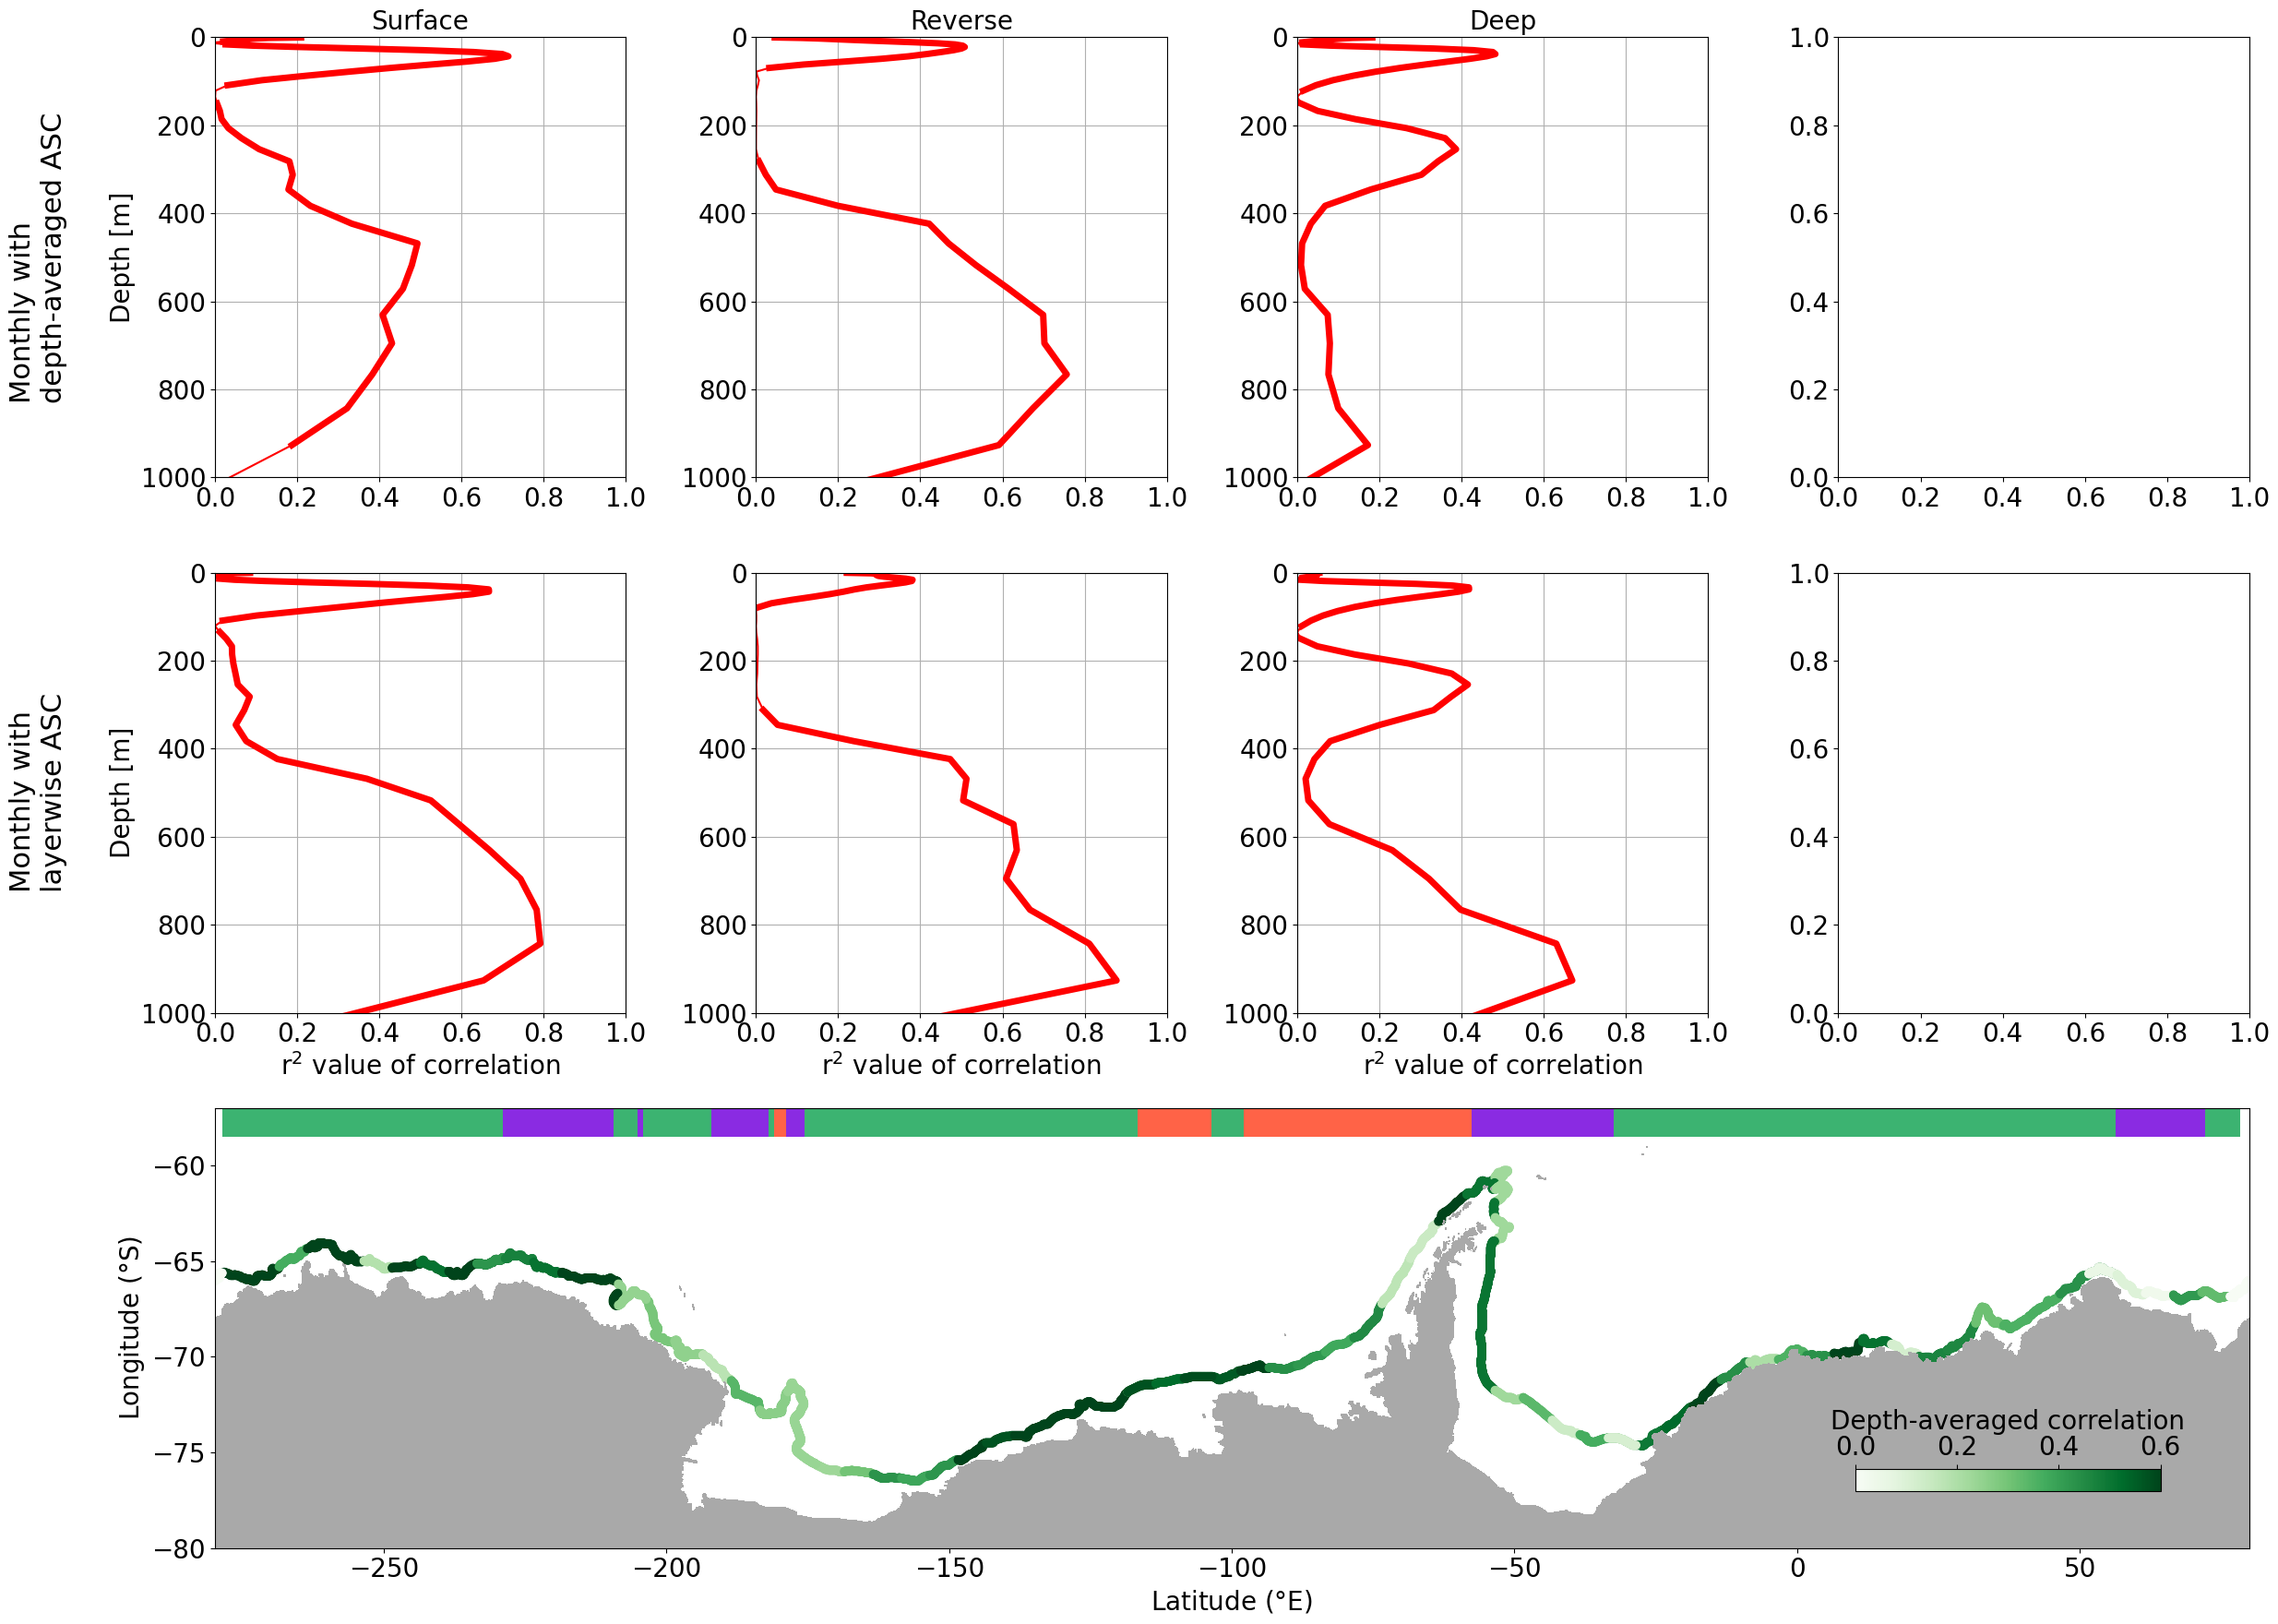

In [125]:
## With changing line thickness past threshold p value
fig =  plt.figure(figsize=(25,18))
plt.subplots_adjust(hspace = 0.2, wspace=0.25)
axs = [plt.subplot(3,4,i) for i in range(1,9)]
thresholdp = 0.95

for i in range(3): # going through regimes in i

    ## r^2 of regimes
    axs[i].set_title(classes[i])
    '''
    ax1 = axs[i].twiny()
    ax2 = axs[i+4].twiny()
    #ax3 = axs[i+6].twiny()
    '''
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(1000,0)
    axs[i+4].set_xlabel('r$^2$ value of correlation')
    axs[i].plot(r_sq_depthav[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    axs[i].plot(np.where(pval_depthav[:,i]>thresholdp,r_sq_depthav[:,i], np.nan), masked_u_along.depth, 'r', label = 'r-squared', lw = 5)

    '''
    ## using binned correlation
    axs[i+4].set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    axs[i+4].plot(binned_corr_av[:,i], binned_corr_av.depth, 'r', label = 'r-squared')
    axs[i+4].plot(np.where(pval_binned_av[:,i]>thresholdp, binned_corr_av[:,i], np.nan), binned_corr_av.depth, 'r', label = 'r-squared', lw =5)
    '''
    ## domain av correlation
    axs[i+4].set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    axs[i+4].plot(r_sq_all[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    axs[i+4].plot(np.where(pval_all[:,i]>thresholdp, r_sq_all[:,i], np.nan), masked_u_along.depth, 'r', label = 'r-squared', lw =5)
    
    axs[0].set_ylabel('Depth [m]')
    axs[4].set_ylabel('Depth [m]')
    #axs[6].set_ylabel('Depth [m]')

    #axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    #axs[3*i].set_xlim(-1.1,0.1)
    #axs[3*i+1].set_xlim(-2,0.6)
    #axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+4].invert_yaxis()
    axs[i+4].set_ylim(1000,0)
    axs[i+4].grid()
    #axs[i+6].invert_yaxis()
    #axs[i+6].set_ylim(1000,0)
    #axs[i+6].grid()
    #axs[1].legend()

axs[0].text(-0.5,0.5, 'Monthly with \ndepth-averaged ASC',  rotation=90, va= 'center', transform = axs[0].transAxes, fontsize = 22)
axs[4].text(-0.5,0.5, 'Monthly with \nlayerwise ASC', rotation=90, va= 'center', transform = axs[4].transAxes, fontsize = 22)


## Plotting spatial depth-average correlation
ax_cric = plt.subplot(313)
ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 0), cmap = 'Greens', vmin = 0, vmax = 0.6)
ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 1), cmap = 'Greens', vmin = 0, vmax = 0.6)
cmap = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 2), cmap = 'Greens', vmin = 0, vmax = 0.6)
ax_cric.pcolormesh(clustering_mask.lon, [-58,-57],  np.vstack((clustering_mask_sum,clustering_mask_sum)) , cmap=CustomCmap_no3)

axins1 = inset_axes(
    ax_cric,
    width="15%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.8,0.1,1,1),
    bbox_transform=ax_cric.transAxes

)

cb = fig.colorbar(cmap, cax = axins1, orientation = 'horizontal', label = 'Depth-averaged correlation')
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")

ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)')
ax_cric.set_xlabel('Latitude ($\degree$E)')

#ax1.legend(loc=4)
plt.tight_layout()
plt.show()

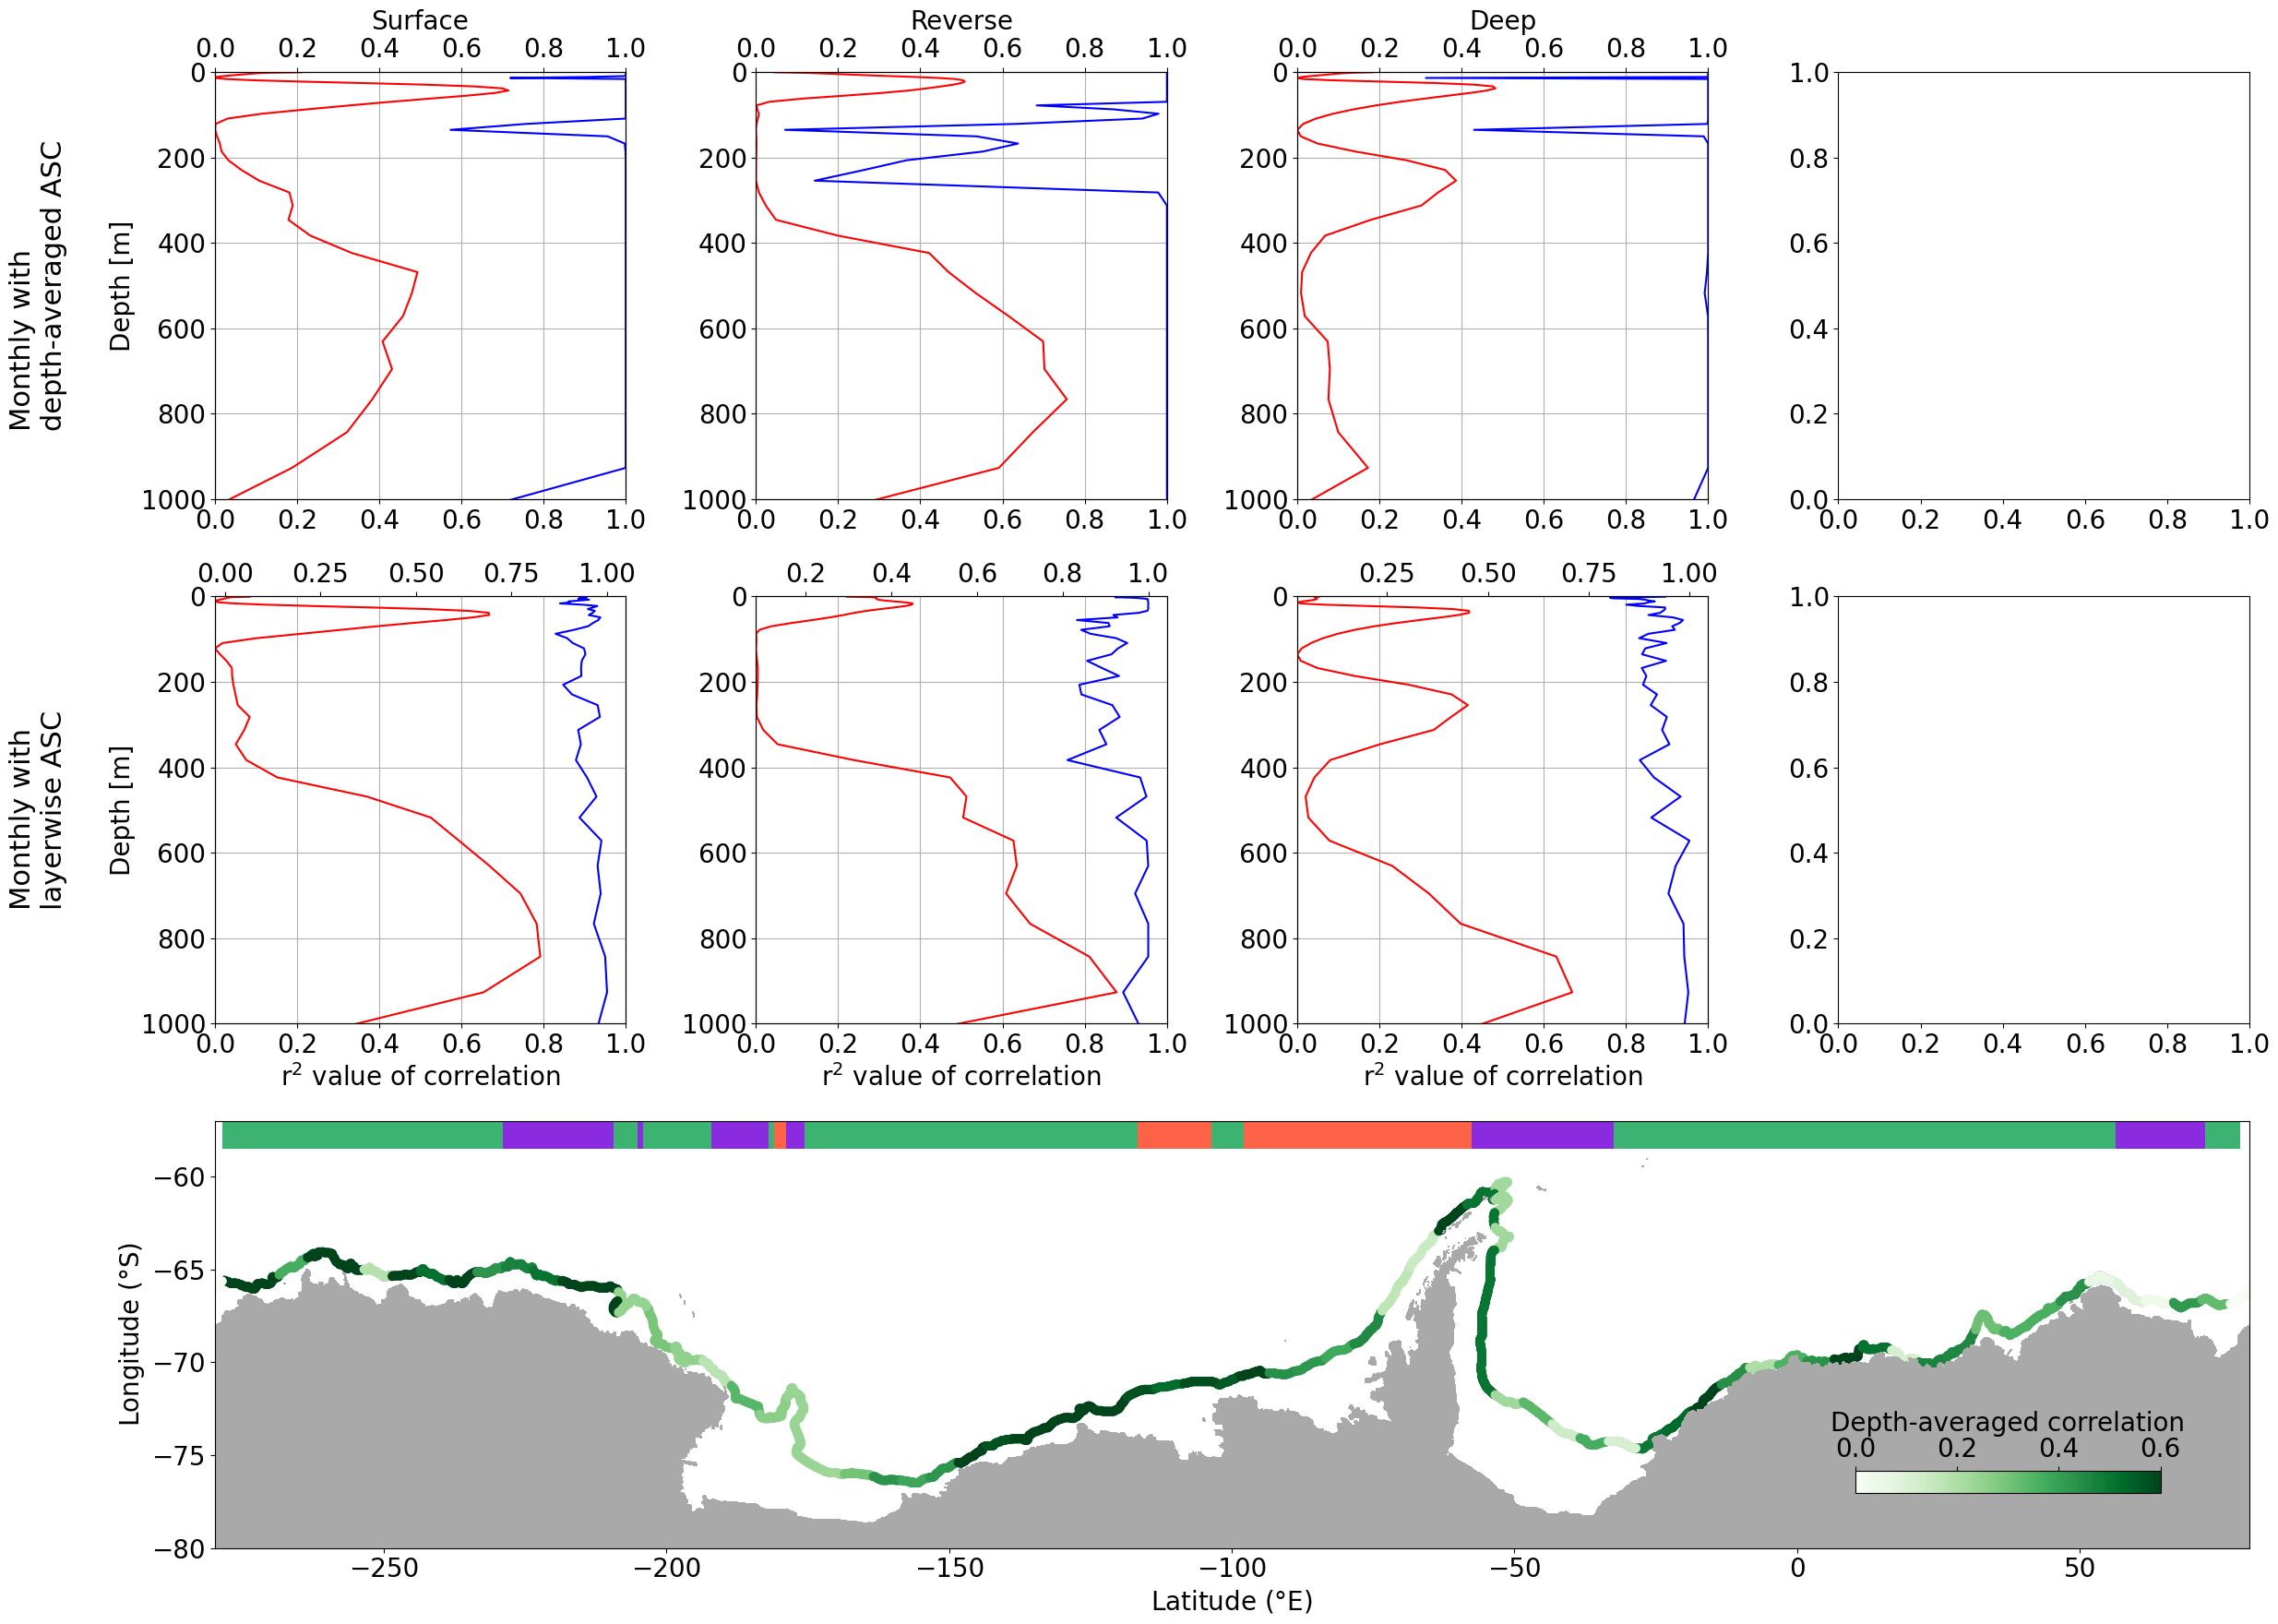

In [102]:
fig =  plt.figure(figsize=(25,18))
plt.subplots_adjust(hspace = 0.2, wspace=0.25)
axs = [plt.subplot(3,4,i) for i in range(1,9)]

for i in range(3): # going through regimes in i

    ## r^2 of regimes
    axs[i].set_title(classes[i])
    '''
    ax1 = axs[i].twiny()
    ax2 = axs[i+4].twiny()
    #ax3 = axs[i+6].twiny()
    '''
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(1000,0)
    axs[i+4].set_xlabel('r$^2$ value of correlation')
    axs[i].plot(r_sq_depthav[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    axs[i+4].set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    axs[i+4].plot(r_sq_all[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    #ax3.set_xlim(0,1)
    #ax3.set_ylim(1000,0)
    #ax3.plot(r_sq_clima[:,i], masked_u_along.depth, 'r', label = 'r-squared')

    ax1 = axs[i].twiny()
    ax1.plot(pval_depthav[:,i], masked_u_along.depth, 'b', label = 'significance')
    ax1.set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    ax2 = axs[i+4].twiny()
    ax2.plot(pval_binned_av[:,i], binned_corr.depth, 'b', label = 'significance')


    axs[0].set_ylabel('Depth [m]')
    axs[4].set_ylabel('Depth [m]')
    #axs[6].set_ylabel('Depth [m]')

    #axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    #axs[3*i].set_xlim(-1.1,0.1)
    #axs[3*i+1].set_xlim(-2,0.6)
    #axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+4].invert_yaxis()
    axs[i+4].set_ylim(1000,0)
    axs[i+4].grid()
    #axs[i+6].invert_yaxis()
    #axs[i+6].set_ylim(1000,0)
    #axs[i+6].grid()
    #axs[1].legend()

axs[0].text(-0.5,0.5, 'Monthly with \ndepth-averaged ASC',  rotation=90, va= 'center', transform = axs[0].transAxes, fontsize = 22)
axs[4].text(-0.5,0.5, 'Monthly with \nlayerwise ASC', rotation=90, va= 'center', transform = axs[4].transAxes, fontsize = 22)


## Plotting spatial depth-average correlation
ax_cric = plt.subplot(313)
ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 0), cmap = 'Greens', vmin = 0, vmax = 0.6)
ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 1), cmap = 'Greens', vmin = 0, vmax = 0.6)
cmap = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 2), cmap = 'Greens', vmin = 0, vmax = 0.6)
ax_cric.pcolormesh(clustering_mask.lon, [-58,-57],  np.vstack((clustering_mask_sum,clustering_mask_sum)) , cmap=CustomCmap_no3)

axins1 = inset_axes(
    ax_cric,
    width="15%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.8,0.1,1,1),
    bbox_transform=ax_cric.transAxes

)

cb = fig.colorbar(cmap, cax = axins1, orientation = 'horizontal', label = 'Depth-averaged correlation')
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")

ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)')
ax_cric.set_xlabel('Latitude ($\degree$E)')

#ax1.legend(loc=4)
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,8))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

for i in range(3): # going through regimes in i

    axs[i].set_title(classes[i], fontsize=14)
    '''
    ax1 = axs[i].twiny()
    ax2 = axs[i+4].twiny()
    #ax3 = axs[i+6].twiny()
    '''
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(1000,0)
    axs[i+4].set_xlabel('r$^2$ value of correlation')
    axs[i].plot(r_sq_depthav[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    axs[i+4].set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    axs[i+4].plot(r_sq_all[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    #ax3.set_xlim(0,1)
    #ax3.set_ylim(1000,0)
    #ax3.plot(r_sq_clima[:,i], masked_u_along.depth, 'r', label = 'r-squared')

    axs[0].set_ylabel('Depth [m]')
    axs[4].set_ylabel('Depth [m]')
    #axs[6].set_ylabel('Depth [m]')

    #axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    #axs[3*i].set_xlim(-1.1,0.1)
    #axs[3*i+1].set_xlim(-2,0.6)
    #axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+4].invert_yaxis()
    axs[i+4].set_ylim(1000,0)
    axs[i+4].grid()
    #axs[i+6].invert_yaxis()
    #axs[i+6].set_ylim(1000,0)
    #axs[i+6].grid()
    #axs[1].legend()

axs[0].text(-0.5,0.5, 'Monthly with \ndepth-averaged ASC', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
axs[4].text(-0.5,0.5, 'Monthly with \nlayerwise ASC', fontsize = 14, rotation=90, va= 'center', transform = axs[4].transAxes)


#ax1.legend(loc=4)
plt.show()